2022년 7월까지의 데이터를 학습하고 내년까지 예측하기

In [36]:
import pandas as pd
import numpy as np
from haversine import haversine
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM
from tensorflow import keras
import numpy as np
from numpy import concatenate
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
import random
import itertools
from sklearn import linear_model

함수정의

In [37]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
  n_vars = 1 if type(data) is list else data.shape[1]
  df = pd.DataFrame(data)
  cols, names = list(), list()
  # input sequence (t-n, ... t-1)
  for i in range(n_in, 0, -1):
      cols.append(df.shift(i))
      names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
  # forecast sequence (t, t+1, ... t+n)
  for i in range(0, n_out):
      cols.append(df.shift(-i))
      if i == 0:
          names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
      else:
          names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
  # put it all together
  agg = pd.concat(cols, axis=1)
  agg.columns = names
  # drop rows with NaN values
  if dropnan:
      agg.dropna(inplace=True)
  return agg

In [38]:
#기준 아파트로부터 'near_range' km 내에 존재하는 아파트 코드 반환
def finding_near_apt(gizun,near_range):
    start = (float(gizun['GPS_Y']),float(gizun['GPS_X']))
    near_apts = []
    for j in df_range.index:
        goal = (float(df_range['GPS_Y'][j]),float(df_range['GPS_X'][j]))
        if haversine(start, goal) < near_range:
            near_apts.append(df_range['apart_code'][j])
    near_df = pd.DataFrame()
    near_df['apart_code'] = near_apts
    return near_df

In [39]:
#사용하지 않을 과거 데이터 제거(윈도우 사이즈가 3일경우)
def delete_unuse_var(reframed):
    var_count = int(len(reframed.columns)/4)
    reframed.drop(reframed.columns[var_count*2:(var_count*3) - 1], axis=1, inplace=True)
    reframed.drop(reframed.columns[var_count:(var_count*2) - 1], axis=1, inplace=True)
    reframed.drop(reframed.columns[0:var_count - 1], axis=1, inplace=True)
    return reframed

In [40]:
#데이터프레임에서 일정한 컬럼만 추출하고 값 형태로 반환
def get_float_values(df):
    df = df[['YYYYMM','sale_type', 'area_m3', 'floor', 'const_year', 
    'parking', 'building_year', 'market_dist','busstop_dist', 'subway_dist', 
    'kinder_dist', 'hospital_dist','near_element', 
    'near_middle', 'near_high', 'generation','const_rank','prices']]
    values = df.values
    values = values.astype('float32')
    return values

In [41]:
#코드들로부터 값을 추출하고 합치기
def get_from_codes(codes):
    for j in codes:
        df1 = globals()['df_'+j]
        values = get_float_values(df1)
        reframed = series_to_supervised(values, 3, 1)
        reframed = delete_unuse_var(reframed)
        global df_all
        df_all = pd.concat([reframed,df_all])
    return df_all

In [42]:
#추가하고 싶은 달을 입력
def make_future_data(new_year,new_month):
    global df
    new_df = df.drop_duplicates(subset = ['apart_code','area_m3'])
    new_df['YYYYMM'] = int(new_year)*100 + int(new_month)
    new_df['crime_rate'] = np.nan
    new_df['ASPI'] = np.nan
    new_df['YYYY'] = new_year
    new_df['MM'] = new_month
    new_df['HAI'] = np.nan
    new_df['PIR'] = np.nan
    new_df['LIR'] = np.nan
    new_df['GDP'] = np.nan
    new_df['GDI'] = np.nan
    new_df['GNI'] = np.nan
    new_df['CPI'] = np.nan
    new_df['avg_interest'] = np.nan
    new_df['kospi'] = np.nan
    new_df['M2'] = np.nan
    new_df['house_CCSI'] = np.nan
    new_df['unsold'] = np.nan
    #가격은 뭘로 할건지
    new_df['prices'] = 0 
    return new_df

In [43]:
def fill_nan(X_list,Y,df_a,df_pred):
    lin_reg = linear_model.LinearRegression()
    x = df_a.dropna(axis=0)[X_list]
    y = df_a.dropna(axis=0)[Y]
    lin_reg_model = lin_reg.fit(x,y)
    y_pred = lin_reg_model.predict(df_pred.loc[:, X_list])
    df_pred[Y] = np.where(df_pred[Y].isnull(),pd.Series(y_pred.flatten()),df_pred[Y])
    return df_pred

파일 읽기

In [50]:
df = pd.read_csv('final6.csv',encoding='cp949')

In [45]:
#결측값 제거
df = df[df['sale_type'].notna()]
df = df[df['parking'].notna()]
df = df[df['HAI'].notna()]
df = df[df['M2'].notna()]
#정성적변수 정량적 변수로 변환
df.loc[df['sale_type'] == '분양', 'sale_type'] = 0
df.loc[df['sale_type'] == '임대+분양', 'sale_type'] = 1
df.loc[df['sale_type'] == '임대', 'sale_type'] = 2
df.loc[df['sale_type'] == '영구임대', 'sale_type'] = 3
df['area_m3']=df['area_m3'].round(-1)
df = df.astype({'prices':'float64'})
df['prices']=df.groupby(['YYYYMM','apart_code','area_m3'])['prices'].transform('mean')
df['apart_code_area'] = df['apart_code'].map(str) +'_' +df['area_m3'].map(int).map(str)
df_a = df
exiting_code = df['apart_code'].unique()
df_vary = df.drop_duplicates(['apart_code'])
df_range = df_vary[['apart_code','GPS_X','GPS_Y']]
many_df = pd.read_csv('서울시아파트(기준).csv',encoding='cp949')
many_df = many_df[many_df['k-아파트코드'].isin(exiting_code)]

예측하고 싶은 값 추가

In [11]:
#df_prediction 생성
df_predction_8 = make_future_data(2022,8)

df_predction_9 = make_future_data(2022,9)

df_predction_10 = make_future_data(2022,10)

df_predction_11 = make_future_data(2022,11)

df_predction_12 = make_future_data(2022,12)

df_predction_1 = make_future_data(2023,1)

df_predction_2 = make_future_data(2023,2)

df_predction_3 = make_future_data(2023,3)

df_predction_4 = make_future_data(2023,4)

df_predction_5 = make_future_data(2023,5)

df_predction_6 = make_future_data(2023,6)

df_predction_7 = make_future_data(2023,7)

df_predction_238 = make_future_data(2023,8)

df_predction_239 = make_future_data(2023,9)

df_predction_2310 = make_future_data(2023,10)

df_predction_2311 = make_future_data(2023,11)

df_predction_2312 = make_future_data(2023,12)

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

In [12]:
#예측원하는 값 리스트로 생성
pred_df = df.drop_duplicates(['apart_code'])
search_list = ['현대백조','천호현대','신림현대','창동현대타운','광장11현대홈타운','현대6차','현대4차','현대3차','송파현대힐스테이트','한양현대']
pred_list = []
for i in search_list:
    print(pred_df[pred_df['apart__name'].str.contains(i)]['apart_code'].values)
    pred_list.append(pred_df[pred_df['apart__name'].str.contains(i)]['apart_code'].values)
pred_list = list(itertools.chain(*pred_list))

['A13873701' 'A13813006']
[]
['A15101508']
['A13292501']
['A14321001']
['A15010307']
['A13204402']
['A13983712' 'A15004406' 'A15807211' 'A13510102' 'A13881302' 'A15009502']
['A13887901']
['A13384301']


In [13]:
#df_prediction_8 과 df_all을 결합
df_a = pd.concat([df_a,df_predction_8], ignore_index=False)

실제로 돌아가는 모델

8월 추가

In [14]:
#6분정도 걸리는듯
#exiting_code = df['apart_code'].unique()
for i in pred_list:
    gizun_code = i
    gizun = df_range[df_range['apart_code']==gizun_code]
    #변수 변경시 거리 조정
    near_df = finding_near_apt(gizun,2)
    near_df = pd.merge(near_df,many_df,left_on='apart_code',right_on='k-아파트코드',how='left')
    near_df = near_df[['apart_code','k-전체세대수']]
    gizun_count = near_df[near_df['apart_code']==gizun_code].iloc[0][1]
    indexNames = near_df[near_df['k-전체세대수'] < gizun_count].index
    near_df.drop(indexNames , inplace=True)
    df = df_a
    df = pd.merge(near_df,df,on='apart_code')
    df.pop('k-전체세대수')
    df = df.drop_duplicates(subset=['apart_code_area','YYYYMM'])
    df = df.sort_values(by=["apart_code_area", "YYYYMM"], ascending=[True, True])
    df = df[['apart_code_area', 'YYYYMM','sale_type', 'area_m3', 'floor', 'const_year', 
    'parking', 'building_year', 'market_dist','busstop_dist', 'subway_dist', 
    'kinder_dist', 'hospital_dist','YYYY', 'MM','near_element', 
    'near_middle', 'near_high', 'generation','const_rank','prices']]
    codes = df['apart_code_area'].unique()
    groups = df.groupby(df.apart_code_area)
    for j in codes:
        globals()['df_'+j] = groups.get_group(j)
    gizun_code_areas = df[df['apart_code_area'].str.contains(gizun_code)]['apart_code_area'].unique()
    for k in gizun_code_areas:
        gizun_code_area = k
        gizun_df = globals()['df_'+gizun_code_area]
        df_all = pd.DataFrame()
        deleted_code = 'df_'+gizun_code_area
        codes = np.delete(codes, np.where(codes == deleted_code))
        df_all = get_from_codes(codes)
        train_set = df_all[df_all['var1(t)']<=202207]
        df_test = gizun_df
        values = get_float_values(df_test)
        reframed = series_to_supervised(values, 3, 1)
        reframed = delete_unuse_var(reframed)
        #날짜를 사용해 df와 df_prediction_8 구분
        test_set = reframed[reframed['var1(t)']==202208]
        df_set = pd.concat([train_set,test_set])
        train_days =  len(train_set)
        values= df_set.values
        scaled = scaler.fit_transform(values)
        values = scaled
        train_days =  len(train_set)
        #테스트 데이터 얼마나 사용할 건지
        train = values[:train_days]
        test = values[train_days:]
        # split into input and outputs
        train_X, train_y = train[:, :-1], train[:, -1]
        test_X, test_y = test[:, :-1], test[:, -1]
        # reshape input to be 3D [samples, timesteps, features]
        train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
        test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
        model = Sequential()
        model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
        model.add(Dense(1))
        model.compile(loss='mae', optimizer='adam')
        history = model.fit(train_X, train_y, epochs=50, batch_size=72, 
                validation_data=(test_X, test_y), verbose=2, shuffle=False)
        # make a prediction
        try:
            yhat = model.predict(test_X)
            test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
            inv_yhat = concatenate((test_X[:, 0:],yhat), axis=1)
            # invert scaling for actual
            inv_yhat = scaler.inverse_transform(inv_yhat)
            inv_yhat = inv_yhat[:,-1]
            #만약 해당 값을 데이터 프레임에 넣고 싶다면
            df_a['prices'][(df_a['apart_code_area']==k)&(df_a['YYYYMM']==202208)] = float(inv_yhat[0])
        except:
            #만약 해당 아파트의 2020년 이후 거래내역이 존재하지 않을 경우 오류 발생
            print('오류 발생')
#df_a를 기본 df로 다시 변경
df = df_a 

Epoch 1/50
63/63 - 5s - loss: 0.0723 - val_loss: 0.2199 - 5s/epoch - 76ms/step
Epoch 2/50
63/63 - 0s - loss: 0.0419 - val_loss: 0.1618 - 193ms/epoch - 3ms/step
Epoch 3/50
63/63 - 0s - loss: 0.0265 - val_loss: 0.2151 - 226ms/epoch - 4ms/step
Epoch 4/50
63/63 - 0s - loss: 0.0237 - val_loss: 0.1970 - 203ms/epoch - 3ms/step
Epoch 5/50
63/63 - 0s - loss: 0.0224 - val_loss: 0.2037 - 240ms/epoch - 4ms/step
Epoch 6/50
63/63 - 0s - loss: 0.0211 - val_loss: 0.2034 - 229ms/epoch - 4ms/step
Epoch 7/50
63/63 - 0s - loss: 0.0184 - val_loss: 0.2070 - 219ms/epoch - 3ms/step
Epoch 8/50
63/63 - 0s - loss: 0.0197 - val_loss: 0.1870 - 236ms/epoch - 4ms/step
Epoch 9/50
63/63 - 0s - loss: 0.0198 - val_loss: 0.2400 - 196ms/epoch - 3ms/step
Epoch 10/50
63/63 - 0s - loss: 0.0217 - val_loss: 0.1682 - 211ms/epoch - 3ms/step
Epoch 11/50
63/63 - 0s - loss: 0.0209 - val_loss: 0.2271 - 242ms/epoch - 4ms/step
Epoch 12/50
63/63 - 0s - loss: 0.0203 - val_loss: 0.1720 - 281ms/epoch - 4ms/step
Epoch 13/50
63/63 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
51/51 - 3s - loss: 0.0799 - val_loss: 0.3610 - 3s/epoch - 67ms/step
Epoch 2/50
51/51 - 0s - loss: 0.0481 - val_loss: 0.3380 - 208ms/epoch - 4ms/step
Epoch 3/50
51/51 - 0s - loss: 0.0290 - val_loss: 0.4430 - 196ms/epoch - 4ms/step
Epoch 4/50
51/51 - 0s - loss: 0.0285 - val_loss: 0.4204 - 199ms/epoch - 4ms/step
Epoch 5/50
51/51 - 0s - loss: 0.0274 - val_loss: 0.4995 - 194ms/epoch - 4ms/step
Epoch 6/50
51/51 - 0s - loss: 0.0282 - val_loss: 0.4377 - 218ms/epoch - 4ms/step
Epoch 7/50
51/51 - 0s - loss: 0.0252 - val_loss: 0.4756 - 208ms/epoch - 4ms/step
Epoch 8/50
51/51 - 0s - loss: 0.0263 - val_loss: 0.4389 - 167ms/epoch - 3ms/step
Epoch 9/50
51/51 - 0s - loss: 0.0261 - val_loss: 0.4415 - 163ms/epoch - 3ms/step
Epoch 10/50
51/51 - 0s - loss: 0.0253 - val_loss: 0.4281 - 175ms/epoch - 3ms/step
Epoch 11/50
51/51 - 0s - loss: 0.0247 - val_loss: 0.4008 - 181ms/epoch - 4ms/step
Epoch 12/50
51/51 - 0s - loss: 0.0256 - val_loss: 0.4248 - 208ms/epoch - 4ms/step
Epoch 13/50
51/51 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
51/51 - 3s - loss: 0.0886 - val_loss: 0.2952 - 3s/epoch - 52ms/step
Epoch 2/50
51/51 - 0s - loss: 0.0522 - val_loss: 0.2927 - 191ms/epoch - 4ms/step
Epoch 3/50
51/51 - 0s - loss: 0.0315 - val_loss: 0.3763 - 202ms/epoch - 4ms/step
Epoch 4/50
51/51 - 0s - loss: 0.0233 - val_loss: 0.3927 - 180ms/epoch - 4ms/step
Epoch 5/50
51/51 - 0s - loss: 0.0214 - val_loss: 0.4142 - 174ms/epoch - 3ms/step
Epoch 6/50
51/51 - 0s - loss: 0.0226 - val_loss: 0.3889 - 185ms/epoch - 4ms/step
Epoch 7/50
51/51 - 0s - loss: 0.0272 - val_loss: 0.4183 - 194ms/epoch - 4ms/step
Epoch 8/50
51/51 - 0s - loss: 0.0234 - val_loss: 0.3692 - 178ms/epoch - 3ms/step
Epoch 9/50
51/51 - 0s - loss: 0.0288 - val_loss: 0.4827 - 201ms/epoch - 4ms/step
Epoch 10/50
51/51 - 0s - loss: 0.0323 - val_loss: 0.3765 - 186ms/epoch - 4ms/step
Epoch 11/50
51/51 - 0s - loss: 0.0329 - val_loss: 0.4402 - 264ms/epoch - 5ms/step
Epoch 12/50
51/51 - 0s - loss: 0.0245 - val_loss: 0.3755 - 262ms/epoch - 5ms/step
Epoch 13/50
51/51 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
20/20 - 3s - loss: 0.1929 - val_loss: 0.3853 - 3s/epoch - 140ms/step
Epoch 2/50
20/20 - 0s - loss: 0.1109 - val_loss: 0.4022 - 120ms/epoch - 6ms/step
Epoch 3/50
20/20 - 0s - loss: 0.0852 - val_loss: 0.4574 - 141ms/epoch - 7ms/step
Epoch 4/50
20/20 - 0s - loss: 0.0589 - val_loss: 0.5108 - 133ms/epoch - 7ms/step
Epoch 5/50
20/20 - 0s - loss: 0.0420 - val_loss: 0.6060 - 111ms/epoch - 6ms/step
Epoch 6/50
20/20 - 0s - loss: 0.0351 - val_loss: 0.6359 - 85ms/epoch - 4ms/step
Epoch 7/50
20/20 - 0s - loss: 0.0298 - val_loss: 0.6082 - 70ms/epoch - 3ms/step
Epoch 8/50
20/20 - 0s - loss: 0.0408 - val_loss: 0.7199 - 95ms/epoch - 5ms/step
Epoch 9/50
20/20 - 0s - loss: 0.0672 - val_loss: 0.7949 - 78ms/epoch - 4ms/step
Epoch 10/50
20/20 - 0s - loss: 0.0803 - val_loss: 0.6297 - 91ms/epoch - 5ms/step
Epoch 11/50
20/20 - 0s - loss: 0.0637 - val_loss: 0.5836 - 79ms/epoch - 4ms/step
Epoch 12/50
20/20 - 0s - loss: 0.0534 - val_loss: 0.7071 - 80ms/epoch - 4ms/step
Epoch 13/50
20/20 - 0s - loss: 0.

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
20/20 - 3s - loss: 0.2692 - val_loss: 0.2940 - 3s/epoch - 168ms/step
Epoch 2/50
20/20 - 0s - loss: 0.1193 - val_loss: 0.4881 - 169ms/epoch - 8ms/step
Epoch 3/50
20/20 - 0s - loss: 0.0815 - val_loss: 0.4975 - 241ms/epoch - 12ms/step
Epoch 4/50
20/20 - 0s - loss: 0.0626 - val_loss: 0.5945 - 170ms/epoch - 8ms/step
Epoch 5/50
20/20 - 0s - loss: 0.0468 - val_loss: 0.6795 - 196ms/epoch - 10ms/step
Epoch 6/50
20/20 - 0s - loss: 0.0376 - val_loss: 0.7135 - 190ms/epoch - 10ms/step
Epoch 7/50
20/20 - 0s - loss: 0.0280 - val_loss: 0.7262 - 96ms/epoch - 5ms/step
Epoch 8/50
20/20 - 0s - loss: 0.0430 - val_loss: 0.8165 - 89ms/epoch - 4ms/step
Epoch 9/50
20/20 - 0s - loss: 0.0833 - val_loss: 0.9442 - 82ms/epoch - 4ms/step
Epoch 10/50
20/20 - 0s - loss: 0.0906 - val_loss: 0.7231 - 90ms/epoch - 4ms/step
Epoch 11/50
20/20 - 0s - loss: 0.0462 - val_loss: 0.7318 - 89ms/epoch - 4ms/step
Epoch 12/50
20/20 - 0s - loss: 0.0440 - val_loss: 0.8745 - 90ms/epoch - 5ms/step
Epoch 13/50
20/20 - 0s - loss

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
20/20 - 4s - loss: 0.2024 - val_loss: 0.3376 - 4s/epoch - 219ms/step
Epoch 2/50
20/20 - 0s - loss: 0.1028 - val_loss: 0.3454 - 87ms/epoch - 4ms/step
Epoch 3/50
20/20 - 0s - loss: 0.0591 - val_loss: 0.3274 - 87ms/epoch - 4ms/step
Epoch 4/50
20/20 - 0s - loss: 0.0436 - val_loss: 0.3994 - 163ms/epoch - 8ms/step
Epoch 5/50
20/20 - 0s - loss: 0.0391 - val_loss: 0.4367 - 163ms/epoch - 8ms/step
Epoch 6/50
20/20 - 0s - loss: 0.0425 - val_loss: 0.3140 - 172ms/epoch - 9ms/step
Epoch 7/50
20/20 - 0s - loss: 0.0975 - val_loss: 0.4795 - 114ms/epoch - 6ms/step
Epoch 8/50
20/20 - 0s - loss: 0.0436 - val_loss: 0.5215 - 100ms/epoch - 5ms/step
Epoch 9/50
20/20 - 0s - loss: 0.0520 - val_loss: 0.4044 - 90ms/epoch - 5ms/step
Epoch 10/50
20/20 - 0s - loss: 0.0612 - val_loss: 0.3666 - 86ms/epoch - 4ms/step
Epoch 11/50
20/20 - 0s - loss: 0.0597 - val_loss: 0.4622 - 87ms/epoch - 4ms/step
Epoch 12/50
20/20 - 0s - loss: 0.0529 - val_loss: 0.5125 - 103ms/epoch - 5ms/step
Epoch 13/50
20/20 - 0s - loss: 

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
20/20 - 3s - loss: 0.1889 - val_loss: 0.4022 - 3s/epoch - 142ms/step
Epoch 2/50
20/20 - 0s - loss: 0.1047 - val_loss: 0.3935 - 167ms/epoch - 8ms/step
Epoch 3/50
20/20 - 0s - loss: 0.0725 - val_loss: 0.4448 - 83ms/epoch - 4ms/step
Epoch 4/50
20/20 - 0s - loss: 0.0438 - val_loss: 0.4871 - 84ms/epoch - 4ms/step
Epoch 5/50
20/20 - 0s - loss: 0.0346 - val_loss: 0.5347 - 103ms/epoch - 5ms/step
Epoch 6/50
20/20 - 0s - loss: 0.0463 - val_loss: 0.5629 - 111ms/epoch - 6ms/step
Epoch 7/50
20/20 - 0s - loss: 0.0576 - val_loss: 0.5722 - 172ms/epoch - 9ms/step
Epoch 8/50
20/20 - 0s - loss: 0.0326 - val_loss: 0.5434 - 143ms/epoch - 7ms/step
Epoch 9/50
20/20 - 0s - loss: 0.0392 - val_loss: 0.4684 - 73ms/epoch - 4ms/step
Epoch 10/50
20/20 - 0s - loss: 0.0609 - val_loss: 0.6382 - 77ms/epoch - 4ms/step
Epoch 11/50
20/20 - 0s - loss: 0.0755 - val_loss: 0.6485 - 136ms/epoch - 7ms/step
Epoch 12/50
20/20 - 0s - loss: 0.0608 - val_loss: 0.5202 - 157ms/epoch - 8ms/step
Epoch 13/50
20/20 - 0s - loss:

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
20/20 - 2s - loss: 0.1856 - val_loss: 0.4779 - 2s/epoch - 118ms/step
Epoch 2/50
20/20 - 0s - loss: 0.0857 - val_loss: 0.4888 - 86ms/epoch - 4ms/step
Epoch 3/50
20/20 - 0s - loss: 0.0589 - val_loss: 0.5428 - 85ms/epoch - 4ms/step
Epoch 4/50
20/20 - 0s - loss: 0.0439 - val_loss: 0.6134 - 84ms/epoch - 4ms/step
Epoch 5/50
20/20 - 0s - loss: 0.0394 - val_loss: 0.5733 - 88ms/epoch - 4ms/step
Epoch 6/50
20/20 - 0s - loss: 0.0462 - val_loss: 0.5814 - 94ms/epoch - 5ms/step
Epoch 7/50
20/20 - 0s - loss: 0.0685 - val_loss: 0.7747 - 89ms/epoch - 4ms/step
Epoch 8/50
20/20 - 0s - loss: 0.0829 - val_loss: 0.5985 - 100ms/epoch - 5ms/step
Epoch 9/50
20/20 - 0s - loss: 0.0410 - val_loss: 0.6040 - 107ms/epoch - 5ms/step
Epoch 10/50
20/20 - 0s - loss: 0.0502 - val_loss: 0.7340 - 82ms/epoch - 4ms/step
Epoch 11/50
20/20 - 0s - loss: 0.0623 - val_loss: 0.6261 - 77ms/epoch - 4ms/step
Epoch 12/50
20/20 - 0s - loss: 0.0342 - val_loss: 0.5950 - 89ms/epoch - 4ms/step
Epoch 13/50
20/20 - 0s - loss: 0.04

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
141/141 - 4s - loss: 0.0766 - val_loss: 0.1933 - 4s/epoch - 29ms/step
Epoch 2/50
141/141 - 1s - loss: 0.0299 - val_loss: 0.2264 - 517ms/epoch - 4ms/step
Epoch 3/50
141/141 - 1s - loss: 0.0253 - val_loss: 0.1863 - 609ms/epoch - 4ms/step
Epoch 4/50
141/141 - 1s - loss: 0.0215 - val_loss: 0.1987 - 531ms/epoch - 4ms/step
Epoch 5/50
141/141 - 0s - loss: 0.0218 - val_loss: 0.1705 - 430ms/epoch - 3ms/step
Epoch 6/50
141/141 - 0s - loss: 0.0242 - val_loss: 0.1766 - 443ms/epoch - 3ms/step
Epoch 7/50
141/141 - 0s - loss: 0.0221 - val_loss: 0.1823 - 423ms/epoch - 3ms/step
Epoch 8/50
141/141 - 0s - loss: 0.0206 - val_loss: 0.1943 - 421ms/epoch - 3ms/step
Epoch 9/50
141/141 - 0s - loss: 0.0208 - val_loss: 0.1917 - 461ms/epoch - 3ms/step
Epoch 10/50
141/141 - 0s - loss: 0.0196 - val_loss: 0.1890 - 447ms/epoch - 3ms/step
Epoch 11/50
141/141 - 0s - loss: 0.0186 - val_loss: 0.1847 - 460ms/epoch - 3ms/step
Epoch 12/50
141/141 - 0s - loss: 0.0159 - val_loss: 0.1937 - 452ms/epoch - 3ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
141/141 - 3s - loss: 0.0619 - val_loss: 0.3436 - 3s/epoch - 22ms/step
Epoch 2/50
141/141 - 1s - loss: 0.0283 - val_loss: 0.3235 - 661ms/epoch - 5ms/step
Epoch 3/50
141/141 - 1s - loss: 0.0207 - val_loss: 0.3151 - 759ms/epoch - 5ms/step
Epoch 4/50
141/141 - 0s - loss: 0.0172 - val_loss: 0.3216 - 457ms/epoch - 3ms/step
Epoch 5/50
141/141 - 0s - loss: 0.0172 - val_loss: 0.3183 - 412ms/epoch - 3ms/step
Epoch 6/50
141/141 - 0s - loss: 0.0183 - val_loss: 0.3136 - 496ms/epoch - 4ms/step
Epoch 7/50
141/141 - 1s - loss: 0.0174 - val_loss: 0.3143 - 651ms/epoch - 5ms/step
Epoch 8/50
141/141 - 1s - loss: 0.0204 - val_loss: 0.2975 - 1s/epoch - 8ms/step
Epoch 9/50
141/141 - 1s - loss: 0.0187 - val_loss: 0.3419 - 656ms/epoch - 5ms/step
Epoch 10/50
141/141 - 0s - loss: 0.0154 - val_loss: 0.3394 - 396ms/epoch - 3ms/step
Epoch 11/50
141/141 - 0s - loss: 0.0168 - val_loss: 0.3257 - 475ms/epoch - 3ms/step
Epoch 12/50
141/141 - 1s - loss: 0.0158 - val_loss: 0.3095 - 840ms/epoch - 6ms/step
Epoch 

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
141/141 - 3s - loss: 0.0757 - val_loss: 0.2519 - 3s/epoch - 21ms/step
Epoch 2/50
141/141 - 0s - loss: 0.0288 - val_loss: 0.2913 - 487ms/epoch - 3ms/step
Epoch 3/50
141/141 - 1s - loss: 0.0227 - val_loss: 0.2677 - 561ms/epoch - 4ms/step
Epoch 4/50
141/141 - 0s - loss: 0.0176 - val_loss: 0.2775 - 456ms/epoch - 3ms/step
Epoch 5/50
141/141 - 1s - loss: 0.0162 - val_loss: 0.3081 - 580ms/epoch - 4ms/step
Epoch 6/50
141/141 - 0s - loss: 0.0193 - val_loss: 0.2875 - 431ms/epoch - 3ms/step
Epoch 7/50
141/141 - 1s - loss: 0.0176 - val_loss: 0.2595 - 552ms/epoch - 4ms/step
Epoch 8/50
141/141 - 0s - loss: 0.0167 - val_loss: 0.2763 - 456ms/epoch - 3ms/step
Epoch 9/50
141/141 - 0s - loss: 0.0156 - val_loss: 0.2762 - 447ms/epoch - 3ms/step
Epoch 10/50
141/141 - 0s - loss: 0.0156 - val_loss: 0.2860 - 456ms/epoch - 3ms/step
Epoch 11/50
141/141 - 0s - loss: 0.0153 - val_loss: 0.2847 - 452ms/epoch - 3ms/step
Epoch 12/50
141/141 - 0s - loss: 0.0171 - val_loss: 0.2819 - 421ms/epoch - 3ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
43/43 - 3s - loss: 0.1124 - val_loss: 0.2920 - 3s/epoch - 65ms/step
Epoch 2/50
43/43 - 0s - loss: 0.0664 - val_loss: 0.4144 - 176ms/epoch - 4ms/step
Epoch 3/50
43/43 - 0s - loss: 0.0386 - val_loss: 0.5372 - 175ms/epoch - 4ms/step
Epoch 4/50
43/43 - 0s - loss: 0.0271 - val_loss: 0.5972 - 173ms/epoch - 4ms/step
Epoch 5/50
43/43 - 0s - loss: 0.0235 - val_loss: 0.6123 - 168ms/epoch - 4ms/step
Epoch 6/50
43/43 - 0s - loss: 0.0213 - val_loss: 0.6172 - 184ms/epoch - 4ms/step
Epoch 7/50
43/43 - 0s - loss: 0.0200 - val_loss: 0.6222 - 171ms/epoch - 4ms/step
Epoch 8/50
43/43 - 0s - loss: 0.0195 - val_loss: 0.6204 - 165ms/epoch - 4ms/step
Epoch 9/50
43/43 - 0s - loss: 0.0196 - val_loss: 0.6238 - 178ms/epoch - 4ms/step
Epoch 10/50
43/43 - 0s - loss: 0.0213 - val_loss: 0.6208 - 172ms/epoch - 4ms/step
Epoch 11/50
43/43 - 0s - loss: 0.0247 - val_loss: 0.6216 - 168ms/epoch - 4ms/step
Epoch 12/50
43/43 - 0s - loss: 0.0233 - val_loss: 0.6716 - 168ms/epoch - 4ms/step
Epoch 13/50
43/43 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
41/41 - 2s - loss: 0.1361 - val_loss: 0.2569 - 2s/epoch - 61ms/step
Epoch 2/50
41/41 - 0s - loss: 0.0699 - val_loss: 0.2901 - 164ms/epoch - 4ms/step
Epoch 3/50
41/41 - 0s - loss: 0.0503 - val_loss: 0.3516 - 170ms/epoch - 4ms/step
Epoch 4/50
41/41 - 0s - loss: 0.0385 - val_loss: 0.3760 - 171ms/epoch - 4ms/step
Epoch 5/50
41/41 - 0s - loss: 0.0316 - val_loss: 0.3832 - 170ms/epoch - 4ms/step
Epoch 6/50
41/41 - 0s - loss: 0.0269 - val_loss: 0.3858 - 182ms/epoch - 4ms/step
Epoch 7/50
41/41 - 0s - loss: 0.0286 - val_loss: 0.3611 - 163ms/epoch - 4ms/step
Epoch 8/50
41/41 - 0s - loss: 0.0345 - val_loss: 0.3592 - 161ms/epoch - 4ms/step
Epoch 9/50
41/41 - 0s - loss: 0.0428 - val_loss: 0.3787 - 162ms/epoch - 4ms/step
Epoch 10/50
41/41 - 0s - loss: 0.0298 - val_loss: 0.4021 - 169ms/epoch - 4ms/step
Epoch 11/50
41/41 - 0s - loss: 0.0331 - val_loss: 0.3910 - 158ms/epoch - 4ms/step
Epoch 12/50
41/41 - 0s - loss: 0.0311 - val_loss: 0.3760 - 183ms/epoch - 4ms/step
Epoch 13/50
41/41 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
41/41 - 2s - loss: 0.1219 - val_loss: 0.2957 - 2s/epoch - 61ms/step
Epoch 2/50
41/41 - 0s - loss: 0.0653 - val_loss: 0.3439 - 170ms/epoch - 4ms/step
Epoch 3/50
41/41 - 0s - loss: 0.0419 - val_loss: 0.4052 - 160ms/epoch - 4ms/step
Epoch 4/50
41/41 - 0s - loss: 0.0349 - val_loss: 0.4172 - 156ms/epoch - 4ms/step
Epoch 5/50
41/41 - 0s - loss: 0.0294 - val_loss: 0.4281 - 152ms/epoch - 4ms/step
Epoch 6/50
41/41 - 0s - loss: 0.0282 - val_loss: 0.4488 - 159ms/epoch - 4ms/step
Epoch 7/50
41/41 - 0s - loss: 0.0346 - val_loss: 0.4568 - 167ms/epoch - 4ms/step
Epoch 8/50
41/41 - 0s - loss: 0.0370 - val_loss: 0.4321 - 169ms/epoch - 4ms/step
Epoch 9/50
41/41 - 0s - loss: 0.0390 - val_loss: 0.4490 - 159ms/epoch - 4ms/step
Epoch 10/50
41/41 - 0s - loss: 0.0395 - val_loss: 0.4446 - 160ms/epoch - 4ms/step
Epoch 11/50
41/41 - 0s - loss: 0.0267 - val_loss: 0.4417 - 143ms/epoch - 3ms/step
Epoch 12/50
41/41 - 0s - loss: 0.0250 - val_loss: 0.4563 - 163ms/epoch - 4ms/step
Epoch 13/50
41/41 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
172/172 - 3s - loss: 0.0588 - val_loss: 0.6052 - 3s/epoch - 19ms/step
Epoch 2/50
172/172 - 1s - loss: 0.0260 - val_loss: 0.6451 - 631ms/epoch - 4ms/step
Epoch 3/50
172/172 - 1s - loss: 0.0216 - val_loss: 0.6229 - 598ms/epoch - 3ms/step
Epoch 4/50
172/172 - 1s - loss: 0.0184 - val_loss: 0.6081 - 553ms/epoch - 3ms/step
Epoch 5/50
172/172 - 1s - loss: 0.0231 - val_loss: 0.5981 - 596ms/epoch - 3ms/step
Epoch 6/50
172/172 - 1s - loss: 0.0175 - val_loss: 0.5989 - 604ms/epoch - 4ms/step
Epoch 7/50
172/172 - 1s - loss: 0.0172 - val_loss: 0.6327 - 579ms/epoch - 3ms/step
Epoch 8/50
172/172 - 1s - loss: 0.0165 - val_loss: 0.5998 - 573ms/epoch - 3ms/step
Epoch 9/50
172/172 - 1s - loss: 0.0180 - val_loss: 0.6232 - 589ms/epoch - 3ms/step
Epoch 10/50
172/172 - 1s - loss: 0.0152 - val_loss: 0.6148 - 597ms/epoch - 3ms/step
Epoch 11/50
172/172 - 1s - loss: 0.0154 - val_loss: 0.6292 - 594ms/epoch - 3ms/step
Epoch 12/50
172/172 - 1s - loss: 0.0162 - val_loss: 0.6181 - 586ms/epoch - 3ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
172/172 - 3s - loss: 0.0596 - val_loss: 0.5303 - 3s/epoch - 18ms/step
Epoch 2/50
172/172 - 1s - loss: 0.0283 - val_loss: 0.5439 - 600ms/epoch - 3ms/step
Epoch 3/50
172/172 - 1s - loss: 0.0190 - val_loss: 0.5710 - 537ms/epoch - 3ms/step
Epoch 4/50
172/172 - 1s - loss: 0.0196 - val_loss: 0.5715 - 569ms/epoch - 3ms/step
Epoch 5/50
172/172 - 1s - loss: 0.0191 - val_loss: 0.5394 - 573ms/epoch - 3ms/step
Epoch 6/50
172/172 - 1s - loss: 0.0218 - val_loss: 0.5508 - 537ms/epoch - 3ms/step
Epoch 7/50
172/172 - 1s - loss: 0.0154 - val_loss: 0.5494 - 572ms/epoch - 3ms/step
Epoch 8/50
172/172 - 1s - loss: 0.0156 - val_loss: 0.5636 - 512ms/epoch - 3ms/step
Epoch 9/50
172/172 - 1s - loss: 0.0162 - val_loss: 0.5400 - 569ms/epoch - 3ms/step
Epoch 10/50
172/172 - 1s - loss: 0.0190 - val_loss: 0.5494 - 555ms/epoch - 3ms/step
Epoch 11/50
172/172 - 1s - loss: 0.0149 - val_loss: 0.5453 - 535ms/epoch - 3ms/step
Epoch 12/50
172/172 - 1s - loss: 0.0154 - val_loss: 0.5470 - 501ms/epoch - 3ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
80/80 - 3s - loss: 0.0837 - val_loss: 0.4069 - 3s/epoch - 36ms/step
Epoch 2/50
80/80 - 0s - loss: 0.0425 - val_loss: 0.5124 - 473ms/epoch - 6ms/step
Epoch 3/50
80/80 - 0s - loss: 0.0242 - val_loss: 0.4989 - 324ms/epoch - 4ms/step
Epoch 4/50
80/80 - 0s - loss: 0.0275 - val_loss: 0.4996 - 265ms/epoch - 3ms/step
Epoch 5/50
80/80 - 0s - loss: 0.0265 - val_loss: 0.4741 - 277ms/epoch - 3ms/step
Epoch 6/50
80/80 - 0s - loss: 0.0253 - val_loss: 0.5297 - 272ms/epoch - 3ms/step
Epoch 7/50
80/80 - 0s - loss: 0.0212 - val_loss: 0.5138 - 390ms/epoch - 5ms/step
Epoch 8/50
80/80 - 0s - loss: 0.0226 - val_loss: 0.5098 - 494ms/epoch - 6ms/step
Epoch 9/50
80/80 - 1s - loss: 0.0187 - val_loss: 0.5079 - 505ms/epoch - 6ms/step
Epoch 10/50
80/80 - 1s - loss: 0.0166 - val_loss: 0.5546 - 545ms/epoch - 7ms/step
Epoch 11/50
80/80 - 0s - loss: 0.0222 - val_loss: 0.5327 - 483ms/epoch - 6ms/step
Epoch 12/50
80/80 - 1s - loss: 0.0217 - val_loss: 0.5791 - 502ms/epoch - 6ms/step
Epoch 13/50
80/80 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
45/45 - 3s - loss: 0.1232 - val_loss: 0.2338 - 3s/epoch - 60ms/step
Epoch 2/50
45/45 - 0s - loss: 0.0523 - val_loss: 0.3369 - 183ms/epoch - 4ms/step
Epoch 3/50
45/45 - 0s - loss: 0.0393 - val_loss: 0.3619 - 173ms/epoch - 4ms/step
Epoch 4/50
45/45 - 0s - loss: 0.0270 - val_loss: 0.4172 - 149ms/epoch - 3ms/step
Epoch 5/50
45/45 - 0s - loss: 0.0258 - val_loss: 0.4179 - 160ms/epoch - 4ms/step
Epoch 6/50
45/45 - 0s - loss: 0.0296 - val_loss: 0.4330 - 142ms/epoch - 3ms/step
Epoch 7/50
45/45 - 0s - loss: 0.0274 - val_loss: 0.3787 - 144ms/epoch - 3ms/step
Epoch 8/50
45/45 - 0s - loss: 0.0454 - val_loss: 0.3878 - 153ms/epoch - 3ms/step
Epoch 9/50
45/45 - 0s - loss: 0.0332 - val_loss: 0.4033 - 184ms/epoch - 4ms/step
Epoch 10/50
45/45 - 0s - loss: 0.0214 - val_loss: 0.3994 - 170ms/epoch - 4ms/step
Epoch 11/50
45/45 - 0s - loss: 0.0209 - val_loss: 0.3825 - 184ms/epoch - 4ms/step
Epoch 12/50
45/45 - 0s - loss: 0.0200 - val_loss: 0.3650 - 174ms/epoch - 4ms/step
Epoch 13/50
45/45 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
45/45 - 3s - loss: 0.1097 - val_loss: 0.2668 - 3s/epoch - 73ms/step
Epoch 2/50
45/45 - 0s - loss: 0.0540 - val_loss: 0.3178 - 166ms/epoch - 4ms/step
Epoch 3/50
45/45 - 0s - loss: 0.0335 - val_loss: 0.3776 - 166ms/epoch - 4ms/step
Epoch 4/50
45/45 - 0s - loss: 0.0326 - val_loss: 0.4403 - 179ms/epoch - 4ms/step
Epoch 5/50
45/45 - 0s - loss: 0.0409 - val_loss: 0.4263 - 158ms/epoch - 4ms/step
Epoch 6/50
45/45 - 0s - loss: 0.0387 - val_loss: 0.3726 - 157ms/epoch - 3ms/step
Epoch 7/50
45/45 - 0s - loss: 0.0526 - val_loss: 0.4073 - 167ms/epoch - 4ms/step
Epoch 8/50
45/45 - 0s - loss: 0.0323 - val_loss: 0.3875 - 166ms/epoch - 4ms/step
Epoch 9/50
45/45 - 0s - loss: 0.0359 - val_loss: 0.4046 - 215ms/epoch - 5ms/step
Epoch 10/50
45/45 - 0s - loss: 0.0291 - val_loss: 0.4246 - 270ms/epoch - 6ms/step
Epoch 11/50
45/45 - 0s - loss: 0.0251 - val_loss: 0.4202 - 156ms/epoch - 3ms/step
Epoch 12/50
45/45 - 0s - loss: 0.0217 - val_loss: 0.3981 - 162ms/epoch - 4ms/step
Epoch 13/50
45/45 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
45/45 - 2s - loss: 0.1494 - val_loss: 0.2071 - 2s/epoch - 50ms/step
Epoch 2/50
45/45 - 0s - loss: 0.0669 - val_loss: 0.2736 - 176ms/epoch - 4ms/step
Epoch 3/50
45/45 - 0s - loss: 0.0417 - val_loss: 0.3724 - 158ms/epoch - 4ms/step
Epoch 4/50
45/45 - 0s - loss: 0.0360 - val_loss: 0.4694 - 170ms/epoch - 4ms/step
Epoch 5/50
45/45 - 0s - loss: 0.0370 - val_loss: 0.4325 - 174ms/epoch - 4ms/step
Epoch 6/50
45/45 - 0s - loss: 0.0297 - val_loss: 0.4119 - 172ms/epoch - 4ms/step
Epoch 7/50
45/45 - 0s - loss: 0.0288 - val_loss: 0.4423 - 173ms/epoch - 4ms/step
Epoch 8/50
45/45 - 0s - loss: 0.0280 - val_loss: 0.4192 - 165ms/epoch - 4ms/step
Epoch 9/50
45/45 - 0s - loss: 0.0245 - val_loss: 0.4469 - 173ms/epoch - 4ms/step
Epoch 10/50
45/45 - 0s - loss: 0.0241 - val_loss: 0.4399 - 165ms/epoch - 4ms/step
Epoch 11/50
45/45 - 0s - loss: 0.0328 - val_loss: 0.4778 - 175ms/epoch - 4ms/step
Epoch 12/50
45/45 - 0s - loss: 0.0243 - val_loss: 0.4583 - 170ms/epoch - 4ms/step
Epoch 13/50
45/45 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
60/60 - 3s - loss: 0.1142 - val_loss: 0.3646 - 3s/epoch - 53ms/step
Epoch 2/50
60/60 - 0s - loss: 0.0534 - val_loss: 0.5065 - 351ms/epoch - 6ms/step
Epoch 3/50
60/60 - 0s - loss: 0.0345 - val_loss: 0.4685 - 190ms/epoch - 3ms/step
Epoch 4/50
60/60 - 0s - loss: 0.0335 - val_loss: 0.4746 - 188ms/epoch - 3ms/step
Epoch 5/50
60/60 - 0s - loss: 0.0332 - val_loss: 0.4838 - 196ms/epoch - 3ms/step
Epoch 6/50
60/60 - 0s - loss: 0.0314 - val_loss: 0.4883 - 212ms/epoch - 4ms/step
Epoch 7/50
60/60 - 0s - loss: 0.0287 - val_loss: 0.4826 - 227ms/epoch - 4ms/step
Epoch 8/50
60/60 - 0s - loss: 0.0289 - val_loss: 0.4708 - 220ms/epoch - 4ms/step
Epoch 9/50
60/60 - 0s - loss: 0.0362 - val_loss: 0.5342 - 213ms/epoch - 4ms/step
Epoch 10/50
60/60 - 0s - loss: 0.0387 - val_loss: 0.5540 - 214ms/epoch - 4ms/step
Epoch 11/50
60/60 - 0s - loss: 0.0385 - val_loss: 0.5804 - 229ms/epoch - 4ms/step
Epoch 12/50
60/60 - 0s - loss: 0.0327 - val_loss: 0.5799 - 215ms/epoch - 4ms/step
Epoch 13/50
60/60 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
60/60 - 3s - loss: 0.1025 - val_loss: 0.4706 - 3s/epoch - 43ms/step
Epoch 2/50
60/60 - 0s - loss: 0.0562 - val_loss: 0.6054 - 236ms/epoch - 4ms/step
Epoch 3/50
60/60 - 0s - loss: 0.0390 - val_loss: 0.5897 - 205ms/epoch - 3ms/step
Epoch 4/50
60/60 - 0s - loss: 0.0292 - val_loss: 0.5619 - 198ms/epoch - 3ms/step
Epoch 5/50
60/60 - 0s - loss: 0.0268 - val_loss: 0.5831 - 198ms/epoch - 3ms/step
Epoch 6/50
60/60 - 0s - loss: 0.0274 - val_loss: 0.5427 - 212ms/epoch - 4ms/step
Epoch 7/50
60/60 - 0s - loss: 0.0256 - val_loss: 0.6164 - 225ms/epoch - 4ms/step
Epoch 8/50
60/60 - 0s - loss: 0.0239 - val_loss: 0.5745 - 211ms/epoch - 4ms/step
Epoch 9/50
60/60 - 0s - loss: 0.0220 - val_loss: 0.5863 - 205ms/epoch - 3ms/step
Epoch 10/50
60/60 - 0s - loss: 0.0207 - val_loss: 0.5710 - 189ms/epoch - 3ms/step
Epoch 11/50
60/60 - 0s - loss: 0.0221 - val_loss: 0.6002 - 216ms/epoch - 4ms/step
Epoch 12/50
60/60 - 0s - loss: 0.0335 - val_loss: 0.5668 - 218ms/epoch - 4ms/step
Epoch 13/50
60/60 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
60/60 - 4s - loss: 0.1193 - val_loss: 0.4260 - 4s/epoch - 60ms/step
Epoch 2/50
60/60 - 0s - loss: 0.0514 - val_loss: 0.4811 - 212ms/epoch - 4ms/step
Epoch 3/50
60/60 - 0s - loss: 0.0351 - val_loss: 0.4431 - 210ms/epoch - 4ms/step
Epoch 4/50
60/60 - 0s - loss: 0.0296 - val_loss: 0.4495 - 209ms/epoch - 3ms/step
Epoch 5/50
60/60 - 0s - loss: 0.0265 - val_loss: 0.4535 - 221ms/epoch - 4ms/step
Epoch 6/50
60/60 - 0s - loss: 0.0306 - val_loss: 0.4702 - 209ms/epoch - 3ms/step
Epoch 7/50
60/60 - 0s - loss: 0.0241 - val_loss: 0.4611 - 217ms/epoch - 4ms/step
Epoch 8/50
60/60 - 0s - loss: 0.0300 - val_loss: 0.4621 - 220ms/epoch - 4ms/step
Epoch 9/50
60/60 - 0s - loss: 0.0256 - val_loss: 0.4463 - 218ms/epoch - 4ms/step
Epoch 10/50
60/60 - 0s - loss: 0.0303 - val_loss: 0.4161 - 217ms/epoch - 4ms/step
Epoch 11/50
60/60 - 0s - loss: 0.0415 - val_loss: 0.3667 - 230ms/epoch - 4ms/step
Epoch 12/50
60/60 - 0s - loss: 0.0479 - val_loss: 0.3990 - 239ms/epoch - 4ms/step
Epoch 13/50
60/60 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
60/60 - 3s - loss: 0.1160 - val_loss: 0.4426 - 3s/epoch - 43ms/step
Epoch 2/50
60/60 - 0s - loss: 0.0541 - val_loss: 0.5632 - 210ms/epoch - 3ms/step
Epoch 3/50
60/60 - 0s - loss: 0.0381 - val_loss: 0.5565 - 228ms/epoch - 4ms/step
Epoch 4/50
60/60 - 0s - loss: 0.0286 - val_loss: 0.5448 - 303ms/epoch - 5ms/step
Epoch 5/50
60/60 - 0s - loss: 0.0301 - val_loss: 0.5308 - 265ms/epoch - 4ms/step
Epoch 6/50
60/60 - 0s - loss: 0.0336 - val_loss: 0.5683 - 213ms/epoch - 4ms/step
Epoch 7/50
60/60 - 0s - loss: 0.0251 - val_loss: 0.5425 - 214ms/epoch - 4ms/step
Epoch 8/50
60/60 - 0s - loss: 0.0298 - val_loss: 0.5456 - 206ms/epoch - 3ms/step
Epoch 9/50
60/60 - 0s - loss: 0.0244 - val_loss: 0.5172 - 214ms/epoch - 4ms/step
Epoch 10/50
60/60 - 0s - loss: 0.0289 - val_loss: 0.5116 - 203ms/epoch - 3ms/step
Epoch 11/50
60/60 - 0s - loss: 0.0266 - val_loss: 0.5273 - 209ms/epoch - 3ms/step
Epoch 12/50
60/60 - 0s - loss: 0.0298 - val_loss: 0.4934 - 213ms/epoch - 4ms/step
Epoch 13/50
60/60 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
44/44 - 3s - loss: 0.0599 - val_loss: 0.2827 - 3s/epoch - 69ms/step
Epoch 2/50
44/44 - 0s - loss: 0.0405 - val_loss: 0.2742 - 162ms/epoch - 4ms/step
Epoch 3/50
44/44 - 0s - loss: 0.0276 - val_loss: 0.3155 - 170ms/epoch - 4ms/step
Epoch 4/50
44/44 - 0s - loss: 0.0272 - val_loss: 0.3107 - 168ms/epoch - 4ms/step
Epoch 5/50
44/44 - 0s - loss: 0.0198 - val_loss: 0.3085 - 170ms/epoch - 4ms/step
Epoch 6/50
44/44 - 0s - loss: 0.0214 - val_loss: 0.3164 - 159ms/epoch - 4ms/step
Epoch 7/50
44/44 - 0s - loss: 0.0187 - val_loss: 0.2935 - 160ms/epoch - 4ms/step
Epoch 8/50
44/44 - 0s - loss: 0.0183 - val_loss: 0.3341 - 172ms/epoch - 4ms/step
Epoch 9/50
44/44 - 0s - loss: 0.0231 - val_loss: 0.3634 - 162ms/epoch - 4ms/step
Epoch 10/50
44/44 - 0s - loss: 0.0204 - val_loss: 0.3343 - 164ms/epoch - 4ms/step
Epoch 11/50
44/44 - 0s - loss: 0.0150 - val_loss: 0.3447 - 159ms/epoch - 4ms/step
Epoch 12/50
44/44 - 0s - loss: 0.0266 - val_loss: 0.3629 - 161ms/epoch - 4ms/step
Epoch 13/50
44/44 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
44/44 - 3s - loss: 0.0540 - val_loss: 0.1754 - 3s/epoch - 67ms/step
Epoch 2/50
44/44 - 0s - loss: 0.0483 - val_loss: 0.1182 - 190ms/epoch - 4ms/step
Epoch 3/50
44/44 - 0s - loss: 0.0357 - val_loss: 0.1079 - 199ms/epoch - 5ms/step
Epoch 4/50
44/44 - 0s - loss: 0.0307 - val_loss: 0.0928 - 145ms/epoch - 3ms/step
Epoch 5/50
44/44 - 0s - loss: 0.0252 - val_loss: 0.0941 - 178ms/epoch - 4ms/step
Epoch 6/50
44/44 - 0s - loss: 0.0259 - val_loss: 0.1087 - 151ms/epoch - 3ms/step
Epoch 7/50
44/44 - 0s - loss: 0.0256 - val_loss: 0.0984 - 165ms/epoch - 4ms/step
Epoch 8/50
44/44 - 0s - loss: 0.0218 - val_loss: 0.0991 - 170ms/epoch - 4ms/step
Epoch 9/50
44/44 - 0s - loss: 0.0191 - val_loss: 0.1015 - 245ms/epoch - 6ms/step
Epoch 10/50
44/44 - 0s - loss: 0.0196 - val_loss: 0.1212 - 279ms/epoch - 6ms/step
Epoch 11/50
44/44 - 0s - loss: 0.0175 - val_loss: 0.1098 - 284ms/epoch - 6ms/step
Epoch 12/50
44/44 - 0s - loss: 0.0163 - val_loss: 0.1286 - 286ms/epoch - 7ms/step
Epoch 13/50
44/44 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
44/44 - 3s - loss: 0.0576 - val_loss: 0.1947 - 3s/epoch - 72ms/step
Epoch 2/50
44/44 - 0s - loss: 0.0437 - val_loss: 0.1845 - 175ms/epoch - 4ms/step
Epoch 3/50
44/44 - 0s - loss: 0.0265 - val_loss: 0.1970 - 159ms/epoch - 4ms/step
Epoch 4/50
44/44 - 0s - loss: 0.0282 - val_loss: 0.1772 - 156ms/epoch - 4ms/step
Epoch 5/50
44/44 - 0s - loss: 0.0237 - val_loss: 0.1884 - 180ms/epoch - 4ms/step
Epoch 6/50
44/44 - 0s - loss: 0.0231 - val_loss: 0.1854 - 177ms/epoch - 4ms/step
Epoch 7/50
44/44 - 0s - loss: 0.0215 - val_loss: 0.1833 - 149ms/epoch - 3ms/step
Epoch 8/50
44/44 - 0s - loss: 0.0169 - val_loss: 0.1869 - 161ms/epoch - 4ms/step
Epoch 9/50
44/44 - 0s - loss: 0.0197 - val_loss: 0.1972 - 157ms/epoch - 4ms/step
Epoch 10/50
44/44 - 0s - loss: 0.0246 - val_loss: 0.2547 - 152ms/epoch - 3ms/step
Epoch 11/50
44/44 - 0s - loss: 0.0278 - val_loss: 0.2683 - 169ms/epoch - 4ms/step
Epoch 12/50
44/44 - 0s - loss: 0.0297 - val_loss: 0.1922 - 175ms/epoch - 4ms/step
Epoch 13/50
44/44 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
36/36 - 3s - loss: 0.1048 - val_loss: 0.3872 - 3s/epoch - 90ms/step
Epoch 2/50
36/36 - 0s - loss: 0.0578 - val_loss: 0.4289 - 145ms/epoch - 4ms/step
Epoch 3/50
36/36 - 0s - loss: 0.0516 - val_loss: 0.4873 - 151ms/epoch - 4ms/step
Epoch 4/50
36/36 - 0s - loss: 0.0447 - val_loss: 0.4746 - 159ms/epoch - 4ms/step
Epoch 5/50
36/36 - 0s - loss: 0.0348 - val_loss: 0.4567 - 131ms/epoch - 4ms/step
Epoch 6/50
36/36 - 0s - loss: 0.0267 - val_loss: 0.4309 - 147ms/epoch - 4ms/step
Epoch 7/50
36/36 - 0s - loss: 0.0271 - val_loss: 0.4007 - 144ms/epoch - 4ms/step
Epoch 8/50
36/36 - 0s - loss: 0.0261 - val_loss: 0.3980 - 139ms/epoch - 4ms/step
Epoch 9/50
36/36 - 0s - loss: 0.0246 - val_loss: 0.4140 - 144ms/epoch - 4ms/step
Epoch 10/50
36/36 - 0s - loss: 0.0295 - val_loss: 0.4217 - 142ms/epoch - 4ms/step
Epoch 11/50
36/36 - 0s - loss: 0.0268 - val_loss: 0.3834 - 149ms/epoch - 4ms/step
Epoch 12/50
36/36 - 0s - loss: 0.0281 - val_loss: 0.3914 - 147ms/epoch - 4ms/step
Epoch 13/50
36/36 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
154/154 - 3s - loss: 0.0468 - val_loss: 0.2871 - 3s/epoch - 17ms/step
Epoch 2/50
154/154 - 1s - loss: 0.0250 - val_loss: 0.2120 - 529ms/epoch - 3ms/step
Epoch 3/50
154/154 - 0s - loss: 0.0213 - val_loss: 0.2332 - 487ms/epoch - 3ms/step
Epoch 4/50
154/154 - 0s - loss: 0.0197 - val_loss: 0.2058 - 466ms/epoch - 3ms/step
Epoch 5/50
154/154 - 0s - loss: 0.0216 - val_loss: 0.2265 - 497ms/epoch - 3ms/step
Epoch 6/50
154/154 - 0s - loss: 0.0195 - val_loss: 0.2193 - 483ms/epoch - 3ms/step
Epoch 7/50
154/154 - 0s - loss: 0.0172 - val_loss: 0.2238 - 490ms/epoch - 3ms/step
Epoch 8/50
154/154 - 0s - loss: 0.0165 - val_loss: 0.2379 - 488ms/epoch - 3ms/step
Epoch 9/50
154/154 - 0s - loss: 0.0149 - val_loss: 0.2411 - 483ms/epoch - 3ms/step
Epoch 10/50
154/154 - 1s - loss: 0.0144 - val_loss: 0.2177 - 524ms/epoch - 3ms/step
Epoch 11/50
154/154 - 0s - loss: 0.0196 - val_loss: 0.2290 - 462ms/epoch - 3ms/step
Epoch 12/50
154/154 - 0s - loss: 0.0162 - val_loss: 0.2288 - 454ms/epoch - 3ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
53/53 - 3s - loss: 0.0789 - val_loss: 0.2527 - 3s/epoch - 62ms/step
Epoch 2/50
53/53 - 0s - loss: 0.0513 - val_loss: 0.2836 - 214ms/epoch - 4ms/step
Epoch 3/50
53/53 - 0s - loss: 0.0353 - val_loss: 0.3139 - 222ms/epoch - 4ms/step
Epoch 4/50
53/53 - 0s - loss: 0.0298 - val_loss: 0.3002 - 227ms/epoch - 4ms/step
Epoch 5/50
53/53 - 0s - loss: 0.0277 - val_loss: 0.2933 - 204ms/epoch - 4ms/step
Epoch 6/50
53/53 - 0s - loss: 0.0263 - val_loss: 0.2850 - 209ms/epoch - 4ms/step
Epoch 7/50
53/53 - 0s - loss: 0.0241 - val_loss: 0.2751 - 212ms/epoch - 4ms/step
Epoch 8/50
53/53 - 0s - loss: 0.0245 - val_loss: 0.2688 - 202ms/epoch - 4ms/step
Epoch 9/50
53/53 - 0s - loss: 0.0229 - val_loss: 0.2680 - 213ms/epoch - 4ms/step
Epoch 10/50
53/53 - 0s - loss: 0.0206 - val_loss: 0.2633 - 197ms/epoch - 4ms/step
Epoch 11/50
53/53 - 0s - loss: 0.0205 - val_loss: 0.2675 - 201ms/epoch - 4ms/step
Epoch 12/50
53/53 - 0s - loss: 0.0176 - val_loss: 0.2728 - 203ms/epoch - 4ms/step
Epoch 13/50
53/53 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
53/53 - 3s - loss: 0.0951 - val_loss: 0.2282 - 3s/epoch - 56ms/step
Epoch 2/50
53/53 - 0s - loss: 0.0458 - val_loss: 0.2962 - 198ms/epoch - 4ms/step
Epoch 3/50
53/53 - 0s - loss: 0.0323 - val_loss: 0.3323 - 201ms/epoch - 4ms/step
Epoch 4/50
53/53 - 0s - loss: 0.0285 - val_loss: 0.3120 - 221ms/epoch - 4ms/step
Epoch 5/50
53/53 - 0s - loss: 0.0254 - val_loss: 0.2989 - 193ms/epoch - 4ms/step
Epoch 6/50
53/53 - 0s - loss: 0.0254 - val_loss: 0.2967 - 197ms/epoch - 4ms/step
Epoch 7/50
53/53 - 0s - loss: 0.0215 - val_loss: 0.2911 - 201ms/epoch - 4ms/step
Epoch 8/50
53/53 - 0s - loss: 0.0222 - val_loss: 0.2752 - 199ms/epoch - 4ms/step
Epoch 9/50
53/53 - 0s - loss: 0.0244 - val_loss: 0.2842 - 219ms/epoch - 4ms/step
Epoch 10/50
53/53 - 0s - loss: 0.0200 - val_loss: 0.2775 - 201ms/epoch - 4ms/step
Epoch 11/50
53/53 - 0s - loss: 0.0184 - val_loss: 0.2650 - 197ms/epoch - 4ms/step
Epoch 12/50
53/53 - 0s - loss: 0.0279 - val_loss: 0.2918 - 203ms/epoch - 4ms/step
Epoch 13/50
53/53 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
53/53 - 3s - loss: 0.0932 - val_loss: 0.2118 - 3s/epoch - 48ms/step
Epoch 2/50
53/53 - 0s - loss: 0.0542 - val_loss: 0.2579 - 195ms/epoch - 4ms/step
Epoch 3/50
53/53 - 0s - loss: 0.0404 - val_loss: 0.2686 - 215ms/epoch - 4ms/step
Epoch 4/50
53/53 - 0s - loss: 0.0334 - val_loss: 0.2624 - 201ms/epoch - 4ms/step
Epoch 5/50
53/53 - 0s - loss: 0.0282 - val_loss: 0.2548 - 200ms/epoch - 4ms/step
Epoch 6/50
53/53 - 0s - loss: 0.0281 - val_loss: 0.2411 - 206ms/epoch - 4ms/step
Epoch 7/50
53/53 - 0s - loss: 0.0259 - val_loss: 0.2364 - 179ms/epoch - 3ms/step
Epoch 8/50
53/53 - 0s - loss: 0.0238 - val_loss: 0.2316 - 190ms/epoch - 4ms/step
Epoch 9/50
53/53 - 0s - loss: 0.0225 - val_loss: 0.2220 - 184ms/epoch - 3ms/step
Epoch 10/50
53/53 - 0s - loss: 0.0236 - val_loss: 0.2338 - 191ms/epoch - 4ms/step
Epoch 11/50
53/53 - 0s - loss: 0.0186 - val_loss: 0.2355 - 204ms/epoch - 4ms/step
Epoch 12/50
53/53 - 0s - loss: 0.0167 - val_loss: 0.2285 - 183ms/epoch - 3ms/step
Epoch 13/50
53/53 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
53/53 - 2s - loss: 0.0854 - val_loss: 0.2244 - 2s/epoch - 44ms/step
Epoch 2/50
53/53 - 0s - loss: 0.0469 - val_loss: 0.2953 - 201ms/epoch - 4ms/step
Epoch 3/50
53/53 - 0s - loss: 0.0345 - val_loss: 0.3334 - 199ms/epoch - 4ms/step
Epoch 4/50
53/53 - 0s - loss: 0.0285 - val_loss: 0.3516 - 211ms/epoch - 4ms/step
Epoch 5/50
53/53 - 0s - loss: 0.0227 - val_loss: 0.3509 - 165ms/epoch - 3ms/step
Epoch 6/50
53/53 - 0s - loss: 0.0223 - val_loss: 0.3291 - 187ms/epoch - 4ms/step
Epoch 7/50
53/53 - 0s - loss: 0.0284 - val_loss: 0.3329 - 331ms/epoch - 6ms/step
Epoch 8/50
53/53 - 0s - loss: 0.0269 - val_loss: 0.3452 - 336ms/epoch - 6ms/step
Epoch 9/50
53/53 - 0s - loss: 0.0192 - val_loss: 0.3457 - 166ms/epoch - 3ms/step
Epoch 10/50
53/53 - 0s - loss: 0.0181 - val_loss: 0.3437 - 270ms/epoch - 5ms/step
Epoch 11/50
53/53 - 0s - loss: 0.0233 - val_loss: 0.3606 - 305ms/epoch - 6ms/step
Epoch 12/50
53/53 - 0s - loss: 0.0204 - val_loss: 0.3503 - 471ms/epoch - 9ms/step
Epoch 13/50
53/53 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
59/59 - 5s - loss: 0.0875 - val_loss: 0.1199 - 5s/epoch - 86ms/step
Epoch 2/50
59/59 - 0s - loss: 0.0509 - val_loss: 0.1566 - 222ms/epoch - 4ms/step
Epoch 3/50
59/59 - 0s - loss: 0.0376 - val_loss: 0.1816 - 224ms/epoch - 4ms/step
Epoch 4/50
59/59 - 0s - loss: 0.0270 - val_loss: 0.1926 - 222ms/epoch - 4ms/step
Epoch 5/50
59/59 - 0s - loss: 0.0273 - val_loss: 0.2088 - 209ms/epoch - 4ms/step
Epoch 6/50
59/59 - 0s - loss: 0.0158 - val_loss: 0.2009 - 232ms/epoch - 4ms/step
Epoch 7/50
59/59 - 0s - loss: 0.0200 - val_loss: 0.1998 - 265ms/epoch - 4ms/step
Epoch 8/50
59/59 - 0s - loss: 0.0184 - val_loss: 0.2054 - 218ms/epoch - 4ms/step
Epoch 9/50
59/59 - 0s - loss: 0.0176 - val_loss: 0.2123 - 190ms/epoch - 3ms/step
Epoch 10/50
59/59 - 0s - loss: 0.0181 - val_loss: 0.1995 - 187ms/epoch - 3ms/step
Epoch 11/50
59/59 - 0s - loss: 0.0169 - val_loss: 0.1996 - 185ms/epoch - 3ms/step
Epoch 12/50
59/59 - 0s - loss: 0.0236 - val_loss: 0.2074 - 226ms/epoch - 4ms/step
Epoch 13/50
59/59 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
59/59 - 3s - loss: 0.0770 - val_loss: 0.1290 - 3s/epoch - 53ms/step
Epoch 2/50
59/59 - 0s - loss: 0.0478 - val_loss: 0.1975 - 216ms/epoch - 4ms/step
Epoch 3/50
59/59 - 0s - loss: 0.0296 - val_loss: 0.2434 - 203ms/epoch - 3ms/step
Epoch 4/50
59/59 - 0s - loss: 0.0210 - val_loss: 0.2550 - 255ms/epoch - 4ms/step
Epoch 5/50
59/59 - 0s - loss: 0.0237 - val_loss: 0.2697 - 209ms/epoch - 4ms/step
Epoch 6/50
59/59 - 0s - loss: 0.0161 - val_loss: 0.2635 - 242ms/epoch - 4ms/step
Epoch 7/50
59/59 - 0s - loss: 0.0177 - val_loss: 0.2643 - 200ms/epoch - 3ms/step
Epoch 8/50
59/59 - 0s - loss: 0.0182 - val_loss: 0.2792 - 238ms/epoch - 4ms/step
Epoch 9/50
59/59 - 0s - loss: 0.0178 - val_loss: 0.2745 - 236ms/epoch - 4ms/step
Epoch 10/50
59/59 - 0s - loss: 0.0190 - val_loss: 0.2613 - 223ms/epoch - 4ms/step
Epoch 11/50
59/59 - 0s - loss: 0.0254 - val_loss: 0.2670 - 223ms/epoch - 4ms/step
Epoch 12/50
59/59 - 0s - loss: 0.0184 - val_loss: 0.2633 - 210ms/epoch - 4ms/step
Epoch 13/50
59/59 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


9월 추가

In [15]:
df_a = pd.concat([df_a,df_predction_9], ignore_index=False)

In [16]:
for i in pred_list:
    gizun_code = i
    gizun = df_range[df_range['apart_code']==gizun_code]
    #변수 변경시 거리 조정
    near_df = finding_near_apt(gizun,2)
    near_df = pd.merge(near_df,many_df,left_on='apart_code',right_on='k-아파트코드',how='left')
    near_df = near_df[['apart_code','k-전체세대수']]
    gizun_count = near_df[near_df['apart_code']==gizun_code].iloc[0][1]
    indexNames = near_df[near_df['k-전체세대수'] < gizun_count].index
    near_df.drop(indexNames , inplace=True)
    df = df_a
    df = pd.merge(near_df,df,on='apart_code')
    df.pop('k-전체세대수')
    df = df.drop_duplicates(subset=['apart_code_area','YYYYMM'])
    df = df.sort_values(by=["apart_code_area", "YYYYMM"], ascending=[True, True])
    df = df[['apart_code_area', 'YYYYMM','sale_type', 'area_m3', 'floor', 'const_year', 
    'parking', 'building_year', 'market_dist','busstop_dist', 'subway_dist', 
    'kinder_dist', 'hospital_dist','YYYY', 'MM','near_element', 
    'near_middle', 'near_high', 'generation','const_rank','prices']]
    codes = df['apart_code_area'].unique()
    groups = df.groupby(df.apart_code_area)
    for j in codes:
        globals()['df_'+j] = groups.get_group(j)
    gizun_code_areas = df[df['apart_code_area'].str.contains(gizun_code)]['apart_code_area'].unique()
    for k in gizun_code_areas:
        gizun_code_area = k
        gizun_df = globals()['df_'+gizun_code_area]
        df_all = pd.DataFrame()
        deleted_code = 'df_'+gizun_code_area
        codes = np.delete(codes, np.where(codes == deleted_code))
        df_all = get_from_codes(codes)
        train_set = df_all[df_all['var1(t)']<=202207]
        df_test = gizun_df
        values = get_float_values(df_test)
        reframed = series_to_supervised(values, 3, 1)
        reframed = delete_unuse_var(reframed)
        #날짜를 사용해 df와 df_prediction_8 구분
        test_set = reframed[reframed['var1(t)']==202209]
        df_set = pd.concat([train_set,test_set])
        train_days =  len(train_set)
        values= df_set.values
        scaled = scaler.fit_transform(values)
        values = scaled
        train_days =  len(train_set)
        #테스트 데이터 얼마나 사용할 건지
        train = values[:train_days]
        test = values[train_days:]
        # split into input and outputs
        train_X, train_y = train[:, :-1], train[:, -1]
        test_X, test_y = test[:, :-1], test[:, -1]
        # reshape input to be 3D [samples, timesteps, features]
        train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
        test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
        model = Sequential()
        model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
        model.add(Dense(1))
        model.compile(loss='mae', optimizer='adam')
        history = model.fit(train_X, train_y, epochs=50, batch_size=72, 
                validation_data=(test_X, test_y), verbose=2, shuffle=False)
        # make a prediction
        try:
            yhat = model.predict(test_X)
            test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
            inv_yhat = concatenate((test_X[:, 0:],yhat), axis=1)
            # invert scaling for actual
            inv_yhat = scaler.inverse_transform(inv_yhat)
            inv_yhat = inv_yhat[:,-1]
            #만약 해당 값을 데이터 프레임에 넣고 싶다면
            df_a['prices'][(df_a['apart_code_area']==k)&(df_a['YYYYMM']==202209)] = float(inv_yhat[0])
        except:
            #만약 해당 아파트의 2020년 이후 거래내역이 존재하지 않을 경우 오류 발생
            print('오류 발생')
df = df_a

Epoch 1/50
63/63 - 3s - loss: 0.0758 - val_loss: 0.3104 - 3s/epoch - 45ms/step
Epoch 2/50
63/63 - 0s - loss: 0.0446 - val_loss: 0.2471 - 207ms/epoch - 3ms/step
Epoch 3/50
63/63 - 0s - loss: 0.0247 - val_loss: 0.2470 - 218ms/epoch - 3ms/step
Epoch 4/50
63/63 - 0s - loss: 0.0227 - val_loss: 0.2232 - 210ms/epoch - 3ms/step
Epoch 5/50
63/63 - 0s - loss: 0.0218 - val_loss: 0.2271 - 206ms/epoch - 3ms/step
Epoch 6/50
63/63 - 0s - loss: 0.0201 - val_loss: 0.2318 - 194ms/epoch - 3ms/step
Epoch 7/50
63/63 - 0s - loss: 0.0190 - val_loss: 0.2208 - 201ms/epoch - 3ms/step
Epoch 8/50
63/63 - 0s - loss: 0.0202 - val_loss: 0.2380 - 202ms/epoch - 3ms/step
Epoch 9/50
63/63 - 0s - loss: 0.0202 - val_loss: 0.2425 - 196ms/epoch - 3ms/step
Epoch 10/50
63/63 - 0s - loss: 0.0204 - val_loss: 0.2423 - 199ms/epoch - 3ms/step
Epoch 11/50
63/63 - 0s - loss: 0.0199 - val_loss: 0.2291 - 216ms/epoch - 3ms/step
Epoch 12/50
63/63 - 0s - loss: 0.0183 - val_loss: 0.2357 - 204ms/epoch - 3ms/step
Epoch 13/50
63/63 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
51/51 - 3s - loss: 0.0790 - val_loss: 0.3552 - 3s/epoch - 65ms/step
Epoch 2/50
51/51 - 0s - loss: 0.0538 - val_loss: 0.3601 - 218ms/epoch - 4ms/step
Epoch 3/50
51/51 - 0s - loss: 0.0295 - val_loss: 0.4753 - 220ms/epoch - 4ms/step
Epoch 4/50
51/51 - 0s - loss: 0.0288 - val_loss: 0.4437 - 293ms/epoch - 6ms/step
Epoch 5/50
51/51 - 0s - loss: 0.0314 - val_loss: 0.5388 - 205ms/epoch - 4ms/step
Epoch 6/50
51/51 - 0s - loss: 0.0366 - val_loss: 0.4359 - 288ms/epoch - 6ms/step
Epoch 7/50
51/51 - 0s - loss: 0.0359 - val_loss: 0.4814 - 252ms/epoch - 5ms/step
Epoch 8/50
51/51 - 0s - loss: 0.0294 - val_loss: 0.3877 - 267ms/epoch - 5ms/step
Epoch 9/50
51/51 - 0s - loss: 0.0319 - val_loss: 0.4880 - 223ms/epoch - 4ms/step
Epoch 10/50
51/51 - 0s - loss: 0.0324 - val_loss: 0.4430 - 232ms/epoch - 5ms/step
Epoch 11/50
51/51 - 0s - loss: 0.0252 - val_loss: 0.5116 - 208ms/epoch - 4ms/step
Epoch 12/50
51/51 - 0s - loss: 0.0293 - val_loss: 0.4482 - 187ms/epoch - 4ms/step
Epoch 13/50
51/51 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
51/51 - 4s - loss: 0.0921 - val_loss: 0.3401 - 4s/epoch - 76ms/step
Epoch 2/50
51/51 - 0s - loss: 0.0495 - val_loss: 0.3130 - 201ms/epoch - 4ms/step
Epoch 3/50
51/51 - 0s - loss: 0.0325 - val_loss: 0.4196 - 192ms/epoch - 4ms/step
Epoch 4/50
51/51 - 0s - loss: 0.0273 - val_loss: 0.4568 - 196ms/epoch - 4ms/step
Epoch 5/50
51/51 - 0s - loss: 0.0302 - val_loss: 0.4936 - 224ms/epoch - 4ms/step
Epoch 6/50
51/51 - 0s - loss: 0.0383 - val_loss: 0.5007 - 239ms/epoch - 5ms/step
Epoch 7/50
51/51 - 0s - loss: 0.0402 - val_loss: 0.3772 - 221ms/epoch - 4ms/step
Epoch 8/50
51/51 - 0s - loss: 0.0282 - val_loss: 0.4370 - 221ms/epoch - 4ms/step
Epoch 9/50
51/51 - 0s - loss: 0.0224 - val_loss: 0.4022 - 181ms/epoch - 4ms/step
Epoch 10/50
51/51 - 0s - loss: 0.0212 - val_loss: 0.4325 - 185ms/epoch - 4ms/step
Epoch 11/50
51/51 - 0s - loss: 0.0227 - val_loss: 0.3774 - 205ms/epoch - 4ms/step
Epoch 12/50
51/51 - 0s - loss: 0.0257 - val_loss: 0.4703 - 191ms/epoch - 4ms/step
Epoch 13/50
51/51 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
20/20 - 2s - loss: 0.1922 - val_loss: 0.5095 - 2s/epoch - 120ms/step
Epoch 2/50
20/20 - 0s - loss: 0.0810 - val_loss: 0.5177 - 101ms/epoch - 5ms/step
Epoch 3/50
20/20 - 0s - loss: 0.0517 - val_loss: 0.5665 - 96ms/epoch - 5ms/step
Epoch 4/50
20/20 - 0s - loss: 0.0384 - val_loss: 0.6604 - 85ms/epoch - 4ms/step
Epoch 5/50
20/20 - 0s - loss: 0.0393 - val_loss: 0.6830 - 95ms/epoch - 5ms/step
Epoch 6/50
20/20 - 0s - loss: 0.0333 - val_loss: 0.6170 - 104ms/epoch - 5ms/step
Epoch 7/50
20/20 - 0s - loss: 0.0586 - val_loss: 0.6733 - 79ms/epoch - 4ms/step
Epoch 8/50
20/20 - 0s - loss: 0.0757 - val_loss: 0.8269 - 92ms/epoch - 5ms/step
Epoch 9/50
20/20 - 0s - loss: 0.0903 - val_loss: 0.6369 - 97ms/epoch - 5ms/step
Epoch 10/50
20/20 - 0s - loss: 0.0501 - val_loss: 0.6681 - 90ms/epoch - 4ms/step
Epoch 11/50
20/20 - 0s - loss: 0.0424 - val_loss: 0.7761 - 80ms/epoch - 4ms/step
Epoch 12/50
20/20 - 0s - loss: 0.0557 - val_loss: 0.6698 - 85ms/epoch - 4ms/step
Epoch 13/50
20/20 - 0s - loss: 0.03

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
20/20 - 3s - loss: 0.2280 - val_loss: 0.4714 - 3s/epoch - 126ms/step
Epoch 2/50
20/20 - 0s - loss: 0.1192 - val_loss: 0.5605 - 112ms/epoch - 6ms/step
Epoch 3/50
20/20 - 0s - loss: 0.0705 - val_loss: 0.5370 - 97ms/epoch - 5ms/step
Epoch 4/50
20/20 - 0s - loss: 0.0495 - val_loss: 0.6154 - 90ms/epoch - 4ms/step
Epoch 5/50
20/20 - 0s - loss: 0.0385 - val_loss: 0.7523 - 86ms/epoch - 4ms/step
Epoch 6/50
20/20 - 0s - loss: 0.0460 - val_loss: 0.7839 - 85ms/epoch - 4ms/step
Epoch 7/50
20/20 - 0s - loss: 0.0345 - val_loss: 0.7396 - 87ms/epoch - 4ms/step
Epoch 8/50
20/20 - 0s - loss: 0.0374 - val_loss: 0.7562 - 89ms/epoch - 4ms/step
Epoch 9/50
20/20 - 0s - loss: 0.0425 - val_loss: 0.8519 - 94ms/epoch - 5ms/step
Epoch 10/50
20/20 - 0s - loss: 0.0651 - val_loss: 0.8618 - 95ms/epoch - 5ms/step
Epoch 11/50
20/20 - 0s - loss: 0.0610 - val_loss: 0.7677 - 104ms/epoch - 5ms/step
Epoch 12/50
20/20 - 0s - loss: 0.0454 - val_loss: 0.7138 - 99ms/epoch - 5ms/step
Epoch 13/50
20/20 - 0s - loss: 0.06

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
20/20 - 2s - loss: 0.2760 - val_loss: 0.3073 - 2s/epoch - 118ms/step
Epoch 2/50
20/20 - 0s - loss: 0.1234 - val_loss: 0.3869 - 91ms/epoch - 5ms/step
Epoch 3/50
20/20 - 0s - loss: 0.0763 - val_loss: 0.3541 - 87ms/epoch - 4ms/step
Epoch 4/50
20/20 - 0s - loss: 0.0550 - val_loss: 0.3799 - 86ms/epoch - 4ms/step
Epoch 5/50
20/20 - 0s - loss: 0.0401 - val_loss: 0.4327 - 96ms/epoch - 5ms/step
Epoch 6/50
20/20 - 0s - loss: 0.0391 - val_loss: 0.4222 - 102ms/epoch - 5ms/step
Epoch 7/50
20/20 - 0s - loss: 0.0283 - val_loss: 0.3882 - 89ms/epoch - 4ms/step
Epoch 8/50
20/20 - 0s - loss: 0.0377 - val_loss: 0.4685 - 89ms/epoch - 4ms/step
Epoch 9/50
20/20 - 0s - loss: 0.0740 - val_loss: 0.5220 - 88ms/epoch - 4ms/step
Epoch 10/50
20/20 - 0s - loss: 0.0769 - val_loss: 0.4315 - 98ms/epoch - 5ms/step
Epoch 11/50
20/20 - 0s - loss: 0.0540 - val_loss: 0.3721 - 95ms/epoch - 5ms/step
Epoch 12/50
20/20 - 0s - loss: 0.0552 - val_loss: 0.4771 - 91ms/epoch - 5ms/step
Epoch 13/50
20/20 - 0s - loss: 0.059

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
20/20 - 2s - loss: 0.2603 - val_loss: 0.3795 - 2s/epoch - 116ms/step
Epoch 2/50
20/20 - 0s - loss: 0.1148 - val_loss: 0.4542 - 96ms/epoch - 5ms/step
Epoch 3/50
20/20 - 0s - loss: 0.0674 - val_loss: 0.4603 - 92ms/epoch - 5ms/step
Epoch 4/50
20/20 - 0s - loss: 0.0542 - val_loss: 0.4239 - 92ms/epoch - 5ms/step
Epoch 5/50
20/20 - 0s - loss: 0.0431 - val_loss: 0.4675 - 90ms/epoch - 5ms/step
Epoch 6/50
20/20 - 0s - loss: 0.0529 - val_loss: 0.6281 - 92ms/epoch - 5ms/step
Epoch 7/50
20/20 - 0s - loss: 0.0876 - val_loss: 0.4788 - 95ms/epoch - 5ms/step
Epoch 8/50
20/20 - 0s - loss: 0.0451 - val_loss: 0.4476 - 94ms/epoch - 5ms/step
Epoch 9/50
20/20 - 0s - loss: 0.0558 - val_loss: 0.5870 - 96ms/epoch - 5ms/step
Epoch 10/50
20/20 - 0s - loss: 0.0693 - val_loss: 0.5192 - 94ms/epoch - 5ms/step
Epoch 11/50
20/20 - 0s - loss: 0.0285 - val_loss: 0.4964 - 107ms/epoch - 5ms/step
Epoch 12/50
20/20 - 0s - loss: 0.0412 - val_loss: 0.5614 - 95ms/epoch - 5ms/step
Epoch 13/50
20/20 - 0s - loss: 0.041

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
20/20 - 2s - loss: 0.2010 - val_loss: 0.4240 - 2s/epoch - 111ms/step
Epoch 2/50
20/20 - 0s - loss: 0.1218 - val_loss: 0.4877 - 95ms/epoch - 5ms/step
Epoch 3/50
20/20 - 0s - loss: 0.0655 - val_loss: 0.4624 - 92ms/epoch - 5ms/step
Epoch 4/50
20/20 - 0s - loss: 0.0551 - val_loss: 0.4806 - 99ms/epoch - 5ms/step
Epoch 5/50
20/20 - 0s - loss: 0.0437 - val_loss: 0.6033 - 87ms/epoch - 4ms/step
Epoch 6/50
20/20 - 0s - loss: 0.0575 - val_loss: 0.7174 - 89ms/epoch - 4ms/step
Epoch 7/50
20/20 - 0s - loss: 0.0752 - val_loss: 0.5429 - 89ms/epoch - 4ms/step
Epoch 8/50
20/20 - 0s - loss: 0.0607 - val_loss: 0.6210 - 89ms/epoch - 4ms/step
Epoch 9/50
20/20 - 0s - loss: 0.0382 - val_loss: 0.7091 - 89ms/epoch - 4ms/step
Epoch 10/50
20/20 - 0s - loss: 0.0514 - val_loss: 0.6049 - 90ms/epoch - 4ms/step
Epoch 11/50
20/20 - 0s - loss: 0.0493 - val_loss: 0.5649 - 89ms/epoch - 4ms/step
Epoch 12/50
20/20 - 0s - loss: 0.0588 - val_loss: 0.6980 - 89ms/epoch - 4ms/step
Epoch 13/50
20/20 - 0s - loss: 0.0548

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
141/141 - 3s - loss: 0.0535 - val_loss: 0.2579 - 3s/epoch - 20ms/step
Epoch 2/50
141/141 - 1s - loss: 0.0262 - val_loss: 0.2253 - 512ms/epoch - 4ms/step
Epoch 3/50
141/141 - 1s - loss: 0.0197 - val_loss: 0.2098 - 530ms/epoch - 4ms/step
Epoch 4/50
141/141 - 1s - loss: 0.0183 - val_loss: 0.2161 - 515ms/epoch - 4ms/step
Epoch 5/50
141/141 - 0s - loss: 0.0218 - val_loss: 0.1876 - 488ms/epoch - 3ms/step
Epoch 6/50
141/141 - 0s - loss: 0.0218 - val_loss: 0.2007 - 477ms/epoch - 3ms/step
Epoch 7/50
141/141 - 0s - loss: 0.0181 - val_loss: 0.2217 - 481ms/epoch - 3ms/step
Epoch 8/50
141/141 - 0s - loss: 0.0166 - val_loss: 0.2008 - 462ms/epoch - 3ms/step
Epoch 9/50
141/141 - 0s - loss: 0.0180 - val_loss: 0.2014 - 476ms/epoch - 3ms/step
Epoch 10/50
141/141 - 0s - loss: 0.0164 - val_loss: 0.2179 - 484ms/epoch - 3ms/step
Epoch 11/50
141/141 - 1s - loss: 0.0145 - val_loss: 0.2224 - 596ms/epoch - 4ms/step
Epoch 12/50
141/141 - 1s - loss: 0.0151 - val_loss: 0.2134 - 557ms/epoch - 4ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
141/141 - 3s - loss: 0.0765 - val_loss: 0.3170 - 3s/epoch - 24ms/step
Epoch 2/50
141/141 - 1s - loss: 0.0322 - val_loss: 0.3874 - 530ms/epoch - 4ms/step
Epoch 3/50
141/141 - 1s - loss: 0.0252 - val_loss: 0.3358 - 564ms/epoch - 4ms/step
Epoch 4/50
141/141 - 1s - loss: 0.0203 - val_loss: 0.3031 - 532ms/epoch - 4ms/step
Epoch 5/50
141/141 - 0s - loss: 0.0186 - val_loss: 0.3022 - 479ms/epoch - 3ms/step
Epoch 6/50
141/141 - 0s - loss: 0.0190 - val_loss: 0.3054 - 500ms/epoch - 4ms/step
Epoch 7/50
141/141 - 0s - loss: 0.0191 - val_loss: 0.3001 - 445ms/epoch - 3ms/step
Epoch 8/50
141/141 - 1s - loss: 0.0192 - val_loss: 0.3053 - 523ms/epoch - 4ms/step
Epoch 9/50
141/141 - 0s - loss: 0.0173 - val_loss: 0.2977 - 473ms/epoch - 3ms/step
Epoch 10/50
141/141 - 0s - loss: 0.0166 - val_loss: 0.3137 - 496ms/epoch - 4ms/step
Epoch 11/50
141/141 - 0s - loss: 0.0162 - val_loss: 0.3288 - 493ms/epoch - 3ms/step
Epoch 12/50
141/141 - 1s - loss: 0.0161 - val_loss: 0.3098 - 505ms/epoch - 4ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
141/141 - 3s - loss: 0.0677 - val_loss: 0.3545 - 3s/epoch - 24ms/step
Epoch 2/50
141/141 - 1s - loss: 0.0331 - val_loss: 0.3916 - 518ms/epoch - 4ms/step
Epoch 3/50
141/141 - 1s - loss: 0.0266 - val_loss: 0.3164 - 514ms/epoch - 4ms/step
Epoch 4/50
141/141 - 1s - loss: 0.0208 - val_loss: 0.2948 - 560ms/epoch - 4ms/step
Epoch 5/50
141/141 - 1s - loss: 0.0186 - val_loss: 0.3247 - 609ms/epoch - 4ms/step
Epoch 6/50
141/141 - 0s - loss: 0.0173 - val_loss: 0.3203 - 492ms/epoch - 3ms/step
Epoch 7/50
141/141 - 0s - loss: 0.0160 - val_loss: 0.3202 - 473ms/epoch - 3ms/step
Epoch 8/50
141/141 - 0s - loss: 0.0174 - val_loss: 0.3183 - 498ms/epoch - 4ms/step
Epoch 9/50
141/141 - 0s - loss: 0.0155 - val_loss: 0.3211 - 456ms/epoch - 3ms/step
Epoch 10/50
141/141 - 0s - loss: 0.0160 - val_loss: 0.3031 - 471ms/epoch - 3ms/step
Epoch 11/50
141/141 - 1s - loss: 0.0161 - val_loss: 0.3397 - 807ms/epoch - 6ms/step
Epoch 12/50
141/141 - 1s - loss: 0.0162 - val_loss: 0.2981 - 740ms/epoch - 5ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
43/43 - 3s - loss: 0.1109 - val_loss: 0.2936 - 3s/epoch - 78ms/step
Epoch 2/50
43/43 - 0s - loss: 0.0736 - val_loss: 0.4101 - 239ms/epoch - 6ms/step
Epoch 3/50
43/43 - 0s - loss: 0.0473 - val_loss: 0.5187 - 290ms/epoch - 7ms/step
Epoch 4/50
43/43 - 0s - loss: 0.0283 - val_loss: 0.5881 - 278ms/epoch - 6ms/step
Epoch 5/50
43/43 - 0s - loss: 0.0239 - val_loss: 0.6183 - 168ms/epoch - 4ms/step
Epoch 6/50
43/43 - 0s - loss: 0.0215 - val_loss: 0.6410 - 170ms/epoch - 4ms/step
Epoch 7/50
43/43 - 0s - loss: 0.0202 - val_loss: 0.6610 - 248ms/epoch - 6ms/step
Epoch 8/50
43/43 - 0s - loss: 0.0191 - val_loss: 0.6688 - 177ms/epoch - 4ms/step
Epoch 9/50
43/43 - 0s - loss: 0.0187 - val_loss: 0.6737 - 165ms/epoch - 4ms/step
Epoch 10/50
43/43 - 0s - loss: 0.0185 - val_loss: 0.6795 - 161ms/epoch - 4ms/step
Epoch 11/50
43/43 - 0s - loss: 0.0205 - val_loss: 0.6711 - 146ms/epoch - 3ms/step
Epoch 12/50
43/43 - 0s - loss: 0.0219 - val_loss: 0.6714 - 167ms/epoch - 4ms/step
Epoch 13/50
43/43 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
41/41 - 2s - loss: 0.1461 - val_loss: 0.2394 - 2s/epoch - 55ms/step
Epoch 2/50
41/41 - 0s - loss: 0.0848 - val_loss: 0.2683 - 165ms/epoch - 4ms/step
Epoch 3/50
41/41 - 0s - loss: 0.0596 - val_loss: 0.2875 - 163ms/epoch - 4ms/step
Epoch 4/50
41/41 - 0s - loss: 0.0404 - val_loss: 0.3320 - 176ms/epoch - 4ms/step
Epoch 5/50
41/41 - 0s - loss: 0.0303 - val_loss: 0.3562 - 169ms/epoch - 4ms/step
Epoch 6/50
41/41 - 0s - loss: 0.0260 - val_loss: 0.3578 - 166ms/epoch - 4ms/step
Epoch 7/50
41/41 - 0s - loss: 0.0251 - val_loss: 0.3455 - 169ms/epoch - 4ms/step
Epoch 8/50
41/41 - 0s - loss: 0.0262 - val_loss: 0.3418 - 178ms/epoch - 4ms/step
Epoch 9/50
41/41 - 0s - loss: 0.0302 - val_loss: 0.3385 - 182ms/epoch - 4ms/step
Epoch 10/50
41/41 - 0s - loss: 0.0272 - val_loss: 0.3593 - 166ms/epoch - 4ms/step
Epoch 11/50
41/41 - 0s - loss: 0.0390 - val_loss: 0.3605 - 174ms/epoch - 4ms/step
Epoch 12/50
41/41 - 0s - loss: 0.0429 - val_loss: 0.3408 - 169ms/epoch - 4ms/step
Epoch 13/50
41/41 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
41/41 - 3s - loss: 0.1110 - val_loss: 0.3569 - 3s/epoch - 73ms/step
Epoch 2/50
41/41 - 0s - loss: 0.0628 - val_loss: 0.4006 - 185ms/epoch - 5ms/step
Epoch 3/50
41/41 - 0s - loss: 0.0353 - val_loss: 0.4516 - 166ms/epoch - 4ms/step
Epoch 4/50
41/41 - 0s - loss: 0.0254 - val_loss: 0.4596 - 177ms/epoch - 4ms/step
Epoch 5/50
41/41 - 0s - loss: 0.0238 - val_loss: 0.4716 - 159ms/epoch - 4ms/step
Epoch 6/50
41/41 - 0s - loss: 0.0234 - val_loss: 0.4541 - 157ms/epoch - 4ms/step
Epoch 7/50
41/41 - 0s - loss: 0.0207 - val_loss: 0.4391 - 156ms/epoch - 4ms/step
Epoch 8/50
41/41 - 0s - loss: 0.0222 - val_loss: 0.4557 - 168ms/epoch - 4ms/step
Epoch 9/50
41/41 - 0s - loss: 0.0292 - val_loss: 0.4178 - 159ms/epoch - 4ms/step
Epoch 10/50
41/41 - 0s - loss: 0.0271 - val_loss: 0.4275 - 163ms/epoch - 4ms/step
Epoch 11/50
41/41 - 0s - loss: 0.0282 - val_loss: 0.4780 - 166ms/epoch - 4ms/step
Epoch 12/50
41/41 - 0s - loss: 0.0475 - val_loss: 0.4370 - 156ms/epoch - 4ms/step
Epoch 13/50
41/41 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
172/172 - 4s - loss: 0.0503 - val_loss: 0.5591 - 4s/epoch - 21ms/step
Epoch 2/50
172/172 - 1s - loss: 0.0258 - val_loss: 0.6359 - 653ms/epoch - 4ms/step
Epoch 3/50
172/172 - 1s - loss: 0.0213 - val_loss: 0.6449 - 626ms/epoch - 4ms/step
Epoch 4/50
172/172 - 1s - loss: 0.0216 - val_loss: 0.6411 - 614ms/epoch - 4ms/step
Epoch 5/50
172/172 - 1s - loss: 0.0190 - val_loss: 0.6405 - 881ms/epoch - 5ms/step
Epoch 6/50
172/172 - 1s - loss: 0.0172 - val_loss: 0.6353 - 538ms/epoch - 3ms/step
Epoch 7/50
172/172 - 1s - loss: 0.0177 - val_loss: 0.6421 - 575ms/epoch - 3ms/step
Epoch 8/50
172/172 - 1s - loss: 0.0173 - val_loss: 0.6444 - 586ms/epoch - 3ms/step
Epoch 9/50
172/172 - 1s - loss: 0.0178 - val_loss: 0.6617 - 697ms/epoch - 4ms/step
Epoch 10/50
172/172 - 1s - loss: 0.0162 - val_loss: 0.6501 - 660ms/epoch - 4ms/step
Epoch 11/50
172/172 - 1s - loss: 0.0159 - val_loss: 0.6720 - 563ms/epoch - 3ms/step
Epoch 12/50
172/172 - 1s - loss: 0.0147 - val_loss: 0.6524 - 572ms/epoch - 3ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
172/172 - 3s - loss: 0.0572 - val_loss: 0.5357 - 3s/epoch - 20ms/step
Epoch 2/50
172/172 - 1s - loss: 0.0284 - val_loss: 0.6213 - 894ms/epoch - 5ms/step
Epoch 3/50
172/172 - 1s - loss: 0.0183 - val_loss: 0.6088 - 613ms/epoch - 4ms/step
Epoch 4/50
172/172 - 1s - loss: 0.0178 - val_loss: 0.6061 - 592ms/epoch - 3ms/step
Epoch 5/50
172/172 - 1s - loss: 0.0205 - val_loss: 0.5941 - 565ms/epoch - 3ms/step
Epoch 6/50
172/172 - 1s - loss: 0.0222 - val_loss: 0.6127 - 549ms/epoch - 3ms/step
Epoch 7/50
172/172 - 1s - loss: 0.0174 - val_loss: 0.6003 - 620ms/epoch - 4ms/step
Epoch 8/50
172/172 - 1s - loss: 0.0180 - val_loss: 0.6071 - 559ms/epoch - 3ms/step
Epoch 9/50
172/172 - 1s - loss: 0.0152 - val_loss: 0.5936 - 702ms/epoch - 4ms/step
Epoch 10/50
172/172 - 1s - loss: 0.0162 - val_loss: 0.6071 - 751ms/epoch - 4ms/step
Epoch 11/50
172/172 - 1s - loss: 0.0177 - val_loss: 0.5994 - 563ms/epoch - 3ms/step
Epoch 12/50
172/172 - 1s - loss: 0.0151 - val_loss: 0.6230 - 639ms/epoch - 4ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
80/80 - 4s - loss: 0.0741 - val_loss: 0.5150 - 4s/epoch - 47ms/step
Epoch 2/50
80/80 - 0s - loss: 0.0527 - val_loss: 0.5452 - 347ms/epoch - 4ms/step
Epoch 3/50
80/80 - 0s - loss: 0.0285 - val_loss: 0.5874 - 313ms/epoch - 4ms/step
Epoch 4/50
80/80 - 0s - loss: 0.0293 - val_loss: 0.5672 - 327ms/epoch - 4ms/step
Epoch 5/50
80/80 - 0s - loss: 0.0250 - val_loss: 0.5432 - 296ms/epoch - 4ms/step
Epoch 6/50
80/80 - 0s - loss: 0.0245 - val_loss: 0.4667 - 331ms/epoch - 4ms/step
Epoch 7/50
80/80 - 0s - loss: 0.0211 - val_loss: 0.4919 - 331ms/epoch - 4ms/step
Epoch 8/50
80/80 - 0s - loss: 0.0217 - val_loss: 0.4525 - 368ms/epoch - 5ms/step
Epoch 9/50
80/80 - 0s - loss: 0.0203 - val_loss: 0.4758 - 285ms/epoch - 4ms/step
Epoch 10/50
80/80 - 0s - loss: 0.0231 - val_loss: 0.4694 - 306ms/epoch - 4ms/step
Epoch 11/50
80/80 - 0s - loss: 0.0296 - val_loss: 0.5054 - 296ms/epoch - 4ms/step
Epoch 12/50
80/80 - 0s - loss: 0.0350 - val_loss: 0.5389 - 284ms/epoch - 4ms/step
Epoch 13/50
80/80 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
45/45 - 3s - loss: 0.1666 - val_loss: 0.1868 - 3s/epoch - 60ms/step
Epoch 2/50
45/45 - 0s - loss: 0.0752 - val_loss: 0.2860 - 183ms/epoch - 4ms/step
Epoch 3/50
45/45 - 0s - loss: 0.0511 - val_loss: 0.3511 - 180ms/epoch - 4ms/step
Epoch 4/50
45/45 - 0s - loss: 0.0363 - val_loss: 0.3860 - 190ms/epoch - 4ms/step
Epoch 5/50
45/45 - 0s - loss: 0.0287 - val_loss: 0.3846 - 182ms/epoch - 4ms/step
Epoch 6/50
45/45 - 0s - loss: 0.0235 - val_loss: 0.3748 - 194ms/epoch - 4ms/step
Epoch 7/50
45/45 - 0s - loss: 0.0224 - val_loss: 0.3786 - 203ms/epoch - 5ms/step
Epoch 8/50
45/45 - 0s - loss: 0.0270 - val_loss: 0.4254 - 206ms/epoch - 5ms/step
Epoch 9/50
45/45 - 0s - loss: 0.0499 - val_loss: 0.4054 - 207ms/epoch - 5ms/step
Epoch 10/50
45/45 - 0s - loss: 0.0312 - val_loss: 0.3875 - 192ms/epoch - 4ms/step
Epoch 11/50
45/45 - 0s - loss: 0.0243 - val_loss: 0.3824 - 234ms/epoch - 5ms/step
Epoch 12/50
45/45 - 0s - loss: 0.0281 - val_loss: 0.4091 - 159ms/epoch - 4ms/step
Epoch 13/50
45/45 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
45/45 - 4s - loss: 0.1293 - val_loss: 0.2101 - 4s/epoch - 82ms/step
Epoch 2/50
45/45 - 0s - loss: 0.0669 - val_loss: 0.2714 - 209ms/epoch - 5ms/step
Epoch 3/50
45/45 - 0s - loss: 0.0400 - val_loss: 0.3637 - 204ms/epoch - 5ms/step
Epoch 4/50
45/45 - 0s - loss: 0.0309 - val_loss: 0.3759 - 217ms/epoch - 5ms/step
Epoch 5/50
45/45 - 0s - loss: 0.0274 - val_loss: 0.3913 - 157ms/epoch - 3ms/step
Epoch 6/50
45/45 - 0s - loss: 0.0266 - val_loss: 0.3916 - 163ms/epoch - 4ms/step
Epoch 7/50
45/45 - 0s - loss: 0.0300 - val_loss: 0.3782 - 199ms/epoch - 4ms/step
Epoch 8/50
45/45 - 0s - loss: 0.0304 - val_loss: 0.4173 - 188ms/epoch - 4ms/step
Epoch 9/50
45/45 - 0s - loss: 0.0270 - val_loss: 0.4088 - 189ms/epoch - 4ms/step
Epoch 10/50
45/45 - 0s - loss: 0.0262 - val_loss: 0.4199 - 177ms/epoch - 4ms/step
Epoch 11/50
45/45 - 0s - loss: 0.0240 - val_loss: 0.3937 - 183ms/epoch - 4ms/step
Epoch 12/50
45/45 - 0s - loss: 0.0255 - val_loss: 0.3816 - 223ms/epoch - 5ms/step
Epoch 13/50
45/45 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
45/45 - 3s - loss: 0.1003 - val_loss: 0.2358 - 3s/epoch - 74ms/step
Epoch 2/50
45/45 - 0s - loss: 0.0618 - val_loss: 0.3517 - 203ms/epoch - 5ms/step
Epoch 3/50
45/45 - 0s - loss: 0.0414 - val_loss: 0.4226 - 209ms/epoch - 5ms/step
Epoch 4/50
45/45 - 0s - loss: 0.0322 - val_loss: 0.4894 - 210ms/epoch - 5ms/step
Epoch 5/50
45/45 - 0s - loss: 0.0343 - val_loss: 0.4937 - 256ms/epoch - 6ms/step
Epoch 6/50
45/45 - 0s - loss: 0.0307 - val_loss: 0.4327 - 375ms/epoch - 8ms/step
Epoch 7/50
45/45 - 0s - loss: 0.0432 - val_loss: 0.4447 - 171ms/epoch - 4ms/step
Epoch 8/50
45/45 - 0s - loss: 0.0309 - val_loss: 0.4709 - 158ms/epoch - 4ms/step
Epoch 9/50
45/45 - 0s - loss: 0.0230 - val_loss: 0.4796 - 168ms/epoch - 4ms/step
Epoch 10/50
45/45 - 0s - loss: 0.0217 - val_loss: 0.4690 - 167ms/epoch - 4ms/step
Epoch 11/50
45/45 - 0s - loss: 0.0217 - val_loss: 0.4340 - 187ms/epoch - 4ms/step
Epoch 12/50
45/45 - 0s - loss: 0.0255 - val_loss: 0.4800 - 169ms/epoch - 4ms/step
Epoch 13/50
45/45 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
60/60 - 3s - loss: 0.1148 - val_loss: 0.3983 - 3s/epoch - 57ms/step
Epoch 2/50
60/60 - 0s - loss: 0.0489 - val_loss: 0.5958 - 241ms/epoch - 4ms/step
Epoch 3/50
60/60 - 0s - loss: 0.0314 - val_loss: 0.5736 - 268ms/epoch - 4ms/step
Epoch 4/50
60/60 - 0s - loss: 0.0264 - val_loss: 0.5618 - 236ms/epoch - 4ms/step
Epoch 5/50
60/60 - 0s - loss: 0.0265 - val_loss: 0.5833 - 241ms/epoch - 4ms/step
Epoch 6/50
60/60 - 0s - loss: 0.0277 - val_loss: 0.6458 - 304ms/epoch - 5ms/step
Epoch 7/50
60/60 - 0s - loss: 0.0331 - val_loss: 0.5921 - 326ms/epoch - 5ms/step
Epoch 8/50
60/60 - 0s - loss: 0.0310 - val_loss: 0.5675 - 295ms/epoch - 5ms/step
Epoch 9/50
60/60 - 0s - loss: 0.0375 - val_loss: 0.6043 - 412ms/epoch - 7ms/step
Epoch 10/50
60/60 - 0s - loss: 0.0284 - val_loss: 0.5735 - 320ms/epoch - 5ms/step
Epoch 11/50
60/60 - 0s - loss: 0.0302 - val_loss: 0.5755 - 278ms/epoch - 5ms/step
Epoch 12/50
60/60 - 0s - loss: 0.0322 - val_loss: 0.5876 - 279ms/epoch - 5ms/step
Epoch 13/50
60/60 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
60/60 - 3s - loss: 0.1073 - val_loss: 0.4519 - 3s/epoch - 45ms/step
Epoch 2/50
60/60 - 0s - loss: 0.0422 - val_loss: 0.5707 - 255ms/epoch - 4ms/step
Epoch 3/50
60/60 - 0s - loss: 0.0344 - val_loss: 0.5799 - 267ms/epoch - 4ms/step
Epoch 4/50
60/60 - 0s - loss: 0.0270 - val_loss: 0.6039 - 237ms/epoch - 4ms/step
Epoch 5/50
60/60 - 0s - loss: 0.0261 - val_loss: 0.6151 - 245ms/epoch - 4ms/step
Epoch 6/50
60/60 - 0s - loss: 0.0274 - val_loss: 0.6490 - 218ms/epoch - 4ms/step
Epoch 7/50
60/60 - 0s - loss: 0.0269 - val_loss: 0.6581 - 206ms/epoch - 3ms/step
Epoch 8/50
60/60 - 0s - loss: 0.0281 - val_loss: 0.6549 - 238ms/epoch - 4ms/step
Epoch 9/50
60/60 - 0s - loss: 0.0348 - val_loss: 0.6235 - 206ms/epoch - 3ms/step
Epoch 10/50
60/60 - 0s - loss: 0.0421 - val_loss: 0.5151 - 232ms/epoch - 4ms/step
Epoch 11/50
60/60 - 0s - loss: 0.0627 - val_loss: 0.5370 - 222ms/epoch - 4ms/step
Epoch 12/50
60/60 - 0s - loss: 0.0561 - val_loss: 0.5496 - 237ms/epoch - 4ms/step
Epoch 13/50
60/60 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
60/60 - 3s - loss: 0.1394 - val_loss: 0.3922 - 3s/epoch - 48ms/step
Epoch 2/50
60/60 - 0s - loss: 0.0689 - val_loss: 0.4822 - 241ms/epoch - 4ms/step
Epoch 3/50
60/60 - 0s - loss: 0.0442 - val_loss: 0.4972 - 220ms/epoch - 4ms/step
Epoch 4/50
60/60 - 0s - loss: 0.0296 - val_loss: 0.5001 - 227ms/epoch - 4ms/step
Epoch 5/50
60/60 - 0s - loss: 0.0284 - val_loss: 0.4989 - 253ms/epoch - 4ms/step
Epoch 6/50
60/60 - 0s - loss: 0.0314 - val_loss: 0.4895 - 238ms/epoch - 4ms/step
Epoch 7/50
60/60 - 0s - loss: 0.0281 - val_loss: 0.4784 - 240ms/epoch - 4ms/step
Epoch 8/50
60/60 - 0s - loss: 0.0254 - val_loss: 0.4569 - 220ms/epoch - 4ms/step
Epoch 9/50
60/60 - 0s - loss: 0.0329 - val_loss: 0.4676 - 229ms/epoch - 4ms/step
Epoch 10/50
60/60 - 0s - loss: 0.0299 - val_loss: 0.4486 - 232ms/epoch - 4ms/step
Epoch 11/50
60/60 - 0s - loss: 0.0265 - val_loss: 0.4497 - 217ms/epoch - 4ms/step
Epoch 12/50
60/60 - 0s - loss: 0.0289 - val_loss: 0.4510 - 267ms/epoch - 4ms/step
Epoch 13/50
60/60 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
60/60 - 3s - loss: 0.1051 - val_loss: 0.4198 - 3s/epoch - 56ms/step
Epoch 2/50
60/60 - 0s - loss: 0.0438 - val_loss: 0.5785 - 243ms/epoch - 4ms/step
Epoch 3/50
60/60 - 0s - loss: 0.0326 - val_loss: 0.5399 - 256ms/epoch - 4ms/step
Epoch 4/50
60/60 - 0s - loss: 0.0304 - val_loss: 0.5481 - 249ms/epoch - 4ms/step
Epoch 5/50
60/60 - 0s - loss: 0.0391 - val_loss: 0.5612 - 252ms/epoch - 4ms/step
Epoch 6/50
60/60 - 0s - loss: 0.0271 - val_loss: 0.5815 - 243ms/epoch - 4ms/step
Epoch 7/50
60/60 - 0s - loss: 0.0256 - val_loss: 0.5789 - 248ms/epoch - 4ms/step
Epoch 8/50
60/60 - 0s - loss: 0.0261 - val_loss: 0.5851 - 243ms/epoch - 4ms/step
Epoch 9/50
60/60 - 0s - loss: 0.0276 - val_loss: 0.5801 - 280ms/epoch - 5ms/step
Epoch 10/50
60/60 - 0s - loss: 0.0282 - val_loss: 0.5940 - 205ms/epoch - 3ms/step
Epoch 11/50
60/60 - 0s - loss: 0.0257 - val_loss: 0.6183 - 268ms/epoch - 4ms/step
Epoch 12/50
60/60 - 0s - loss: 0.0335 - val_loss: 0.5859 - 186ms/epoch - 3ms/step
Epoch 13/50
60/60 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
44/44 - 4s - loss: 0.0675 - val_loss: 0.1861 - 4s/epoch - 81ms/step
Epoch 2/50
44/44 - 0s - loss: 0.0492 - val_loss: 0.2125 - 196ms/epoch - 4ms/step
Epoch 3/50
44/44 - 0s - loss: 0.0327 - val_loss: 0.2325 - 178ms/epoch - 4ms/step
Epoch 4/50
44/44 - 0s - loss: 0.0197 - val_loss: 0.2878 - 177ms/epoch - 4ms/step
Epoch 5/50
44/44 - 0s - loss: 0.0228 - val_loss: 0.2503 - 200ms/epoch - 5ms/step
Epoch 6/50
44/44 - 0s - loss: 0.0216 - val_loss: 0.2392 - 157ms/epoch - 4ms/step
Epoch 7/50
44/44 - 0s - loss: 0.0179 - val_loss: 0.2561 - 183ms/epoch - 4ms/step
Epoch 8/50
44/44 - 0s - loss: 0.0151 - val_loss: 0.2635 - 182ms/epoch - 4ms/step
Epoch 9/50
44/44 - 0s - loss: 0.0126 - val_loss: 0.2673 - 169ms/epoch - 4ms/step
Epoch 10/50
44/44 - 0s - loss: 0.0149 - val_loss: 0.2510 - 218ms/epoch - 5ms/step
Epoch 11/50
44/44 - 0s - loss: 0.0160 - val_loss: 0.2811 - 194ms/epoch - 4ms/step
Epoch 12/50
44/44 - 0s - loss: 0.0197 - val_loss: 0.3022 - 252ms/epoch - 6ms/step
Epoch 13/50
44/44 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
44/44 - 3s - loss: 0.0807 - val_loss: 0.1458 - 3s/epoch - 65ms/step
Epoch 2/50
44/44 - 0s - loss: 0.0592 - val_loss: 0.1429 - 190ms/epoch - 4ms/step
Epoch 3/50
44/44 - 0s - loss: 0.0435 - val_loss: 0.1475 - 231ms/epoch - 5ms/step
Epoch 4/50
44/44 - 0s - loss: 0.0349 - val_loss: 0.1954 - 370ms/epoch - 8ms/step
Epoch 5/50
44/44 - 0s - loss: 0.0314 - val_loss: 0.2422 - 275ms/epoch - 6ms/step
Epoch 6/50
44/44 - 0s - loss: 0.0257 - val_loss: 0.2547 - 212ms/epoch - 5ms/step
Epoch 7/50
44/44 - 0s - loss: 0.0214 - val_loss: 0.2440 - 174ms/epoch - 4ms/step
Epoch 8/50
44/44 - 0s - loss: 0.0204 - val_loss: 0.2701 - 167ms/epoch - 4ms/step
Epoch 9/50
44/44 - 0s - loss: 0.0207 - val_loss: 0.2704 - 213ms/epoch - 5ms/step
Epoch 10/50
44/44 - 0s - loss: 0.0205 - val_loss: 0.2541 - 216ms/epoch - 5ms/step
Epoch 11/50
44/44 - 0s - loss: 0.0218 - val_loss: 0.2437 - 316ms/epoch - 7ms/step
Epoch 12/50
44/44 - 0s - loss: 0.0172 - val_loss: 0.2506 - 385ms/epoch - 9ms/step
Epoch 13/50
44/44 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
44/44 - 2s - loss: 0.0665 - val_loss: 0.1330 - 2s/epoch - 52ms/step
Epoch 2/50
44/44 - 0s - loss: 0.0485 - val_loss: 0.1111 - 181ms/epoch - 4ms/step
Epoch 3/50
44/44 - 0s - loss: 0.0303 - val_loss: 0.1080 - 176ms/epoch - 4ms/step
Epoch 4/50
44/44 - 0s - loss: 0.0240 - val_loss: 0.1236 - 181ms/epoch - 4ms/step
Epoch 5/50
44/44 - 0s - loss: 0.0211 - val_loss: 0.1315 - 181ms/epoch - 4ms/step
Epoch 6/50
44/44 - 0s - loss: 0.0240 - val_loss: 0.1487 - 188ms/epoch - 4ms/step
Epoch 7/50
44/44 - 0s - loss: 0.0273 - val_loss: 0.1650 - 193ms/epoch - 4ms/step
Epoch 8/50
44/44 - 0s - loss: 0.0221 - val_loss: 0.1226 - 201ms/epoch - 5ms/step
Epoch 9/50
44/44 - 0s - loss: 0.0217 - val_loss: 0.1429 - 199ms/epoch - 5ms/step
Epoch 10/50
44/44 - 0s - loss: 0.0168 - val_loss: 0.1441 - 216ms/epoch - 5ms/step
Epoch 11/50
44/44 - 0s - loss: 0.0173 - val_loss: 0.1561 - 181ms/epoch - 4ms/step
Epoch 12/50
44/44 - 0s - loss: 0.0184 - val_loss: 0.1700 - 175ms/epoch - 4ms/step
Epoch 13/50
44/44 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
36/36 - 3s - loss: 0.1445 - val_loss: 0.2300 - 3s/epoch - 89ms/step
Epoch 2/50
36/36 - 0s - loss: 0.0932 - val_loss: 0.2733 - 177ms/epoch - 5ms/step
Epoch 3/50
36/36 - 0s - loss: 0.0613 - val_loss: 0.3457 - 262ms/epoch - 7ms/step
Epoch 4/50
36/36 - 0s - loss: 0.0469 - val_loss: 0.4166 - 197ms/epoch - 5ms/step
Epoch 5/50
36/36 - 0s - loss: 0.0331 - val_loss: 0.4574 - 227ms/epoch - 6ms/step
Epoch 6/50
36/36 - 0s - loss: 0.0261 - val_loss: 0.4766 - 239ms/epoch - 7ms/step
Epoch 7/50
36/36 - 0s - loss: 0.0239 - val_loss: 0.4631 - 189ms/epoch - 5ms/step
Epoch 8/50
36/36 - 0s - loss: 0.0257 - val_loss: 0.4423 - 193ms/epoch - 5ms/step
Epoch 9/50
36/36 - 0s - loss: 0.0303 - val_loss: 0.4550 - 223ms/epoch - 6ms/step
Epoch 10/50
36/36 - 0s - loss: 0.0310 - val_loss: 0.5134 - 155ms/epoch - 4ms/step
Epoch 11/50
36/36 - 0s - loss: 0.0334 - val_loss: 0.4576 - 170ms/epoch - 5ms/step
Epoch 12/50
36/36 - 0s - loss: 0.0251 - val_loss: 0.4393 - 206ms/epoch - 6ms/step
Epoch 13/50
36/36 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
154/154 - 4s - loss: 0.0584 - val_loss: 0.2298 - 4s/epoch - 28ms/step
Epoch 2/50
154/154 - 1s - loss: 0.0329 - val_loss: 0.2613 - 633ms/epoch - 4ms/step
Epoch 3/50
154/154 - 1s - loss: 0.0200 - val_loss: 0.2384 - 581ms/epoch - 4ms/step
Epoch 4/50
154/154 - 1s - loss: 0.0157 - val_loss: 0.2501 - 601ms/epoch - 4ms/step
Epoch 5/50
154/154 - 1s - loss: 0.0155 - val_loss: 0.2379 - 767ms/epoch - 5ms/step
Epoch 6/50
154/154 - 1s - loss: 0.0165 - val_loss: 0.2576 - 584ms/epoch - 4ms/step
Epoch 7/50
154/154 - 1s - loss: 0.0160 - val_loss: 0.2331 - 615ms/epoch - 4ms/step
Epoch 8/50
154/154 - 1s - loss: 0.0155 - val_loss: 0.2536 - 736ms/epoch - 5ms/step
Epoch 9/50
154/154 - 1s - loss: 0.0137 - val_loss: 0.2223 - 504ms/epoch - 3ms/step
Epoch 10/50
154/154 - 1s - loss: 0.0194 - val_loss: 0.2234 - 566ms/epoch - 4ms/step
Epoch 11/50
154/154 - 1s - loss: 0.0149 - val_loss: 0.2384 - 523ms/epoch - 3ms/step
Epoch 12/50
154/154 - 1s - loss: 0.0136 - val_loss: 0.2477 - 545ms/epoch - 4ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
53/53 - 3s - loss: 0.1010 - val_loss: 0.2304 - 3s/epoch - 53ms/step
Epoch 2/50
53/53 - 0s - loss: 0.0460 - val_loss: 0.2969 - 226ms/epoch - 4ms/step
Epoch 3/50
53/53 - 0s - loss: 0.0291 - val_loss: 0.3391 - 224ms/epoch - 4ms/step
Epoch 4/50
53/53 - 0s - loss: 0.0254 - val_loss: 0.3369 - 209ms/epoch - 4ms/step
Epoch 5/50
53/53 - 0s - loss: 0.0215 - val_loss: 0.3167 - 187ms/epoch - 4ms/step
Epoch 6/50
53/53 - 0s - loss: 0.0267 - val_loss: 0.3025 - 185ms/epoch - 3ms/step
Epoch 7/50
53/53 - 0s - loss: 0.0280 - val_loss: 0.3059 - 216ms/epoch - 4ms/step
Epoch 8/50
53/53 - 0s - loss: 0.0224 - val_loss: 0.2930 - 211ms/epoch - 4ms/step
Epoch 9/50
53/53 - 0s - loss: 0.0218 - val_loss: 0.2894 - 205ms/epoch - 4ms/step
Epoch 10/50
53/53 - 0s - loss: 0.0273 - val_loss: 0.3076 - 216ms/epoch - 4ms/step
Epoch 11/50
53/53 - 0s - loss: 0.0246 - val_loss: 0.3065 - 198ms/epoch - 4ms/step
Epoch 12/50
53/53 - 0s - loss: 0.0176 - val_loss: 0.2927 - 192ms/epoch - 4ms/step
Epoch 13/50
53/53 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
53/53 - 3s - loss: 0.0822 - val_loss: 0.2816 - 3s/epoch - 48ms/step
Epoch 2/50
53/53 - 0s - loss: 0.0501 - val_loss: 0.3134 - 214ms/epoch - 4ms/step
Epoch 3/50
53/53 - 0s - loss: 0.0347 - val_loss: 0.3150 - 225ms/epoch - 4ms/step
Epoch 4/50
53/53 - 0s - loss: 0.0321 - val_loss: 0.3142 - 228ms/epoch - 4ms/step
Epoch 5/50
53/53 - 0s - loss: 0.0251 - val_loss: 0.3062 - 239ms/epoch - 5ms/step
Epoch 6/50
53/53 - 0s - loss: 0.0268 - val_loss: 0.2995 - 203ms/epoch - 4ms/step
Epoch 7/50
53/53 - 0s - loss: 0.0266 - val_loss: 0.2939 - 235ms/epoch - 4ms/step
Epoch 8/50
53/53 - 0s - loss: 0.0259 - val_loss: 0.3004 - 222ms/epoch - 4ms/step
Epoch 9/50
53/53 - 0s - loss: 0.0217 - val_loss: 0.3042 - 250ms/epoch - 5ms/step
Epoch 10/50
53/53 - 0s - loss: 0.0178 - val_loss: 0.2972 - 348ms/epoch - 7ms/step
Epoch 11/50
53/53 - 0s - loss: 0.0177 - val_loss: 0.3021 - 383ms/epoch - 7ms/step
Epoch 12/50
53/53 - 0s - loss: 0.0195 - val_loss: 0.3261 - 317ms/epoch - 6ms/step
Epoch 13/50
53/53 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
53/53 - 3s - loss: 0.1245 - val_loss: 0.1873 - 3s/epoch - 56ms/step
Epoch 2/50
53/53 - 0s - loss: 0.0539 - val_loss: 0.2363 - 210ms/epoch - 4ms/step
Epoch 3/50
53/53 - 0s - loss: 0.0368 - val_loss: 0.2757 - 227ms/epoch - 4ms/step
Epoch 4/50
53/53 - 0s - loss: 0.0269 - val_loss: 0.2772 - 205ms/epoch - 4ms/step
Epoch 5/50
53/53 - 0s - loss: 0.0239 - val_loss: 0.2625 - 210ms/epoch - 4ms/step
Epoch 6/50
53/53 - 0s - loss: 0.0235 - val_loss: 0.2503 - 213ms/epoch - 4ms/step
Epoch 7/50
53/53 - 0s - loss: 0.0284 - val_loss: 0.2403 - 211ms/epoch - 4ms/step
Epoch 8/50
53/53 - 0s - loss: 0.0264 - val_loss: 0.2438 - 217ms/epoch - 4ms/step
Epoch 9/50
53/53 - 0s - loss: 0.0248 - val_loss: 0.2469 - 220ms/epoch - 4ms/step
Epoch 10/50
53/53 - 0s - loss: 0.0272 - val_loss: 0.2707 - 401ms/epoch - 8ms/step
Epoch 11/50
53/53 - 0s - loss: 0.0234 - val_loss: 0.2762 - 383ms/epoch - 7ms/step
Epoch 12/50
53/53 - 0s - loss: 0.0181 - val_loss: 0.2759 - 206ms/epoch - 4ms/step
Epoch 13/50
53/53 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
53/53 - 4s - loss: 0.1039 - val_loss: 0.1990 - 4s/epoch - 77ms/step
Epoch 2/50
53/53 - 0s - loss: 0.0597 - val_loss: 0.2968 - 237ms/epoch - 4ms/step
Epoch 3/50
53/53 - 0s - loss: 0.0369 - val_loss: 0.3717 - 217ms/epoch - 4ms/step
Epoch 4/50
53/53 - 0s - loss: 0.0310 - val_loss: 0.3566 - 185ms/epoch - 3ms/step
Epoch 5/50
53/53 - 0s - loss: 0.0274 - val_loss: 0.3632 - 202ms/epoch - 4ms/step
Epoch 6/50
53/53 - 0s - loss: 0.0347 - val_loss: 0.3506 - 225ms/epoch - 4ms/step
Epoch 7/50
53/53 - 0s - loss: 0.0332 - val_loss: 0.3663 - 220ms/epoch - 4ms/step
Epoch 8/50
53/53 - 0s - loss: 0.0351 - val_loss: 0.4001 - 230ms/epoch - 4ms/step
Epoch 9/50
53/53 - 0s - loss: 0.0224 - val_loss: 0.3841 - 211ms/epoch - 4ms/step
Epoch 10/50
53/53 - 0s - loss: 0.0189 - val_loss: 0.3877 - 204ms/epoch - 4ms/step
Epoch 11/50
53/53 - 0s - loss: 0.0179 - val_loss: 0.3750 - 218ms/epoch - 4ms/step
Epoch 12/50
53/53 - 0s - loss: 0.0201 - val_loss: 0.3975 - 214ms/epoch - 4ms/step
Epoch 13/50
53/53 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
59/59 - 3s - loss: 0.0821 - val_loss: 0.1333 - 3s/epoch - 51ms/step
Epoch 2/50
59/59 - 0s - loss: 0.0514 - val_loss: 0.1625 - 252ms/epoch - 4ms/step
Epoch 3/50
59/59 - 0s - loss: 0.0375 - val_loss: 0.1796 - 209ms/epoch - 4ms/step
Epoch 4/50
59/59 - 0s - loss: 0.0273 - val_loss: 0.1940 - 219ms/epoch - 4ms/step
Epoch 5/50
59/59 - 0s - loss: 0.0201 - val_loss: 0.2149 - 253ms/epoch - 4ms/step
Epoch 6/50
59/59 - 0s - loss: 0.0205 - val_loss: 0.2006 - 233ms/epoch - 4ms/step
Epoch 7/50
59/59 - 0s - loss: 0.0168 - val_loss: 0.2040 - 345ms/epoch - 6ms/step
Epoch 8/50
59/59 - 0s - loss: 0.0179 - val_loss: 0.2140 - 346ms/epoch - 6ms/step
Epoch 9/50
59/59 - 0s - loss: 0.0162 - val_loss: 0.2171 - 228ms/epoch - 4ms/step
Epoch 10/50
59/59 - 0s - loss: 0.0153 - val_loss: 0.2098 - 355ms/epoch - 6ms/step
Epoch 11/50
59/59 - 0s - loss: 0.0132 - val_loss: 0.2113 - 271ms/epoch - 5ms/step
Epoch 12/50
59/59 - 0s - loss: 0.0184 - val_loss: 0.2094 - 215ms/epoch - 4ms/step
Epoch 13/50
59/59 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
59/59 - 3s - loss: 0.0674 - val_loss: 0.2051 - 3s/epoch - 48ms/step
Epoch 2/50
59/59 - 0s - loss: 0.0407 - val_loss: 0.2589 - 270ms/epoch - 5ms/step
Epoch 3/50
59/59 - 0s - loss: 0.0280 - val_loss: 0.2881 - 218ms/epoch - 4ms/step
Epoch 4/50
59/59 - 0s - loss: 0.0252 - val_loss: 0.3049 - 241ms/epoch - 4ms/step
Epoch 5/50
59/59 - 0s - loss: 0.0208 - val_loss: 0.2962 - 219ms/epoch - 4ms/step
Epoch 6/50
59/59 - 0s - loss: 0.0294 - val_loss: 0.2902 - 268ms/epoch - 5ms/step
Epoch 7/50
59/59 - 0s - loss: 0.0286 - val_loss: 0.2929 - 217ms/epoch - 4ms/step
Epoch 8/50
59/59 - 0s - loss: 0.0251 - val_loss: 0.2900 - 237ms/epoch - 4ms/step
Epoch 9/50
59/59 - 0s - loss: 0.0282 - val_loss: 0.2875 - 247ms/epoch - 4ms/step
Epoch 10/50
59/59 - 0s - loss: 0.0277 - val_loss: 0.2805 - 258ms/epoch - 4ms/step
Epoch 11/50
59/59 - 0s - loss: 0.0216 - val_loss: 0.2952 - 267ms/epoch - 5ms/step
Epoch 12/50
59/59 - 0s - loss: 0.0162 - val_loss: 0.3006 - 241ms/epoch - 4ms/step
Epoch 13/50
59/59 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


10월 추가

In [17]:
df_a = pd.concat([df_a,df_predction_10], ignore_index=False)

In [18]:
for i in pred_list:
    gizun_code = i
    gizun = df_range[df_range['apart_code']==gizun_code]
    #변수 변경시 거리 조정
    near_df = finding_near_apt(gizun,2)
    near_df = pd.merge(near_df,many_df,left_on='apart_code',right_on='k-아파트코드',how='left')
    near_df = near_df[['apart_code','k-전체세대수']]
    gizun_count = near_df[near_df['apart_code']==gizun_code].iloc[0][1]
    indexNames = near_df[near_df['k-전체세대수'] < gizun_count].index
    near_df.drop(indexNames , inplace=True)
    df = df_a
    df = pd.merge(near_df,df,on='apart_code')
    df.pop('k-전체세대수')
    df = df.drop_duplicates(subset=['apart_code_area','YYYYMM'])
    df = df.sort_values(by=["apart_code_area", "YYYYMM"], ascending=[True, True])
    df = df[['apart_code_area', 'YYYYMM','sale_type', 'area_m3', 'floor', 'const_year', 
    'parking', 'building_year', 'market_dist','busstop_dist', 'subway_dist', 
    'kinder_dist', 'hospital_dist','YYYY', 'MM','near_element', 
    'near_middle', 'near_high', 'generation','const_rank','prices']]
    codes = df['apart_code_area'].unique()
    groups = df.groupby(df.apart_code_area)
    for j in codes:
        globals()['df_'+j] = groups.get_group(j)
    gizun_code_areas = df[df['apart_code_area'].str.contains(gizun_code)]['apart_code_area'].unique()
    for k in gizun_code_areas:
        gizun_code_area = k
        gizun_df = globals()['df_'+gizun_code_area]
        df_all = pd.DataFrame()
        deleted_code = 'df_'+gizun_code_area
        codes = np.delete(codes, np.where(codes == deleted_code))
        df_all = get_from_codes(codes)
        train_set = df_all[df_all['var1(t)']<=202207]
        df_test = gizun_df
        values = get_float_values(df_test)
        reframed = series_to_supervised(values, 3, 1)
        reframed = delete_unuse_var(reframed)
        #날짜를 사용해 df와 df_prediction_8 구분
        test_set = reframed[reframed['var1(t)']==202210]
        df_set = pd.concat([train_set,test_set])
        train_days =  len(train_set)
        values= df_set.values
        scaled = scaler.fit_transform(values)
        values = scaled
        train_days =  len(train_set)
        #테스트 데이터 얼마나 사용할 건지
        train = values[:train_days]
        test = values[train_days:]
        # split into input and outputs
        train_X, train_y = train[:, :-1], train[:, -1]
        test_X, test_y = test[:, :-1], test[:, -1]
        # reshape input to be 3D [samples, timesteps, features]
        train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
        test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
        model = Sequential()
        model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
        model.add(Dense(1))
        model.compile(loss='mae', optimizer='adam')
        history = model.fit(train_X, train_y, epochs=50, batch_size=72, 
                validation_data=(test_X, test_y), verbose=2, shuffle=False)
        # make a prediction
        try:
            yhat = model.predict(test_X)
            test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
            inv_yhat = concatenate((test_X[:, 0:],yhat), axis=1)
            # invert scaling for actual
            inv_yhat = scaler.inverse_transform(inv_yhat)
            inv_yhat = inv_yhat[:,-1]
            #만약 해당 값을 데이터 프레임에 넣고 싶다면
            df_a['prices'][(df_a['apart_code_area']==k)&(df_a['YYYYMM']==202210)] = float(inv_yhat[0])
        except:
            #만약 해당 아파트의 2020년 이후 거래내역이 존재하지 않을 경우 오류 발생
            print('오류 발생')
df = df_a

Epoch 1/50
63/63 - 4s - loss: 0.0867 - val_loss: 0.2198 - 4s/epoch - 57ms/step
Epoch 2/50
63/63 - 0s - loss: 0.0508 - val_loss: 0.1841 - 255ms/epoch - 4ms/step
Epoch 3/50
63/63 - 0s - loss: 0.0263 - val_loss: 0.2095 - 297ms/epoch - 5ms/step
Epoch 4/50
63/63 - 0s - loss: 0.0207 - val_loss: 0.1960 - 282ms/epoch - 4ms/step
Epoch 5/50
63/63 - 0s - loss: 0.0191 - val_loss: 0.2038 - 227ms/epoch - 4ms/step
Epoch 6/50
63/63 - 0s - loss: 0.0186 - val_loss: 0.2004 - 213ms/epoch - 3ms/step
Epoch 7/50
63/63 - 0s - loss: 0.0178 - val_loss: 0.2171 - 266ms/epoch - 4ms/step
Epoch 8/50
63/63 - 0s - loss: 0.0192 - val_loss: 0.1852 - 399ms/epoch - 6ms/step
Epoch 9/50
63/63 - 1s - loss: 0.0190 - val_loss: 0.2552 - 602ms/epoch - 10ms/step
Epoch 10/50
63/63 - 1s - loss: 0.0195 - val_loss: 0.2025 - 543ms/epoch - 9ms/step
Epoch 11/50
63/63 - 0s - loss: 0.0174 - val_loss: 0.2339 - 269ms/epoch - 4ms/step
Epoch 12/50
63/63 - 0s - loss: 0.0189 - val_loss: 0.1708 - 233ms/epoch - 4ms/step
Epoch 13/50
63/63 - 0s - l

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
51/51 - 3s - loss: 0.0910 - val_loss: 0.2809 - 3s/epoch - 61ms/step
Epoch 2/50
51/51 - 0s - loss: 0.0599 - val_loss: 0.3304 - 233ms/epoch - 5ms/step
Epoch 3/50
51/51 - 0s - loss: 0.0319 - val_loss: 0.4100 - 224ms/epoch - 4ms/step
Epoch 4/50
51/51 - 0s - loss: 0.0241 - val_loss: 0.4448 - 238ms/epoch - 5ms/step
Epoch 5/50
51/51 - 0s - loss: 0.0224 - val_loss: 0.4754 - 227ms/epoch - 4ms/step
Epoch 6/50
51/51 - 0s - loss: 0.0234 - val_loss: 0.4616 - 217ms/epoch - 4ms/step
Epoch 7/50
51/51 - 0s - loss: 0.0192 - val_loss: 0.4520 - 222ms/epoch - 4ms/step
Epoch 8/50
51/51 - 0s - loss: 0.0201 - val_loss: 0.4733 - 245ms/epoch - 5ms/step
Epoch 9/50
51/51 - 0s - loss: 0.0190 - val_loss: 0.4462 - 225ms/epoch - 4ms/step
Epoch 10/50
51/51 - 0s - loss: 0.0194 - val_loss: 0.4560 - 236ms/epoch - 5ms/step
Epoch 11/50
51/51 - 0s - loss: 0.0243 - val_loss: 0.4742 - 227ms/epoch - 4ms/step
Epoch 12/50
51/51 - 0s - loss: 0.0248 - val_loss: 0.4795 - 217ms/epoch - 4ms/step
Epoch 13/50
51/51 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
51/51 - 3s - loss: 0.0860 - val_loss: 0.3318 - 3s/epoch - 53ms/step
Epoch 2/50
51/51 - 0s - loss: 0.0589 - val_loss: 0.3209 - 234ms/epoch - 5ms/step
Epoch 3/50
51/51 - 0s - loss: 0.0364 - val_loss: 0.4204 - 226ms/epoch - 4ms/step
Epoch 4/50
51/51 - 0s - loss: 0.0324 - val_loss: 0.4445 - 225ms/epoch - 4ms/step
Epoch 5/50
51/51 - 0s - loss: 0.0311 - val_loss: 0.5075 - 230ms/epoch - 5ms/step
Epoch 6/50
51/51 - 0s - loss: 0.0324 - val_loss: 0.4451 - 211ms/epoch - 4ms/step
Epoch 7/50
51/51 - 0s - loss: 0.0254 - val_loss: 0.4958 - 211ms/epoch - 4ms/step
Epoch 8/50
51/51 - 0s - loss: 0.0242 - val_loss: 0.4483 - 209ms/epoch - 4ms/step
Epoch 9/50
51/51 - 0s - loss: 0.0254 - val_loss: 0.4761 - 257ms/epoch - 5ms/step
Epoch 10/50
51/51 - 0s - loss: 0.0279 - val_loss: 0.3989 - 190ms/epoch - 4ms/step
Epoch 11/50
51/51 - 0s - loss: 0.0228 - val_loss: 0.4641 - 212ms/epoch - 4ms/step
Epoch 12/50
51/51 - 0s - loss: 0.0251 - val_loss: 0.3878 - 205ms/epoch - 4ms/step
Epoch 13/50
51/51 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
20/20 - 3s - loss: 0.2155 - val_loss: 0.4409 - 3s/epoch - 168ms/step
Epoch 2/50
20/20 - 0s - loss: 0.0816 - val_loss: 0.4490 - 99ms/epoch - 5ms/step
Epoch 3/50
20/20 - 0s - loss: 0.0603 - val_loss: 0.5044 - 97ms/epoch - 5ms/step
Epoch 4/50
20/20 - 0s - loss: 0.0441 - val_loss: 0.6148 - 97ms/epoch - 5ms/step
Epoch 5/50
20/20 - 0s - loss: 0.0407 - val_loss: 0.6052 - 104ms/epoch - 5ms/step
Epoch 6/50
20/20 - 0s - loss: 0.0403 - val_loss: 0.5639 - 110ms/epoch - 5ms/step
Epoch 7/50
20/20 - 0s - loss: 0.0704 - val_loss: 0.7989 - 100ms/epoch - 5ms/step
Epoch 8/50
20/20 - 0s - loss: 0.0867 - val_loss: 0.6493 - 108ms/epoch - 5ms/step
Epoch 9/50
20/20 - 0s - loss: 0.0248 - val_loss: 0.6315 - 151ms/epoch - 8ms/step
Epoch 10/50
20/20 - 0s - loss: 0.0414 - val_loss: 0.7177 - 91ms/epoch - 5ms/step
Epoch 11/50
20/20 - 0s - loss: 0.0580 - val_loss: 0.8222 - 88ms/epoch - 4ms/step
Epoch 12/50
20/20 - 0s - loss: 0.0813 - val_loss: 0.6193 - 112ms/epoch - 6ms/step
Epoch 13/50
20/20 - 0s - loss: 

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
20/20 - 3s - loss: 0.2145 - val_loss: 0.4654 - 3s/epoch - 165ms/step
Epoch 2/50
20/20 - 0s - loss: 0.1107 - val_loss: 0.5508 - 103ms/epoch - 5ms/step
Epoch 3/50
20/20 - 0s - loss: 0.0706 - val_loss: 0.5753 - 109ms/epoch - 5ms/step
Epoch 4/50
20/20 - 0s - loss: 0.0524 - val_loss: 0.6750 - 82ms/epoch - 4ms/step
Epoch 5/50
20/20 - 0s - loss: 0.0390 - val_loss: 0.7894 - 91ms/epoch - 5ms/step
Epoch 6/50
20/20 - 0s - loss: 0.0330 - val_loss: 0.8137 - 94ms/epoch - 5ms/step
Epoch 7/50
20/20 - 0s - loss: 0.0314 - val_loss: 0.7556 - 95ms/epoch - 5ms/step
Epoch 8/50
20/20 - 0s - loss: 0.0632 - val_loss: 0.9494 - 89ms/epoch - 4ms/step
Epoch 9/50
20/20 - 0s - loss: 0.0833 - val_loss: 0.9828 - 90ms/epoch - 4ms/step
Epoch 10/50
20/20 - 0s - loss: 0.0790 - val_loss: 0.8227 - 95ms/epoch - 5ms/step
Epoch 11/50
20/20 - 0s - loss: 0.0499 - val_loss: 0.7617 - 94ms/epoch - 5ms/step
Epoch 12/50
20/20 - 0s - loss: 0.0525 - val_loss: 0.8979 - 100ms/epoch - 5ms/step
Epoch 13/50
20/20 - 0s - loss: 0.0

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
20/20 - 2s - loss: 0.1968 - val_loss: 0.3359 - 2s/epoch - 119ms/step
Epoch 2/50
20/20 - 0s - loss: 0.0994 - val_loss: 0.3407 - 93ms/epoch - 5ms/step
Epoch 3/50
20/20 - 0s - loss: 0.0616 - val_loss: 0.3712 - 94ms/epoch - 5ms/step
Epoch 4/50
20/20 - 0s - loss: 0.0451 - val_loss: 0.4409 - 111ms/epoch - 6ms/step
Epoch 5/50
20/20 - 0s - loss: 0.0491 - val_loss: 0.3430 - 106ms/epoch - 5ms/step
Epoch 6/50
20/20 - 0s - loss: 0.0722 - val_loss: 0.4443 - 115ms/epoch - 6ms/step
Epoch 7/50
20/20 - 0s - loss: 0.0544 - val_loss: 0.5338 - 107ms/epoch - 5ms/step
Epoch 8/50
20/20 - 0s - loss: 0.0700 - val_loss: 0.4131 - 91ms/epoch - 5ms/step
Epoch 9/50
20/20 - 0s - loss: 0.0585 - val_loss: 0.3793 - 103ms/epoch - 5ms/step
Epoch 10/50
20/20 - 0s - loss: 0.0568 - val_loss: 0.4769 - 102ms/epoch - 5ms/step
Epoch 11/50
20/20 - 0s - loss: 0.0562 - val_loss: 0.5053 - 103ms/epoch - 5ms/step
Epoch 12/50
20/20 - 0s - loss: 0.0444 - val_loss: 0.4441 - 101ms/epoch - 5ms/step
Epoch 13/50
20/20 - 0s - loss

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
20/20 - 2s - loss: 0.1752 - val_loss: 0.3943 - 2s/epoch - 116ms/step
Epoch 2/50
20/20 - 0s - loss: 0.0730 - val_loss: 0.3958 - 113ms/epoch - 6ms/step
Epoch 3/50
20/20 - 0s - loss: 0.0495 - val_loss: 0.4717 - 93ms/epoch - 5ms/step
Epoch 4/50
20/20 - 0s - loss: 0.0446 - val_loss: 0.5843 - 91ms/epoch - 5ms/step
Epoch 5/50
20/20 - 0s - loss: 0.0505 - val_loss: 0.5220 - 92ms/epoch - 5ms/step
Epoch 6/50
20/20 - 0s - loss: 0.0609 - val_loss: 0.4210 - 94ms/epoch - 5ms/step
Epoch 7/50
20/20 - 0s - loss: 0.1051 - val_loss: 0.5556 - 94ms/epoch - 5ms/step
Epoch 8/50
20/20 - 0s - loss: 0.0366 - val_loss: 0.5801 - 99ms/epoch - 5ms/step
Epoch 9/50
20/20 - 0s - loss: 0.0311 - val_loss: 0.5837 - 90ms/epoch - 4ms/step
Epoch 10/50
20/20 - 0s - loss: 0.0309 - val_loss: 0.5152 - 90ms/epoch - 5ms/step
Epoch 11/50
20/20 - 0s - loss: 0.0479 - val_loss: 0.5156 - 88ms/epoch - 4ms/step
Epoch 12/50
20/20 - 0s - loss: 0.0588 - val_loss: 0.6293 - 91ms/epoch - 5ms/step
Epoch 13/50
20/20 - 0s - loss: 0.054

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
20/20 - 2s - loss: 0.2271 - val_loss: 0.3654 - 2s/epoch - 116ms/step
Epoch 2/50
20/20 - 0s - loss: 0.0899 - val_loss: 0.4103 - 95ms/epoch - 5ms/step
Epoch 3/50
20/20 - 0s - loss: 0.0664 - val_loss: 0.4733 - 108ms/epoch - 5ms/step
Epoch 4/50
20/20 - 0s - loss: 0.0467 - val_loss: 0.5612 - 92ms/epoch - 5ms/step
Epoch 5/50
20/20 - 0s - loss: 0.0399 - val_loss: 0.5492 - 101ms/epoch - 5ms/step
Epoch 6/50
20/20 - 0s - loss: 0.0389 - val_loss: 0.5297 - 104ms/epoch - 5ms/step
Epoch 7/50
20/20 - 0s - loss: 0.0683 - val_loss: 0.7630 - 93ms/epoch - 5ms/step
Epoch 8/50
20/20 - 0s - loss: 0.0908 - val_loss: 0.6055 - 90ms/epoch - 4ms/step
Epoch 9/50
20/20 - 0s - loss: 0.0291 - val_loss: 0.5845 - 96ms/epoch - 5ms/step
Epoch 10/50
20/20 - 0s - loss: 0.0378 - val_loss: 0.6966 - 90ms/epoch - 4ms/step
Epoch 11/50
20/20 - 0s - loss: 0.0585 - val_loss: 0.7598 - 150ms/epoch - 7ms/step
Epoch 12/50
20/20 - 0s - loss: 0.0672 - val_loss: 0.6308 - 123ms/epoch - 6ms/step
Epoch 13/50
20/20 - 0s - loss: 0

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
141/141 - 3s - loss: 0.0639 - val_loss: 0.2422 - 3s/epoch - 20ms/step
Epoch 2/50
141/141 - 1s - loss: 0.0281 - val_loss: 0.2600 - 558ms/epoch - 4ms/step
Epoch 3/50
141/141 - 1s - loss: 0.0217 - val_loss: 0.2580 - 539ms/epoch - 4ms/step
Epoch 4/50
141/141 - 1s - loss: 0.0213 - val_loss: 0.2179 - 549ms/epoch - 4ms/step
Epoch 5/50
141/141 - 1s - loss: 0.0212 - val_loss: 0.2362 - 515ms/epoch - 4ms/step
Epoch 6/50
141/141 - 0s - loss: 0.0200 - val_loss: 0.2464 - 495ms/epoch - 4ms/step
Epoch 7/50
141/141 - 0s - loss: 0.0200 - val_loss: 0.2467 - 482ms/epoch - 3ms/step
Epoch 8/50
141/141 - 1s - loss: 0.0216 - val_loss: 0.2542 - 505ms/epoch - 4ms/step
Epoch 9/50
141/141 - 0s - loss: 0.0186 - val_loss: 0.2350 - 479ms/epoch - 3ms/step
Epoch 10/50
141/141 - 1s - loss: 0.0157 - val_loss: 0.2386 - 533ms/epoch - 4ms/step
Epoch 11/50
141/141 - 1s - loss: 0.0156 - val_loss: 0.2459 - 561ms/epoch - 4ms/step
Epoch 12/50
141/141 - 1s - loss: 0.0163 - val_loss: 0.2291 - 525ms/epoch - 4ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
141/141 - 3s - loss: 0.0563 - val_loss: 0.3927 - 3s/epoch - 19ms/step
Epoch 2/50
141/141 - 1s - loss: 0.0295 - val_loss: 0.3404 - 542ms/epoch - 4ms/step
Epoch 3/50
141/141 - 1s - loss: 0.0217 - val_loss: 0.3346 - 524ms/epoch - 4ms/step
Epoch 4/50
141/141 - 1s - loss: 0.0197 - val_loss: 0.3264 - 559ms/epoch - 4ms/step
Epoch 5/50
141/141 - 0s - loss: 0.0200 - val_loss: 0.3431 - 438ms/epoch - 3ms/step
Epoch 6/50
141/141 - 0s - loss: 0.0196 - val_loss: 0.3414 - 483ms/epoch - 3ms/step
Epoch 7/50
141/141 - 1s - loss: 0.0193 - val_loss: 0.3645 - 506ms/epoch - 4ms/step
Epoch 8/50
141/141 - 1s - loss: 0.0175 - val_loss: 0.3506 - 539ms/epoch - 4ms/step
Epoch 9/50
141/141 - 0s - loss: 0.0174 - val_loss: 0.3246 - 440ms/epoch - 3ms/step
Epoch 10/50
141/141 - 1s - loss: 0.0180 - val_loss: 0.3529 - 574ms/epoch - 4ms/step
Epoch 11/50
141/141 - 0s - loss: 0.0156 - val_loss: 0.3668 - 481ms/epoch - 3ms/step
Epoch 12/50
141/141 - 1s - loss: 0.0153 - val_loss: 0.3615 - 507ms/epoch - 4ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
141/141 - 3s - loss: 0.0702 - val_loss: 0.2865 - 3s/epoch - 19ms/step
Epoch 2/50
141/141 - 1s - loss: 0.0306 - val_loss: 0.3649 - 569ms/epoch - 4ms/step
Epoch 3/50
141/141 - 1s - loss: 0.0235 - val_loss: 0.3055 - 547ms/epoch - 4ms/step
Epoch 4/50
141/141 - 1s - loss: 0.0201 - val_loss: 0.2989 - 541ms/epoch - 4ms/step
Epoch 5/50
141/141 - 1s - loss: 0.0209 - val_loss: 0.3030 - 560ms/epoch - 4ms/step
Epoch 6/50
141/141 - 0s - loss: 0.0189 - val_loss: 0.3080 - 495ms/epoch - 4ms/step
Epoch 7/50
141/141 - 1s - loss: 0.0179 - val_loss: 0.3281 - 521ms/epoch - 4ms/step
Epoch 8/50
141/141 - 1s - loss: 0.0179 - val_loss: 0.2935 - 534ms/epoch - 4ms/step
Epoch 9/50
141/141 - 1s - loss: 0.0190 - val_loss: 0.3168 - 523ms/epoch - 4ms/step
Epoch 10/50
141/141 - 1s - loss: 0.0170 - val_loss: 0.3285 - 525ms/epoch - 4ms/step
Epoch 11/50
141/141 - 1s - loss: 0.0164 - val_loss: 0.3138 - 536ms/epoch - 4ms/step
Epoch 12/50
141/141 - 1s - loss: 0.0164 - val_loss: 0.3108 - 540ms/epoch - 4ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
43/43 - 6s - loss: 0.1340 - val_loss: 0.3437 - 6s/epoch - 139ms/step
Epoch 2/50
43/43 - 0s - loss: 0.0626 - val_loss: 0.4990 - 226ms/epoch - 5ms/step
Epoch 3/50
43/43 - 0s - loss: 0.0391 - val_loss: 0.6253 - 211ms/epoch - 5ms/step
Epoch 4/50
43/43 - 0s - loss: 0.0309 - val_loss: 0.7117 - 175ms/epoch - 4ms/step
Epoch 5/50
43/43 - 0s - loss: 0.0239 - val_loss: 0.7612 - 303ms/epoch - 7ms/step
Epoch 6/50
43/43 - 0s - loss: 0.0228 - val_loss: 0.7547 - 318ms/epoch - 7ms/step
Epoch 7/50
43/43 - 0s - loss: 0.0245 - val_loss: 0.7306 - 349ms/epoch - 8ms/step
Epoch 8/50
43/43 - 0s - loss: 0.0257 - val_loss: 0.7168 - 176ms/epoch - 4ms/step
Epoch 9/50
43/43 - 0s - loss: 0.0305 - val_loss: 0.7672 - 280ms/epoch - 7ms/step
Epoch 10/50
43/43 - 0s - loss: 0.0242 - val_loss: 0.8143 - 236ms/epoch - 5ms/step
Epoch 11/50
43/43 - 0s - loss: 0.0283 - val_loss: 0.7570 - 343ms/epoch - 8ms/step
Epoch 12/50
43/43 - 0s - loss: 0.0212 - val_loss: 0.7480 - 297ms/epoch - 7ms/step
Epoch 13/50
43/43 - 0s - l

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
41/41 - 3s - loss: 0.1570 - val_loss: 0.2492 - 3s/epoch - 73ms/step
Epoch 2/50
41/41 - 0s - loss: 0.0815 - val_loss: 0.2739 - 193ms/epoch - 5ms/step
Epoch 3/50
41/41 - 0s - loss: 0.0542 - val_loss: 0.3256 - 298ms/epoch - 7ms/step
Epoch 4/50
41/41 - 0s - loss: 0.0326 - val_loss: 0.3868 - 233ms/epoch - 6ms/step
Epoch 5/50
41/41 - 0s - loss: 0.0263 - val_loss: 0.3906 - 283ms/epoch - 7ms/step
Epoch 6/50
41/41 - 0s - loss: 0.0301 - val_loss: 0.3842 - 358ms/epoch - 9ms/step
Epoch 7/50
41/41 - 0s - loss: 0.0303 - val_loss: 0.3463 - 171ms/epoch - 4ms/step
Epoch 8/50
41/41 - 0s - loss: 0.0471 - val_loss: 0.3718 - 177ms/epoch - 4ms/step
Epoch 9/50
41/41 - 0s - loss: 0.0240 - val_loss: 0.3713 - 161ms/epoch - 4ms/step
Epoch 10/50
41/41 - 0s - loss: 0.0233 - val_loss: 0.3917 - 202ms/epoch - 5ms/step
Epoch 11/50
41/41 - 0s - loss: 0.0237 - val_loss: 0.3886 - 206ms/epoch - 5ms/step
Epoch 12/50
41/41 - 0s - loss: 0.0270 - val_loss: 0.3737 - 291ms/epoch - 7ms/step
Epoch 13/50
41/41 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
41/41 - 2s - loss: 0.1224 - val_loss: 0.3074 - 2s/epoch - 60ms/step
Epoch 2/50
41/41 - 0s - loss: 0.0623 - val_loss: 0.3863 - 174ms/epoch - 4ms/step
Epoch 3/50
41/41 - 0s - loss: 0.0499 - val_loss: 0.4230 - 204ms/epoch - 5ms/step
Epoch 4/50
41/41 - 0s - loss: 0.0497 - val_loss: 0.4366 - 177ms/epoch - 4ms/step
Epoch 5/50
41/41 - 0s - loss: 0.0493 - val_loss: 0.4655 - 166ms/epoch - 4ms/step
Epoch 6/50
41/41 - 0s - loss: 0.0447 - val_loss: 0.4716 - 182ms/epoch - 4ms/step
Epoch 7/50
41/41 - 0s - loss: 0.0338 - val_loss: 0.4732 - 159ms/epoch - 4ms/step
Epoch 8/50
41/41 - 0s - loss: 0.0289 - val_loss: 0.4808 - 157ms/epoch - 4ms/step
Epoch 9/50
41/41 - 0s - loss: 0.0285 - val_loss: 0.4750 - 171ms/epoch - 4ms/step
Epoch 10/50
41/41 - 0s - loss: 0.0343 - val_loss: 0.4853 - 174ms/epoch - 4ms/step
Epoch 11/50
41/41 - 0s - loss: 0.0289 - val_loss: 0.5050 - 191ms/epoch - 5ms/step
Epoch 12/50
41/41 - 0s - loss: 0.0305 - val_loss: 0.4939 - 148ms/epoch - 4ms/step
Epoch 13/50
41/41 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
172/172 - 5s - loss: 0.0510 - val_loss: 0.6434 - 5s/epoch - 27ms/step
Epoch 2/50
172/172 - 1s - loss: 0.0248 - val_loss: 0.6827 - 807ms/epoch - 5ms/step
Epoch 3/50
172/172 - 1s - loss: 0.0207 - val_loss: 0.6831 - 748ms/epoch - 4ms/step
Epoch 4/50
172/172 - 1s - loss: 0.0185 - val_loss: 0.7054 - 740ms/epoch - 4ms/step
Epoch 5/50
172/172 - 1s - loss: 0.0174 - val_loss: 0.6938 - 755ms/epoch - 4ms/step
Epoch 6/50
172/172 - 1s - loss: 0.0171 - val_loss: 0.7074 - 602ms/epoch - 4ms/step
Epoch 7/50
172/172 - 1s - loss: 0.0152 - val_loss: 0.6922 - 895ms/epoch - 5ms/step
Epoch 8/50
172/172 - 1s - loss: 0.0152 - val_loss: 0.7025 - 976ms/epoch - 6ms/step
Epoch 9/50
172/172 - 1s - loss: 0.0170 - val_loss: 0.7086 - 574ms/epoch - 3ms/step
Epoch 10/50
172/172 - 1s - loss: 0.0155 - val_loss: 0.7372 - 821ms/epoch - 5ms/step
Epoch 11/50
172/172 - 1s - loss: 0.0163 - val_loss: 0.7311 - 772ms/epoch - 4ms/step
Epoch 12/50
172/172 - 1s - loss: 0.0155 - val_loss: 0.7361 - 654ms/epoch - 4ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
172/172 - 4s - loss: 0.0573 - val_loss: 0.6098 - 4s/epoch - 21ms/step
Epoch 2/50
172/172 - 1s - loss: 0.0228 - val_loss: 0.6285 - 614ms/epoch - 4ms/step
Epoch 3/50
172/172 - 1s - loss: 0.0191 - val_loss: 0.6042 - 578ms/epoch - 3ms/step
Epoch 4/50
172/172 - 1s - loss: 0.0179 - val_loss: 0.5880 - 604ms/epoch - 4ms/step
Epoch 5/50
172/172 - 1s - loss: 0.0172 - val_loss: 0.6022 - 621ms/epoch - 4ms/step
Epoch 6/50
172/172 - 1s - loss: 0.0160 - val_loss: 0.5869 - 587ms/epoch - 3ms/step
Epoch 7/50
172/172 - 1s - loss: 0.0168 - val_loss: 0.6161 - 668ms/epoch - 4ms/step
Epoch 8/50
172/172 - 1s - loss: 0.0159 - val_loss: 0.6123 - 645ms/epoch - 4ms/step
Epoch 9/50
172/172 - 1s - loss: 0.0154 - val_loss: 0.6338 - 573ms/epoch - 3ms/step
Epoch 10/50
172/172 - 1s - loss: 0.0142 - val_loss: 0.6290 - 674ms/epoch - 4ms/step
Epoch 11/50
172/172 - 1s - loss: 0.0150 - val_loss: 0.6139 - 588ms/epoch - 3ms/step
Epoch 12/50
172/172 - 1s - loss: 0.0154 - val_loss: 0.6439 - 565ms/epoch - 3ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
80/80 - 3s - loss: 0.0819 - val_loss: 0.4611 - 3s/epoch - 33ms/step
Epoch 2/50
80/80 - 0s - loss: 0.0569 - val_loss: 0.5706 - 323ms/epoch - 4ms/step
Epoch 3/50
80/80 - 0s - loss: 0.0330 - val_loss: 0.6133 - 336ms/epoch - 4ms/step
Epoch 4/50
80/80 - 0s - loss: 0.0267 - val_loss: 0.6209 - 329ms/epoch - 4ms/step
Epoch 5/50
80/80 - 0s - loss: 0.0229 - val_loss: 0.5626 - 316ms/epoch - 4ms/step
Epoch 6/50
80/80 - 0s - loss: 0.0229 - val_loss: 0.5629 - 335ms/epoch - 4ms/step
Epoch 7/50
80/80 - 0s - loss: 0.0246 - val_loss: 0.4925 - 320ms/epoch - 4ms/step
Epoch 8/50
80/80 - 0s - loss: 0.0237 - val_loss: 0.5227 - 338ms/epoch - 4ms/step
Epoch 9/50
80/80 - 0s - loss: 0.0257 - val_loss: 0.5274 - 288ms/epoch - 4ms/step
Epoch 10/50
80/80 - 0s - loss: 0.0263 - val_loss: 0.5600 - 293ms/epoch - 4ms/step
Epoch 11/50
80/80 - 0s - loss: 0.0225 - val_loss: 0.5691 - 308ms/epoch - 4ms/step
Epoch 12/50
80/80 - 0s - loss: 0.0255 - val_loss: 0.6154 - 315ms/epoch - 4ms/step
Epoch 13/50
80/80 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
45/45 - 3s - loss: 0.1343 - val_loss: 0.2103 - 3s/epoch - 63ms/step
Epoch 2/50
45/45 - 0s - loss: 0.0590 - val_loss: 0.3015 - 187ms/epoch - 4ms/step
Epoch 3/50
45/45 - 0s - loss: 0.0387 - val_loss: 0.3960 - 214ms/epoch - 5ms/step
Epoch 4/50
45/45 - 0s - loss: 0.0281 - val_loss: 0.4049 - 182ms/epoch - 4ms/step
Epoch 5/50
45/45 - 0s - loss: 0.0272 - val_loss: 0.4065 - 170ms/epoch - 4ms/step
Epoch 6/50
45/45 - 0s - loss: 0.0367 - val_loss: 0.4028 - 159ms/epoch - 4ms/step
Epoch 7/50
45/45 - 0s - loss: 0.0285 - val_loss: 0.4304 - 175ms/epoch - 4ms/step
Epoch 8/50
45/45 - 0s - loss: 0.0259 - val_loss: 0.4129 - 186ms/epoch - 4ms/step
Epoch 9/50
45/45 - 0s - loss: 0.0289 - val_loss: 0.4390 - 195ms/epoch - 4ms/step
Epoch 10/50
45/45 - 0s - loss: 0.0222 - val_loss: 0.4083 - 189ms/epoch - 4ms/step
Epoch 11/50
45/45 - 0s - loss: 0.0225 - val_loss: 0.4238 - 217ms/epoch - 5ms/step
Epoch 12/50
45/45 - 0s - loss: 0.0220 - val_loss: 0.4279 - 204ms/epoch - 5ms/step
Epoch 13/50
45/45 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
45/45 - 3s - loss: 0.1628 - val_loss: 0.1862 - 3s/epoch - 63ms/step
Epoch 2/50
45/45 - 0s - loss: 0.0699 - val_loss: 0.2771 - 258ms/epoch - 6ms/step
Epoch 3/50
45/45 - 0s - loss: 0.0446 - val_loss: 0.3443 - 202ms/epoch - 4ms/step
Epoch 4/50
45/45 - 0s - loss: 0.0360 - val_loss: 0.3975 - 205ms/epoch - 5ms/step
Epoch 5/50
45/45 - 0s - loss: 0.0387 - val_loss: 0.4140 - 189ms/epoch - 4ms/step
Epoch 6/50
45/45 - 0s - loss: 0.0311 - val_loss: 0.3736 - 188ms/epoch - 4ms/step
Epoch 7/50
45/45 - 0s - loss: 0.0233 - val_loss: 0.3917 - 213ms/epoch - 5ms/step
Epoch 8/50
45/45 - 0s - loss: 0.0273 - val_loss: 0.3748 - 245ms/epoch - 5ms/step
Epoch 9/50
45/45 - 0s - loss: 0.0260 - val_loss: 0.4121 - 211ms/epoch - 5ms/step
Epoch 10/50
45/45 - 0s - loss: 0.0243 - val_loss: 0.4223 - 180ms/epoch - 4ms/step
Epoch 11/50
45/45 - 0s - loss: 0.0328 - val_loss: 0.4405 - 187ms/epoch - 4ms/step
Epoch 12/50
45/45 - 0s - loss: 0.0263 - val_loss: 0.4006 - 202ms/epoch - 4ms/step
Epoch 13/50
45/45 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
45/45 - 2s - loss: 0.1064 - val_loss: 0.2629 - 2s/epoch - 54ms/step
Epoch 2/50
45/45 - 0s - loss: 0.0616 - val_loss: 0.3455 - 194ms/epoch - 4ms/step
Epoch 3/50
45/45 - 0s - loss: 0.0416 - val_loss: 0.4524 - 186ms/epoch - 4ms/step
Epoch 4/50
45/45 - 0s - loss: 0.0344 - val_loss: 0.4775 - 219ms/epoch - 5ms/step
Epoch 5/50
45/45 - 0s - loss: 0.0294 - val_loss: 0.4919 - 203ms/epoch - 5ms/step
Epoch 6/50
45/45 - 0s - loss: 0.0229 - val_loss: 0.4823 - 176ms/epoch - 4ms/step
Epoch 7/50
45/45 - 0s - loss: 0.0245 - val_loss: 0.4526 - 184ms/epoch - 4ms/step
Epoch 8/50
45/45 - 0s - loss: 0.0297 - val_loss: 0.5026 - 168ms/epoch - 4ms/step
Epoch 9/50
45/45 - 0s - loss: 0.0257 - val_loss: 0.4697 - 171ms/epoch - 4ms/step
Epoch 10/50
45/45 - 0s - loss: 0.0278 - val_loss: 0.5068 - 176ms/epoch - 4ms/step
Epoch 11/50
45/45 - 0s - loss: 0.0219 - val_loss: 0.4819 - 180ms/epoch - 4ms/step
Epoch 12/50
45/45 - 0s - loss: 0.0236 - val_loss: 0.5088 - 170ms/epoch - 4ms/step
Epoch 13/50
45/45 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
60/60 - 3s - loss: 0.1204 - val_loss: 0.4080 - 3s/epoch - 55ms/step
Epoch 2/50
60/60 - 0s - loss: 0.0542 - val_loss: 0.6481 - 351ms/epoch - 6ms/step
Epoch 3/50
60/60 - 0s - loss: 0.0390 - val_loss: 0.6229 - 217ms/epoch - 4ms/step
Epoch 4/50
60/60 - 0s - loss: 0.0380 - val_loss: 0.6313 - 250ms/epoch - 4ms/step
Epoch 5/50
60/60 - 1s - loss: 0.0325 - val_loss: 0.6119 - 551ms/epoch - 9ms/step
Epoch 6/50
60/60 - 0s - loss: 0.0292 - val_loss: 0.6212 - 217ms/epoch - 4ms/step
Epoch 7/50
60/60 - 0s - loss: 0.0243 - val_loss: 0.6416 - 245ms/epoch - 4ms/step
Epoch 8/50
60/60 - 0s - loss: 0.0239 - val_loss: 0.6259 - 450ms/epoch - 7ms/step
Epoch 9/50
60/60 - 0s - loss: 0.0233 - val_loss: 0.6575 - 288ms/epoch - 5ms/step
Epoch 10/50
60/60 - 0s - loss: 0.0229 - val_loss: 0.6623 - 217ms/epoch - 4ms/step
Epoch 11/50
60/60 - 0s - loss: 0.0242 - val_loss: 0.7182 - 233ms/epoch - 4ms/step
Epoch 12/50
60/60 - 0s - loss: 0.0280 - val_loss: 0.6920 - 297ms/epoch - 5ms/step
Epoch 13/50
60/60 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
60/60 - 4s - loss: 0.1282 - val_loss: 0.3244 - 4s/epoch - 65ms/step
Epoch 2/50
60/60 - 1s - loss: 0.0512 - val_loss: 0.6184 - 525ms/epoch - 9ms/step
Epoch 3/50
60/60 - 0s - loss: 0.0359 - val_loss: 0.6049 - 201ms/epoch - 3ms/step
Epoch 4/50
60/60 - 0s - loss: 0.0307 - val_loss: 0.6398 - 307ms/epoch - 5ms/step
Epoch 5/50
60/60 - 0s - loss: 0.0348 - val_loss: 0.6151 - 204ms/epoch - 3ms/step
Epoch 6/50
60/60 - 0s - loss: 0.0279 - val_loss: 0.6330 - 223ms/epoch - 4ms/step
Epoch 7/50
60/60 - 0s - loss: 0.0248 - val_loss: 0.6585 - 322ms/epoch - 5ms/step
Epoch 8/50
60/60 - 0s - loss: 0.0250 - val_loss: 0.7027 - 311ms/epoch - 5ms/step
Epoch 9/50
60/60 - 0s - loss: 0.0257 - val_loss: 0.6953 - 307ms/epoch - 5ms/step
Epoch 10/50
60/60 - 0s - loss: 0.0253 - val_loss: 0.6766 - 287ms/epoch - 5ms/step
Epoch 11/50
60/60 - 0s - loss: 0.0302 - val_loss: 0.6581 - 273ms/epoch - 5ms/step
Epoch 12/50
60/60 - 0s - loss: 0.0247 - val_loss: 0.7273 - 291ms/epoch - 5ms/step
Epoch 13/50
60/60 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
60/60 - 3s - loss: 0.1036 - val_loss: 0.4334 - 3s/epoch - 42ms/step
Epoch 2/50
60/60 - 0s - loss: 0.0474 - val_loss: 0.5195 - 241ms/epoch - 4ms/step
Epoch 3/50
60/60 - 0s - loss: 0.0317 - val_loss: 0.4954 - 325ms/epoch - 5ms/step
Epoch 4/50
60/60 - 0s - loss: 0.0315 - val_loss: 0.4859 - 210ms/epoch - 4ms/step
Epoch 5/50
60/60 - 0s - loss: 0.0294 - val_loss: 0.4635 - 295ms/epoch - 5ms/step
Epoch 6/50
60/60 - 0s - loss: 0.0335 - val_loss: 0.4526 - 207ms/epoch - 3ms/step
Epoch 7/50
60/60 - 0s - loss: 0.0471 - val_loss: 0.4425 - 283ms/epoch - 5ms/step
Epoch 8/50
60/60 - 0s - loss: 0.0474 - val_loss: 0.4432 - 195ms/epoch - 3ms/step
Epoch 9/50
60/60 - 0s - loss: 0.0394 - val_loss: 0.4854 - 325ms/epoch - 5ms/step
Epoch 10/50
60/60 - 0s - loss: 0.0423 - val_loss: 0.5231 - 248ms/epoch - 4ms/step
Epoch 11/50
60/60 - 0s - loss: 0.0336 - val_loss: 0.5177 - 251ms/epoch - 4ms/step
Epoch 12/50
60/60 - 0s - loss: 0.0262 - val_loss: 0.5069 - 248ms/epoch - 4ms/step
Epoch 13/50
60/60 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
60/60 - 3s - loss: 0.1031 - val_loss: 0.5176 - 3s/epoch - 46ms/step
Epoch 2/50
60/60 - 0s - loss: 0.0429 - val_loss: 0.6177 - 270ms/epoch - 5ms/step
Epoch 3/50
60/60 - 0s - loss: 0.0296 - val_loss: 0.5991 - 290ms/epoch - 5ms/step
Epoch 4/50
60/60 - 0s - loss: 0.0268 - val_loss: 0.5950 - 278ms/epoch - 5ms/step
Epoch 5/50
60/60 - 0s - loss: 0.0263 - val_loss: 0.6300 - 253ms/epoch - 4ms/step
Epoch 6/50
60/60 - 0s - loss: 0.0313 - val_loss: 0.5923 - 253ms/epoch - 4ms/step
Epoch 7/50
60/60 - 0s - loss: 0.0367 - val_loss: 0.5783 - 242ms/epoch - 4ms/step
Epoch 8/50
60/60 - 0s - loss: 0.0327 - val_loss: 0.5893 - 264ms/epoch - 4ms/step
Epoch 9/50
60/60 - 0s - loss: 0.0358 - val_loss: 0.6098 - 249ms/epoch - 4ms/step
Epoch 10/50
60/60 - 0s - loss: 0.0445 - val_loss: 0.7428 - 242ms/epoch - 4ms/step
Epoch 11/50
60/60 - 0s - loss: 0.0521 - val_loss: 0.7269 - 257ms/epoch - 4ms/step
Epoch 12/50
60/60 - 0s - loss: 0.0465 - val_loss: 0.6820 - 252ms/epoch - 4ms/step
Epoch 13/50
60/60 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
44/44 - 4s - loss: 0.0571 - val_loss: 0.2410 - 4s/epoch - 102ms/step
Epoch 2/50
44/44 - 0s - loss: 0.0431 - val_loss: 0.2033 - 346ms/epoch - 8ms/step
Epoch 3/50
44/44 - 0s - loss: 0.0291 - val_loss: 0.2169 - 297ms/epoch - 7ms/step
Epoch 4/50
44/44 - 0s - loss: 0.0238 - val_loss: 0.2528 - 181ms/epoch - 4ms/step
Epoch 5/50
44/44 - 0s - loss: 0.0293 - val_loss: 0.3201 - 312ms/epoch - 7ms/step
Epoch 6/50
44/44 - 0s - loss: 0.0290 - val_loss: 0.3047 - 249ms/epoch - 6ms/step
Epoch 7/50
44/44 - 0s - loss: 0.0209 - val_loss: 0.2784 - 192ms/epoch - 4ms/step
Epoch 8/50
44/44 - 0s - loss: 0.0168 - val_loss: 0.2774 - 190ms/epoch - 4ms/step
Epoch 9/50
44/44 - 0s - loss: 0.0145 - val_loss: 0.2789 - 196ms/epoch - 4ms/step
Epoch 10/50
44/44 - 0s - loss: 0.0135 - val_loss: 0.2709 - 183ms/epoch - 4ms/step
Epoch 11/50
44/44 - 0s - loss: 0.0155 - val_loss: 0.3141 - 204ms/epoch - 5ms/step
Epoch 12/50
44/44 - 0s - loss: 0.0175 - val_loss: 0.3248 - 177ms/epoch - 4ms/step
Epoch 13/50
44/44 - 0s - l

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
44/44 - 4s - loss: 0.0546 - val_loss: 0.2134 - 4s/epoch - 92ms/step
Epoch 2/50
44/44 - 0s - loss: 0.0407 - val_loss: 0.1690 - 260ms/epoch - 6ms/step
Epoch 3/50
44/44 - 0s - loss: 0.0246 - val_loss: 0.1849 - 186ms/epoch - 4ms/step
Epoch 4/50
44/44 - 0s - loss: 0.0210 - val_loss: 0.1841 - 176ms/epoch - 4ms/step
Epoch 5/50
44/44 - 0s - loss: 0.0237 - val_loss: 0.2314 - 214ms/epoch - 5ms/step
Epoch 6/50
44/44 - 0s - loss: 0.0176 - val_loss: 0.2171 - 187ms/epoch - 4ms/step
Epoch 7/50
44/44 - 0s - loss: 0.0201 - val_loss: 0.2427 - 308ms/epoch - 7ms/step
Epoch 8/50
44/44 - 0s - loss: 0.0293 - val_loss: 0.2401 - 192ms/epoch - 4ms/step
Epoch 9/50
44/44 - 0s - loss: 0.0191 - val_loss: 0.2426 - 185ms/epoch - 4ms/step
Epoch 10/50
44/44 - 0s - loss: 0.0207 - val_loss: 0.2387 - 201ms/epoch - 5ms/step
Epoch 11/50
44/44 - 0s - loss: 0.0207 - val_loss: 0.2260 - 184ms/epoch - 4ms/step
Epoch 12/50
44/44 - 0s - loss: 0.0187 - val_loss: 0.2545 - 225ms/epoch - 5ms/step
Epoch 13/50
44/44 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
44/44 - 4s - loss: 0.0680 - val_loss: 0.1942 - 4s/epoch - 98ms/step
Epoch 2/50
44/44 - 0s - loss: 0.0517 - val_loss: 0.1868 - 204ms/epoch - 5ms/step
Epoch 3/50
44/44 - 0s - loss: 0.0366 - val_loss: 0.2132 - 183ms/epoch - 4ms/step
Epoch 4/50
44/44 - 0s - loss: 0.0257 - val_loss: 0.2346 - 160ms/epoch - 4ms/step
Epoch 5/50
44/44 - 0s - loss: 0.0173 - val_loss: 0.2328 - 150ms/epoch - 3ms/step
Epoch 6/50
44/44 - 0s - loss: 0.0168 - val_loss: 0.2453 - 174ms/epoch - 4ms/step
Epoch 7/50
44/44 - 0s - loss: 0.0155 - val_loss: 0.2364 - 404ms/epoch - 9ms/step
Epoch 8/50
44/44 - 0s - loss: 0.0215 - val_loss: 0.2358 - 263ms/epoch - 6ms/step
Epoch 9/50
44/44 - 0s - loss: 0.0192 - val_loss: 0.2473 - 213ms/epoch - 5ms/step
Epoch 10/50
44/44 - 0s - loss: 0.0276 - val_loss: 0.2331 - 159ms/epoch - 4ms/step
Epoch 11/50
44/44 - 0s - loss: 0.0192 - val_loss: 0.2184 - 184ms/epoch - 4ms/step
Epoch 12/50
44/44 - 0s - loss: 0.0149 - val_loss: 0.2072 - 166ms/epoch - 4ms/step
Epoch 13/50
44/44 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
36/36 - 3s - loss: 0.1174 - val_loss: 0.3698 - 3s/epoch - 76ms/step
Epoch 2/50
36/36 - 0s - loss: 0.0558 - val_loss: 0.4351 - 147ms/epoch - 4ms/step
Epoch 3/50
36/36 - 0s - loss: 0.0471 - val_loss: 0.5213 - 155ms/epoch - 4ms/step
Epoch 4/50
36/36 - 0s - loss: 0.0405 - val_loss: 0.5311 - 177ms/epoch - 5ms/step
Epoch 5/50
36/36 - 0s - loss: 0.0326 - val_loss: 0.5180 - 168ms/epoch - 5ms/step
Epoch 6/50
36/36 - 0s - loss: 0.0265 - val_loss: 0.5039 - 180ms/epoch - 5ms/step
Epoch 7/50
36/36 - 0s - loss: 0.0243 - val_loss: 0.4881 - 175ms/epoch - 5ms/step
Epoch 8/50
36/36 - 0s - loss: 0.0244 - val_loss: 0.4603 - 230ms/epoch - 6ms/step
Epoch 9/50
36/36 - 0s - loss: 0.0243 - val_loss: 0.4677 - 169ms/epoch - 5ms/step
Epoch 10/50
36/36 - 0s - loss: 0.0241 - val_loss: 0.4926 - 162ms/epoch - 4ms/step
Epoch 11/50
36/36 - 0s - loss: 0.0354 - val_loss: 0.4935 - 137ms/epoch - 4ms/step
Epoch 12/50
36/36 - 0s - loss: 0.0256 - val_loss: 0.4658 - 147ms/epoch - 4ms/step
Epoch 13/50
36/36 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
154/154 - 3s - loss: 0.0522 - val_loss: 0.2566 - 3s/epoch - 18ms/step
Epoch 2/50
154/154 - 1s - loss: 0.0302 - val_loss: 0.2692 - 614ms/epoch - 4ms/step
Epoch 3/50
154/154 - 1s - loss: 0.0215 - val_loss: 0.2626 - 582ms/epoch - 4ms/step
Epoch 4/50
154/154 - 1s - loss: 0.0169 - val_loss: 0.2424 - 527ms/epoch - 3ms/step
Epoch 5/50
154/154 - 1s - loss: 0.0187 - val_loss: 0.2607 - 553ms/epoch - 4ms/step
Epoch 6/50
154/154 - 1s - loss: 0.0175 - val_loss: 0.2585 - 612ms/epoch - 4ms/step
Epoch 7/50
154/154 - 1s - loss: 0.0182 - val_loss: 0.2596 - 553ms/epoch - 4ms/step
Epoch 8/50
154/154 - 1s - loss: 0.0164 - val_loss: 0.2550 - 510ms/epoch - 3ms/step
Epoch 9/50
154/154 - 1s - loss: 0.0159 - val_loss: 0.2638 - 520ms/epoch - 3ms/step
Epoch 10/50
154/154 - 1s - loss: 0.0143 - val_loss: 0.2529 - 568ms/epoch - 4ms/step
Epoch 11/50
154/154 - 1s - loss: 0.0157 - val_loss: 0.2606 - 557ms/epoch - 4ms/step
Epoch 12/50
154/154 - 1s - loss: 0.0140 - val_loss: 0.2628 - 607ms/epoch - 4ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
53/53 - 2s - loss: 0.0914 - val_loss: 0.2256 - 2s/epoch - 46ms/step
Epoch 2/50
53/53 - 0s - loss: 0.0503 - val_loss: 0.2833 - 209ms/epoch - 4ms/step
Epoch 3/50
53/53 - 0s - loss: 0.0379 - val_loss: 0.3302 - 218ms/epoch - 4ms/step
Epoch 4/50
53/53 - 0s - loss: 0.0264 - val_loss: 0.3310 - 235ms/epoch - 4ms/step
Epoch 5/50
53/53 - 0s - loss: 0.0220 - val_loss: 0.3273 - 215ms/epoch - 4ms/step
Epoch 6/50
53/53 - 0s - loss: 0.0232 - val_loss: 0.3196 - 218ms/epoch - 4ms/step
Epoch 7/50
53/53 - 0s - loss: 0.0203 - val_loss: 0.3140 - 219ms/epoch - 4ms/step
Epoch 8/50
53/53 - 0s - loss: 0.0235 - val_loss: 0.3110 - 212ms/epoch - 4ms/step
Epoch 9/50
53/53 - 0s - loss: 0.0231 - val_loss: 0.3107 - 226ms/epoch - 4ms/step
Epoch 10/50
53/53 - 0s - loss: 0.0197 - val_loss: 0.3182 - 221ms/epoch - 4ms/step
Epoch 11/50
53/53 - 0s - loss: 0.0177 - val_loss: 0.3063 - 213ms/epoch - 4ms/step
Epoch 12/50
53/53 - 0s - loss: 0.0192 - val_loss: 0.3008 - 215ms/epoch - 4ms/step
Epoch 13/50
53/53 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
53/53 - 3s - loss: 0.0811 - val_loss: 0.2847 - 3s/epoch - 55ms/step
Epoch 2/50
53/53 - 0s - loss: 0.0446 - val_loss: 0.3346 - 230ms/epoch - 4ms/step
Epoch 3/50
53/53 - 0s - loss: 0.0307 - val_loss: 0.3732 - 290ms/epoch - 5ms/step
Epoch 4/50
53/53 - 0s - loss: 0.0257 - val_loss: 0.3674 - 249ms/epoch - 5ms/step
Epoch 5/50
53/53 - 0s - loss: 0.0224 - val_loss: 0.3590 - 427ms/epoch - 8ms/step
Epoch 6/50
53/53 - 0s - loss: 0.0218 - val_loss: 0.3666 - 357ms/epoch - 7ms/step
Epoch 7/50
53/53 - 0s - loss: 0.0239 - val_loss: 0.3528 - 215ms/epoch - 4ms/step
Epoch 8/50
53/53 - 0s - loss: 0.0221 - val_loss: 0.3366 - 242ms/epoch - 5ms/step
Epoch 9/50
53/53 - 0s - loss: 0.0271 - val_loss: 0.3305 - 195ms/epoch - 4ms/step
Epoch 10/50
53/53 - 0s - loss: 0.0252 - val_loss: 0.3409 - 228ms/epoch - 4ms/step
Epoch 11/50
53/53 - 0s - loss: 0.0211 - val_loss: 0.3389 - 190ms/epoch - 4ms/step
Epoch 12/50
53/53 - 0s - loss: 0.0182 - val_loss: 0.3399 - 213ms/epoch - 4ms/step
Epoch 13/50
53/53 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
53/53 - 2s - loss: 0.0986 - val_loss: 0.1710 - 2s/epoch - 44ms/step
Epoch 2/50
53/53 - 0s - loss: 0.0550 - val_loss: 0.2494 - 266ms/epoch - 5ms/step
Epoch 3/50
53/53 - 0s - loss: 0.0318 - val_loss: 0.3007 - 374ms/epoch - 7ms/step
Epoch 4/50
53/53 - 0s - loss: 0.0273 - val_loss: 0.3037 - 362ms/epoch - 7ms/step
Epoch 5/50
53/53 - 0s - loss: 0.0227 - val_loss: 0.2914 - 212ms/epoch - 4ms/step
Epoch 6/50
53/53 - 0s - loss: 0.0223 - val_loss: 0.2872 - 219ms/epoch - 4ms/step
Epoch 7/50
53/53 - 0s - loss: 0.0253 - val_loss: 0.2913 - 193ms/epoch - 4ms/step
Epoch 8/50
53/53 - 0s - loss: 0.0195 - val_loss: 0.2963 - 218ms/epoch - 4ms/step
Epoch 9/50
53/53 - 0s - loss: 0.0193 - val_loss: 0.2999 - 245ms/epoch - 5ms/step
Epoch 10/50
53/53 - 0s - loss: 0.0224 - val_loss: 0.2726 - 229ms/epoch - 4ms/step
Epoch 11/50
53/53 - 0s - loss: 0.0268 - val_loss: 0.2875 - 238ms/epoch - 4ms/step
Epoch 12/50
53/53 - 0s - loss: 0.0211 - val_loss: 0.2872 - 229ms/epoch - 4ms/step
Epoch 13/50
53/53 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
53/53 - 3s - loss: 0.0822 - val_loss: 0.2874 - 3s/epoch - 55ms/step
Epoch 2/50
53/53 - 0s - loss: 0.0424 - val_loss: 0.3820 - 225ms/epoch - 4ms/step
Epoch 3/50
53/53 - 0s - loss: 0.0279 - val_loss: 0.4067 - 229ms/epoch - 4ms/step
Epoch 4/50
53/53 - 0s - loss: 0.0259 - val_loss: 0.3907 - 188ms/epoch - 4ms/step
Epoch 5/50
53/53 - 0s - loss: 0.0245 - val_loss: 0.3902 - 233ms/epoch - 4ms/step
Epoch 6/50
53/53 - 0s - loss: 0.0259 - val_loss: 0.3961 - 240ms/epoch - 5ms/step
Epoch 7/50
53/53 - 0s - loss: 0.0236 - val_loss: 0.3971 - 261ms/epoch - 5ms/step
Epoch 8/50
53/53 - 0s - loss: 0.0219 - val_loss: 0.3858 - 221ms/epoch - 4ms/step
Epoch 9/50
53/53 - 0s - loss: 0.0230 - val_loss: 0.4030 - 232ms/epoch - 4ms/step
Epoch 10/50
53/53 - 0s - loss: 0.0239 - val_loss: 0.4206 - 210ms/epoch - 4ms/step
Epoch 11/50
53/53 - 0s - loss: 0.0228 - val_loss: 0.4055 - 197ms/epoch - 4ms/step
Epoch 12/50
53/53 - 0s - loss: 0.0264 - val_loss: 0.4229 - 200ms/epoch - 4ms/step
Epoch 13/50
53/53 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
59/59 - 3s - loss: 0.0833 - val_loss: 0.1121 - 3s/epoch - 51ms/step
Epoch 2/50
59/59 - 0s - loss: 0.0478 - val_loss: 0.1773 - 254ms/epoch - 4ms/step
Epoch 3/50
59/59 - 0s - loss: 0.0336 - val_loss: 0.2045 - 273ms/epoch - 5ms/step
Epoch 4/50
59/59 - 0s - loss: 0.0269 - val_loss: 0.2189 - 255ms/epoch - 4ms/step
Epoch 5/50
59/59 - 0s - loss: 0.0282 - val_loss: 0.2236 - 240ms/epoch - 4ms/step
Epoch 6/50
59/59 - 0s - loss: 0.0202 - val_loss: 0.2217 - 248ms/epoch - 4ms/step
Epoch 7/50
59/59 - 0s - loss: 0.0195 - val_loss: 0.2221 - 241ms/epoch - 4ms/step
Epoch 8/50
59/59 - 0s - loss: 0.0227 - val_loss: 0.2280 - 250ms/epoch - 4ms/step
Epoch 9/50
59/59 - 0s - loss: 0.0163 - val_loss: 0.2322 - 260ms/epoch - 4ms/step
Epoch 10/50
59/59 - 0s - loss: 0.0193 - val_loss: 0.2285 - 260ms/epoch - 4ms/step
Epoch 11/50
59/59 - 0s - loss: 0.0201 - val_loss: 0.2268 - 245ms/epoch - 4ms/step
Epoch 12/50
59/59 - 0s - loss: 0.0142 - val_loss: 0.2270 - 250ms/epoch - 4ms/step
Epoch 13/50
59/59 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
59/59 - 2s - loss: 0.0837 - val_loss: 0.1807 - 2s/epoch - 41ms/step
Epoch 2/50
59/59 - 0s - loss: 0.0492 - val_loss: 0.2375 - 246ms/epoch - 4ms/step
Epoch 3/50
59/59 - 0s - loss: 0.0338 - val_loss: 0.2781 - 253ms/epoch - 4ms/step
Epoch 4/50
59/59 - 0s - loss: 0.0228 - val_loss: 0.3041 - 265ms/epoch - 4ms/step
Epoch 5/50
59/59 - 0s - loss: 0.0259 - val_loss: 0.3251 - 247ms/epoch - 4ms/step
Epoch 6/50
59/59 - 0s - loss: 0.0188 - val_loss: 0.3078 - 264ms/epoch - 4ms/step
Epoch 7/50
59/59 - 0s - loss: 0.0199 - val_loss: 0.3165 - 293ms/epoch - 5ms/step
Epoch 8/50
59/59 - 0s - loss: 0.0177 - val_loss: 0.3203 - 267ms/epoch - 5ms/step
Epoch 9/50
59/59 - 0s - loss: 0.0186 - val_loss: 0.3206 - 375ms/epoch - 6ms/step
Epoch 10/50
59/59 - 0s - loss: 0.0158 - val_loss: 0.3269 - 403ms/epoch - 7ms/step
Epoch 11/50
59/59 - 0s - loss: 0.0177 - val_loss: 0.3199 - 218ms/epoch - 4ms/step
Epoch 12/50
59/59 - 0s - loss: 0.0153 - val_loss: 0.3285 - 358ms/epoch - 6ms/step
Epoch 13/50
59/59 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


11월 추가

In [19]:
df_a = pd.concat([df_a,df_predction_11], ignore_index=False)

In [20]:
for i in pred_list:
    gizun_code = i
    gizun = df_range[df_range['apart_code']==gizun_code]
    #변수 변경시 거리 조정
    near_df = finding_near_apt(gizun,2)
    near_df = pd.merge(near_df,many_df,left_on='apart_code',right_on='k-아파트코드',how='left')
    near_df = near_df[['apart_code','k-전체세대수']]
    gizun_count = near_df[near_df['apart_code']==gizun_code].iloc[0][1]
    indexNames = near_df[near_df['k-전체세대수'] < gizun_count].index
    near_df.drop(indexNames , inplace=True)
    df = df_a
    df = pd.merge(near_df,df,on='apart_code')
    df.pop('k-전체세대수')
    df = df.drop_duplicates(subset=['apart_code_area','YYYYMM'])
    df = df.sort_values(by=["apart_code_area", "YYYYMM"], ascending=[True, True])
    df = df[['apart_code_area', 'YYYYMM','sale_type', 'area_m3', 'floor', 'const_year', 
    'parking', 'building_year', 'market_dist','busstop_dist', 'subway_dist', 
    'kinder_dist', 'hospital_dist','YYYY', 'MM','near_element', 
    'near_middle', 'near_high', 'generation','const_rank','prices']]
    codes = df['apart_code_area'].unique()
    groups = df.groupby(df.apart_code_area)
    for j in codes:
        globals()['df_'+j] = groups.get_group(j)
    gizun_code_areas = df[df['apart_code_area'].str.contains(gizun_code)]['apart_code_area'].unique()
    for k in gizun_code_areas:
        gizun_code_area = k
        gizun_df = globals()['df_'+gizun_code_area]
        df_all = pd.DataFrame()
        deleted_code = 'df_'+gizun_code_area
        codes = np.delete(codes, np.where(codes == deleted_code))
        df_all = get_from_codes(codes)
        train_set = df_all[df_all['var1(t)']<=202207]
        df_test = gizun_df
        values = get_float_values(df_test)
        reframed = series_to_supervised(values, 3, 1)
        reframed = delete_unuse_var(reframed)
        #날짜를 사용해 df와 df_prediction_8 구분
        test_set = reframed[reframed['var1(t)']==202211]
        df_set = pd.concat([train_set,test_set])
        train_days =  len(train_set)
        values= df_set.values
        scaled = scaler.fit_transform(values)
        values = scaled
        train_days =  len(train_set)
        #테스트 데이터 얼마나 사용할 건지
        train = values[:train_days]
        test = values[train_days:]
        # split into input and outputs
        train_X, train_y = train[:, :-1], train[:, -1]
        test_X, test_y = test[:, :-1], test[:, -1]
        # reshape input to be 3D [samples, timesteps, features]
        train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
        test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
        model = Sequential()
        model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
        model.add(Dense(1))
        model.compile(loss='mae', optimizer='adam')
        history = model.fit(train_X, train_y, epochs=50, batch_size=72, 
                validation_data=(test_X, test_y), verbose=2, shuffle=False)
        # make a prediction
        try:
            yhat = model.predict(test_X)
            test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
            inv_yhat = concatenate((test_X[:, 0:],yhat), axis=1)
            # invert scaling for actual
            inv_yhat = scaler.inverse_transform(inv_yhat)
            inv_yhat = inv_yhat[:,-1]
            #만약 해당 값을 데이터 프레임에 넣고 싶다면
            df_a['prices'][(df_a['apart_code_area']==k)&(df_a['YYYYMM']==202211)] = float(inv_yhat[0])
        except:
            #만약 해당 아파트의 2020년 이후 거래내역이 존재하지 않을 경우 오류 발생
            print('오류 발생')
df = df_a

Epoch 1/50
63/63 - 4s - loss: 0.0866 - val_loss: 0.2704 - 4s/epoch - 67ms/step
Epoch 2/50
63/63 - 0s - loss: 0.0514 - val_loss: 0.2468 - 288ms/epoch - 5ms/step
Epoch 3/50
63/63 - 0s - loss: 0.0308 - val_loss: 0.2534 - 422ms/epoch - 7ms/step
Epoch 4/50
63/63 - 0s - loss: 0.0231 - val_loss: 0.2239 - 280ms/epoch - 4ms/step
Epoch 5/50
63/63 - 0s - loss: 0.0208 - val_loss: 0.2267 - 267ms/epoch - 4ms/step
Epoch 6/50
63/63 - 0s - loss: 0.0197 - val_loss: 0.2261 - 390ms/epoch - 6ms/step
Epoch 7/50
63/63 - 0s - loss: 0.0186 - val_loss: 0.2239 - 244ms/epoch - 4ms/step
Epoch 8/50
63/63 - 0s - loss: 0.0175 - val_loss: 0.2288 - 239ms/epoch - 4ms/step
Epoch 9/50
63/63 - 0s - loss: 0.0173 - val_loss: 0.2177 - 352ms/epoch - 6ms/step
Epoch 10/50
63/63 - 0s - loss: 0.0174 - val_loss: 0.2121 - 383ms/epoch - 6ms/step
Epoch 11/50
63/63 - 0s - loss: 0.0216 - val_loss: 0.1674 - 438ms/epoch - 7ms/step
Epoch 12/50
63/63 - 0s - loss: 0.0193 - val_loss: 0.2398 - 207ms/epoch - 3ms/step
Epoch 13/50
63/63 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
51/51 - 3s - loss: 0.1103 - val_loss: 0.2874 - 3s/epoch - 64ms/step
Epoch 2/50
51/51 - 0s - loss: 0.0475 - val_loss: 0.3313 - 225ms/epoch - 4ms/step
Epoch 3/50
51/51 - 0s - loss: 0.0352 - val_loss: 0.4595 - 212ms/epoch - 4ms/step
Epoch 4/50
51/51 - 0s - loss: 0.0325 - val_loss: 0.4798 - 198ms/epoch - 4ms/step
Epoch 5/50
51/51 - 0s - loss: 0.0312 - val_loss: 0.5720 - 194ms/epoch - 4ms/step
Epoch 6/50
51/51 - 0s - loss: 0.0335 - val_loss: 0.4476 - 190ms/epoch - 4ms/step
Epoch 7/50
51/51 - 0s - loss: 0.0291 - val_loss: 0.5353 - 194ms/epoch - 4ms/step
Epoch 8/50
51/51 - 0s - loss: 0.0308 - val_loss: 0.4002 - 225ms/epoch - 4ms/step
Epoch 9/50
51/51 - 0s - loss: 0.0359 - val_loss: 0.5022 - 234ms/epoch - 5ms/step
Epoch 10/50
51/51 - 0s - loss: 0.0307 - val_loss: 0.4900 - 216ms/epoch - 4ms/step
Epoch 11/50
51/51 - 0s - loss: 0.0245 - val_loss: 0.5457 - 210ms/epoch - 4ms/step
Epoch 12/50
51/51 - 0s - loss: 0.0270 - val_loss: 0.4678 - 234ms/epoch - 5ms/step
Epoch 13/50
51/51 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
51/51 - 2s - loss: 0.1040 - val_loss: 0.3322 - 2s/epoch - 46ms/step
Epoch 2/50
51/51 - 0s - loss: 0.0511 - val_loss: 0.3331 - 208ms/epoch - 4ms/step
Epoch 3/50
51/51 - 0s - loss: 0.0343 - val_loss: 0.4199 - 228ms/epoch - 4ms/step
Epoch 4/50
51/51 - 0s - loss: 0.0274 - val_loss: 0.4575 - 217ms/epoch - 4ms/step
Epoch 5/50
51/51 - 0s - loss: 0.0274 - val_loss: 0.4871 - 216ms/epoch - 4ms/step
Epoch 6/50
51/51 - 0s - loss: 0.0259 - val_loss: 0.4761 - 220ms/epoch - 4ms/step
Epoch 7/50
51/51 - 0s - loss: 0.0264 - val_loss: 0.4959 - 242ms/epoch - 5ms/step
Epoch 8/50
51/51 - 0s - loss: 0.0250 - val_loss: 0.4704 - 177ms/epoch - 3ms/step
Epoch 9/50
51/51 - 0s - loss: 0.0238 - val_loss: 0.4822 - 213ms/epoch - 4ms/step
Epoch 10/50
51/51 - 0s - loss: 0.0226 - val_loss: 0.4887 - 209ms/epoch - 4ms/step
Epoch 11/50
51/51 - 0s - loss: 0.0232 - val_loss: 0.4742 - 215ms/epoch - 4ms/step
Epoch 12/50
51/51 - 0s - loss: 0.0235 - val_loss: 0.4266 - 224ms/epoch - 4ms/step
Epoch 13/50
51/51 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
20/20 - 2s - loss: 0.2434 - val_loss: 0.3810 - 2s/epoch - 112ms/step
Epoch 2/50
20/20 - 0s - loss: 0.1269 - val_loss: 0.5056 - 108ms/epoch - 5ms/step
Epoch 3/50
20/20 - 0s - loss: 0.0718 - val_loss: 0.4652 - 95ms/epoch - 5ms/step
Epoch 4/50
20/20 - 0s - loss: 0.0544 - val_loss: 0.5334 - 92ms/epoch - 5ms/step
Epoch 5/50
20/20 - 0s - loss: 0.0417 - val_loss: 0.6417 - 90ms/epoch - 5ms/step
Epoch 6/50
20/20 - 0s - loss: 0.0437 - val_loss: 0.6114 - 96ms/epoch - 5ms/step
Epoch 7/50
20/20 - 0s - loss: 0.0384 - val_loss: 0.5859 - 102ms/epoch - 5ms/step
Epoch 8/50
20/20 - 0s - loss: 0.0498 - val_loss: 0.7477 - 106ms/epoch - 5ms/step
Epoch 9/50
20/20 - 0s - loss: 0.0710 - val_loss: 0.7671 - 103ms/epoch - 5ms/step
Epoch 10/50
20/20 - 0s - loss: 0.0693 - val_loss: 0.6161 - 101ms/epoch - 5ms/step
Epoch 11/50
20/20 - 0s - loss: 0.0567 - val_loss: 0.6092 - 105ms/epoch - 5ms/step
Epoch 12/50
20/20 - 0s - loss: 0.0501 - val_loss: 0.7331 - 118ms/epoch - 6ms/step
Epoch 13/50
20/20 - 0s - loss:

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
20/20 - 2s - loss: 0.2799 - val_loss: 0.3536 - 2s/epoch - 115ms/step
Epoch 2/50
20/20 - 0s - loss: 0.1126 - val_loss: 0.5374 - 104ms/epoch - 5ms/step
Epoch 3/50
20/20 - 0s - loss: 0.0676 - val_loss: 0.5829 - 100ms/epoch - 5ms/step
Epoch 4/50
20/20 - 0s - loss: 0.0492 - val_loss: 0.6533 - 98ms/epoch - 5ms/step
Epoch 5/50
20/20 - 0s - loss: 0.0377 - val_loss: 0.7117 - 97ms/epoch - 5ms/step
Epoch 6/50
20/20 - 0s - loss: 0.0303 - val_loss: 0.8134 - 95ms/epoch - 5ms/step
Epoch 7/50
20/20 - 0s - loss: 0.0335 - val_loss: 0.9258 - 98ms/epoch - 5ms/step
Epoch 8/50
20/20 - 0s - loss: 0.0462 - val_loss: 0.8695 - 107ms/epoch - 5ms/step
Epoch 9/50
20/20 - 0s - loss: 0.0674 - val_loss: 0.7100 - 103ms/epoch - 5ms/step
Epoch 10/50
20/20 - 0s - loss: 0.0734 - val_loss: 0.8572 - 100ms/epoch - 5ms/step
Epoch 11/50
20/20 - 0s - loss: 0.0454 - val_loss: 0.9134 - 128ms/epoch - 6ms/step
Epoch 12/50
20/20 - 0s - loss: 0.0510 - val_loss: 0.7516 - 95ms/epoch - 5ms/step
Epoch 13/50
20/20 - 0s - loss: 

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
20/20 - 2s - loss: 0.2407 - val_loss: 0.2740 - 2s/epoch - 111ms/step
Epoch 2/50
20/20 - 0s - loss: 0.1127 - val_loss: 0.3408 - 100ms/epoch - 5ms/step
Epoch 3/50
20/20 - 0s - loss: 0.0696 - val_loss: 0.3263 - 103ms/epoch - 5ms/step
Epoch 4/50
20/20 - 0s - loss: 0.0533 - val_loss: 0.3601 - 102ms/epoch - 5ms/step
Epoch 5/50
20/20 - 0s - loss: 0.0401 - val_loss: 0.4123 - 98ms/epoch - 5ms/step
Epoch 6/50
20/20 - 0s - loss: 0.0324 - val_loss: 0.4398 - 96ms/epoch - 5ms/step
Epoch 7/50
20/20 - 0s - loss: 0.0285 - val_loss: 0.3931 - 105ms/epoch - 5ms/step
Epoch 8/50
20/20 - 0s - loss: 0.0371 - val_loss: 0.4640 - 91ms/epoch - 5ms/step
Epoch 9/50
20/20 - 0s - loss: 0.0716 - val_loss: 0.5636 - 100ms/epoch - 5ms/step
Epoch 10/50
20/20 - 0s - loss: 0.0939 - val_loss: 0.4520 - 100ms/epoch - 5ms/step
Epoch 11/50
20/20 - 0s - loss: 0.0596 - val_loss: 0.3705 - 98ms/epoch - 5ms/step
Epoch 12/50
20/20 - 0s - loss: 0.0608 - val_loss: 0.4776 - 100ms/epoch - 5ms/step
Epoch 13/50
20/20 - 0s - loss:

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
20/20 - 2s - loss: 0.2535 - val_loss: 0.3449 - 2s/epoch - 116ms/step
Epoch 2/50
20/20 - 0s - loss: 0.0825 - val_loss: 0.4209 - 103ms/epoch - 5ms/step
Epoch 3/50
20/20 - 0s - loss: 0.0565 - val_loss: 0.4916 - 108ms/epoch - 5ms/step
Epoch 4/50
20/20 - 0s - loss: 0.0550 - val_loss: 0.5386 - 90ms/epoch - 5ms/step
Epoch 5/50
20/20 - 0s - loss: 0.0520 - val_loss: 0.4377 - 99ms/epoch - 5ms/step
Epoch 6/50
20/20 - 0s - loss: 0.0752 - val_loss: 0.5834 - 89ms/epoch - 4ms/step
Epoch 7/50
20/20 - 0s - loss: 0.0600 - val_loss: 0.6454 - 91ms/epoch - 5ms/step
Epoch 8/50
20/20 - 0s - loss: 0.0693 - val_loss: 0.5346 - 96ms/epoch - 5ms/step
Epoch 9/50
20/20 - 0s - loss: 0.0493 - val_loss: 0.5069 - 98ms/epoch - 5ms/step
Epoch 10/50
20/20 - 0s - loss: 0.0469 - val_loss: 0.6349 - 99ms/epoch - 5ms/step
Epoch 11/50
20/20 - 0s - loss: 0.0711 - val_loss: 0.5761 - 97ms/epoch - 5ms/step
Epoch 12/50
20/20 - 0s - loss: 0.0373 - val_loss: 0.5400 - 97ms/epoch - 5ms/step
Epoch 13/50
20/20 - 0s - loss: 0.03

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
20/20 - 2s - loss: 0.2470 - val_loss: 0.3561 - 2s/epoch - 112ms/step
Epoch 2/50
20/20 - 0s - loss: 0.0951 - val_loss: 0.4651 - 99ms/epoch - 5ms/step
Epoch 3/50
20/20 - 0s - loss: 0.0681 - val_loss: 0.5075 - 105ms/epoch - 5ms/step
Epoch 4/50
20/20 - 0s - loss: 0.0484 - val_loss: 0.5568 - 111ms/epoch - 6ms/step
Epoch 5/50
20/20 - 0s - loss: 0.0378 - val_loss: 0.5677 - 96ms/epoch - 5ms/step
Epoch 6/50
20/20 - 0s - loss: 0.0294 - val_loss: 0.5920 - 95ms/epoch - 5ms/step
Epoch 7/50
20/20 - 0s - loss: 0.0428 - val_loss: 0.7218 - 99ms/epoch - 5ms/step
Epoch 8/50
20/20 - 0s - loss: 0.0659 - val_loss: 0.8009 - 103ms/epoch - 5ms/step
Epoch 9/50
20/20 - 0s - loss: 0.0864 - val_loss: 0.5980 - 105ms/epoch - 5ms/step
Epoch 10/50
20/20 - 0s - loss: 0.0582 - val_loss: 0.5599 - 95ms/epoch - 5ms/step
Epoch 11/50
20/20 - 0s - loss: 0.0564 - val_loss: 0.7055 - 104ms/epoch - 5ms/step
Epoch 12/50
20/20 - 0s - loss: 0.0629 - val_loss: 0.6949 - 111ms/epoch - 6ms/step
Epoch 13/50
20/20 - 0s - loss: 

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
141/141 - 3s - loss: 0.0570 - val_loss: 0.2606 - 3s/epoch - 20ms/step
Epoch 2/50
141/141 - 1s - loss: 0.0265 - val_loss: 0.2457 - 550ms/epoch - 4ms/step
Epoch 3/50
141/141 - 1s - loss: 0.0234 - val_loss: 0.2450 - 550ms/epoch - 4ms/step
Epoch 4/50
141/141 - 1s - loss: 0.0217 - val_loss: 0.2337 - 545ms/epoch - 4ms/step
Epoch 5/50
141/141 - 1s - loss: 0.0219 - val_loss: 0.2393 - 551ms/epoch - 4ms/step
Epoch 6/50
141/141 - 1s - loss: 0.0199 - val_loss: 0.2259 - 558ms/epoch - 4ms/step
Epoch 7/50
141/141 - 1s - loss: 0.0195 - val_loss: 0.2481 - 603ms/epoch - 4ms/step
Epoch 8/50
141/141 - 1s - loss: 0.0180 - val_loss: 0.2457 - 513ms/epoch - 4ms/step
Epoch 9/50
141/141 - 1s - loss: 0.0178 - val_loss: 0.2459 - 539ms/epoch - 4ms/step
Epoch 10/50
141/141 - 0s - loss: 0.0168 - val_loss: 0.2513 - 470ms/epoch - 3ms/step
Epoch 11/50
141/141 - 0s - loss: 0.0175 - val_loss: 0.2514 - 486ms/epoch - 3ms/step
Epoch 12/50
141/141 - 0s - loss: 0.0180 - val_loss: 0.2505 - 483ms/epoch - 3ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
141/141 - 3s - loss: 0.0707 - val_loss: 0.3692 - 3s/epoch - 19ms/step
Epoch 2/50
141/141 - 1s - loss: 0.0247 - val_loss: 0.4096 - 568ms/epoch - 4ms/step
Epoch 3/50
141/141 - 0s - loss: 0.0219 - val_loss: 0.3674 - 463ms/epoch - 3ms/step
Epoch 4/50
141/141 - 1s - loss: 0.0192 - val_loss: 0.3656 - 502ms/epoch - 4ms/step
Epoch 5/50
141/141 - 0s - loss: 0.0184 - val_loss: 0.3735 - 450ms/epoch - 3ms/step
Epoch 6/50
141/141 - 0s - loss: 0.0185 - val_loss: 0.3658 - 461ms/epoch - 3ms/step
Epoch 7/50
141/141 - 0s - loss: 0.0175 - val_loss: 0.3812 - 456ms/epoch - 3ms/step
Epoch 8/50
141/141 - 0s - loss: 0.0162 - val_loss: 0.4066 - 456ms/epoch - 3ms/step
Epoch 9/50
141/141 - 0s - loss: 0.0180 - val_loss: 0.3586 - 433ms/epoch - 3ms/step
Epoch 10/50
141/141 - 1s - loss: 0.0166 - val_loss: 0.4000 - 510ms/epoch - 4ms/step
Epoch 11/50
141/141 - 0s - loss: 0.0141 - val_loss: 0.4050 - 482ms/epoch - 3ms/step
Epoch 12/50
141/141 - 1s - loss: 0.0153 - val_loss: 0.3867 - 502ms/epoch - 4ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
141/141 - 3s - loss: 0.0597 - val_loss: 0.3332 - 3s/epoch - 21ms/step
Epoch 2/50
141/141 - 1s - loss: 0.0256 - val_loss: 0.3473 - 538ms/epoch - 4ms/step
Epoch 3/50
141/141 - 1s - loss: 0.0193 - val_loss: 0.3644 - 549ms/epoch - 4ms/step
Epoch 4/50
141/141 - 1s - loss: 0.0176 - val_loss: 0.3816 - 553ms/epoch - 4ms/step
Epoch 5/50
141/141 - 1s - loss: 0.0180 - val_loss: 0.3547 - 531ms/epoch - 4ms/step
Epoch 6/50
141/141 - 1s - loss: 0.0158 - val_loss: 0.3817 - 545ms/epoch - 4ms/step
Epoch 7/50
141/141 - 1s - loss: 0.0175 - val_loss: 0.3280 - 542ms/epoch - 4ms/step
Epoch 8/50
141/141 - 0s - loss: 0.0162 - val_loss: 0.3483 - 443ms/epoch - 3ms/step
Epoch 9/50
141/141 - 1s - loss: 0.0149 - val_loss: 0.3636 - 556ms/epoch - 4ms/step
Epoch 10/50
141/141 - 1s - loss: 0.0148 - val_loss: 0.3558 - 521ms/epoch - 4ms/step
Epoch 11/50
141/141 - 1s - loss: 0.0154 - val_loss: 0.3444 - 516ms/epoch - 4ms/step
Epoch 12/50
141/141 - 0s - loss: 0.0145 - val_loss: 0.3691 - 441ms/epoch - 3ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
43/43 - 3s - loss: 0.1214 - val_loss: 0.2843 - 3s/epoch - 61ms/step
Epoch 2/50
43/43 - 0s - loss: 0.0759 - val_loss: 0.4402 - 176ms/epoch - 4ms/step
Epoch 3/50
43/43 - 0s - loss: 0.0442 - val_loss: 0.6117 - 181ms/epoch - 4ms/step
Epoch 4/50
43/43 - 0s - loss: 0.0280 - val_loss: 0.6956 - 188ms/epoch - 4ms/step
Epoch 5/50
43/43 - 0s - loss: 0.0227 - val_loss: 0.7273 - 199ms/epoch - 5ms/step
Epoch 6/50
43/43 - 0s - loss: 0.0199 - val_loss: 0.7494 - 196ms/epoch - 5ms/step
Epoch 7/50
43/43 - 0s - loss: 0.0185 - val_loss: 0.7626 - 167ms/epoch - 4ms/step
Epoch 8/50
43/43 - 0s - loss: 0.0180 - val_loss: 0.7691 - 171ms/epoch - 4ms/step
Epoch 9/50
43/43 - 0s - loss: 0.0177 - val_loss: 0.7725 - 194ms/epoch - 5ms/step
Epoch 10/50
43/43 - 0s - loss: 0.0177 - val_loss: 0.7783 - 199ms/epoch - 5ms/step
Epoch 11/50
43/43 - 0s - loss: 0.0189 - val_loss: 0.7756 - 190ms/epoch - 4ms/step
Epoch 12/50
43/43 - 0s - loss: 0.0205 - val_loss: 0.7700 - 188ms/epoch - 4ms/step
Epoch 13/50
43/43 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
41/41 - 2s - loss: 0.1226 - val_loss: 0.3484 - 2s/epoch - 56ms/step
Epoch 2/50
41/41 - 0s - loss: 0.0678 - val_loss: 0.3319 - 159ms/epoch - 4ms/step
Epoch 3/50
41/41 - 0s - loss: 0.0437 - val_loss: 0.3394 - 159ms/epoch - 4ms/step
Epoch 4/50
41/41 - 0s - loss: 0.0270 - val_loss: 0.3836 - 201ms/epoch - 5ms/step
Epoch 5/50
41/41 - 0s - loss: 0.0241 - val_loss: 0.3952 - 156ms/epoch - 4ms/step
Epoch 6/50
41/41 - 0s - loss: 0.0240 - val_loss: 0.3798 - 146ms/epoch - 4ms/step
Epoch 7/50
41/41 - 0s - loss: 0.0242 - val_loss: 0.3692 - 152ms/epoch - 4ms/step
Epoch 8/50
41/41 - 0s - loss: 0.0267 - val_loss: 0.3375 - 177ms/epoch - 4ms/step
Epoch 9/50
41/41 - 0s - loss: 0.0397 - val_loss: 0.3616 - 194ms/epoch - 5ms/step
Epoch 10/50
41/41 - 0s - loss: 0.0360 - val_loss: 0.3973 - 183ms/epoch - 4ms/step
Epoch 11/50
41/41 - 0s - loss: 0.0367 - val_loss: 0.3683 - 167ms/epoch - 4ms/step
Epoch 12/50
41/41 - 0s - loss: 0.0252 - val_loss: 0.3802 - 174ms/epoch - 4ms/step
Epoch 13/50
41/41 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
41/41 - 3s - loss: 0.1570 - val_loss: 0.2885 - 3s/epoch - 84ms/step
Epoch 2/50
41/41 - 0s - loss: 0.0730 - val_loss: 0.3489 - 195ms/epoch - 5ms/step
Epoch 3/50
41/41 - 0s - loss: 0.0491 - val_loss: 0.4054 - 188ms/epoch - 5ms/step
Epoch 4/50
41/41 - 0s - loss: 0.0345 - val_loss: 0.4780 - 248ms/epoch - 6ms/step
Epoch 5/50
41/41 - 0s - loss: 0.0332 - val_loss: 0.4767 - 170ms/epoch - 4ms/step
Epoch 6/50
41/41 - 0s - loss: 0.0327 - val_loss: 0.4594 - 187ms/epoch - 5ms/step
Epoch 7/50
41/41 - 0s - loss: 0.0376 - val_loss: 0.4736 - 144ms/epoch - 4ms/step
Epoch 8/50
41/41 - 0s - loss: 0.0340 - val_loss: 0.4745 - 147ms/epoch - 4ms/step
Epoch 9/50
41/41 - 0s - loss: 0.0268 - val_loss: 0.4861 - 262ms/epoch - 6ms/step
Epoch 10/50
41/41 - 0s - loss: 0.0283 - val_loss: 0.4813 - 193ms/epoch - 5ms/step
Epoch 11/50
41/41 - 0s - loss: 0.0304 - val_loss: 0.4708 - 154ms/epoch - 4ms/step
Epoch 12/50
41/41 - 0s - loss: 0.0304 - val_loss: 0.4702 - 165ms/epoch - 4ms/step
Epoch 13/50
41/41 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
172/172 - 3s - loss: 0.0684 - val_loss: 0.5795 - 3s/epoch - 19ms/step
Epoch 2/50
172/172 - 1s - loss: 0.0272 - val_loss: 0.6662 - 685ms/epoch - 4ms/step
Epoch 3/50
172/172 - 1s - loss: 0.0212 - val_loss: 0.6698 - 675ms/epoch - 4ms/step
Epoch 4/50
172/172 - 1s - loss: 0.0226 - val_loss: 0.6860 - 696ms/epoch - 4ms/step
Epoch 5/50
172/172 - 1s - loss: 0.0197 - val_loss: 0.6789 - 679ms/epoch - 4ms/step
Epoch 6/50
172/172 - 1s - loss: 0.0189 - val_loss: 0.6882 - 709ms/epoch - 4ms/step
Epoch 7/50
172/172 - 1s - loss: 0.0181 - val_loss: 0.6805 - 612ms/epoch - 4ms/step
Epoch 8/50
172/172 - 1s - loss: 0.0180 - val_loss: 0.6908 - 602ms/epoch - 4ms/step
Epoch 9/50
172/172 - 1s - loss: 0.0162 - val_loss: 0.6777 - 657ms/epoch - 4ms/step
Epoch 10/50
172/172 - 1s - loss: 0.0153 - val_loss: 0.6935 - 626ms/epoch - 4ms/step
Epoch 11/50
172/172 - 1s - loss: 0.0155 - val_loss: 0.6777 - 642ms/epoch - 4ms/step
Epoch 12/50
172/172 - 1s - loss: 0.0168 - val_loss: 0.7190 - 568ms/epoch - 3ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
172/172 - 3s - loss: 0.0545 - val_loss: 0.5702 - 3s/epoch - 20ms/step
Epoch 2/50
172/172 - 1s - loss: 0.0243 - val_loss: 0.6480 - 657ms/epoch - 4ms/step
Epoch 3/50
172/172 - 1s - loss: 0.0199 - val_loss: 0.6252 - 572ms/epoch - 3ms/step
Epoch 4/50
172/172 - 1s - loss: 0.0201 - val_loss: 0.6161 - 556ms/epoch - 3ms/step
Epoch 5/50
172/172 - 1s - loss: 0.0206 - val_loss: 0.6178 - 728ms/epoch - 4ms/step
Epoch 6/50
172/172 - 1s - loss: 0.0159 - val_loss: 0.6220 - 566ms/epoch - 3ms/step
Epoch 7/50
172/172 - 1s - loss: 0.0173 - val_loss: 0.6170 - 581ms/epoch - 3ms/step
Epoch 8/50
172/172 - 1s - loss: 0.0173 - val_loss: 0.6249 - 639ms/epoch - 4ms/step
Epoch 9/50
172/172 - 1s - loss: 0.0184 - val_loss: 0.6042 - 754ms/epoch - 4ms/step
Epoch 10/50
172/172 - 1s - loss: 0.0155 - val_loss: 0.6200 - 712ms/epoch - 4ms/step
Epoch 11/50
172/172 - 1s - loss: 0.0146 - val_loss: 0.6187 - 943ms/epoch - 5ms/step
Epoch 12/50
172/172 - 1s - loss: 0.0147 - val_loss: 0.6105 - 1s/epoch - 6ms/step
Epoch 

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
80/80 - 3s - loss: 0.0896 - val_loss: 0.4544 - 3s/epoch - 32ms/step
Epoch 2/50
80/80 - 0s - loss: 0.0541 - val_loss: 0.5377 - 327ms/epoch - 4ms/step
Epoch 3/50
80/80 - 0s - loss: 0.0290 - val_loss: 0.5751 - 287ms/epoch - 4ms/step
Epoch 4/50
80/80 - 0s - loss: 0.0332 - val_loss: 0.5687 - 286ms/epoch - 4ms/step
Epoch 5/50
80/80 - 0s - loss: 0.0249 - val_loss: 0.5754 - 291ms/epoch - 4ms/step
Epoch 6/50
80/80 - 0s - loss: 0.0270 - val_loss: 0.6028 - 342ms/epoch - 4ms/step
Epoch 7/50
80/80 - 0s - loss: 0.0229 - val_loss: 0.6016 - 280ms/epoch - 4ms/step
Epoch 8/50
80/80 - 0s - loss: 0.0222 - val_loss: 0.5788 - 313ms/epoch - 4ms/step
Epoch 9/50
80/80 - 0s - loss: 0.0180 - val_loss: 0.6071 - 335ms/epoch - 4ms/step
Epoch 10/50
80/80 - 0s - loss: 0.0200 - val_loss: 0.6098 - 288ms/epoch - 4ms/step
Epoch 11/50
80/80 - 0s - loss: 0.0247 - val_loss: 0.5610 - 322ms/epoch - 4ms/step
Epoch 12/50
80/80 - 0s - loss: 0.0201 - val_loss: 0.5827 - 322ms/epoch - 4ms/step
Epoch 13/50
80/80 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
45/45 - 3s - loss: 0.1193 - val_loss: 0.2735 - 3s/epoch - 61ms/step
Epoch 2/50
45/45 - 0s - loss: 0.0524 - val_loss: 0.3522 - 185ms/epoch - 4ms/step
Epoch 3/50
45/45 - 0s - loss: 0.0370 - val_loss: 0.3768 - 188ms/epoch - 4ms/step
Epoch 4/50
45/45 - 0s - loss: 0.0326 - val_loss: 0.4604 - 186ms/epoch - 4ms/step
Epoch 5/50
45/45 - 0s - loss: 0.0291 - val_loss: 0.4475 - 202ms/epoch - 4ms/step
Epoch 6/50
45/45 - 0s - loss: 0.0319 - val_loss: 0.4680 - 217ms/epoch - 5ms/step
Epoch 7/50
45/45 - 0s - loss: 0.0266 - val_loss: 0.4257 - 188ms/epoch - 4ms/step
Epoch 8/50
45/45 - 0s - loss: 0.0334 - val_loss: 0.4282 - 189ms/epoch - 4ms/step
Epoch 9/50
45/45 - 0s - loss: 0.0270 - val_loss: 0.4308 - 183ms/epoch - 4ms/step
Epoch 10/50
45/45 - 0s - loss: 0.0198 - val_loss: 0.4340 - 198ms/epoch - 4ms/step
Epoch 11/50
45/45 - 0s - loss: 0.0196 - val_loss: 0.4274 - 216ms/epoch - 5ms/step
Epoch 12/50
45/45 - 0s - loss: 0.0208 - val_loss: 0.4187 - 172ms/epoch - 4ms/step
Epoch 13/50
45/45 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
45/45 - 2s - loss: 0.1407 - val_loss: 0.1926 - 2s/epoch - 54ms/step
Epoch 2/50
45/45 - 0s - loss: 0.0574 - val_loss: 0.3242 - 209ms/epoch - 5ms/step
Epoch 3/50
45/45 - 0s - loss: 0.0369 - val_loss: 0.3975 - 200ms/epoch - 4ms/step
Epoch 4/50
45/45 - 0s - loss: 0.0276 - val_loss: 0.4223 - 174ms/epoch - 4ms/step
Epoch 5/50
45/45 - 0s - loss: 0.0259 - val_loss: 0.4234 - 179ms/epoch - 4ms/step
Epoch 6/50
45/45 - 0s - loss: 0.0317 - val_loss: 0.4065 - 196ms/epoch - 4ms/step
Epoch 7/50
45/45 - 0s - loss: 0.0418 - val_loss: 0.4089 - 193ms/epoch - 4ms/step
Epoch 8/50
45/45 - 0s - loss: 0.0380 - val_loss: 0.4631 - 214ms/epoch - 5ms/step
Epoch 9/50
45/45 - 0s - loss: 0.0314 - val_loss: 0.4743 - 190ms/epoch - 4ms/step
Epoch 10/50
45/45 - 0s - loss: 0.0257 - val_loss: 0.4468 - 164ms/epoch - 4ms/step
Epoch 11/50
45/45 - 0s - loss: 0.0307 - val_loss: 0.4253 - 177ms/epoch - 4ms/step
Epoch 12/50
45/45 - 0s - loss: 0.0304 - val_loss: 0.4651 - 210ms/epoch - 5ms/step
Epoch 13/50
45/45 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
45/45 - 2s - loss: 0.1388 - val_loss: 0.1947 - 2s/epoch - 52ms/step
Epoch 2/50
45/45 - 0s - loss: 0.0658 - val_loss: 0.3300 - 259ms/epoch - 6ms/step
Epoch 3/50
45/45 - 0s - loss: 0.0421 - val_loss: 0.4204 - 207ms/epoch - 5ms/step
Epoch 4/50
45/45 - 0s - loss: 0.0307 - val_loss: 0.5023 - 219ms/epoch - 5ms/step
Epoch 5/50
45/45 - 0s - loss: 0.0321 - val_loss: 0.5435 - 189ms/epoch - 4ms/step
Epoch 6/50
45/45 - 0s - loss: 0.0257 - val_loss: 0.5386 - 261ms/epoch - 6ms/step
Epoch 7/50
45/45 - 0s - loss: 0.0230 - val_loss: 0.5011 - 212ms/epoch - 5ms/step
Epoch 8/50
45/45 - 0s - loss: 0.0341 - val_loss: 0.4773 - 188ms/epoch - 4ms/step
Epoch 9/50
45/45 - 0s - loss: 0.0353 - val_loss: 0.5328 - 189ms/epoch - 4ms/step
Epoch 10/50
45/45 - 0s - loss: 0.0302 - val_loss: 0.5769 - 194ms/epoch - 4ms/step
Epoch 11/50
45/45 - 0s - loss: 0.0293 - val_loss: 0.5443 - 202ms/epoch - 4ms/step
Epoch 12/50
45/45 - 0s - loss: 0.0200 - val_loss: 0.5229 - 173ms/epoch - 4ms/step
Epoch 13/50
45/45 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
60/60 - 3s - loss: 0.1207 - val_loss: 0.4574 - 3s/epoch - 56ms/step
Epoch 2/50
60/60 - 0s - loss: 0.0570 - val_loss: 0.6618 - 374ms/epoch - 6ms/step
Epoch 3/50
60/60 - 0s - loss: 0.0377 - val_loss: 0.6485 - 213ms/epoch - 4ms/step
Epoch 4/50
60/60 - 0s - loss: 0.0289 - val_loss: 0.6671 - 207ms/epoch - 3ms/step
Epoch 5/50
60/60 - 0s - loss: 0.0342 - val_loss: 0.6676 - 220ms/epoch - 4ms/step
Epoch 6/50
60/60 - 0s - loss: 0.0360 - val_loss: 0.6584 - 242ms/epoch - 4ms/step
Epoch 7/50
60/60 - 0s - loss: 0.0297 - val_loss: 0.6523 - 223ms/epoch - 4ms/step
Epoch 8/50
60/60 - 0s - loss: 0.0313 - val_loss: 0.6517 - 218ms/epoch - 4ms/step
Epoch 9/50
60/60 - 0s - loss: 0.0305 - val_loss: 0.6484 - 243ms/epoch - 4ms/step
Epoch 10/50
60/60 - 0s - loss: 0.0286 - val_loss: 0.6555 - 265ms/epoch - 4ms/step
Epoch 11/50
60/60 - 0s - loss: 0.0304 - val_loss: 0.6744 - 242ms/epoch - 4ms/step
Epoch 12/50
60/60 - 0s - loss: 0.0432 - val_loss: 0.7853 - 278ms/epoch - 5ms/step
Epoch 13/50
60/60 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
60/60 - 3s - loss: 0.1021 - val_loss: 0.5268 - 3s/epoch - 42ms/step
Epoch 2/50
60/60 - 0s - loss: 0.0469 - val_loss: 0.6423 - 255ms/epoch - 4ms/step
Epoch 3/50
60/60 - 0s - loss: 0.0395 - val_loss: 0.6569 - 263ms/epoch - 4ms/step
Epoch 4/50
60/60 - 0s - loss: 0.0353 - val_loss: 0.6718 - 264ms/epoch - 4ms/step
Epoch 5/50
60/60 - 0s - loss: 0.0419 - val_loss: 0.6744 - 253ms/epoch - 4ms/step
Epoch 6/50
60/60 - 0s - loss: 0.0402 - val_loss: 0.6847 - 252ms/epoch - 4ms/step
Epoch 7/50
60/60 - 0s - loss: 0.0322 - val_loss: 0.6878 - 237ms/epoch - 4ms/step
Epoch 8/50
60/60 - 0s - loss: 0.0367 - val_loss: 0.7584 - 237ms/epoch - 4ms/step
Epoch 9/50
60/60 - 0s - loss: 0.0370 - val_loss: 0.7803 - 247ms/epoch - 4ms/step
Epoch 10/50
60/60 - 0s - loss: 0.0338 - val_loss: 0.7416 - 246ms/epoch - 4ms/step
Epoch 11/50
60/60 - 0s - loss: 0.0273 - val_loss: 0.7558 - 262ms/epoch - 4ms/step
Epoch 12/50
60/60 - 0s - loss: 0.0250 - val_loss: 0.7639 - 257ms/epoch - 4ms/step
Epoch 13/50
60/60 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
60/60 - 2s - loss: 0.1158 - val_loss: 0.4133 - 2s/epoch - 40ms/step
Epoch 2/50
60/60 - 0s - loss: 0.0702 - val_loss: 0.5238 - 251ms/epoch - 4ms/step
Epoch 3/50
60/60 - 0s - loss: 0.0399 - val_loss: 0.5574 - 241ms/epoch - 4ms/step
Epoch 4/50
60/60 - 0s - loss: 0.0327 - val_loss: 0.5284 - 246ms/epoch - 4ms/step
Epoch 5/50
60/60 - 0s - loss: 0.0257 - val_loss: 0.4947 - 240ms/epoch - 4ms/step
Epoch 6/50
60/60 - 0s - loss: 0.0258 - val_loss: 0.5087 - 258ms/epoch - 4ms/step
Epoch 7/50
60/60 - 0s - loss: 0.0279 - val_loss: 0.5473 - 220ms/epoch - 4ms/step
Epoch 8/50
60/60 - 0s - loss: 0.0287 - val_loss: 0.5107 - 222ms/epoch - 4ms/step
Epoch 9/50
60/60 - 0s - loss: 0.0307 - val_loss: 0.4710 - 243ms/epoch - 4ms/step
Epoch 10/50
60/60 - 0s - loss: 0.0442 - val_loss: 0.4746 - 287ms/epoch - 5ms/step
Epoch 11/50
60/60 - 0s - loss: 0.0408 - val_loss: 0.5061 - 294ms/epoch - 5ms/step
Epoch 12/50
60/60 - 0s - loss: 0.0339 - val_loss: 0.4961 - 266ms/epoch - 4ms/step
Epoch 13/50
60/60 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
60/60 - 2s - loss: 0.0966 - val_loss: 0.4833 - 2s/epoch - 41ms/step
Epoch 2/50
60/60 - 0s - loss: 0.0431 - val_loss: 0.6372 - 242ms/epoch - 4ms/step
Epoch 3/50
60/60 - 0s - loss: 0.0338 - val_loss: 0.6354 - 268ms/epoch - 4ms/step
Epoch 4/50
60/60 - 0s - loss: 0.0311 - val_loss: 0.6426 - 208ms/epoch - 3ms/step
Epoch 5/50
60/60 - 0s - loss: 0.0293 - val_loss: 0.6408 - 209ms/epoch - 3ms/step
Epoch 6/50
60/60 - 0s - loss: 0.0291 - val_loss: 0.6458 - 224ms/epoch - 4ms/step
Epoch 7/50
60/60 - 0s - loss: 0.0263 - val_loss: 0.6324 - 243ms/epoch - 4ms/step
Epoch 8/50
60/60 - 0s - loss: 0.0255 - val_loss: 0.6186 - 234ms/epoch - 4ms/step
Epoch 9/50
60/60 - 0s - loss: 0.0299 - val_loss: 0.6232 - 250ms/epoch - 4ms/step
Epoch 10/50
60/60 - 0s - loss: 0.0292 - val_loss: 0.6622 - 246ms/epoch - 4ms/step
Epoch 11/50
60/60 - 0s - loss: 0.0368 - val_loss: 0.7407 - 262ms/epoch - 4ms/step
Epoch 12/50
60/60 - 0s - loss: 0.0466 - val_loss: 0.7442 - 244ms/epoch - 4ms/step
Epoch 13/50
60/60 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
44/44 - 2s - loss: 0.0459 - val_loss: 0.2124 - 2s/epoch - 52ms/step
Epoch 2/50
44/44 - 0s - loss: 0.0393 - val_loss: 0.2164 - 183ms/epoch - 4ms/step
Epoch 3/50
44/44 - 0s - loss: 0.0279 - val_loss: 0.2658 - 194ms/epoch - 4ms/step
Epoch 4/50
44/44 - 0s - loss: 0.0187 - val_loss: 0.2563 - 203ms/epoch - 5ms/step
Epoch 5/50
44/44 - 0s - loss: 0.0183 - val_loss: 0.2936 - 184ms/epoch - 4ms/step
Epoch 6/50
44/44 - 0s - loss: 0.0175 - val_loss: 0.2747 - 201ms/epoch - 5ms/step
Epoch 7/50
44/44 - 0s - loss: 0.0182 - val_loss: 0.3043 - 193ms/epoch - 4ms/step
Epoch 8/50
44/44 - 0s - loss: 0.0220 - val_loss: 0.3054 - 218ms/epoch - 5ms/step
Epoch 9/50
44/44 - 0s - loss: 0.0163 - val_loss: 0.2880 - 179ms/epoch - 4ms/step
Epoch 10/50
44/44 - 0s - loss: 0.0141 - val_loss: 0.3088 - 162ms/epoch - 4ms/step
Epoch 11/50
44/44 - 0s - loss: 0.0137 - val_loss: 0.2948 - 182ms/epoch - 4ms/step
Epoch 12/50
44/44 - 0s - loss: 0.0199 - val_loss: 0.2883 - 193ms/epoch - 4ms/step
Epoch 13/50
44/44 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
44/44 - 3s - loss: 0.0658 - val_loss: 0.1929 - 3s/epoch - 67ms/step
Epoch 2/50
44/44 - 0s - loss: 0.0518 - val_loss: 0.1428 - 230ms/epoch - 5ms/step
Epoch 3/50
44/44 - 0s - loss: 0.0346 - val_loss: 0.1584 - 234ms/epoch - 5ms/step
Epoch 4/50
44/44 - 0s - loss: 0.0222 - val_loss: 0.1543 - 296ms/epoch - 7ms/step
Epoch 5/50
44/44 - 0s - loss: 0.0180 - val_loss: 0.1578 - 196ms/epoch - 4ms/step
Epoch 6/50
44/44 - 0s - loss: 0.0202 - val_loss: 0.1491 - 219ms/epoch - 5ms/step
Epoch 7/50
44/44 - 0s - loss: 0.0210 - val_loss: 0.1696 - 222ms/epoch - 5ms/step
Epoch 8/50
44/44 - 0s - loss: 0.0268 - val_loss: 0.1995 - 202ms/epoch - 5ms/step
Epoch 9/50
44/44 - 0s - loss: 0.0325 - val_loss: 0.1511 - 219ms/epoch - 5ms/step
Epoch 10/50
44/44 - 0s - loss: 0.0181 - val_loss: 0.1372 - 220ms/epoch - 5ms/step
Epoch 11/50
44/44 - 0s - loss: 0.0165 - val_loss: 0.1207 - 247ms/epoch - 6ms/step
Epoch 12/50
44/44 - 0s - loss: 0.0142 - val_loss: 0.1392 - 209ms/epoch - 5ms/step
Epoch 13/50
44/44 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
44/44 - 2s - loss: 0.0600 - val_loss: 0.2149 - 2s/epoch - 56ms/step
Epoch 2/50
44/44 - 0s - loss: 0.0530 - val_loss: 0.1652 - 183ms/epoch - 4ms/step
Epoch 3/50
44/44 - 0s - loss: 0.0338 - val_loss: 0.1513 - 192ms/epoch - 4ms/step
Epoch 4/50
44/44 - 0s - loss: 0.0255 - val_loss: 0.1815 - 192ms/epoch - 4ms/step
Epoch 5/50
44/44 - 0s - loss: 0.0341 - val_loss: 0.2097 - 199ms/epoch - 5ms/step
Epoch 6/50
44/44 - 0s - loss: 0.0225 - val_loss: 0.1761 - 188ms/epoch - 4ms/step
Epoch 7/50
44/44 - 0s - loss: 0.0183 - val_loss: 0.1752 - 189ms/epoch - 4ms/step
Epoch 8/50
44/44 - 0s - loss: 0.0165 - val_loss: 0.1518 - 193ms/epoch - 4ms/step
Epoch 9/50
44/44 - 0s - loss: 0.0187 - val_loss: 0.1824 - 199ms/epoch - 5ms/step
Epoch 10/50
44/44 - 0s - loss: 0.0164 - val_loss: 0.1904 - 204ms/epoch - 5ms/step
Epoch 11/50
44/44 - 0s - loss: 0.0145 - val_loss: 0.1923 - 200ms/epoch - 5ms/step
Epoch 12/50
44/44 - 0s - loss: 0.0157 - val_loss: 0.2111 - 201ms/epoch - 5ms/step
Epoch 13/50
44/44 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
36/36 - 3s - loss: 0.1368 - val_loss: 0.3301 - 3s/epoch - 73ms/step
Epoch 2/50
36/36 - 0s - loss: 0.0867 - val_loss: 0.3637 - 162ms/epoch - 5ms/step
Epoch 3/50
36/36 - 0s - loss: 0.0571 - val_loss: 0.4348 - 165ms/epoch - 5ms/step
Epoch 4/50
36/36 - 0s - loss: 0.0457 - val_loss: 0.5273 - 155ms/epoch - 4ms/step
Epoch 5/50
36/36 - 0s - loss: 0.0371 - val_loss: 0.5406 - 168ms/epoch - 5ms/step
Epoch 6/50
36/36 - 0s - loss: 0.0321 - val_loss: 0.5049 - 164ms/epoch - 5ms/step
Epoch 7/50
36/36 - 0s - loss: 0.0245 - val_loss: 0.4937 - 147ms/epoch - 4ms/step
Epoch 8/50
36/36 - 0s - loss: 0.0236 - val_loss: 0.5164 - 143ms/epoch - 4ms/step
Epoch 9/50
36/36 - 0s - loss: 0.0231 - val_loss: 0.5399 - 155ms/epoch - 4ms/step
Epoch 10/50
36/36 - 0s - loss: 0.0288 - val_loss: 0.5400 - 143ms/epoch - 4ms/step
Epoch 11/50
36/36 - 0s - loss: 0.0275 - val_loss: 0.4941 - 160ms/epoch - 4ms/step
Epoch 12/50
36/36 - 0s - loss: 0.0279 - val_loss: 0.5079 - 171ms/epoch - 5ms/step
Epoch 13/50
36/36 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
154/154 - 3s - loss: 0.0571 - val_loss: 0.2696 - 3s/epoch - 18ms/step
Epoch 2/50
154/154 - 1s - loss: 0.0297 - val_loss: 0.2790 - 559ms/epoch - 4ms/step
Epoch 3/50
154/154 - 1s - loss: 0.0212 - val_loss: 0.2530 - 604ms/epoch - 4ms/step
Epoch 4/50
154/154 - 1s - loss: 0.0198 - val_loss: 0.2567 - 676ms/epoch - 4ms/step
Epoch 5/50
154/154 - 1s - loss: 0.0181 - val_loss: 0.2622 - 641ms/epoch - 4ms/step
Epoch 6/50
154/154 - 1s - loss: 0.0165 - val_loss: 0.2581 - 515ms/epoch - 3ms/step
Epoch 7/50
154/154 - 1s - loss: 0.0165 - val_loss: 0.2705 - 591ms/epoch - 4ms/step
Epoch 8/50
154/154 - 1s - loss: 0.0159 - val_loss: 0.2499 - 564ms/epoch - 4ms/step
Epoch 9/50
154/154 - 1s - loss: 0.0166 - val_loss: 0.2677 - 614ms/epoch - 4ms/step
Epoch 10/50
154/154 - 1s - loss: 0.0153 - val_loss: 0.2629 - 557ms/epoch - 4ms/step
Epoch 11/50
154/154 - 1s - loss: 0.0147 - val_loss: 0.2776 - 612ms/epoch - 4ms/step
Epoch 12/50
154/154 - 1s - loss: 0.0145 - val_loss: 0.2619 - 628ms/epoch - 4ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
53/53 - 2s - loss: 0.1141 - val_loss: 0.2411 - 2s/epoch - 46ms/step
Epoch 2/50
53/53 - 0s - loss: 0.0518 - val_loss: 0.2985 - 246ms/epoch - 5ms/step
Epoch 3/50
53/53 - 0s - loss: 0.0351 - val_loss: 0.3570 - 224ms/epoch - 4ms/step
Epoch 4/50
53/53 - 0s - loss: 0.0263 - val_loss: 0.3603 - 203ms/epoch - 4ms/step
Epoch 5/50
53/53 - 0s - loss: 0.0224 - val_loss: 0.3542 - 206ms/epoch - 4ms/step
Epoch 6/50
53/53 - 0s - loss: 0.0234 - val_loss: 0.3451 - 228ms/epoch - 4ms/step
Epoch 7/50
53/53 - 0s - loss: 0.0243 - val_loss: 0.3357 - 237ms/epoch - 4ms/step
Epoch 8/50
53/53 - 0s - loss: 0.0239 - val_loss: 0.3271 - 235ms/epoch - 4ms/step
Epoch 9/50
53/53 - 0s - loss: 0.0242 - val_loss: 0.3279 - 209ms/epoch - 4ms/step
Epoch 10/50
53/53 - 0s - loss: 0.0234 - val_loss: 0.3324 - 216ms/epoch - 4ms/step
Epoch 11/50
53/53 - 0s - loss: 0.0252 - val_loss: 0.3583 - 241ms/epoch - 5ms/step
Epoch 12/50
53/53 - 0s - loss: 0.0215 - val_loss: 0.3711 - 244ms/epoch - 5ms/step
Epoch 13/50
53/53 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
53/53 - 3s - loss: 0.0916 - val_loss: 0.2524 - 3s/epoch - 51ms/step
Epoch 2/50
53/53 - 0s - loss: 0.0514 - val_loss: 0.3438 - 252ms/epoch - 5ms/step
Epoch 3/50
53/53 - 0s - loss: 0.0319 - val_loss: 0.3853 - 252ms/epoch - 5ms/step
Epoch 4/50
53/53 - 0s - loss: 0.0255 - val_loss: 0.3883 - 207ms/epoch - 4ms/step
Epoch 5/50
53/53 - 0s - loss: 0.0213 - val_loss: 0.3733 - 209ms/epoch - 4ms/step
Epoch 6/50
53/53 - 0s - loss: 0.0193 - val_loss: 0.3551 - 239ms/epoch - 5ms/step
Epoch 7/50
53/53 - 0s - loss: 0.0205 - val_loss: 0.3463 - 193ms/epoch - 4ms/step
Epoch 8/50
53/53 - 0s - loss: 0.0408 - val_loss: 0.3184 - 219ms/epoch - 4ms/step
Epoch 9/50
53/53 - 0s - loss: 0.0332 - val_loss: 0.3426 - 187ms/epoch - 4ms/step
Epoch 10/50
53/53 - 0s - loss: 0.0345 - val_loss: 0.3780 - 206ms/epoch - 4ms/step
Epoch 11/50
53/53 - 0s - loss: 0.0256 - val_loss: 0.3796 - 220ms/epoch - 4ms/step
Epoch 12/50
53/53 - 0s - loss: 0.0192 - val_loss: 0.3841 - 239ms/epoch - 5ms/step
Epoch 13/50
53/53 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
53/53 - 3s - loss: 0.0917 - val_loss: 0.2186 - 3s/epoch - 48ms/step
Epoch 2/50
53/53 - 0s - loss: 0.0548 - val_loss: 0.2887 - 237ms/epoch - 4ms/step
Epoch 3/50
53/53 - 0s - loss: 0.0394 - val_loss: 0.3234 - 247ms/epoch - 5ms/step
Epoch 4/50
53/53 - 0s - loss: 0.0319 - val_loss: 0.3147 - 186ms/epoch - 4ms/step
Epoch 5/50
53/53 - 0s - loss: 0.0282 - val_loss: 0.3060 - 208ms/epoch - 4ms/step
Epoch 6/50
53/53 - 0s - loss: 0.0297 - val_loss: 0.2950 - 231ms/epoch - 4ms/step
Epoch 7/50
53/53 - 0s - loss: 0.0264 - val_loss: 0.2895 - 233ms/epoch - 4ms/step
Epoch 8/50
53/53 - 0s - loss: 0.0250 - val_loss: 0.2976 - 249ms/epoch - 5ms/step
Epoch 9/50
53/53 - 0s - loss: 0.0207 - val_loss: 0.3064 - 214ms/epoch - 4ms/step
Epoch 10/50
53/53 - 0s - loss: 0.0176 - val_loss: 0.3071 - 226ms/epoch - 4ms/step
Epoch 11/50
53/53 - 0s - loss: 0.0168 - val_loss: 0.3042 - 214ms/epoch - 4ms/step
Epoch 12/50
53/53 - 0s - loss: 0.0174 - val_loss: 0.3093 - 217ms/epoch - 4ms/step
Epoch 13/50
53/53 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
53/53 - 2s - loss: 0.0826 - val_loss: 0.2354 - 2s/epoch - 46ms/step
Epoch 2/50
53/53 - 0s - loss: 0.0478 - val_loss: 0.3283 - 222ms/epoch - 4ms/step
Epoch 3/50
53/53 - 0s - loss: 0.0312 - val_loss: 0.3924 - 245ms/epoch - 5ms/step
Epoch 4/50
53/53 - 0s - loss: 0.0279 - val_loss: 0.3897 - 183ms/epoch - 3ms/step
Epoch 5/50
53/53 - 0s - loss: 0.0240 - val_loss: 0.3975 - 190ms/epoch - 4ms/step
Epoch 6/50
53/53 - 0s - loss: 0.0274 - val_loss: 0.3910 - 191ms/epoch - 4ms/step
Epoch 7/50
53/53 - 0s - loss: 0.0262 - val_loss: 0.3944 - 229ms/epoch - 4ms/step
Epoch 8/50
53/53 - 0s - loss: 0.0240 - val_loss: 0.4029 - 235ms/epoch - 4ms/step
Epoch 9/50
53/53 - 0s - loss: 0.0199 - val_loss: 0.4077 - 224ms/epoch - 4ms/step
Epoch 10/50
53/53 - 0s - loss: 0.0191 - val_loss: 0.4210 - 220ms/epoch - 4ms/step
Epoch 11/50
53/53 - 0s - loss: 0.0174 - val_loss: 0.4294 - 223ms/epoch - 4ms/step
Epoch 12/50
53/53 - 0s - loss: 0.0196 - val_loss: 0.4230 - 241ms/epoch - 5ms/step
Epoch 13/50
53/53 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
59/59 - 2s - loss: 0.0799 - val_loss: 0.1858 - 2s/epoch - 41ms/step
Epoch 2/50
59/59 - 0s - loss: 0.0472 - val_loss: 0.2074 - 270ms/epoch - 5ms/step
Epoch 3/50
59/59 - 0s - loss: 0.0303 - val_loss: 0.2164 - 238ms/epoch - 4ms/step
Epoch 4/50
59/59 - 0s - loss: 0.0297 - val_loss: 0.2355 - 230ms/epoch - 4ms/step
Epoch 5/50
59/59 - 0s - loss: 0.0179 - val_loss: 0.2347 - 256ms/epoch - 4ms/step
Epoch 6/50
59/59 - 0s - loss: 0.0268 - val_loss: 0.2400 - 261ms/epoch - 4ms/step
Epoch 7/50
59/59 - 0s - loss: 0.0267 - val_loss: 0.2336 - 254ms/epoch - 4ms/step
Epoch 8/50
59/59 - 0s - loss: 0.0232 - val_loss: 0.2275 - 278ms/epoch - 5ms/step
Epoch 9/50
59/59 - 0s - loss: 0.0278 - val_loss: 0.2184 - 226ms/epoch - 4ms/step
Epoch 10/50
59/59 - 0s - loss: 0.0230 - val_loss: 0.2208 - 260ms/epoch - 4ms/step
Epoch 11/50
59/59 - 0s - loss: 0.0211 - val_loss: 0.2281 - 253ms/epoch - 4ms/step
Epoch 12/50
59/59 - 0s - loss: 0.0165 - val_loss: 0.2253 - 257ms/epoch - 4ms/step
Epoch 13/50
59/59 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
59/59 - 2s - loss: 0.0859 - val_loss: 0.1762 - 2s/epoch - 41ms/step
Epoch 2/50
59/59 - 0s - loss: 0.0401 - val_loss: 0.2607 - 252ms/epoch - 4ms/step
Epoch 3/50
59/59 - 0s - loss: 0.0277 - val_loss: 0.3117 - 257ms/epoch - 4ms/step
Epoch 4/50
59/59 - 0s - loss: 0.0223 - val_loss: 0.3086 - 216ms/epoch - 4ms/step
Epoch 5/50
59/59 - 0s - loss: 0.0237 - val_loss: 0.3262 - 250ms/epoch - 4ms/step
Epoch 6/50
59/59 - 0s - loss: 0.0200 - val_loss: 0.3250 - 187ms/epoch - 3ms/step
Epoch 7/50
59/59 - 0s - loss: 0.0183 - val_loss: 0.3335 - 222ms/epoch - 4ms/step
Epoch 8/50
59/59 - 0s - loss: 0.0192 - val_loss: 0.3299 - 246ms/epoch - 4ms/step
Epoch 9/50
59/59 - 0s - loss: 0.0161 - val_loss: 0.3448 - 260ms/epoch - 4ms/step
Epoch 10/50
59/59 - 0s - loss: 0.0198 - val_loss: 0.3405 - 242ms/epoch - 4ms/step
Epoch 11/50
59/59 - 0s - loss: 0.0185 - val_loss: 0.3326 - 246ms/epoch - 4ms/step
Epoch 12/50
59/59 - 0s - loss: 0.0246 - val_loss: 0.3400 - 251ms/epoch - 4ms/step
Epoch 13/50
59/59 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


12월 추가

In [21]:
df_a = pd.concat([df_a,df_predction_12], ignore_index=False)

In [22]:
for i in pred_list:
    gizun_code = i
    gizun = df_range[df_range['apart_code']==gizun_code]
    #변수 변경시 거리 조정
    near_df = finding_near_apt(gizun,2)
    near_df = pd.merge(near_df,many_df,left_on='apart_code',right_on='k-아파트코드',how='left')
    near_df = near_df[['apart_code','k-전체세대수']]
    gizun_count = near_df[near_df['apart_code']==gizun_code].iloc[0][1]
    indexNames = near_df[near_df['k-전체세대수'] < gizun_count].index
    near_df.drop(indexNames , inplace=True)
    df = df_a
    df = pd.merge(near_df,df,on='apart_code')
    df.pop('k-전체세대수')
    df = df.drop_duplicates(subset=['apart_code_area','YYYYMM'])
    df = df.sort_values(by=["apart_code_area", "YYYYMM"], ascending=[True, True])
    df = df[['apart_code_area', 'YYYYMM','sale_type', 'area_m3', 'floor', 'const_year', 
    'parking', 'building_year', 'market_dist','busstop_dist', 'subway_dist', 
    'kinder_dist', 'hospital_dist','YYYY', 'MM','near_element', 
    'near_middle', 'near_high', 'generation','const_rank','prices']]
    codes = df['apart_code_area'].unique()
    groups = df.groupby(df.apart_code_area)
    for j in codes:
        globals()['df_'+j] = groups.get_group(j)
    gizun_code_areas = df[df['apart_code_area'].str.contains(gizun_code)]['apart_code_area'].unique()
    for k in gizun_code_areas:
        gizun_code_area = k
        gizun_df = globals()['df_'+gizun_code_area]
        df_all = pd.DataFrame()
        deleted_code = 'df_'+gizun_code_area
        codes = np.delete(codes, np.where(codes == deleted_code))
        df_all = get_from_codes(codes)
        train_set = df_all[df_all['var1(t)']<=202207]
        df_test = gizun_df
        values = get_float_values(df_test)
        reframed = series_to_supervised(values, 3, 1)
        reframed = delete_unuse_var(reframed)
        #날짜를 사용해 df와 df_prediction_8 구분
        test_set = reframed[reframed['var1(t)']==202212]
        df_set = pd.concat([train_set,test_set])
        train_days =  len(train_set)
        values= df_set.values
        scaled = scaler.fit_transform(values)
        values = scaled
        train_days =  len(train_set)
        #테스트 데이터 얼마나 사용할 건지
        train = values[:train_days]
        test = values[train_days:]
        # split into input and outputs
        train_X, train_y = train[:, :-1], train[:, -1]
        test_X, test_y = test[:, :-1], test[:, -1]
        # reshape input to be 3D [samples, timesteps, features]
        train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
        test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
        model = Sequential()
        model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
        model.add(Dense(1))
        model.compile(loss='mae', optimizer='adam')
        history = model.fit(train_X, train_y, epochs=50, batch_size=72, 
                validation_data=(test_X, test_y), verbose=2, shuffle=False)
        # make a prediction
        try:
            yhat = model.predict(test_X)
            test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
            inv_yhat = concatenate((test_X[:, 0:],yhat), axis=1)
            # invert scaling for actual
            inv_yhat = scaler.inverse_transform(inv_yhat)
            inv_yhat = inv_yhat[:,-1]
            #만약 해당 값을 데이터 프레임에 넣고 싶다면
            df_a['prices'][(df_a['apart_code_area']==k)&(df_a['YYYYMM']==202212)] = float(inv_yhat[0])
        except:
            #만약 해당 아파트의 2020년 이후 거래내역이 존재하지 않을 경우 오류 발생
            print('오류 발생')
df = df_a

Epoch 1/50
63/63 - 2s - loss: 0.0744 - val_loss: 0.2073 - 2s/epoch - 38ms/step
Epoch 2/50
63/63 - 0s - loss: 0.0440 - val_loss: 0.2072 - 255ms/epoch - 4ms/step
Epoch 3/50
63/63 - 0s - loss: 0.0255 - val_loss: 0.2380 - 272ms/epoch - 4ms/step
Epoch 4/50
63/63 - 0s - loss: 0.0248 - val_loss: 0.2249 - 267ms/epoch - 4ms/step
Epoch 5/50
63/63 - 0s - loss: 0.0234 - val_loss: 0.2380 - 261ms/epoch - 4ms/step
Epoch 6/50
63/63 - 0s - loss: 0.0200 - val_loss: 0.2615 - 265ms/epoch - 4ms/step
Epoch 7/50
63/63 - 0s - loss: 0.0185 - val_loss: 0.2449 - 279ms/epoch - 4ms/step
Epoch 8/50
63/63 - 0s - loss: 0.0193 - val_loss: 0.2641 - 214ms/epoch - 3ms/step
Epoch 9/50
63/63 - 0s - loss: 0.0175 - val_loss: 0.2260 - 240ms/epoch - 4ms/step
Epoch 10/50
63/63 - 0s - loss: 0.0183 - val_loss: 0.2730 - 263ms/epoch - 4ms/step
Epoch 11/50
63/63 - 0s - loss: 0.0194 - val_loss: 0.2060 - 280ms/epoch - 4ms/step
Epoch 12/50
63/63 - 0s - loss: 0.0176 - val_loss: 0.2434 - 257ms/epoch - 4ms/step
Epoch 13/50
63/63 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
51/51 - 2s - loss: 0.1067 - val_loss: 0.3558 - 2s/epoch - 47ms/step
Epoch 2/50
51/51 - 0s - loss: 0.0484 - val_loss: 0.4575 - 209ms/epoch - 4ms/step
Epoch 3/50
51/51 - 0s - loss: 0.0386 - val_loss: 0.5444 - 215ms/epoch - 4ms/step
Epoch 4/50
51/51 - 0s - loss: 0.0297 - val_loss: 0.5445 - 212ms/epoch - 4ms/step
Epoch 5/50
51/51 - 0s - loss: 0.0251 - val_loss: 0.5927 - 222ms/epoch - 4ms/step
Epoch 6/50
51/51 - 0s - loss: 0.0238 - val_loss: 0.5195 - 211ms/epoch - 4ms/step
Epoch 7/50
51/51 - 0s - loss: 0.0272 - val_loss: 0.5841 - 215ms/epoch - 4ms/step
Epoch 8/50
51/51 - 0s - loss: 0.0298 - val_loss: 0.4513 - 216ms/epoch - 4ms/step
Epoch 9/50
51/51 - 0s - loss: 0.0333 - val_loss: 0.5441 - 239ms/epoch - 5ms/step
Epoch 10/50
51/51 - 0s - loss: 0.0282 - val_loss: 0.4900 - 204ms/epoch - 4ms/step
Epoch 11/50
51/51 - 0s - loss: 0.0259 - val_loss: 0.5605 - 206ms/epoch - 4ms/step
Epoch 12/50
51/51 - 0s - loss: 0.0244 - val_loss: 0.4650 - 221ms/epoch - 4ms/step
Epoch 13/50
51/51 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
51/51 - 3s - loss: 0.1003 - val_loss: 0.2447 - 3s/epoch - 53ms/step
Epoch 2/50
51/51 - 0s - loss: 0.0558 - val_loss: 0.3007 - 226ms/epoch - 4ms/step
Epoch 3/50
51/51 - 0s - loss: 0.0324 - val_loss: 0.4001 - 225ms/epoch - 4ms/step
Epoch 4/50
51/51 - 0s - loss: 0.0260 - val_loss: 0.4390 - 206ms/epoch - 4ms/step
Epoch 5/50
51/51 - 0s - loss: 0.0246 - val_loss: 0.5060 - 216ms/epoch - 4ms/step
Epoch 6/50
51/51 - 0s - loss: 0.0240 - val_loss: 0.4341 - 209ms/epoch - 4ms/step
Epoch 7/50
51/51 - 0s - loss: 0.0235 - val_loss: 0.4833 - 216ms/epoch - 4ms/step
Epoch 8/50
51/51 - 0s - loss: 0.0275 - val_loss: 0.4930 - 221ms/epoch - 4ms/step
Epoch 9/50
51/51 - 0s - loss: 0.0240 - val_loss: 0.4962 - 212ms/epoch - 4ms/step
Epoch 10/50
51/51 - 0s - loss: 0.0290 - val_loss: 0.5587 - 212ms/epoch - 4ms/step
Epoch 11/50
51/51 - 0s - loss: 0.0355 - val_loss: 0.4561 - 230ms/epoch - 5ms/step
Epoch 12/50
51/51 - 0s - loss: 0.0251 - val_loss: 0.5119 - 211ms/epoch - 4ms/step
Epoch 13/50
51/51 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
20/20 - 2s - loss: 0.1942 - val_loss: 0.4067 - 2s/epoch - 114ms/step
Epoch 2/50
20/20 - 0s - loss: 0.0846 - val_loss: 0.4148 - 104ms/epoch - 5ms/step
Epoch 3/50
20/20 - 0s - loss: 0.0614 - val_loss: 0.4987 - 96ms/epoch - 5ms/step
Epoch 4/50
20/20 - 0s - loss: 0.0499 - val_loss: 0.5600 - 102ms/epoch - 5ms/step
Epoch 5/50
20/20 - 0s - loss: 0.0376 - val_loss: 0.5788 - 96ms/epoch - 5ms/step
Epoch 6/50
20/20 - 0s - loss: 0.0319 - val_loss: 0.5669 - 111ms/epoch - 6ms/step
Epoch 7/50
20/20 - 0s - loss: 0.0524 - val_loss: 0.7077 - 97ms/epoch - 5ms/step
Epoch 8/50
20/20 - 0s - loss: 0.0967 - val_loss: 0.7866 - 100ms/epoch - 5ms/step
Epoch 9/50
20/20 - 0s - loss: 0.0960 - val_loss: 0.6461 - 97ms/epoch - 5ms/step
Epoch 10/50
20/20 - 0s - loss: 0.0473 - val_loss: 0.5566 - 98ms/epoch - 5ms/step
Epoch 11/50
20/20 - 0s - loss: 0.0556 - val_loss: 0.7205 - 99ms/epoch - 5ms/step
Epoch 12/50
20/20 - 0s - loss: 0.0721 - val_loss: 0.6437 - 99ms/epoch - 5ms/step
Epoch 13/50
20/20 - 0s - loss: 0.

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
20/20 - 2s - loss: 0.2198 - val_loss: 0.4685 - 2s/epoch - 114ms/step
Epoch 2/50
20/20 - 0s - loss: 0.1087 - val_loss: 0.6012 - 96ms/epoch - 5ms/step
Epoch 3/50
20/20 - 0s - loss: 0.0648 - val_loss: 0.5704 - 97ms/epoch - 5ms/step
Epoch 4/50
20/20 - 0s - loss: 0.0536 - val_loss: 0.6691 - 96ms/epoch - 5ms/step
Epoch 5/50
20/20 - 0s - loss: 0.0410 - val_loss: 0.7957 - 111ms/epoch - 6ms/step
Epoch 6/50
20/20 - 0s - loss: 0.0446 - val_loss: 0.7787 - 99ms/epoch - 5ms/step
Epoch 7/50
20/20 - 0s - loss: 0.0477 - val_loss: 0.6972 - 102ms/epoch - 5ms/step
Epoch 8/50
20/20 - 0s - loss: 0.0850 - val_loss: 0.8681 - 104ms/epoch - 5ms/step
Epoch 9/50
20/20 - 0s - loss: 0.0410 - val_loss: 0.8620 - 99ms/epoch - 5ms/step
Epoch 10/50
20/20 - 0s - loss: 0.0292 - val_loss: 0.7757 - 103ms/epoch - 5ms/step
Epoch 11/50
20/20 - 0s - loss: 0.0431 - val_loss: 0.8365 - 97ms/epoch - 5ms/step
Epoch 12/50
20/20 - 0s - loss: 0.0410 - val_loss: 0.9532 - 116ms/epoch - 6ms/step
Epoch 13/50
20/20 - 0s - loss: 0

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
20/20 - 2s - loss: 0.2382 - val_loss: 0.2794 - 2s/epoch - 123ms/step
Epoch 2/50
20/20 - 0s - loss: 0.1090 - val_loss: 0.3477 - 105ms/epoch - 5ms/step
Epoch 3/50
20/20 - 0s - loss: 0.0671 - val_loss: 0.3176 - 93ms/epoch - 5ms/step
Epoch 4/50
20/20 - 0s - loss: 0.0504 - val_loss: 0.3527 - 101ms/epoch - 5ms/step
Epoch 5/50
20/20 - 0s - loss: 0.0362 - val_loss: 0.4383 - 94ms/epoch - 5ms/step
Epoch 6/50
20/20 - 0s - loss: 0.0477 - val_loss: 0.4628 - 90ms/epoch - 5ms/step
Epoch 7/50
20/20 - 0s - loss: 0.0400 - val_loss: 0.3696 - 100ms/epoch - 5ms/step
Epoch 8/50
20/20 - 0s - loss: 0.0694 - val_loss: 0.4756 - 92ms/epoch - 5ms/step
Epoch 9/50
20/20 - 0s - loss: 0.0454 - val_loss: 0.5548 - 109ms/epoch - 5ms/step
Epoch 10/50
20/20 - 0s - loss: 0.0702 - val_loss: 0.4244 - 106ms/epoch - 5ms/step
Epoch 11/50
20/20 - 0s - loss: 0.0551 - val_loss: 0.3916 - 94ms/epoch - 5ms/step
Epoch 12/50
20/20 - 0s - loss: 0.0518 - val_loss: 0.4830 - 105ms/epoch - 5ms/step
Epoch 13/50
20/20 - 0s - loss: 

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
20/20 - 3s - loss: 0.2023 - val_loss: 0.3210 - 3s/epoch - 132ms/step
Epoch 2/50
20/20 - 0s - loss: 0.1037 - val_loss: 0.3489 - 101ms/epoch - 5ms/step
Epoch 3/50
20/20 - 0s - loss: 0.0755 - val_loss: 0.3756 - 97ms/epoch - 5ms/step
Epoch 4/50
20/20 - 0s - loss: 0.0560 - val_loss: 0.4380 - 112ms/epoch - 6ms/step
Epoch 5/50
20/20 - 0s - loss: 0.0418 - val_loss: 0.4996 - 120ms/epoch - 6ms/step
Epoch 6/50
20/20 - 0s - loss: 0.0313 - val_loss: 0.5120 - 84ms/epoch - 4ms/step
Epoch 7/50
20/20 - 0s - loss: 0.0337 - val_loss: 0.4837 - 90ms/epoch - 4ms/step
Epoch 8/50
20/20 - 0s - loss: 0.0671 - val_loss: 0.6701 - 95ms/epoch - 5ms/step
Epoch 9/50
20/20 - 0s - loss: 0.0924 - val_loss: 0.5542 - 91ms/epoch - 5ms/step
Epoch 10/50
20/20 - 0s - loss: 0.0393 - val_loss: 0.4982 - 105ms/epoch - 5ms/step
Epoch 11/50
20/20 - 0s - loss: 0.0579 - val_loss: 0.5852 - 100ms/epoch - 5ms/step
Epoch 12/50
20/20 - 0s - loss: 0.0563 - val_loss: 0.6463 - 106ms/epoch - 5ms/step
Epoch 13/50
20/20 - 0s - loss: 

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
20/20 - 2s - loss: 0.2269 - val_loss: 0.3652 - 2s/epoch - 114ms/step
Epoch 2/50
20/20 - 0s - loss: 0.1353 - val_loss: 0.4806 - 97ms/epoch - 5ms/step
Epoch 3/50
20/20 - 0s - loss: 0.0813 - val_loss: 0.4206 - 112ms/epoch - 6ms/step
Epoch 4/50
20/20 - 0s - loss: 0.0686 - val_loss: 0.4910 - 97ms/epoch - 5ms/step
Epoch 5/50
20/20 - 0s - loss: 0.0472 - val_loss: 0.5592 - 97ms/epoch - 5ms/step
Epoch 6/50
20/20 - 0s - loss: 0.0407 - val_loss: 0.5640 - 104ms/epoch - 5ms/step
Epoch 7/50
20/20 - 0s - loss: 0.0397 - val_loss: 0.5383 - 92ms/epoch - 5ms/step
Epoch 8/50
20/20 - 0s - loss: 0.0505 - val_loss: 0.6789 - 93ms/epoch - 5ms/step
Epoch 9/50
20/20 - 0s - loss: 0.0682 - val_loss: 0.7388 - 110ms/epoch - 6ms/step
Epoch 10/50
20/20 - 0s - loss: 0.0732 - val_loss: 0.5992 - 101ms/epoch - 5ms/step
Epoch 11/50
20/20 - 0s - loss: 0.0497 - val_loss: 0.5700 - 97ms/epoch - 5ms/step
Epoch 12/50
20/20 - 0s - loss: 0.0438 - val_loss: 0.6875 - 97ms/epoch - 5ms/step
Epoch 13/50
20/20 - 0s - loss: 0.

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
141/141 - 3s - loss: 0.0596 - val_loss: 0.2428 - 3s/epoch - 23ms/step
Epoch 2/50
141/141 - 1s - loss: 0.0265 - val_loss: 0.2474 - 551ms/epoch - 4ms/step
Epoch 3/50
141/141 - 1s - loss: 0.0199 - val_loss: 0.2445 - 577ms/epoch - 4ms/step
Epoch 4/50
141/141 - 1s - loss: 0.0179 - val_loss: 0.2787 - 522ms/epoch - 4ms/step
Epoch 5/50
141/141 - 0s - loss: 0.0199 - val_loss: 0.2272 - 494ms/epoch - 4ms/step
Epoch 6/50
141/141 - 0s - loss: 0.0231 - val_loss: 0.2730 - 483ms/epoch - 3ms/step
Epoch 7/50
141/141 - 1s - loss: 0.0189 - val_loss: 0.2912 - 547ms/epoch - 4ms/step
Epoch 8/50
141/141 - 1s - loss: 0.0223 - val_loss: 0.2635 - 502ms/epoch - 4ms/step
Epoch 9/50
141/141 - 1s - loss: 0.0182 - val_loss: 0.2512 - 547ms/epoch - 4ms/step
Epoch 10/50
141/141 - 1s - loss: 0.0166 - val_loss: 0.2817 - 578ms/epoch - 4ms/step
Epoch 11/50
141/141 - 1s - loss: 0.0177 - val_loss: 0.2612 - 878ms/epoch - 6ms/step
Epoch 12/50
141/141 - 1s - loss: 0.0162 - val_loss: 0.2655 - 715ms/epoch - 5ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
141/141 - 5s - loss: 0.0550 - val_loss: 0.3653 - 5s/epoch - 36ms/step
Epoch 2/50
141/141 - 1s - loss: 0.0262 - val_loss: 0.3810 - 656ms/epoch - 5ms/step
Epoch 3/50
141/141 - 1s - loss: 0.0223 - val_loss: 0.3743 - 607ms/epoch - 4ms/step
Epoch 4/50
141/141 - 1s - loss: 0.0199 - val_loss: 0.3762 - 632ms/epoch - 4ms/step
Epoch 5/50
141/141 - 1s - loss: 0.0198 - val_loss: 0.3697 - 597ms/epoch - 4ms/step
Epoch 6/50
141/141 - 0s - loss: 0.0226 - val_loss: 0.3709 - 463ms/epoch - 3ms/step
Epoch 7/50
141/141 - 0s - loss: 0.0229 - val_loss: 0.3839 - 490ms/epoch - 3ms/step
Epoch 8/50
141/141 - 1s - loss: 0.0187 - val_loss: 0.3945 - 618ms/epoch - 4ms/step
Epoch 9/50
141/141 - 1s - loss: 0.0184 - val_loss: 0.3879 - 504ms/epoch - 4ms/step
Epoch 10/50
141/141 - 1s - loss: 0.0165 - val_loss: 0.4050 - 652ms/epoch - 5ms/step
Epoch 11/50
141/141 - 1s - loss: 0.0159 - val_loss: 0.4142 - 706ms/epoch - 5ms/step
Epoch 12/50
141/141 - 1s - loss: 0.0174 - val_loss: 0.3886 - 801ms/epoch - 6ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
141/141 - 5s - loss: 0.0829 - val_loss: 0.3604 - 5s/epoch - 32ms/step
Epoch 2/50
141/141 - 1s - loss: 0.0334 - val_loss: 0.4047 - 667ms/epoch - 5ms/step
Epoch 3/50
141/141 - 1s - loss: 0.0253 - val_loss: 0.3895 - 512ms/epoch - 4ms/step
Epoch 4/50
141/141 - 1s - loss: 0.0207 - val_loss: 0.3508 - 506ms/epoch - 4ms/step
Epoch 5/50
141/141 - 1s - loss: 0.0182 - val_loss: 0.3683 - 547ms/epoch - 4ms/step
Epoch 6/50
141/141 - 1s - loss: 0.0178 - val_loss: 0.3706 - 512ms/epoch - 4ms/step
Epoch 7/50
141/141 - 1s - loss: 0.0171 - val_loss: 0.3803 - 538ms/epoch - 4ms/step
Epoch 8/50
141/141 - 1s - loss: 0.0157 - val_loss: 0.3805 - 562ms/epoch - 4ms/step
Epoch 9/50
141/141 - 1s - loss: 0.0161 - val_loss: 0.3630 - 515ms/epoch - 4ms/step
Epoch 10/50
141/141 - 1s - loss: 0.0152 - val_loss: 0.3853 - 561ms/epoch - 4ms/step
Epoch 11/50
141/141 - 1s - loss: 0.0153 - val_loss: 0.3668 - 561ms/epoch - 4ms/step
Epoch 12/50
141/141 - 1s - loss: 0.0156 - val_loss: 0.3778 - 551ms/epoch - 4ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
43/43 - 2s - loss: 0.1318 - val_loss: 0.3163 - 2s/epoch - 58ms/step
Epoch 2/50
43/43 - 0s - loss: 0.0708 - val_loss: 0.4972 - 198ms/epoch - 5ms/step
Epoch 3/50
43/43 - 0s - loss: 0.0381 - val_loss: 0.7147 - 185ms/epoch - 4ms/step
Epoch 4/50
43/43 - 0s - loss: 0.0282 - val_loss: 0.7675 - 175ms/epoch - 4ms/step
Epoch 5/50
43/43 - 0s - loss: 0.0262 - val_loss: 0.7538 - 204ms/epoch - 5ms/step
Epoch 6/50
43/43 - 0s - loss: 0.0278 - val_loss: 0.7751 - 190ms/epoch - 4ms/step
Epoch 7/50
43/43 - 0s - loss: 0.0246 - val_loss: 0.8178 - 297ms/epoch - 7ms/step
Epoch 8/50
43/43 - 0s - loss: 0.0240 - val_loss: 0.8475 - 299ms/epoch - 7ms/step
Epoch 9/50
43/43 - 0s - loss: 0.0260 - val_loss: 0.8078 - 334ms/epoch - 8ms/step
Epoch 10/50
43/43 - 0s - loss: 0.0245 - val_loss: 0.7746 - 240ms/epoch - 6ms/step
Epoch 11/50
43/43 - 0s - loss: 0.0254 - val_loss: 0.8024 - 229ms/epoch - 5ms/step
Epoch 12/50
43/43 - 0s - loss: 0.0196 - val_loss: 0.8415 - 189ms/epoch - 4ms/step
Epoch 13/50
43/43 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
41/41 - 3s - loss: 0.1478 - val_loss: 0.2573 - 3s/epoch - 63ms/step
Epoch 2/50
41/41 - 0s - loss: 0.0844 - val_loss: 0.2545 - 199ms/epoch - 5ms/step
Epoch 3/50
41/41 - 0s - loss: 0.0522 - val_loss: 0.2979 - 197ms/epoch - 5ms/step
Epoch 4/50
41/41 - 0s - loss: 0.0398 - val_loss: 0.3380 - 210ms/epoch - 5ms/step
Epoch 5/50
41/41 - 0s - loss: 0.0391 - val_loss: 0.3660 - 205ms/epoch - 5ms/step
Epoch 6/50
41/41 - 0s - loss: 0.0303 - val_loss: 0.3731 - 169ms/epoch - 4ms/step
Epoch 7/50
41/41 - 0s - loss: 0.0245 - val_loss: 0.4043 - 168ms/epoch - 4ms/step
Epoch 8/50
41/41 - 0s - loss: 0.0282 - val_loss: 0.4059 - 181ms/epoch - 4ms/step
Epoch 9/50
41/41 - 0s - loss: 0.0324 - val_loss: 0.3750 - 194ms/epoch - 5ms/step
Epoch 10/50
41/41 - 0s - loss: 0.0388 - val_loss: 0.3834 - 206ms/epoch - 5ms/step
Epoch 11/50
41/41 - 0s - loss: 0.0400 - val_loss: 0.3910 - 213ms/epoch - 5ms/step
Epoch 12/50
41/41 - 0s - loss: 0.0250 - val_loss: 0.4011 - 204ms/epoch - 5ms/step
Epoch 13/50
41/41 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
41/41 - 3s - loss: 0.1535 - val_loss: 0.2600 - 3s/epoch - 68ms/step
Epoch 2/50
41/41 - 0s - loss: 0.0773 - val_loss: 0.3610 - 195ms/epoch - 5ms/step
Epoch 3/50
41/41 - 0s - loss: 0.0524 - val_loss: 0.4066 - 220ms/epoch - 5ms/step
Epoch 4/50
41/41 - 0s - loss: 0.0341 - val_loss: 0.4652 - 176ms/epoch - 4ms/step
Epoch 5/50
41/41 - 0s - loss: 0.0269 - val_loss: 0.4800 - 198ms/epoch - 5ms/step
Epoch 6/50
41/41 - 0s - loss: 0.0277 - val_loss: 0.4778 - 203ms/epoch - 5ms/step
Epoch 7/50
41/41 - 0s - loss: 0.0272 - val_loss: 0.4828 - 204ms/epoch - 5ms/step
Epoch 8/50
41/41 - 0s - loss: 0.0248 - val_loss: 0.5089 - 219ms/epoch - 5ms/step
Epoch 9/50
41/41 - 0s - loss: 0.0369 - val_loss: 0.4872 - 183ms/epoch - 4ms/step
Epoch 10/50
41/41 - 0s - loss: 0.0375 - val_loss: 0.4879 - 176ms/epoch - 4ms/step
Epoch 11/50
41/41 - 0s - loss: 0.0280 - val_loss: 0.4762 - 195ms/epoch - 5ms/step
Epoch 12/50
41/41 - 0s - loss: 0.0323 - val_loss: 0.4839 - 210ms/epoch - 5ms/step
Epoch 13/50
41/41 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
172/172 - 4s - loss: 0.0564 - val_loss: 0.6276 - 4s/epoch - 21ms/step
Epoch 2/50
172/172 - 1s - loss: 0.0285 - val_loss: 0.6795 - 769ms/epoch - 4ms/step
Epoch 3/50
172/172 - 1s - loss: 0.0194 - val_loss: 0.7352 - 605ms/epoch - 4ms/step
Epoch 4/50
172/172 - 1s - loss: 0.0165 - val_loss: 0.7287 - 665ms/epoch - 4ms/step
Epoch 5/50
172/172 - 1s - loss: 0.0155 - val_loss: 0.7263 - 612ms/epoch - 4ms/step
Epoch 6/50
172/172 - 1s - loss: 0.0179 - val_loss: 0.7233 - 638ms/epoch - 4ms/step
Epoch 7/50
172/172 - 1s - loss: 0.0161 - val_loss: 0.7578 - 679ms/epoch - 4ms/step
Epoch 8/50
172/172 - 1s - loss: 0.0158 - val_loss: 0.7207 - 705ms/epoch - 4ms/step
Epoch 9/50
172/172 - 1s - loss: 0.0201 - val_loss: 0.7479 - 621ms/epoch - 4ms/step
Epoch 10/50
172/172 - 1s - loss: 0.0176 - val_loss: 0.7239 - 754ms/epoch - 4ms/step
Epoch 11/50
172/172 - 1s - loss: 0.0155 - val_loss: 0.7526 - 603ms/epoch - 4ms/step
Epoch 12/50
172/172 - 1s - loss: 0.0142 - val_loss: 0.7327 - 625ms/epoch - 4ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
172/172 - 3s - loss: 0.0647 - val_loss: 0.5834 - 3s/epoch - 20ms/step
Epoch 2/50
172/172 - 1s - loss: 0.0263 - val_loss: 0.6373 - 743ms/epoch - 4ms/step
Epoch 3/50
172/172 - 1s - loss: 0.0200 - val_loss: 0.6399 - 642ms/epoch - 4ms/step
Epoch 4/50
172/172 - 1s - loss: 0.0207 - val_loss: 0.6444 - 586ms/epoch - 3ms/step
Epoch 5/50
172/172 - 1s - loss: 0.0178 - val_loss: 0.6375 - 880ms/epoch - 5ms/step
Epoch 6/50
172/172 - 1s - loss: 0.0189 - val_loss: 0.6539 - 770ms/epoch - 4ms/step
Epoch 7/50
172/172 - 1s - loss: 0.0172 - val_loss: 0.6325 - 596ms/epoch - 3ms/step
Epoch 8/50
172/172 - 1s - loss: 0.0180 - val_loss: 0.6535 - 769ms/epoch - 4ms/step
Epoch 9/50
172/172 - 1s - loss: 0.0175 - val_loss: 0.6284 - 617ms/epoch - 4ms/step
Epoch 10/50
172/172 - 1s - loss: 0.0170 - val_loss: 0.6548 - 617ms/epoch - 4ms/step
Epoch 11/50
172/172 - 1s - loss: 0.0155 - val_loss: 0.6351 - 699ms/epoch - 4ms/step
Epoch 12/50
172/172 - 1s - loss: 0.0145 - val_loss: 0.6577 - 644ms/epoch - 4ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
80/80 - 3s - loss: 0.0780 - val_loss: 0.5175 - 3s/epoch - 32ms/step
Epoch 2/50
80/80 - 0s - loss: 0.0438 - val_loss: 0.6745 - 262ms/epoch - 3ms/step
Epoch 3/50
80/80 - 0s - loss: 0.0305 - val_loss: 0.7038 - 291ms/epoch - 4ms/step
Epoch 4/50
80/80 - 0s - loss: 0.0237 - val_loss: 0.6998 - 303ms/epoch - 4ms/step
Epoch 5/50
80/80 - 0s - loss: 0.0248 - val_loss: 0.6399 - 284ms/epoch - 4ms/step
Epoch 6/50
80/80 - 0s - loss: 0.0260 - val_loss: 0.6757 - 283ms/epoch - 4ms/step
Epoch 7/50
80/80 - 0s - loss: 0.0225 - val_loss: 0.6328 - 333ms/epoch - 4ms/step
Epoch 8/50
80/80 - 0s - loss: 0.0183 - val_loss: 0.6469 - 323ms/epoch - 4ms/step
Epoch 9/50
80/80 - 0s - loss: 0.0211 - val_loss: 0.6397 - 323ms/epoch - 4ms/step
Epoch 10/50
80/80 - 0s - loss: 0.0214 - val_loss: 0.6970 - 336ms/epoch - 4ms/step
Epoch 11/50
80/80 - 0s - loss: 0.0191 - val_loss: 0.6855 - 346ms/epoch - 4ms/step
Epoch 12/50
80/80 - 0s - loss: 0.0197 - val_loss: 0.6842 - 303ms/epoch - 4ms/step
Epoch 13/50
80/80 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
45/45 - 4s - loss: 0.1118 - val_loss: 0.2110 - 4s/epoch - 97ms/step
Epoch 2/50
45/45 - 0s - loss: 0.0671 - val_loss: 0.2509 - 207ms/epoch - 5ms/step
Epoch 3/50
45/45 - 0s - loss: 0.0421 - val_loss: 0.3890 - 203ms/epoch - 5ms/step
Epoch 4/50
45/45 - 0s - loss: 0.0440 - val_loss: 0.4394 - 194ms/epoch - 4ms/step
Epoch 5/50
45/45 - 0s - loss: 0.0361 - val_loss: 0.4006 - 198ms/epoch - 4ms/step
Epoch 6/50
45/45 - 0s - loss: 0.0277 - val_loss: 0.4216 - 199ms/epoch - 4ms/step
Epoch 7/50
45/45 - 0s - loss: 0.0240 - val_loss: 0.4414 - 197ms/epoch - 4ms/step
Epoch 8/50
45/45 - 0s - loss: 0.0255 - val_loss: 0.4394 - 215ms/epoch - 5ms/step
Epoch 9/50
45/45 - 0s - loss: 0.0304 - val_loss: 0.4791 - 213ms/epoch - 5ms/step
Epoch 10/50
45/45 - 0s - loss: 0.0243 - val_loss: 0.4279 - 209ms/epoch - 5ms/step
Epoch 11/50
45/45 - 0s - loss: 0.0252 - val_loss: 0.4524 - 209ms/epoch - 5ms/step
Epoch 12/50
45/45 - 0s - loss: 0.0282 - val_loss: 0.4288 - 208ms/epoch - 5ms/step
Epoch 13/50
45/45 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
45/45 - 3s - loss: 0.1549 - val_loss: 0.2155 - 3s/epoch - 56ms/step
Epoch 2/50
45/45 - 0s - loss: 0.0690 - val_loss: 0.3246 - 209ms/epoch - 5ms/step
Epoch 3/50
45/45 - 0s - loss: 0.0374 - val_loss: 0.3760 - 204ms/epoch - 5ms/step
Epoch 4/50
45/45 - 0s - loss: 0.0285 - val_loss: 0.4600 - 206ms/epoch - 5ms/step
Epoch 5/50
45/45 - 0s - loss: 0.0285 - val_loss: 0.4642 - 202ms/epoch - 4ms/step
Epoch 6/50
45/45 - 0s - loss: 0.0335 - val_loss: 0.4751 - 185ms/epoch - 4ms/step
Epoch 7/50
45/45 - 0s - loss: 0.0263 - val_loss: 0.4169 - 177ms/epoch - 4ms/step
Epoch 8/50
45/45 - 0s - loss: 0.0351 - val_loss: 0.4394 - 187ms/epoch - 4ms/step
Epoch 9/50
45/45 - 0s - loss: 0.0273 - val_loss: 0.4376 - 194ms/epoch - 4ms/step
Epoch 10/50
45/45 - 0s - loss: 0.0218 - val_loss: 0.4578 - 204ms/epoch - 5ms/step
Epoch 11/50
45/45 - 0s - loss: 0.0244 - val_loss: 0.4864 - 195ms/epoch - 4ms/step
Epoch 12/50
45/45 - 0s - loss: 0.0393 - val_loss: 0.4685 - 203ms/epoch - 5ms/step
Epoch 13/50
45/45 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
45/45 - 3s - loss: 0.0983 - val_loss: 0.3783 - 3s/epoch - 56ms/step
Epoch 2/50
45/45 - 0s - loss: 0.0585 - val_loss: 0.4413 - 196ms/epoch - 4ms/step
Epoch 3/50
45/45 - 0s - loss: 0.0418 - val_loss: 0.4985 - 202ms/epoch - 4ms/step
Epoch 4/50
45/45 - 0s - loss: 0.0303 - val_loss: 0.5874 - 203ms/epoch - 5ms/step
Epoch 5/50
45/45 - 0s - loss: 0.0328 - val_loss: 0.5681 - 212ms/epoch - 5ms/step
Epoch 6/50
45/45 - 0s - loss: 0.0284 - val_loss: 0.5838 - 222ms/epoch - 5ms/step
Epoch 7/50
45/45 - 0s - loss: 0.0376 - val_loss: 0.5262 - 176ms/epoch - 4ms/step
Epoch 8/50
45/45 - 0s - loss: 0.0435 - val_loss: 0.5706 - 164ms/epoch - 4ms/step
Epoch 9/50
45/45 - 0s - loss: 0.0277 - val_loss: 0.5482 - 197ms/epoch - 4ms/step
Epoch 10/50
45/45 - 0s - loss: 0.0322 - val_loss: 0.5696 - 195ms/epoch - 4ms/step
Epoch 11/50
45/45 - 0s - loss: 0.0266 - val_loss: 0.5871 - 206ms/epoch - 5ms/step
Epoch 12/50
45/45 - 0s - loss: 0.0274 - val_loss: 0.6096 - 206ms/epoch - 5ms/step
Epoch 13/50
45/45 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
60/60 - 6s - loss: 0.1031 - val_loss: 0.5830 - 6s/epoch - 93ms/step
Epoch 2/50
60/60 - 0s - loss: 0.0455 - val_loss: 0.7614 - 298ms/epoch - 5ms/step
Epoch 3/50
60/60 - 0s - loss: 0.0343 - val_loss: 0.7207 - 290ms/epoch - 5ms/step
Epoch 4/50
60/60 - 0s - loss: 0.0306 - val_loss: 0.7333 - 318ms/epoch - 5ms/step
Epoch 5/50
60/60 - 0s - loss: 0.0377 - val_loss: 0.7286 - 263ms/epoch - 4ms/step
Epoch 6/50
60/60 - 0s - loss: 0.0254 - val_loss: 0.7460 - 277ms/epoch - 5ms/step
Epoch 7/50
60/60 - 0s - loss: 0.0232 - val_loss: 0.7537 - 432ms/epoch - 7ms/step
Epoch 8/50
60/60 - 0s - loss: 0.0233 - val_loss: 0.7670 - 257ms/epoch - 4ms/step
Epoch 9/50
60/60 - 0s - loss: 0.0230 - val_loss: 0.7772 - 334ms/epoch - 6ms/step
Epoch 10/50
60/60 - 0s - loss: 0.0234 - val_loss: 0.7840 - 298ms/epoch - 5ms/step
Epoch 11/50
60/60 - 0s - loss: 0.0273 - val_loss: 0.8371 - 267ms/epoch - 4ms/step
Epoch 12/50
60/60 - 0s - loss: 0.0236 - val_loss: 0.8063 - 316ms/epoch - 5ms/step
Epoch 13/50
60/60 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
60/60 - 3s - loss: 0.1188 - val_loss: 0.4651 - 3s/epoch - 55ms/step
Epoch 2/50
60/60 - 0s - loss: 0.0414 - val_loss: 0.6552 - 298ms/epoch - 5ms/step
Epoch 3/50
60/60 - 0s - loss: 0.0315 - val_loss: 0.6999 - 275ms/epoch - 5ms/step
Epoch 4/50
60/60 - 0s - loss: 0.0330 - val_loss: 0.6883 - 238ms/epoch - 4ms/step
Epoch 5/50
60/60 - 0s - loss: 0.0364 - val_loss: 0.6653 - 272ms/epoch - 5ms/step
Epoch 6/50
60/60 - 0s - loss: 0.0437 - val_loss: 0.6871 - 271ms/epoch - 5ms/step
Epoch 7/50
60/60 - 0s - loss: 0.0372 - val_loss: 0.7199 - 265ms/epoch - 4ms/step
Epoch 8/50
60/60 - 0s - loss: 0.0481 - val_loss: 0.7855 - 240ms/epoch - 4ms/step
Epoch 9/50
60/60 - 0s - loss: 0.0450 - val_loss: 0.7997 - 239ms/epoch - 4ms/step
Epoch 10/50
60/60 - 0s - loss: 0.0371 - val_loss: 0.7794 - 268ms/epoch - 4ms/step
Epoch 11/50
60/60 - 0s - loss: 0.0270 - val_loss: 0.7887 - 284ms/epoch - 5ms/step
Epoch 12/50
60/60 - 0s - loss: 0.0233 - val_loss: 0.7764 - 260ms/epoch - 4ms/step
Epoch 13/50
60/60 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
60/60 - 3s - loss: 0.1334 - val_loss: 0.3845 - 3s/epoch - 45ms/step
Epoch 2/50
60/60 - 0s - loss: 0.0601 - val_loss: 0.5554 - 282ms/epoch - 5ms/step
Epoch 3/50
60/60 - 0s - loss: 0.0380 - val_loss: 0.5711 - 257ms/epoch - 4ms/step
Epoch 4/50
60/60 - 0s - loss: 0.0370 - val_loss: 0.5725 - 260ms/epoch - 4ms/step
Epoch 5/50
60/60 - 0s - loss: 0.0264 - val_loss: 0.5588 - 253ms/epoch - 4ms/step
Epoch 6/50
60/60 - 0s - loss: 0.0291 - val_loss: 0.5720 - 259ms/epoch - 4ms/step
Epoch 7/50
60/60 - 0s - loss: 0.0234 - val_loss: 0.6016 - 231ms/epoch - 4ms/step
Epoch 8/50
60/60 - 0s - loss: 0.0251 - val_loss: 0.5976 - 257ms/epoch - 4ms/step
Epoch 9/50
60/60 - 0s - loss: 0.0265 - val_loss: 0.5888 - 245ms/epoch - 4ms/step
Epoch 10/50
60/60 - 0s - loss: 0.0223 - val_loss: 0.5672 - 272ms/epoch - 5ms/step
Epoch 11/50
60/60 - 0s - loss: 0.0235 - val_loss: 0.5377 - 267ms/epoch - 4ms/step
Epoch 12/50
60/60 - 0s - loss: 0.0236 - val_loss: 0.5536 - 258ms/epoch - 4ms/step
Epoch 13/50
60/60 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
60/60 - 3s - loss: 0.1275 - val_loss: 0.4789 - 3s/epoch - 43ms/step
Epoch 2/50
60/60 - 0s - loss: 0.0573 - val_loss: 0.7334 - 287ms/epoch - 5ms/step
Epoch 3/50
60/60 - 0s - loss: 0.0417 - val_loss: 0.7006 - 296ms/epoch - 5ms/step
Epoch 4/50
60/60 - 0s - loss: 0.0282 - val_loss: 0.7304 - 221ms/epoch - 4ms/step
Epoch 5/50
60/60 - 0s - loss: 0.0279 - val_loss: 0.7566 - 269ms/epoch - 4ms/step
Epoch 6/50
60/60 - 0s - loss: 0.0403 - val_loss: 0.7085 - 275ms/epoch - 5ms/step
Epoch 7/50
60/60 - 0s - loss: 0.0349 - val_loss: 0.7135 - 265ms/epoch - 4ms/step
Epoch 8/50
60/60 - 0s - loss: 0.0364 - val_loss: 0.6390 - 286ms/epoch - 5ms/step
Epoch 9/50
60/60 - 0s - loss: 0.0510 - val_loss: 0.6594 - 231ms/epoch - 4ms/step
Epoch 10/50
60/60 - 0s - loss: 0.0433 - val_loss: 0.7020 - 265ms/epoch - 4ms/step
Epoch 11/50
60/60 - 0s - loss: 0.0287 - val_loss: 0.6990 - 257ms/epoch - 4ms/step
Epoch 12/50
60/60 - 0s - loss: 0.0243 - val_loss: 0.7189 - 263ms/epoch - 4ms/step
Epoch 13/50
60/60 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
44/44 - 3s - loss: 0.0608 - val_loss: 0.1398 - 3s/epoch - 66ms/step
Epoch 2/50
44/44 - 0s - loss: 0.0429 - val_loss: 0.2073 - 222ms/epoch - 5ms/step
Epoch 3/50
44/44 - 0s - loss: 0.0333 - val_loss: 0.2831 - 179ms/epoch - 4ms/step
Epoch 4/50
44/44 - 0s - loss: 0.0274 - val_loss: 0.3123 - 187ms/epoch - 4ms/step
Epoch 5/50
44/44 - 0s - loss: 0.0264 - val_loss: 0.3652 - 192ms/epoch - 4ms/step
Epoch 6/50
44/44 - 0s - loss: 0.0279 - val_loss: 0.4213 - 206ms/epoch - 5ms/step
Epoch 7/50
44/44 - 0s - loss: 0.0299 - val_loss: 0.4120 - 208ms/epoch - 5ms/step
Epoch 8/50
44/44 - 0s - loss: 0.0246 - val_loss: 0.3929 - 203ms/epoch - 5ms/step
Epoch 9/50
44/44 - 0s - loss: 0.0206 - val_loss: 0.3958 - 204ms/epoch - 5ms/step
Epoch 10/50
44/44 - 0s - loss: 0.0183 - val_loss: 0.4088 - 200ms/epoch - 5ms/step
Epoch 11/50
44/44 - 0s - loss: 0.0179 - val_loss: 0.4236 - 205ms/epoch - 5ms/step
Epoch 12/50
44/44 - 0s - loss: 0.0162 - val_loss: 0.4229 - 182ms/epoch - 4ms/step
Epoch 13/50
44/44 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
44/44 - 3s - loss: 0.0589 - val_loss: 0.1993 - 3s/epoch - 61ms/step
Epoch 2/50
44/44 - 0s - loss: 0.0478 - val_loss: 0.1690 - 208ms/epoch - 5ms/step
Epoch 3/50
44/44 - 0s - loss: 0.0309 - val_loss: 0.1716 - 218ms/epoch - 5ms/step
Epoch 4/50
44/44 - 0s - loss: 0.0248 - val_loss: 0.2093 - 218ms/epoch - 5ms/step
Epoch 5/50
44/44 - 0s - loss: 0.0250 - val_loss: 0.1783 - 200ms/epoch - 5ms/step
Epoch 6/50
44/44 - 0s - loss: 0.0232 - val_loss: 0.1881 - 205ms/epoch - 5ms/step
Epoch 7/50
44/44 - 0s - loss: 0.0224 - val_loss: 0.1993 - 190ms/epoch - 4ms/step
Epoch 8/50
44/44 - 0s - loss: 0.0157 - val_loss: 0.1988 - 226ms/epoch - 5ms/step
Epoch 9/50
44/44 - 0s - loss: 0.0175 - val_loss: 0.2017 - 186ms/epoch - 4ms/step
Epoch 10/50
44/44 - 0s - loss: 0.0216 - val_loss: 0.2081 - 200ms/epoch - 5ms/step
Epoch 11/50
44/44 - 0s - loss: 0.0163 - val_loss: 0.2122 - 198ms/epoch - 4ms/step
Epoch 12/50
44/44 - 0s - loss: 0.0259 - val_loss: 0.2163 - 170ms/epoch - 4ms/step
Epoch 13/50
44/44 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
44/44 - 3s - loss: 0.0584 - val_loss: 0.2062 - 3s/epoch - 59ms/step
Epoch 2/50
44/44 - 0s - loss: 0.0415 - val_loss: 0.1734 - 209ms/epoch - 5ms/step
Epoch 3/50
44/44 - 0s - loss: 0.0332 - val_loss: 0.2178 - 209ms/epoch - 5ms/step
Epoch 4/50
44/44 - 0s - loss: 0.0270 - val_loss: 0.2490 - 215ms/epoch - 5ms/step
Epoch 5/50
44/44 - 0s - loss: 0.0220 - val_loss: 0.2566 - 224ms/epoch - 5ms/step
Epoch 6/50
44/44 - 0s - loss: 0.0195 - val_loss: 0.2719 - 218ms/epoch - 5ms/step
Epoch 7/50
44/44 - 0s - loss: 0.0173 - val_loss: 0.2741 - 192ms/epoch - 4ms/step
Epoch 8/50
44/44 - 0s - loss: 0.0175 - val_loss: 0.2902 - 181ms/epoch - 4ms/step
Epoch 9/50
44/44 - 0s - loss: 0.0276 - val_loss: 0.3288 - 174ms/epoch - 4ms/step
Epoch 10/50
44/44 - 0s - loss: 0.0211 - val_loss: 0.3259 - 201ms/epoch - 5ms/step
Epoch 11/50
44/44 - 0s - loss: 0.0165 - val_loss: 0.3222 - 188ms/epoch - 4ms/step
Epoch 12/50
44/44 - 0s - loss: 0.0228 - val_loss: 0.3375 - 194ms/epoch - 4ms/step
Epoch 13/50
44/44 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
36/36 - 3s - loss: 0.1122 - val_loss: 0.3293 - 3s/epoch - 81ms/step
Epoch 2/50
36/36 - 0s - loss: 0.0789 - val_loss: 0.3726 - 175ms/epoch - 5ms/step
Epoch 3/50
36/36 - 0s - loss: 0.0578 - val_loss: 0.3908 - 167ms/epoch - 5ms/step
Epoch 4/50
36/36 - 0s - loss: 0.0377 - val_loss: 0.4637 - 180ms/epoch - 5ms/step
Epoch 5/50
36/36 - 0s - loss: 0.0288 - val_loss: 0.5063 - 166ms/epoch - 5ms/step
Epoch 6/50
36/36 - 0s - loss: 0.0264 - val_loss: 0.5024 - 185ms/epoch - 5ms/step
Epoch 7/50
36/36 - 0s - loss: 0.0244 - val_loss: 0.4954 - 185ms/epoch - 5ms/step
Epoch 8/50
36/36 - 0s - loss: 0.0254 - val_loss: 0.4867 - 147ms/epoch - 4ms/step
Epoch 9/50
36/36 - 0s - loss: 0.0249 - val_loss: 0.4941 - 177ms/epoch - 5ms/step
Epoch 10/50
36/36 - 0s - loss: 0.0253 - val_loss: 0.5096 - 169ms/epoch - 5ms/step
Epoch 11/50
36/36 - 0s - loss: 0.0346 - val_loss: 0.5395 - 158ms/epoch - 4ms/step
Epoch 12/50
36/36 - 0s - loss: 0.0248 - val_loss: 0.5175 - 181ms/epoch - 5ms/step
Epoch 13/50
36/36 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
154/154 - 3s - loss: 0.0509 - val_loss: 0.2802 - 3s/epoch - 19ms/step
Epoch 2/50
154/154 - 1s - loss: 0.0274 - val_loss: 0.2696 - 599ms/epoch - 4ms/step
Epoch 3/50
154/154 - 1s - loss: 0.0199 - val_loss: 0.2684 - 576ms/epoch - 4ms/step
Epoch 4/50
154/154 - 1s - loss: 0.0175 - val_loss: 0.2655 - 615ms/epoch - 4ms/step
Epoch 5/50
154/154 - 1s - loss: 0.0180 - val_loss: 0.2783 - 636ms/epoch - 4ms/step
Epoch 6/50
154/154 - 1s - loss: 0.0168 - val_loss: 0.2769 - 586ms/epoch - 4ms/step
Epoch 7/50
154/154 - 1s - loss: 0.0151 - val_loss: 0.2750 - 579ms/epoch - 4ms/step
Epoch 8/50
154/154 - 1s - loss: 0.0189 - val_loss: 0.2728 - 567ms/epoch - 4ms/step
Epoch 9/50
154/154 - 1s - loss: 0.0156 - val_loss: 0.2740 - 626ms/epoch - 4ms/step
Epoch 10/50
154/154 - 1s - loss: 0.0139 - val_loss: 0.2888 - 634ms/epoch - 4ms/step
Epoch 11/50
154/154 - 1s - loss: 0.0169 - val_loss: 0.2810 - 633ms/epoch - 4ms/step
Epoch 12/50
154/154 - 1s - loss: 0.0134 - val_loss: 0.2792 - 583ms/epoch - 4ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
53/53 - 3s - loss: 0.0683 - val_loss: 0.3072 - 3s/epoch - 47ms/step
Epoch 2/50
53/53 - 0s - loss: 0.0529 - val_loss: 0.3316 - 241ms/epoch - 5ms/step
Epoch 3/50
53/53 - 0s - loss: 0.0372 - val_loss: 0.3602 - 264ms/epoch - 5ms/step
Epoch 4/50
53/53 - 0s - loss: 0.0329 - val_loss: 0.3727 - 213ms/epoch - 4ms/step
Epoch 5/50
53/53 - 0s - loss: 0.0230 - val_loss: 0.3781 - 226ms/epoch - 4ms/step
Epoch 6/50
53/53 - 0s - loss: 0.0207 - val_loss: 0.3836 - 229ms/epoch - 4ms/step
Epoch 7/50
53/53 - 0s - loss: 0.0208 - val_loss: 0.3888 - 254ms/epoch - 5ms/step
Epoch 8/50
53/53 - 0s - loss: 0.0190 - val_loss: 0.3956 - 253ms/epoch - 5ms/step
Epoch 9/50
53/53 - 0s - loss: 0.0190 - val_loss: 0.3818 - 248ms/epoch - 5ms/step
Epoch 10/50
53/53 - 0s - loss: 0.0228 - val_loss: 0.3542 - 270ms/epoch - 5ms/step
Epoch 11/50
53/53 - 0s - loss: 0.0290 - val_loss: 0.3725 - 240ms/epoch - 5ms/step
Epoch 12/50
53/53 - 0s - loss: 0.0217 - val_loss: 0.3700 - 220ms/epoch - 4ms/step
Epoch 13/50
53/53 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
53/53 - 4s - loss: 0.0991 - val_loss: 0.1971 - 4s/epoch - 81ms/step
Epoch 2/50
53/53 - 0s - loss: 0.0553 - val_loss: 0.2956 - 293ms/epoch - 6ms/step
Epoch 3/50
53/53 - 0s - loss: 0.0423 - val_loss: 0.3468 - 235ms/epoch - 4ms/step
Epoch 4/50
53/53 - 0s - loss: 0.0326 - val_loss: 0.3813 - 236ms/epoch - 4ms/step
Epoch 5/50
53/53 - 0s - loss: 0.0267 - val_loss: 0.3949 - 384ms/epoch - 7ms/step
Epoch 6/50
53/53 - 0s - loss: 0.0240 - val_loss: 0.3983 - 274ms/epoch - 5ms/step
Epoch 7/50
53/53 - 0s - loss: 0.0223 - val_loss: 0.3963 - 235ms/epoch - 4ms/step
Epoch 8/50
53/53 - 0s - loss: 0.0210 - val_loss: 0.3834 - 243ms/epoch - 5ms/step
Epoch 9/50
53/53 - 0s - loss: 0.0211 - val_loss: 0.3873 - 237ms/epoch - 4ms/step
Epoch 10/50
53/53 - 0s - loss: 0.0207 - val_loss: 0.3815 - 230ms/epoch - 4ms/step
Epoch 11/50
53/53 - 0s - loss: 0.0193 - val_loss: 0.3757 - 241ms/epoch - 5ms/step
Epoch 12/50
53/53 - 0s - loss: 0.0194 - val_loss: 0.3784 - 251ms/epoch - 5ms/step
Epoch 13/50
53/53 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
53/53 - 3s - loss: 0.1047 - val_loss: 0.2035 - 3s/epoch - 50ms/step
Epoch 2/50
53/53 - 0s - loss: 0.0543 - val_loss: 0.2898 - 243ms/epoch - 5ms/step
Epoch 3/50
53/53 - 0s - loss: 0.0371 - val_loss: 0.3291 - 269ms/epoch - 5ms/step
Epoch 4/50
53/53 - 0s - loss: 0.0296 - val_loss: 0.3077 - 232ms/epoch - 4ms/step
Epoch 5/50
53/53 - 0s - loss: 0.0275 - val_loss: 0.3025 - 238ms/epoch - 4ms/step
Epoch 6/50
53/53 - 0s - loss: 0.0261 - val_loss: 0.2982 - 224ms/epoch - 4ms/step
Epoch 7/50
53/53 - 0s - loss: 0.0243 - val_loss: 0.2988 - 231ms/epoch - 4ms/step
Epoch 8/50
53/53 - 0s - loss: 0.0241 - val_loss: 0.2876 - 218ms/epoch - 4ms/step
Epoch 9/50
53/53 - 0s - loss: 0.0307 - val_loss: 0.3162 - 231ms/epoch - 4ms/step
Epoch 10/50
53/53 - 0s - loss: 0.0293 - val_loss: 0.3241 - 242ms/epoch - 5ms/step
Epoch 11/50
53/53 - 0s - loss: 0.0212 - val_loss: 0.3273 - 254ms/epoch - 5ms/step
Epoch 12/50
53/53 - 0s - loss: 0.0197 - val_loss: 0.3266 - 229ms/epoch - 4ms/step
Epoch 13/50
53/53 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
53/53 - 3s - loss: 0.0904 - val_loss: 0.2911 - 3s/epoch - 51ms/step
Epoch 2/50
53/53 - 0s - loss: 0.0549 - val_loss: 0.3372 - 212ms/epoch - 4ms/step
Epoch 3/50
53/53 - 0s - loss: 0.0413 - val_loss: 0.3966 - 240ms/epoch - 5ms/step
Epoch 4/50
53/53 - 0s - loss: 0.0295 - val_loss: 0.4240 - 260ms/epoch - 5ms/step
Epoch 5/50
53/53 - 0s - loss: 0.0261 - val_loss: 0.4215 - 208ms/epoch - 4ms/step
Epoch 6/50
53/53 - 0s - loss: 0.0238 - val_loss: 0.4169 - 210ms/epoch - 4ms/step
Epoch 7/50
53/53 - 0s - loss: 0.0241 - val_loss: 0.4130 - 226ms/epoch - 4ms/step
Epoch 8/50
53/53 - 0s - loss: 0.0235 - val_loss: 0.4121 - 235ms/epoch - 4ms/step
Epoch 9/50
53/53 - 0s - loss: 0.0223 - val_loss: 0.4115 - 205ms/epoch - 4ms/step
Epoch 10/50
53/53 - 0s - loss: 0.0225 - val_loss: 0.4149 - 249ms/epoch - 5ms/step
Epoch 11/50
53/53 - 0s - loss: 0.0225 - val_loss: 0.4220 - 254ms/epoch - 5ms/step
Epoch 12/50
53/53 - 0s - loss: 0.0198 - val_loss: 0.4293 - 227ms/epoch - 4ms/step
Epoch 13/50
53/53 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
59/59 - 3s - loss: 0.0900 - val_loss: 0.1074 - 3s/epoch - 46ms/step
Epoch 2/50
59/59 - 0s - loss: 0.0583 - val_loss: 0.2011 - 282ms/epoch - 5ms/step
Epoch 3/50
59/59 - 0s - loss: 0.0425 - val_loss: 0.2048 - 285ms/epoch - 5ms/step
Epoch 4/50
59/59 - 0s - loss: 0.0449 - val_loss: 0.2196 - 258ms/epoch - 4ms/step
Epoch 5/50
59/59 - 0s - loss: 0.0333 - val_loss: 0.2500 - 223ms/epoch - 4ms/step
Epoch 6/50
59/59 - 0s - loss: 0.0177 - val_loss: 0.2535 - 268ms/epoch - 5ms/step
Epoch 7/50
59/59 - 0s - loss: 0.0264 - val_loss: 0.2601 - 339ms/epoch - 6ms/step
Epoch 8/50
59/59 - 0s - loss: 0.0188 - val_loss: 0.2508 - 279ms/epoch - 5ms/step
Epoch 9/50
59/59 - 0s - loss: 0.0240 - val_loss: 0.2549 - 263ms/epoch - 4ms/step
Epoch 10/50
59/59 - 0s - loss: 0.0207 - val_loss: 0.2494 - 265ms/epoch - 4ms/step
Epoch 11/50
59/59 - 0s - loss: 0.0217 - val_loss: 0.2572 - 251ms/epoch - 4ms/step
Epoch 12/50
59/59 - 0s - loss: 0.0176 - val_loss: 0.2544 - 300ms/epoch - 5ms/step
Epoch 13/50
59/59 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
59/59 - 3s - loss: 0.0848 - val_loss: 0.1509 - 3s/epoch - 58ms/step
Epoch 2/50
59/59 - 0s - loss: 0.0495 - val_loss: 0.2316 - 291ms/epoch - 5ms/step
Epoch 3/50
59/59 - 0s - loss: 0.0300 - val_loss: 0.2817 - 255ms/epoch - 4ms/step
Epoch 4/50
59/59 - 0s - loss: 0.0222 - val_loss: 0.3054 - 230ms/epoch - 4ms/step
Epoch 5/50
59/59 - 0s - loss: 0.0200 - val_loss: 0.3138 - 261ms/epoch - 4ms/step
Epoch 6/50
59/59 - 0s - loss: 0.0158 - val_loss: 0.3302 - 232ms/epoch - 4ms/step
Epoch 7/50
59/59 - 0s - loss: 0.0179 - val_loss: 0.3445 - 273ms/epoch - 5ms/step
Epoch 8/50
59/59 - 0s - loss: 0.0205 - val_loss: 0.3547 - 249ms/epoch - 4ms/step
Epoch 9/50
59/59 - 0s - loss: 0.0158 - val_loss: 0.3347 - 267ms/epoch - 5ms/step
Epoch 10/50
59/59 - 0s - loss: 0.0216 - val_loss: 0.3393 - 275ms/epoch - 5ms/step
Epoch 11/50
59/59 - 0s - loss: 0.0188 - val_loss: 0.3413 - 308ms/epoch - 5ms/step
Epoch 12/50
59/59 - 0s - loss: 0.0168 - val_loss: 0.3451 - 271ms/epoch - 5ms/step
Epoch 13/50
59/59 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [23]:
df_a = pd.concat([df_a,df_predction_1], ignore_index=False)
for i in pred_list:
    gizun_code = i
    gizun = df_range[df_range['apart_code']==gizun_code]
    #변수 변경시 거리 조정
    near_df = finding_near_apt(gizun,2)
    near_df = pd.merge(near_df,many_df,left_on='apart_code',right_on='k-아파트코드',how='left')
    near_df = near_df[['apart_code','k-전체세대수']]
    gizun_count = near_df[near_df['apart_code']==gizun_code].iloc[0][1]
    indexNames = near_df[near_df['k-전체세대수'] < gizun_count].index
    near_df.drop(indexNames , inplace=True)
    df = df_a
    df = pd.merge(near_df,df,on='apart_code')
    df.pop('k-전체세대수')
    df = df.drop_duplicates(subset=['apart_code_area','YYYYMM'])
    df = df.sort_values(by=["apart_code_area", "YYYYMM"], ascending=[True, True])
    df = df[['apart_code_area', 'YYYYMM','sale_type', 'area_m3', 'floor', 'const_year', 
    'parking', 'building_year', 'market_dist','busstop_dist', 'subway_dist', 
    'kinder_dist', 'hospital_dist','YYYY', 'MM','near_element', 
    'near_middle', 'near_high', 'generation','const_rank','prices']]
    codes = df['apart_code_area'].unique()
    groups = df.groupby(df.apart_code_area)
    for j in codes:
        globals()['df_'+j] = groups.get_group(j)
    gizun_code_areas = df[df['apart_code_area'].str.contains(gizun_code)]['apart_code_area'].unique()
    for k in gizun_code_areas:
        gizun_code_area = k
        gizun_df = globals()['df_'+gizun_code_area]
        df_all = pd.DataFrame()
        deleted_code = 'df_'+gizun_code_area
        codes = np.delete(codes, np.where(codes == deleted_code))
        df_all = get_from_codes(codes)
        train_set = df_all[df_all['var1(t)']<=202207]
        df_test = gizun_df
        values = get_float_values(df_test)
        reframed = series_to_supervised(values, 3, 1)
        reframed = delete_unuse_var(reframed)
        #날짜를 사용해 df와 df_prediction_8 구분
        test_set = reframed[reframed['var1(t)']==202301]
        df_set = pd.concat([train_set,test_set])
        train_days =  len(train_set)
        values= df_set.values
        scaled = scaler.fit_transform(values)
        values = scaled
        train_days =  len(train_set)
        #테스트 데이터 얼마나 사용할 건지
        train = values[:train_days]
        test = values[train_days:]
        # split into input and outputs
        train_X, train_y = train[:, :-1], train[:, -1]
        test_X, test_y = test[:, :-1], test[:, -1]
        # reshape input to be 3D [samples, timesteps, features]
        train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
        test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
        model = Sequential()
        model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
        model.add(Dense(1))
        model.compile(loss='mae', optimizer='adam')
        history = model.fit(train_X, train_y, epochs=50, batch_size=72, 
                validation_data=(test_X, test_y), verbose=2, shuffle=False)
        # make a prediction
        try:
            yhat = model.predict(test_X)
            test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
            inv_yhat = concatenate((test_X[:, 0:],yhat), axis=1)
            # invert scaling for actual
            inv_yhat = scaler.inverse_transform(inv_yhat)
            inv_yhat = inv_yhat[:,-1]
            #만약 해당 값을 데이터 프레임에 넣고 싶다면
            df_a['prices'][(df_a['apart_code_area']==k)&(df_a['YYYYMM']==202301)] = float(inv_yhat[0])
        except:
            #만약 해당 아파트의 2020년 이후 거래내역이 존재하지 않을 경우 오류 발생
            print('오류 발생')
df = df_a

Epoch 1/50
63/63 - 3s - loss: 0.0962 - val_loss: 0.2634 - 3s/epoch - 44ms/step
Epoch 2/50
63/63 - 0s - loss: 0.0471 - val_loss: 0.2205 - 307ms/epoch - 5ms/step
Epoch 3/50
63/63 - 0s - loss: 0.0294 - val_loss: 0.3032 - 291ms/epoch - 5ms/step
Epoch 4/50
63/63 - 0s - loss: 0.0241 - val_loss: 0.2410 - 307ms/epoch - 5ms/step
Epoch 5/50
63/63 - 0s - loss: 0.0218 - val_loss: 0.2724 - 282ms/epoch - 4ms/step
Epoch 6/50
63/63 - 0s - loss: 0.0193 - val_loss: 0.2744 - 249ms/epoch - 4ms/step
Epoch 7/50
63/63 - 0s - loss: 0.0181 - val_loss: 0.2667 - 269ms/epoch - 4ms/step
Epoch 8/50
63/63 - 0s - loss: 0.0172 - val_loss: 0.2771 - 284ms/epoch - 5ms/step
Epoch 9/50
63/63 - 0s - loss: 0.0174 - val_loss: 0.2651 - 276ms/epoch - 4ms/step
Epoch 10/50
63/63 - 0s - loss: 0.0171 - val_loss: 0.2858 - 292ms/epoch - 5ms/step
Epoch 11/50
63/63 - 0s - loss: 0.0177 - val_loss: 0.2197 - 321ms/epoch - 5ms/step
Epoch 12/50
63/63 - 0s - loss: 0.0172 - val_loss: 0.2824 - 265ms/epoch - 4ms/step
Epoch 13/50
63/63 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
51/51 - 3s - loss: 0.0879 - val_loss: 0.3618 - 3s/epoch - 59ms/step
Epoch 2/50
51/51 - 0s - loss: 0.0595 - val_loss: 0.3479 - 234ms/epoch - 5ms/step
Epoch 3/50
51/51 - 0s - loss: 0.0374 - val_loss: 0.4246 - 220ms/epoch - 4ms/step
Epoch 4/50
51/51 - 0s - loss: 0.0264 - val_loss: 0.5097 - 225ms/epoch - 4ms/step
Epoch 5/50
51/51 - 0s - loss: 0.0256 - val_loss: 0.5203 - 214ms/epoch - 4ms/step
Epoch 6/50
51/51 - 0s - loss: 0.0247 - val_loss: 0.5961 - 202ms/epoch - 4ms/step
Epoch 7/50
51/51 - 0s - loss: 0.0241 - val_loss: 0.5331 - 202ms/epoch - 4ms/step
Epoch 8/50
51/51 - 0s - loss: 0.0243 - val_loss: 0.5835 - 282ms/epoch - 6ms/step
Epoch 9/50
51/51 - 0s - loss: 0.0247 - val_loss: 0.5925 - 259ms/epoch - 5ms/step
Epoch 10/50
51/51 - 0s - loss: 0.0302 - val_loss: 0.5841 - 323ms/epoch - 6ms/step
Epoch 11/50
51/51 - 0s - loss: 0.0324 - val_loss: 0.5345 - 250ms/epoch - 5ms/step
Epoch 12/50
51/51 - 0s - loss: 0.0275 - val_loss: 0.4732 - 235ms/epoch - 5ms/step
Epoch 13/50
51/51 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
51/51 - 5s - loss: 0.0938 - val_loss: 0.3368 - 5s/epoch - 97ms/step
Epoch 2/50
51/51 - 0s - loss: 0.0540 - val_loss: 0.3522 - 260ms/epoch - 5ms/step
Epoch 3/50
51/51 - 0s - loss: 0.0392 - val_loss: 0.4266 - 245ms/epoch - 5ms/step
Epoch 4/50
51/51 - 0s - loss: 0.0314 - val_loss: 0.4716 - 306ms/epoch - 6ms/step
Epoch 5/50
51/51 - 0s - loss: 0.0272 - val_loss: 0.4876 - 220ms/epoch - 4ms/step
Epoch 6/50
51/51 - 0s - loss: 0.0248 - val_loss: 0.5074 - 210ms/epoch - 4ms/step
Epoch 7/50
51/51 - 0s - loss: 0.0236 - val_loss: 0.4936 - 215ms/epoch - 4ms/step
Epoch 8/50
51/51 - 0s - loss: 0.0210 - val_loss: 0.4991 - 225ms/epoch - 4ms/step
Epoch 9/50
51/51 - 0s - loss: 0.0209 - val_loss: 0.5107 - 218ms/epoch - 4ms/step
Epoch 10/50
51/51 - 0s - loss: 0.0197 - val_loss: 0.4953 - 222ms/epoch - 4ms/step
Epoch 11/50
51/51 - 0s - loss: 0.0194 - val_loss: 0.5057 - 222ms/epoch - 4ms/step
Epoch 12/50
51/51 - 0s - loss: 0.0191 - val_loss: 0.5056 - 248ms/epoch - 5ms/step
Epoch 13/50
51/51 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
20/20 - 2s - loss: 0.2484 - val_loss: 0.3008 - 2s/epoch - 122ms/step
Epoch 2/50
20/20 - 0s - loss: 0.1022 - val_loss: 0.4141 - 119ms/epoch - 6ms/step
Epoch 3/50
20/20 - 0s - loss: 0.0722 - val_loss: 0.4483 - 96ms/epoch - 5ms/step
Epoch 4/50
20/20 - 0s - loss: 0.0530 - val_loss: 0.5328 - 110ms/epoch - 6ms/step
Epoch 5/50
20/20 - 0s - loss: 0.0426 - val_loss: 0.5848 - 99ms/epoch - 5ms/step
Epoch 6/50
20/20 - 0s - loss: 0.0336 - val_loss: 0.5985 - 102ms/epoch - 5ms/step
Epoch 7/50
20/20 - 0s - loss: 0.0394 - val_loss: 0.6113 - 112ms/epoch - 6ms/step
Epoch 8/50
20/20 - 0s - loss: 0.0810 - val_loss: 0.8082 - 100ms/epoch - 5ms/step
Epoch 9/50
20/20 - 0s - loss: 0.1008 - val_loss: 0.6099 - 102ms/epoch - 5ms/step
Epoch 10/50
20/20 - 0s - loss: 0.0436 - val_loss: 0.6387 - 103ms/epoch - 5ms/step
Epoch 11/50
20/20 - 0s - loss: 0.0382 - val_loss: 0.7205 - 120ms/epoch - 6ms/step
Epoch 12/50
20/20 - 0s - loss: 0.0441 - val_loss: 0.6934 - 109ms/epoch - 5ms/step
Epoch 13/50
20/20 - 0s - los

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
20/20 - 3s - loss: 0.2409 - val_loss: 0.3736 - 3s/epoch - 126ms/step
Epoch 2/50
20/20 - 0s - loss: 0.1289 - val_loss: 0.5248 - 126ms/epoch - 6ms/step
Epoch 3/50
20/20 - 0s - loss: 0.0739 - val_loss: 0.5122 - 122ms/epoch - 6ms/step
Epoch 4/50
20/20 - 0s - loss: 0.0580 - val_loss: 0.6299 - 100ms/epoch - 5ms/step
Epoch 5/50
20/20 - 0s - loss: 0.0467 - val_loss: 0.7626 - 107ms/epoch - 5ms/step
Epoch 6/50
20/20 - 0s - loss: 0.0519 - val_loss: 0.6817 - 117ms/epoch - 6ms/step
Epoch 7/50
20/20 - 0s - loss: 0.0479 - val_loss: 0.7511 - 137ms/epoch - 7ms/step
Epoch 8/50
20/20 - 0s - loss: 0.0697 - val_loss: 0.9344 - 196ms/epoch - 10ms/step
Epoch 9/50
20/20 - 0s - loss: 0.0696 - val_loss: 0.7614 - 119ms/epoch - 6ms/step
Epoch 10/50
20/20 - 0s - loss: 0.0373 - val_loss: 0.7420 - 186ms/epoch - 9ms/step
Epoch 11/50
20/20 - 0s - loss: 0.0549 - val_loss: 0.9106 - 132ms/epoch - 7ms/step
Epoch 12/50
20/20 - 0s - loss: 0.0586 - val_loss: 0.8592 - 131ms/epoch - 7ms/step
Epoch 13/50
20/20 - 0s - 

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
20/20 - 3s - loss: 0.1818 - val_loss: 0.4209 - 3s/epoch - 165ms/step
Epoch 2/50
20/20 - 0s - loss: 0.0671 - val_loss: 0.3809 - 112ms/epoch - 6ms/step
Epoch 3/50
20/20 - 0s - loss: 0.0525 - val_loss: 0.4159 - 116ms/epoch - 6ms/step
Epoch 4/50
20/20 - 0s - loss: 0.0415 - val_loss: 0.5364 - 123ms/epoch - 6ms/step
Epoch 5/50
20/20 - 0s - loss: 0.0727 - val_loss: 0.4875 - 121ms/epoch - 6ms/step
Epoch 6/50
20/20 - 0s - loss: 0.0546 - val_loss: 0.4146 - 123ms/epoch - 6ms/step
Epoch 7/50
20/20 - 0s - loss: 0.0627 - val_loss: 0.5180 - 110ms/epoch - 5ms/step
Epoch 8/50
20/20 - 0s - loss: 0.0725 - val_loss: 0.5735 - 107ms/epoch - 5ms/step
Epoch 9/50
20/20 - 0s - loss: 0.0743 - val_loss: 0.4660 - 126ms/epoch - 6ms/step
Epoch 10/50
20/20 - 0s - loss: 0.0506 - val_loss: 0.4486 - 104ms/epoch - 5ms/step
Epoch 11/50
20/20 - 0s - loss: 0.0417 - val_loss: 0.5471 - 110ms/epoch - 6ms/step
Epoch 12/50
20/20 - 0s - loss: 0.0618 - val_loss: 0.5145 - 107ms/epoch - 5ms/step
Epoch 13/50
20/20 - 0s - l

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
20/20 - 4s - loss: 0.2909 - val_loss: 0.2145 - 4s/epoch - 193ms/step
Epoch 2/50
20/20 - 0s - loss: 0.1411 - val_loss: 0.4049 - 275ms/epoch - 14ms/step
Epoch 3/50
20/20 - 0s - loss: 0.0849 - val_loss: 0.3802 - 207ms/epoch - 10ms/step
Epoch 4/50
20/20 - 0s - loss: 0.0722 - val_loss: 0.4386 - 179ms/epoch - 9ms/step
Epoch 5/50
20/20 - 0s - loss: 0.0557 - val_loss: 0.4813 - 241ms/epoch - 12ms/step
Epoch 6/50
20/20 - 0s - loss: 0.0431 - val_loss: 0.5241 - 151ms/epoch - 8ms/step
Epoch 7/50
20/20 - 0s - loss: 0.0319 - val_loss: 0.5446 - 143ms/epoch - 7ms/step
Epoch 8/50
20/20 - 0s - loss: 0.0241 - val_loss: 0.5193 - 107ms/epoch - 5ms/step
Epoch 9/50
20/20 - 0s - loss: 0.0454 - val_loss: 0.6324 - 101ms/epoch - 5ms/step
Epoch 10/50
20/20 - 0s - loss: 0.0830 - val_loss: 0.7041 - 102ms/epoch - 5ms/step
Epoch 11/50
20/20 - 0s - loss: 0.0917 - val_loss: 0.5871 - 116ms/epoch - 6ms/step
Epoch 12/50
20/20 - 0s - loss: 0.0485 - val_loss: 0.4950 - 103ms/epoch - 5ms/step
Epoch 13/50
20/20 - 0s 

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
20/20 - 3s - loss: 0.2074 - val_loss: 0.4400 - 3s/epoch - 127ms/step
Epoch 2/50
20/20 - 0s - loss: 0.0889 - val_loss: 0.4740 - 101ms/epoch - 5ms/step
Epoch 3/50
20/20 - 0s - loss: 0.0626 - val_loss: 0.5104 - 108ms/epoch - 5ms/step
Epoch 4/50
20/20 - 0s - loss: 0.0420 - val_loss: 0.5932 - 111ms/epoch - 6ms/step
Epoch 5/50
20/20 - 0s - loss: 0.0352 - val_loss: 0.6475 - 115ms/epoch - 6ms/step
Epoch 6/50
20/20 - 0s - loss: 0.0266 - val_loss: 0.6301 - 110ms/epoch - 5ms/step
Epoch 7/50
20/20 - 0s - loss: 0.0300 - val_loss: 0.6122 - 120ms/epoch - 6ms/step
Epoch 8/50
20/20 - 0s - loss: 0.0377 - val_loss: 0.7828 - 114ms/epoch - 6ms/step
Epoch 9/50
20/20 - 0s - loss: 0.0828 - val_loss: 0.7162 - 95ms/epoch - 5ms/step
Epoch 10/50
20/20 - 0s - loss: 0.0604 - val_loss: 0.6479 - 94ms/epoch - 5ms/step
Epoch 11/50
20/20 - 0s - loss: 0.0370 - val_loss: 0.5954 - 109ms/epoch - 5ms/step
Epoch 12/50
20/20 - 0s - loss: 0.0556 - val_loss: 0.7479 - 82ms/epoch - 4ms/step
Epoch 13/50
20/20 - 0s - loss

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
141/141 - 3s - loss: 0.0757 - val_loss: 0.3081 - 3s/epoch - 22ms/step
Epoch 2/50
141/141 - 1s - loss: 0.0274 - val_loss: 0.3320 - 587ms/epoch - 4ms/step
Epoch 3/50
141/141 - 1s - loss: 0.0228 - val_loss: 0.3157 - 592ms/epoch - 4ms/step
Epoch 4/50
141/141 - 1s - loss: 0.0184 - val_loss: 0.2882 - 604ms/epoch - 4ms/step
Epoch 5/50
141/141 - 1s - loss: 0.0165 - val_loss: 0.2939 - 564ms/epoch - 4ms/step
Epoch 6/50
141/141 - 1s - loss: 0.0164 - val_loss: 0.2879 - 554ms/epoch - 4ms/step
Epoch 7/50
141/141 - 1s - loss: 0.0156 - val_loss: 0.2683 - 547ms/epoch - 4ms/step
Epoch 8/50
141/141 - 1s - loss: 0.0159 - val_loss: 0.2929 - 556ms/epoch - 4ms/step
Epoch 9/50
141/141 - 1s - loss: 0.0148 - val_loss: 0.2819 - 559ms/epoch - 4ms/step
Epoch 10/50
141/141 - 1s - loss: 0.0166 - val_loss: 0.2978 - 569ms/epoch - 4ms/step
Epoch 11/50
141/141 - 1s - loss: 0.0143 - val_loss: 0.3020 - 596ms/epoch - 4ms/step
Epoch 12/50
141/141 - 1s - loss: 0.0140 - val_loss: 0.2943 - 865ms/epoch - 6ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
141/141 - 3s - loss: 0.0676 - val_loss: 0.3932 - 3s/epoch - 19ms/step
Epoch 2/50
141/141 - 1s - loss: 0.0292 - val_loss: 0.4031 - 584ms/epoch - 4ms/step
Epoch 3/50
141/141 - 1s - loss: 0.0259 - val_loss: 0.3681 - 592ms/epoch - 4ms/step
Epoch 4/50
141/141 - 1s - loss: 0.0207 - val_loss: 0.3676 - 590ms/epoch - 4ms/step
Epoch 5/50
141/141 - 1s - loss: 0.0189 - val_loss: 0.3869 - 569ms/epoch - 4ms/step
Epoch 6/50
141/141 - 1s - loss: 0.0167 - val_loss: 0.3865 - 539ms/epoch - 4ms/step
Epoch 7/50
141/141 - 1s - loss: 0.0163 - val_loss: 0.3930 - 695ms/epoch - 5ms/step
Epoch 8/50
141/141 - 1s - loss: 0.0157 - val_loss: 0.3912 - 620ms/epoch - 4ms/step
Epoch 9/50
141/141 - 0s - loss: 0.0153 - val_loss: 0.4062 - 499ms/epoch - 4ms/step
Epoch 10/50
141/141 - 1s - loss: 0.0152 - val_loss: 0.4049 - 556ms/epoch - 4ms/step
Epoch 11/50
141/141 - 1s - loss: 0.0144 - val_loss: 0.4110 - 550ms/epoch - 4ms/step
Epoch 12/50
141/141 - 1s - loss: 0.0144 - val_loss: 0.4066 - 587ms/epoch - 4ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50


KeyboardInterrupt: 

In [ ]:
df_a = pd.concat([df_a,df_predction_2], ignore_index=False)
for i in pred_list:
    gizun_code = i
    gizun = df_range[df_range['apart_code']==gizun_code]
    #변수 변경시 거리 조정
    near_df = finding_near_apt(gizun,2)
    near_df = pd.merge(near_df,many_df,left_on='apart_code',right_on='k-아파트코드',how='left')
    near_df = near_df[['apart_code','k-전체세대수']]
    gizun_count = near_df[near_df['apart_code']==gizun_code].iloc[0][1]
    indexNames = near_df[near_df['k-전체세대수'] < gizun_count].index
    near_df.drop(indexNames , inplace=True)
    df = df_a
    df = pd.merge(near_df,df,on='apart_code')
    df.pop('k-전체세대수')
    df = df.drop_duplicates(subset=['apart_code_area','YYYYMM'])
    df = df.sort_values(by=["apart_code_area", "YYYYMM"], ascending=[True, True])
    df = df[['apart_code_area', 'YYYYMM','sale_type', 'area_m3', 'floor', 'const_year', 
    'parking', 'building_year', 'market_dist','busstop_dist', 'subway_dist', 
    'kinder_dist', 'hospital_dist','YYYY', 'MM','near_element', 
    'near_middle', 'near_high', 'generation','const_rank','prices']]
    codes = df['apart_code_area'].unique()
    groups = df.groupby(df.apart_code_area)
    for j in codes:
        globals()['df_'+j] = groups.get_group(j)
    gizun_code_areas = df[df['apart_code_area'].str.contains(gizun_code)]['apart_code_area'].unique()
    for k in gizun_code_areas:
        gizun_code_area = k
        gizun_df = globals()['df_'+gizun_code_area]
        df_all = pd.DataFrame()
        deleted_code = 'df_'+gizun_code_area
        codes = np.delete(codes, np.where(codes == deleted_code))
        df_all = get_from_codes(codes)
        train_set = df_all[df_all['var1(t)']<=202207]
        df_test = gizun_df
        values = get_float_values(df_test)
        reframed = series_to_supervised(values, 3, 1)
        reframed = delete_unuse_var(reframed)
        #날짜를 사용해 df와 df_prediction_8 구분
        test_set = reframed[reframed['var1(t)']==202302]
        df_set = pd.concat([train_set,test_set])
        train_days =  len(train_set)
        values= df_set.values
        scaled = scaler.fit_transform(values)
        values = scaled
        train_days =  len(train_set)
        #테스트 데이터 얼마나 사용할 건지
        train = values[:train_days]
        test = values[train_days:]
        # split into input and outputs
        train_X, train_y = train[:, :-1], train[:, -1]
        test_X, test_y = test[:, :-1], test[:, -1]
        # reshape input to be 3D [samples, timesteps, features]
        train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
        test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
        model = Sequential()
        model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
        model.add(Dense(1))
        model.compile(loss='mae', optimizer='adam')
        history = model.fit(train_X, train_y, epochs=50, batch_size=72, 
                validation_data=(test_X, test_y), verbose=2, shuffle=False)
        # make a prediction
        try:
            yhat = model.predict(test_X)
            test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
            inv_yhat = concatenate((test_X[:, 0:],yhat), axis=1)
            # invert scaling for actual
            inv_yhat = scaler.inverse_transform(inv_yhat)
            inv_yhat = inv_yhat[:,-1]
            #만약 해당 값을 데이터 프레임에 넣고 싶다면
            df_a['prices'][(df_a['apart_code_area']==k)&(df_a['YYYYMM']==202302)] = float(inv_yhat[0])
        except:
            #만약 해당 아파트의 2020년 이후 거래내역이 존재하지 않을 경우 오류 발생
            print('오류 발생')
df = df_a

Epoch 1/50
63/63 - 3s - loss: 0.0826 - val_loss: 0.3173 - 3s/epoch - 45ms/step
Epoch 2/50
63/63 - 0s - loss: 0.0426 - val_loss: 0.2309 - 298ms/epoch - 5ms/step
Epoch 3/50
63/63 - 0s - loss: 0.0261 - val_loss: 0.2801 - 319ms/epoch - 5ms/step
Epoch 4/50
63/63 - 0s - loss: 0.0221 - val_loss: 0.2733 - 325ms/epoch - 5ms/step
Epoch 5/50
63/63 - 0s - loss: 0.0205 - val_loss: 0.2675 - 274ms/epoch - 4ms/step
Epoch 6/50
63/63 - 0s - loss: 0.0191 - val_loss: 0.2444 - 273ms/epoch - 4ms/step
Epoch 7/50
63/63 - 0s - loss: 0.0185 - val_loss: 0.2625 - 251ms/epoch - 4ms/step
Epoch 8/50
63/63 - 0s - loss: 0.0224 - val_loss: 0.1931 - 270ms/epoch - 4ms/step
Epoch 9/50
63/63 - 0s - loss: 0.0192 - val_loss: 0.2526 - 248ms/epoch - 4ms/step
Epoch 10/50
63/63 - 0s - loss: 0.0210 - val_loss: 0.2201 - 265ms/epoch - 4ms/step
Epoch 11/50
63/63 - 0s - loss: 0.0204 - val_loss: 0.2744 - 307ms/epoch - 5ms/step
Epoch 12/50
63/63 - 0s - loss: 0.0209 - val_loss: 0.1963 - 293ms/epoch - 5ms/step
Epoch 13/50
63/63 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
51/51 - 3s - loss: 0.1060 - val_loss: 0.4016 - 3s/epoch - 56ms/step
Epoch 2/50
51/51 - 0s - loss: 0.0417 - val_loss: 0.4233 - 248ms/epoch - 5ms/step
Epoch 3/50
51/51 - 0s - loss: 0.0298 - val_loss: 0.5385 - 262ms/epoch - 5ms/step
Epoch 4/50
51/51 - 0s - loss: 0.0238 - val_loss: 0.6053 - 236ms/epoch - 5ms/step
Epoch 5/50
51/51 - 0s - loss: 0.0249 - val_loss: 0.6398 - 235ms/epoch - 5ms/step
Epoch 6/50
51/51 - 0s - loss: 0.0230 - val_loss: 0.6197 - 223ms/epoch - 4ms/step
Epoch 7/50
51/51 - 0s - loss: 0.0239 - val_loss: 0.6555 - 234ms/epoch - 5ms/step
Epoch 8/50
51/51 - 0s - loss: 0.0231 - val_loss: 0.6157 - 225ms/epoch - 4ms/step
Epoch 9/50
51/51 - 0s - loss: 0.0248 - val_loss: 0.7014 - 226ms/epoch - 4ms/step
Epoch 10/50
51/51 - 0s - loss: 0.0283 - val_loss: 0.5716 - 243ms/epoch - 5ms/step
Epoch 11/50
51/51 - 0s - loss: 0.0257 - val_loss: 0.7216 - 230ms/epoch - 5ms/step
Epoch 12/50
51/51 - 0s - loss: 0.0275 - val_loss: 0.5678 - 248ms/epoch - 5ms/step
Epoch 13/50
51/51 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
51/51 - 3s - loss: 0.1022 - val_loss: 0.3054 - 3s/epoch - 54ms/step
Epoch 2/50
51/51 - 0s - loss: 0.0608 - val_loss: 0.3630 - 258ms/epoch - 5ms/step
Epoch 3/50
51/51 - 0s - loss: 0.0375 - val_loss: 0.4502 - 245ms/epoch - 5ms/step
Epoch 4/50
51/51 - 0s - loss: 0.0350 - val_loss: 0.4943 - 236ms/epoch - 5ms/step
Epoch 5/50
51/51 - 0s - loss: 0.0312 - val_loss: 0.5764 - 227ms/epoch - 4ms/step
Epoch 6/50
51/51 - 0s - loss: 0.0297 - val_loss: 0.5110 - 227ms/epoch - 4ms/step
Epoch 7/50
51/51 - 0s - loss: 0.0247 - val_loss: 0.5595 - 229ms/epoch - 4ms/step
Epoch 8/50
51/51 - 0s - loss: 0.0231 - val_loss: 0.5114 - 239ms/epoch - 5ms/step
Epoch 9/50
51/51 - 0s - loss: 0.0223 - val_loss: 0.5363 - 230ms/epoch - 5ms/step
Epoch 10/50
51/51 - 0s - loss: 0.0236 - val_loss: 0.5297 - 248ms/epoch - 5ms/step
Epoch 11/50
51/51 - 0s - loss: 0.0275 - val_loss: 0.4961 - 234ms/epoch - 5ms/step
Epoch 12/50
51/51 - 0s - loss: 0.0228 - val_loss: 0.5065 - 247ms/epoch - 5ms/step
Epoch 13/50
51/51 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
20/20 - 3s - loss: 0.2420 - val_loss: 0.3495 - 3s/epoch - 127ms/step
Epoch 2/50
20/20 - 0s - loss: 0.1317 - val_loss: 0.4776 - 123ms/epoch - 6ms/step
Epoch 3/50
20/20 - 0s - loss: 0.0847 - val_loss: 0.4041 - 125ms/epoch - 6ms/step
Epoch 4/50
20/20 - 0s - loss: 0.0731 - val_loss: 0.4765 - 112ms/epoch - 6ms/step
Epoch 5/50
20/20 - 0s - loss: 0.0556 - val_loss: 0.5435 - 118ms/epoch - 6ms/step
Epoch 6/50
20/20 - 0s - loss: 0.0460 - val_loss: 0.5922 - 118ms/epoch - 6ms/step
Epoch 7/50
20/20 - 0s - loss: 0.0378 - val_loss: 0.6037 - 110ms/epoch - 5ms/step
Epoch 8/50
20/20 - 0s - loss: 0.0338 - val_loss: 0.6634 - 114ms/epoch - 6ms/step
Epoch 9/50
20/20 - 0s - loss: 0.0593 - val_loss: 0.8471 - 120ms/epoch - 6ms/step
Epoch 10/50
20/20 - 0s - loss: 0.0859 - val_loss: 0.6352 - 139ms/epoch - 7ms/step
Epoch 11/50
20/20 - 0s - loss: 0.0403 - val_loss: 0.6417 - 109ms/epoch - 5ms/step
Epoch 12/50
20/20 - 0s - loss: 0.0544 - val_loss: 0.7862 - 105ms/epoch - 5ms/step
Epoch 13/50
20/20 - 0s - l

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
20/20 - 3s - loss: 0.2144 - val_loss: 0.4516 - 3s/epoch - 127ms/step
Epoch 2/50
20/20 - 0s - loss: 0.0961 - val_loss: 0.5393 - 214ms/epoch - 11ms/step
Epoch 3/50
20/20 - 0s - loss: 0.0634 - val_loss: 0.5781 - 117ms/epoch - 6ms/step
Epoch 4/50
20/20 - 0s - loss: 0.0469 - val_loss: 0.6621 - 104ms/epoch - 5ms/step
Epoch 5/50
20/20 - 0s - loss: 0.0340 - val_loss: 0.7534 - 98ms/epoch - 5ms/step
Epoch 6/50
20/20 - 0s - loss: 0.0256 - val_loss: 0.7977 - 106ms/epoch - 5ms/step
Epoch 7/50
20/20 - 0s - loss: 0.0314 - val_loss: 0.8335 - 108ms/epoch - 5ms/step
Epoch 8/50
20/20 - 0s - loss: 0.0657 - val_loss: 0.9628 - 109ms/epoch - 5ms/step
Epoch 9/50
20/20 - 0s - loss: 0.0831 - val_loss: 0.7464 - 117ms/epoch - 6ms/step
Epoch 10/50
20/20 - 0s - loss: 0.0682 - val_loss: 0.7178 - 109ms/epoch - 5ms/step
Epoch 11/50
20/20 - 0s - loss: 0.0571 - val_loss: 0.8704 - 111ms/epoch - 6ms/step
Epoch 12/50
20/20 - 0s - loss: 0.0665 - val_loss: 0.8556 - 108ms/epoch - 5ms/step
Epoch 13/50
20/20 - 0s - l

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
20/20 - 3s - loss: 0.1394 - val_loss: 0.3739 - 3s/epoch - 142ms/step
Epoch 2/50
20/20 - 0s - loss: 0.0792 - val_loss: 0.3647 - 110ms/epoch - 6ms/step
Epoch 3/50
20/20 - 0s - loss: 0.0674 - val_loss: 0.3639 - 114ms/epoch - 6ms/step
Epoch 4/50
20/20 - 0s - loss: 0.0513 - val_loss: 0.3862 - 235ms/epoch - 12ms/step
Epoch 5/50
20/20 - 0s - loss: 0.0366 - val_loss: 0.4187 - 126ms/epoch - 6ms/step
Epoch 6/50
20/20 - 0s - loss: 0.0316 - val_loss: 0.4633 - 107ms/epoch - 5ms/step
Epoch 7/50
20/20 - 0s - loss: 0.0328 - val_loss: 0.4781 - 111ms/epoch - 6ms/step
Epoch 8/50
20/20 - 0s - loss: 0.0300 - val_loss: 0.4033 - 102ms/epoch - 5ms/step
Epoch 9/50
20/20 - 0s - loss: 0.0445 - val_loss: 0.3290 - 116ms/epoch - 6ms/step
Epoch 10/50
20/20 - 0s - loss: 0.0806 - val_loss: 0.5076 - 103ms/epoch - 5ms/step
Epoch 11/50
20/20 - 0s - loss: 0.0934 - val_loss: 0.4006 - 117ms/epoch - 6ms/step
Epoch 12/50
20/20 - 0s - loss: 0.0299 - val_loss: 0.4000 - 115ms/epoch - 6ms/step
Epoch 13/50
20/20 - 0s - 

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
20/20 - 3s - loss: 0.2421 - val_loss: 0.3841 - 3s/epoch - 127ms/step
Epoch 2/50
20/20 - 0s - loss: 0.1187 - val_loss: 0.4561 - 121ms/epoch - 6ms/step
Epoch 3/50
20/20 - 0s - loss: 0.0808 - val_loss: 0.4461 - 120ms/epoch - 6ms/step
Epoch 4/50
20/20 - 0s - loss: 0.0619 - val_loss: 0.5003 - 110ms/epoch - 5ms/step
Epoch 5/50
20/20 - 0s - loss: 0.0479 - val_loss: 0.5509 - 109ms/epoch - 5ms/step
Epoch 6/50
20/20 - 0s - loss: 0.0397 - val_loss: 0.5558 - 109ms/epoch - 5ms/step
Epoch 7/50
20/20 - 0s - loss: 0.0312 - val_loss: 0.5256 - 111ms/epoch - 6ms/step
Epoch 8/50
20/20 - 0s - loss: 0.0487 - val_loss: 0.6496 - 117ms/epoch - 6ms/step
Epoch 9/50
20/20 - 0s - loss: 0.0669 - val_loss: 0.6988 - 114ms/epoch - 6ms/step
Epoch 10/50
20/20 - 0s - loss: 0.0756 - val_loss: 0.5362 - 117ms/epoch - 6ms/step
Epoch 11/50
20/20 - 0s - loss: 0.0581 - val_loss: 0.5157 - 113ms/epoch - 6ms/step
Epoch 12/50
20/20 - 0s - loss: 0.0519 - val_loss: 0.6397 - 125ms/epoch - 6ms/step
Epoch 13/50
20/20 - 0s - l

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
20/20 - 3s - loss: 0.1896 - val_loss: 0.4569 - 3s/epoch - 128ms/step
Epoch 2/50
20/20 - 0s - loss: 0.0955 - val_loss: 0.4468 - 123ms/epoch - 6ms/step
Epoch 3/50
20/20 - 0s - loss: 0.0759 - val_loss: 0.5086 - 212ms/epoch - 11ms/step
Epoch 4/50
20/20 - 0s - loss: 0.0549 - val_loss: 0.5847 - 122ms/epoch - 6ms/step
Epoch 5/50
20/20 - 0s - loss: 0.0405 - val_loss: 0.6694 - 99ms/epoch - 5ms/step
Epoch 6/50
20/20 - 0s - loss: 0.0337 - val_loss: 0.6442 - 96ms/epoch - 5ms/step
Epoch 7/50
20/20 - 0s - loss: 0.0372 - val_loss: 0.6378 - 111ms/epoch - 6ms/step
Epoch 8/50
20/20 - 0s - loss: 0.0700 - val_loss: 0.8496 - 107ms/epoch - 5ms/step
Epoch 9/50
20/20 - 0s - loss: 0.0899 - val_loss: 0.6618 - 109ms/epoch - 5ms/step
Epoch 10/50
20/20 - 0s - loss: 0.0279 - val_loss: 0.6631 - 115ms/epoch - 6ms/step
Epoch 11/50
20/20 - 0s - loss: 0.0400 - val_loss: 0.7878 - 118ms/epoch - 6ms/step
Epoch 12/50
20/20 - 0s - loss: 0.0558 - val_loss: 0.7852 - 112ms/epoch - 6ms/step
Epoch 13/50
20/20 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
141/141 - 3s - loss: 0.0686 - val_loss: 0.3052 - 3s/epoch - 24ms/step
Epoch 2/50
141/141 - 1s - loss: 0.0315 - val_loss: 0.3292 - 646ms/epoch - 5ms/step
Epoch 3/50
141/141 - 1s - loss: 0.0223 - val_loss: 0.3222 - 632ms/epoch - 4ms/step
Epoch 4/50
141/141 - 1s - loss: 0.0190 - val_loss: 0.3094 - 679ms/epoch - 5ms/step
Epoch 5/50
141/141 - 1s - loss: 0.0164 - val_loss: 0.3096 - 574ms/epoch - 4ms/step
Epoch 6/50
141/141 - 1s - loss: 0.0150 - val_loss: 0.3186 - 581ms/epoch - 4ms/step
Epoch 7/50
141/141 - 1s - loss: 0.0169 - val_loss: 0.3083 - 541ms/epoch - 4ms/step
Epoch 8/50
141/141 - 1s - loss: 0.0155 - val_loss: 0.2971 - 592ms/epoch - 4ms/step
Epoch 9/50
141/141 - 1s - loss: 0.0164 - val_loss: 0.2847 - 580ms/epoch - 4ms/step
Epoch 10/50
141/141 - 1s - loss: 0.0157 - val_loss: 0.3001 - 599ms/epoch - 4ms/step
Epoch 11/50
141/141 - 1s - loss: 0.0153 - val_loss: 0.3249 - 583ms/epoch - 4ms/step
Epoch 12/50
141/141 - 1s - loss: 0.0146 - val_loss: 0.3178 - 605ms/epoch - 4ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
141/141 - 3s - loss: 0.0604 - val_loss: 0.3734 - 3s/epoch - 21ms/step
Epoch 2/50
141/141 - 1s - loss: 0.0276 - val_loss: 0.4359 - 629ms/epoch - 4ms/step
Epoch 3/50
141/141 - 1s - loss: 0.0223 - val_loss: 0.3946 - 600ms/epoch - 4ms/step
Epoch 4/50
141/141 - 1s - loss: 0.0193 - val_loss: 0.4218 - 604ms/epoch - 4ms/step
Epoch 5/50
141/141 - 1s - loss: 0.0177 - val_loss: 0.4252 - 603ms/epoch - 4ms/step
Epoch 6/50
141/141 - 1s - loss: 0.0201 - val_loss: 0.3975 - 567ms/epoch - 4ms/step
Epoch 7/50
141/141 - 1s - loss: 0.0203 - val_loss: 0.4387 - 598ms/epoch - 4ms/step
Epoch 8/50
141/141 - 1s - loss: 0.0194 - val_loss: 0.4295 - 545ms/epoch - 4ms/step
Epoch 9/50
141/141 - 1s - loss: 0.0205 - val_loss: 0.4277 - 599ms/epoch - 4ms/step
Epoch 10/50
141/141 - 1s - loss: 0.0197 - val_loss: 0.4609 - 588ms/epoch - 4ms/step
Epoch 11/50
141/141 - 1s - loss: 0.0191 - val_loss: 0.4440 - 570ms/epoch - 4ms/step
Epoch 12/50
141/141 - 1s - loss: 0.0172 - val_loss: 0.4304 - 570ms/epoch - 4ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
141/141 - 3s - loss: 0.0773 - val_loss: 0.3773 - 3s/epoch - 23ms/step
Epoch 2/50
141/141 - 1s - loss: 0.0324 - val_loss: 0.4464 - 603ms/epoch - 4ms/step
Epoch 3/50
141/141 - 1s - loss: 0.0265 - val_loss: 0.4472 - 556ms/epoch - 4ms/step
Epoch 4/50
141/141 - 1s - loss: 0.0223 - val_loss: 0.4122 - 611ms/epoch - 4ms/step
Epoch 5/50
141/141 - 1s - loss: 0.0237 - val_loss: 0.4112 - 630ms/epoch - 4ms/step
Epoch 6/50
141/141 - 1s - loss: 0.0214 - val_loss: 0.4363 - 573ms/epoch - 4ms/step
Epoch 7/50
141/141 - 1s - loss: 0.0183 - val_loss: 0.4314 - 584ms/epoch - 4ms/step
Epoch 8/50
141/141 - 1s - loss: 0.0174 - val_loss: 0.4273 - 588ms/epoch - 4ms/step
Epoch 9/50
141/141 - 1s - loss: 0.0165 - val_loss: 0.4459 - 606ms/epoch - 4ms/step
Epoch 10/50
141/141 - 1s - loss: 0.0157 - val_loss: 0.4413 - 597ms/epoch - 4ms/step
Epoch 11/50
141/141 - 1s - loss: 0.0165 - val_loss: 0.4452 - 582ms/epoch - 4ms/step
Epoch 12/50
141/141 - 1s - loss: 0.0154 - val_loss: 0.4637 - 610ms/epoch - 4ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
43/43 - 3s - loss: 0.1138 - val_loss: 0.3711 - 3s/epoch - 72ms/step
Epoch 2/50
43/43 - 0s - loss: 0.0632 - val_loss: 0.5357 - 207ms/epoch - 5ms/step
Epoch 3/50
43/43 - 0s - loss: 0.0390 - val_loss: 0.7179 - 220ms/epoch - 5ms/step
Epoch 4/50
43/43 - 0s - loss: 0.0296 - val_loss: 0.7725 - 217ms/epoch - 5ms/step
Epoch 5/50
43/43 - 0s - loss: 0.0274 - val_loss: 0.8192 - 214ms/epoch - 5ms/step
Epoch 6/50
43/43 - 0s - loss: 0.0218 - val_loss: 0.8504 - 197ms/epoch - 5ms/step
Epoch 7/50
43/43 - 0s - loss: 0.0219 - val_loss: 0.8439 - 204ms/epoch - 5ms/step
Epoch 8/50
43/43 - 0s - loss: 0.0218 - val_loss: 0.8267 - 207ms/epoch - 5ms/step
Epoch 9/50
43/43 - 0s - loss: 0.0269 - val_loss: 0.8174 - 224ms/epoch - 5ms/step
Epoch 10/50
43/43 - 0s - loss: 0.0278 - val_loss: 0.8820 - 206ms/epoch - 5ms/step
Epoch 11/50
43/43 - 0s - loss: 0.0225 - val_loss: 0.9189 - 208ms/epoch - 5ms/step
Epoch 12/50
43/43 - 0s - loss: 0.0217 - val_loss: 0.8809 - 210ms/epoch - 5ms/step
Epoch 13/50
43/43 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
41/41 - 3s - loss: 0.1558 - val_loss: 0.2817 - 3s/epoch - 67ms/step
Epoch 2/50
41/41 - 0s - loss: 0.0703 - val_loss: 0.3178 - 211ms/epoch - 5ms/step
Epoch 3/50
41/41 - 0s - loss: 0.0464 - val_loss: 0.3877 - 202ms/epoch - 5ms/step
Epoch 4/50
41/41 - 0s - loss: 0.0340 - val_loss: 0.4268 - 200ms/epoch - 5ms/step
Epoch 5/50
41/41 - 0s - loss: 0.0284 - val_loss: 0.4267 - 187ms/epoch - 5ms/step
Epoch 6/50
41/41 - 0s - loss: 0.0277 - val_loss: 0.4391 - 188ms/epoch - 5ms/step
Epoch 7/50
41/41 - 0s - loss: 0.0262 - val_loss: 0.4026 - 200ms/epoch - 5ms/step
Epoch 8/50
41/41 - 0s - loss: 0.0351 - val_loss: 0.4152 - 208ms/epoch - 5ms/step
Epoch 9/50
41/41 - 0s - loss: 0.0362 - val_loss: 0.4234 - 225ms/epoch - 5ms/step
Epoch 10/50
41/41 - 0s - loss: 0.0288 - val_loss: 0.4500 - 238ms/epoch - 6ms/step
Epoch 11/50
41/41 - 0s - loss: 0.0354 - val_loss: 0.4199 - 189ms/epoch - 5ms/step
Epoch 12/50
41/41 - 0s - loss: 0.0299 - val_loss: 0.4072 - 186ms/epoch - 5ms/step
Epoch 13/50
41/41 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
41/41 - 3s - loss: 0.1570 - val_loss: 0.3559 - 3s/epoch - 63ms/step
Epoch 2/50
41/41 - 0s - loss: 0.0756 - val_loss: 0.4073 - 326ms/epoch - 8ms/step
Epoch 3/50
41/41 - 0s - loss: 0.0474 - val_loss: 0.4410 - 171ms/epoch - 4ms/step
Epoch 4/50
41/41 - 0s - loss: 0.0297 - val_loss: 0.4891 - 168ms/epoch - 4ms/step
Epoch 5/50
41/41 - 0s - loss: 0.0267 - val_loss: 0.4930 - 187ms/epoch - 5ms/step
Epoch 6/50
41/41 - 0s - loss: 0.0254 - val_loss: 0.5037 - 190ms/epoch - 5ms/step
Epoch 7/50
41/41 - 0s - loss: 0.0289 - val_loss: 0.5045 - 206ms/epoch - 5ms/step
Epoch 8/50
41/41 - 0s - loss: 0.0306 - val_loss: 0.4960 - 196ms/epoch - 5ms/step
Epoch 9/50
41/41 - 0s - loss: 0.0283 - val_loss: 0.4652 - 190ms/epoch - 5ms/step
Epoch 10/50
41/41 - 0s - loss: 0.0399 - val_loss: 0.4794 - 193ms/epoch - 5ms/step
Epoch 11/50
41/41 - 0s - loss: 0.0318 - val_loss: 0.4999 - 206ms/epoch - 5ms/step
Epoch 12/50
41/41 - 0s - loss: 0.0318 - val_loss: 0.4905 - 206ms/epoch - 5ms/step
Epoch 13/50
41/41 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
172/172 - 3s - loss: 0.0565 - val_loss: 0.6654 - 3s/epoch - 18ms/step
Epoch 2/50
172/172 - 1s - loss: 0.0280 - val_loss: 0.7250 - 814ms/epoch - 5ms/step
Epoch 3/50
172/172 - 1s - loss: 0.0192 - val_loss: 0.7342 - 641ms/epoch - 4ms/step
Epoch 4/50
172/172 - 1s - loss: 0.0185 - val_loss: 0.7538 - 675ms/epoch - 4ms/step
Epoch 5/50
172/172 - 1s - loss: 0.0170 - val_loss: 0.7259 - 718ms/epoch - 4ms/step
Epoch 6/50
172/172 - 1s - loss: 0.0228 - val_loss: 0.7316 - 772ms/epoch - 4ms/step
Epoch 7/50
172/172 - 1s - loss: 0.0157 - val_loss: 0.7367 - 761ms/epoch - 4ms/step
Epoch 8/50
172/172 - 1s - loss: 0.0152 - val_loss: 0.7375 - 702ms/epoch - 4ms/step
Epoch 9/50
172/172 - 1s - loss: 0.0166 - val_loss: 0.7394 - 725ms/epoch - 4ms/step
Epoch 10/50
172/172 - 1s - loss: 0.0150 - val_loss: 0.7394 - 724ms/epoch - 4ms/step
Epoch 11/50
172/172 - 1s - loss: 0.0158 - val_loss: 0.7508 - 743ms/epoch - 4ms/step
Epoch 12/50
172/172 - 1s - loss: 0.0169 - val_loss: 0.7579 - 762ms/epoch - 4ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
172/172 - 3s - loss: 0.0511 - val_loss: 0.6813 - 3s/epoch - 19ms/step
Epoch 2/50
172/172 - 1s - loss: 0.0225 - val_loss: 0.7240 - 772ms/epoch - 4ms/step
Epoch 3/50
172/172 - 1s - loss: 0.0210 - val_loss: 0.7045 - 787ms/epoch - 5ms/step
Epoch 4/50
172/172 - 1s - loss: 0.0208 - val_loss: 0.6927 - 801ms/epoch - 5ms/step
Epoch 5/50
172/172 - 1s - loss: 0.0220 - val_loss: 0.6986 - 694ms/epoch - 4ms/step
Epoch 6/50
172/172 - 1s - loss: 0.0163 - val_loss: 0.6900 - 742ms/epoch - 4ms/step
Epoch 7/50
172/172 - 1s - loss: 0.0160 - val_loss: 0.7119 - 734ms/epoch - 4ms/step
Epoch 8/50
172/172 - 1s - loss: 0.0157 - val_loss: 0.7034 - 731ms/epoch - 4ms/step
Epoch 9/50
172/172 - 1s - loss: 0.0159 - val_loss: 0.7017 - 780ms/epoch - 5ms/step
Epoch 10/50
172/172 - 1s - loss: 0.0155 - val_loss: 0.6944 - 732ms/epoch - 4ms/step
Epoch 11/50
172/172 - 1s - loss: 0.0146 - val_loss: 0.7054 - 738ms/epoch - 4ms/step
Epoch 12/50
172/172 - 1s - loss: 0.0148 - val_loss: 0.6827 - 728ms/epoch - 4ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
80/80 - 3s - loss: 0.0738 - val_loss: 0.5928 - 3s/epoch - 36ms/step
Epoch 2/50
80/80 - 0s - loss: 0.0428 - val_loss: 0.7162 - 382ms/epoch - 5ms/step
Epoch 3/50
80/80 - 0s - loss: 0.0303 - val_loss: 0.7194 - 350ms/epoch - 4ms/step
Epoch 4/50
80/80 - 0s - loss: 0.0249 - val_loss: 0.7223 - 331ms/epoch - 4ms/step
Epoch 5/50
80/80 - 0s - loss: 0.0241 - val_loss: 0.7358 - 336ms/epoch - 4ms/step
Epoch 6/50
80/80 - 0s - loss: 0.0237 - val_loss: 0.7112 - 337ms/epoch - 4ms/step
Epoch 7/50
80/80 - 0s - loss: 0.0275 - val_loss: 0.6338 - 349ms/epoch - 4ms/step
Epoch 8/50
80/80 - 0s - loss: 0.0197 - val_loss: 0.6739 - 342ms/epoch - 4ms/step
Epoch 9/50
80/80 - 0s - loss: 0.0219 - val_loss: 0.6060 - 356ms/epoch - 4ms/step
Epoch 10/50
80/80 - 0s - loss: 0.0237 - val_loss: 0.6261 - 353ms/epoch - 4ms/step
Epoch 11/50
80/80 - 0s - loss: 0.0242 - val_loss: 0.6195 - 364ms/epoch - 5ms/step
Epoch 12/50
80/80 - 0s - loss: 0.0284 - val_loss: 0.6528 - 348ms/epoch - 4ms/step
Epoch 13/50
80/80 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
45/45 - 3s - loss: 0.1028 - val_loss: 0.2284 - 3s/epoch - 61ms/step
Epoch 2/50
45/45 - 0s - loss: 0.0643 - val_loss: 0.3117 - 239ms/epoch - 5ms/step
Epoch 3/50
45/45 - 0s - loss: 0.0464 - val_loss: 0.3866 - 201ms/epoch - 4ms/step
Epoch 4/50
45/45 - 0s - loss: 0.0344 - val_loss: 0.4936 - 215ms/epoch - 5ms/step
Epoch 5/50
45/45 - 0s - loss: 0.0351 - val_loss: 0.4786 - 206ms/epoch - 5ms/step
Epoch 6/50
45/45 - 0s - loss: 0.0269 - val_loss: 0.4611 - 195ms/epoch - 4ms/step
Epoch 7/50
45/45 - 0s - loss: 0.0270 - val_loss: 0.4593 - 217ms/epoch - 5ms/step
Epoch 8/50
45/45 - 0s - loss: 0.0303 - val_loss: 0.4438 - 213ms/epoch - 5ms/step
Epoch 9/50
45/45 - 0s - loss: 0.0284 - val_loss: 0.5008 - 219ms/epoch - 5ms/step
Epoch 10/50
45/45 - 0s - loss: 0.0263 - val_loss: 0.5117 - 216ms/epoch - 5ms/step
Epoch 11/50
45/45 - 0s - loss: 0.0339 - val_loss: 0.5147 - 227ms/epoch - 5ms/step
Epoch 12/50
45/45 - 0s - loss: 0.0277 - val_loss: 0.4534 - 215ms/epoch - 5ms/step
Epoch 13/50
45/45 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
45/45 - 3s - loss: 0.0999 - val_loss: 0.3051 - 3s/epoch - 59ms/step
Epoch 2/50
45/45 - 0s - loss: 0.0510 - val_loss: 0.4006 - 314ms/epoch - 7ms/step
Epoch 3/50
45/45 - 0s - loss: 0.0342 - val_loss: 0.4585 - 192ms/epoch - 4ms/step
Epoch 4/50
45/45 - 0s - loss: 0.0401 - val_loss: 0.5459 - 193ms/epoch - 4ms/step
Epoch 5/50
45/45 - 0s - loss: 0.0397 - val_loss: 0.4813 - 199ms/epoch - 4ms/step
Epoch 6/50
45/45 - 0s - loss: 0.0319 - val_loss: 0.4684 - 214ms/epoch - 5ms/step
Epoch 7/50
45/45 - 0s - loss: 0.0324 - val_loss: 0.4967 - 207ms/epoch - 5ms/step
Epoch 8/50
45/45 - 0s - loss: 0.0229 - val_loss: 0.5343 - 219ms/epoch - 5ms/step
Epoch 9/50
45/45 - 0s - loss: 0.0255 - val_loss: 0.5679 - 203ms/epoch - 5ms/step
Epoch 10/50
45/45 - 0s - loss: 0.0305 - val_loss: 0.5405 - 207ms/epoch - 5ms/step
Epoch 11/50
45/45 - 0s - loss: 0.0348 - val_loss: 0.4784 - 211ms/epoch - 5ms/step
Epoch 12/50
45/45 - 0s - loss: 0.0491 - val_loss: 0.5416 - 209ms/epoch - 5ms/step
Epoch 13/50
45/45 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
45/45 - 3s - loss: 0.1318 - val_loss: 0.2383 - 3s/epoch - 59ms/step
Epoch 2/50
45/45 - 0s - loss: 0.0578 - val_loss: 0.3636 - 209ms/epoch - 5ms/step
Epoch 3/50
45/45 - 0s - loss: 0.0416 - val_loss: 0.4524 - 200ms/epoch - 4ms/step
Epoch 4/50
45/45 - 0s - loss: 0.0439 - val_loss: 0.5678 - 208ms/epoch - 5ms/step
Epoch 5/50
45/45 - 0s - loss: 0.0530 - val_loss: 0.4756 - 206ms/epoch - 5ms/step
Epoch 6/50
45/45 - 0s - loss: 0.0269 - val_loss: 0.5205 - 225ms/epoch - 5ms/step
Epoch 7/50
45/45 - 0s - loss: 0.0315 - val_loss: 0.5862 - 204ms/epoch - 5ms/step
Epoch 8/50
45/45 - 0s - loss: 0.0358 - val_loss: 0.5237 - 207ms/epoch - 5ms/step
Epoch 9/50
45/45 - 0s - loss: 0.0232 - val_loss: 0.5197 - 234ms/epoch - 5ms/step
Epoch 10/50
45/45 - 0s - loss: 0.0253 - val_loss: 0.5306 - 226ms/epoch - 5ms/step
Epoch 11/50
45/45 - 0s - loss: 0.0190 - val_loss: 0.5335 - 233ms/epoch - 5ms/step
Epoch 12/50
45/45 - 0s - loss: 0.0201 - val_loss: 0.5577 - 222ms/epoch - 5ms/step
Epoch 13/50
45/45 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
60/60 - 3s - loss: 0.1181 - val_loss: 0.4779 - 3s/epoch - 46ms/step
Epoch 2/50
60/60 - 0s - loss: 0.0493 - val_loss: 0.7157 - 272ms/epoch - 5ms/step
Epoch 3/50
60/60 - 0s - loss: 0.0329 - val_loss: 0.7242 - 266ms/epoch - 4ms/step
Epoch 4/50
60/60 - 0s - loss: 0.0294 - val_loss: 0.7498 - 272ms/epoch - 5ms/step
Epoch 5/50
60/60 - 0s - loss: 0.0291 - val_loss: 0.7787 - 298ms/epoch - 5ms/step
Epoch 6/50
60/60 - 0s - loss: 0.0279 - val_loss: 0.7753 - 257ms/epoch - 4ms/step
Epoch 7/50
60/60 - 0s - loss: 0.0264 - val_loss: 0.7781 - 270ms/epoch - 5ms/step
Epoch 8/50
60/60 - 0s - loss: 0.0262 - val_loss: 0.7245 - 268ms/epoch - 4ms/step
Epoch 9/50
60/60 - 0s - loss: 0.0360 - val_loss: 0.7296 - 280ms/epoch - 5ms/step
Epoch 10/50
60/60 - 0s - loss: 0.0258 - val_loss: 0.7812 - 250ms/epoch - 4ms/step
Epoch 11/50
60/60 - 0s - loss: 0.0223 - val_loss: 0.7751 - 269ms/epoch - 4ms/step
Epoch 12/50
60/60 - 0s - loss: 0.0278 - val_loss: 0.7759 - 268ms/epoch - 4ms/step
Epoch 13/50
60/60 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
60/60 - 3s - loss: 0.1021 - val_loss: 0.6153 - 3s/epoch - 49ms/step
Epoch 2/50
60/60 - 0s - loss: 0.0485 - val_loss: 0.7522 - 380ms/epoch - 6ms/step
Epoch 3/50
60/60 - 0s - loss: 0.0347 - val_loss: 0.7824 - 257ms/epoch - 4ms/step
Epoch 4/50
60/60 - 0s - loss: 0.0273 - val_loss: 0.8529 - 257ms/epoch - 4ms/step
Epoch 5/50
60/60 - 0s - loss: 0.0262 - val_loss: 0.8711 - 238ms/epoch - 4ms/step
Epoch 6/50
60/60 - 0s - loss: 0.0345 - val_loss: 0.8462 - 268ms/epoch - 4ms/step
Epoch 7/50
60/60 - 0s - loss: 0.0295 - val_loss: 0.8012 - 276ms/epoch - 5ms/step
Epoch 8/50
60/60 - 0s - loss: 0.0359 - val_loss: 0.8282 - 268ms/epoch - 4ms/step
Epoch 9/50
60/60 - 0s - loss: 0.0268 - val_loss: 0.8466 - 277ms/epoch - 5ms/step
Epoch 10/50
60/60 - 0s - loss: 0.0286 - val_loss: 0.8223 - 280ms/epoch - 5ms/step
Epoch 11/50
60/60 - 0s - loss: 0.0301 - val_loss: 0.7700 - 264ms/epoch - 4ms/step
Epoch 12/50
60/60 - 0s - loss: 0.0407 - val_loss: 0.8440 - 257ms/epoch - 4ms/step
Epoch 13/50
60/60 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
60/60 - 3s - loss: 0.1322 - val_loss: 0.4717 - 3s/epoch - 47ms/step
Epoch 2/50
60/60 - 0s - loss: 0.0547 - val_loss: 0.6585 - 279ms/epoch - 5ms/step
Epoch 3/50
60/60 - 0s - loss: 0.0414 - val_loss: 0.6508 - 290ms/epoch - 5ms/step
Epoch 4/50
60/60 - 0s - loss: 0.0314 - val_loss: 0.6389 - 301ms/epoch - 5ms/step
Epoch 5/50
60/60 - 0s - loss: 0.0311 - val_loss: 0.6514 - 302ms/epoch - 5ms/step
Epoch 6/50
60/60 - 0s - loss: 0.0355 - val_loss: 0.6372 - 273ms/epoch - 5ms/step
Epoch 7/50
60/60 - 0s - loss: 0.0327 - val_loss: 0.6362 - 264ms/epoch - 4ms/step
Epoch 8/50
60/60 - 0s - loss: 0.0308 - val_loss: 0.6429 - 279ms/epoch - 5ms/step
Epoch 9/50
60/60 - 0s - loss: 0.0288 - val_loss: 0.6492 - 243ms/epoch - 4ms/step
Epoch 10/50
60/60 - 0s - loss: 0.0264 - val_loss: 0.6364 - 261ms/epoch - 4ms/step
Epoch 11/50
60/60 - 0s - loss: 0.0319 - val_loss: 0.6893 - 252ms/epoch - 4ms/step
Epoch 12/50
60/60 - 0s - loss: 0.0395 - val_loss: 0.7525 - 281ms/epoch - 5ms/step
Epoch 13/50
60/60 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
60/60 - 3s - loss: 0.1074 - val_loss: 0.5254 - 3s/epoch - 44ms/step
Epoch 2/50
60/60 - 0s - loss: 0.0422 - val_loss: 0.6914 - 368ms/epoch - 6ms/step
Epoch 3/50
60/60 - 0s - loss: 0.0298 - val_loss: 0.6829 - 277ms/epoch - 5ms/step
Epoch 4/50
60/60 - 0s - loss: 0.0283 - val_loss: 0.7289 - 253ms/epoch - 4ms/step
Epoch 5/50
60/60 - 0s - loss: 0.0263 - val_loss: 0.6987 - 279ms/epoch - 5ms/step
Epoch 6/50
60/60 - 0s - loss: 0.0321 - val_loss: 0.7224 - 283ms/epoch - 5ms/step
Epoch 7/50
60/60 - 0s - loss: 0.0270 - val_loss: 0.7411 - 298ms/epoch - 5ms/step
Epoch 8/50
60/60 - 0s - loss: 0.0307 - val_loss: 0.7846 - 282ms/epoch - 5ms/step
Epoch 9/50
60/60 - 0s - loss: 0.0368 - val_loss: 0.7303 - 263ms/epoch - 4ms/step
Epoch 10/50
60/60 - 0s - loss: 0.0291 - val_loss: 0.7328 - 250ms/epoch - 4ms/step
Epoch 11/50
60/60 - 0s - loss: 0.0306 - val_loss: 0.7269 - 253ms/epoch - 4ms/step
Epoch 12/50
60/60 - 0s - loss: 0.0354 - val_loss: 0.6687 - 271ms/epoch - 5ms/step
Epoch 13/50
60/60 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
44/44 - 3s - loss: 0.0675 - val_loss: 0.2408 - 3s/epoch - 70ms/step
Epoch 2/50
44/44 - 0s - loss: 0.0448 - val_loss: 0.2178 - 217ms/epoch - 5ms/step
Epoch 3/50
44/44 - 0s - loss: 0.0290 - val_loss: 0.2307 - 222ms/epoch - 5ms/step
Epoch 4/50
44/44 - 0s - loss: 0.0262 - val_loss: 0.2405 - 228ms/epoch - 5ms/step
Epoch 5/50
44/44 - 0s - loss: 0.0240 - val_loss: 0.2494 - 216ms/epoch - 5ms/step
Epoch 6/50
44/44 - 0s - loss: 0.0214 - val_loss: 0.2786 - 202ms/epoch - 5ms/step
Epoch 7/50
44/44 - 0s - loss: 0.0203 - val_loss: 0.2718 - 217ms/epoch - 5ms/step
Epoch 8/50
44/44 - 0s - loss: 0.0189 - val_loss: 0.2859 - 210ms/epoch - 5ms/step
Epoch 9/50
44/44 - 0s - loss: 0.0226 - val_loss: 0.2887 - 228ms/epoch - 5ms/step
Epoch 10/50
44/44 - 0s - loss: 0.0169 - val_loss: 0.2820 - 216ms/epoch - 5ms/step
Epoch 11/50
44/44 - 0s - loss: 0.0164 - val_loss: 0.2915 - 212ms/epoch - 5ms/step
Epoch 12/50
44/44 - 0s - loss: 0.0225 - val_loss: 0.2835 - 202ms/epoch - 5ms/step
Epoch 13/50
44/44 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
44/44 - 3s - loss: 0.0564 - val_loss: 0.1890 - 3s/epoch - 62ms/step
Epoch 2/50
44/44 - 0s - loss: 0.0484 - val_loss: 0.1527 - 206ms/epoch - 5ms/step
Epoch 3/50
44/44 - 0s - loss: 0.0317 - val_loss: 0.1837 - 203ms/epoch - 5ms/step
Epoch 4/50
44/44 - 0s - loss: 0.0241 - val_loss: 0.1996 - 187ms/epoch - 4ms/step
Epoch 5/50
44/44 - 0s - loss: 0.0234 - val_loss: 0.2208 - 198ms/epoch - 5ms/step
Epoch 6/50
44/44 - 0s - loss: 0.0250 - val_loss: 0.2329 - 205ms/epoch - 5ms/step
Epoch 7/50
44/44 - 0s - loss: 0.0246 - val_loss: 0.2229 - 208ms/epoch - 5ms/step
Epoch 8/50
44/44 - 0s - loss: 0.0167 - val_loss: 0.2058 - 222ms/epoch - 5ms/step
Epoch 9/50
44/44 - 0s - loss: 0.0157 - val_loss: 0.2002 - 219ms/epoch - 5ms/step
Epoch 10/50
44/44 - 0s - loss: 0.0211 - val_loss: 0.1935 - 211ms/epoch - 5ms/step
Epoch 11/50
44/44 - 0s - loss: 0.0196 - val_loss: 0.2081 - 218ms/epoch - 5ms/step
Epoch 12/50
44/44 - 0s - loss: 0.0191 - val_loss: 0.2206 - 206ms/epoch - 5ms/step
Epoch 13/50
44/44 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
44/44 - 3s - loss: 0.0581 - val_loss: 0.2040 - 3s/epoch - 59ms/step
Epoch 2/50
44/44 - 0s - loss: 0.0424 - val_loss: 0.1917 - 312ms/epoch - 7ms/step
Epoch 3/50
44/44 - 0s - loss: 0.0293 - val_loss: 0.1981 - 178ms/epoch - 4ms/step
Epoch 4/50
44/44 - 0s - loss: 0.0207 - val_loss: 0.1943 - 221ms/epoch - 5ms/step
Epoch 5/50
44/44 - 0s - loss: 0.0180 - val_loss: 0.1997 - 192ms/epoch - 4ms/step
Epoch 6/50
44/44 - 0s - loss: 0.0238 - val_loss: 0.2320 - 194ms/epoch - 4ms/step
Epoch 7/50
44/44 - 0s - loss: 0.0278 - val_loss: 0.2020 - 202ms/epoch - 5ms/step
Epoch 8/50
44/44 - 0s - loss: 0.0192 - val_loss: 0.1878 - 202ms/epoch - 5ms/step
Epoch 9/50
44/44 - 0s - loss: 0.0174 - val_loss: 0.1665 - 205ms/epoch - 5ms/step
Epoch 10/50
44/44 - 0s - loss: 0.0140 - val_loss: 0.1662 - 200ms/epoch - 5ms/step
Epoch 11/50
44/44 - 0s - loss: 0.0147 - val_loss: 0.1853 - 209ms/epoch - 5ms/step
Epoch 12/50
44/44 - 0s - loss: 0.0164 - val_loss: 0.1698 - 220ms/epoch - 5ms/step
Epoch 13/50
44/44 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
36/36 - 3s - loss: 0.1114 - val_loss: 0.3127 - 3s/epoch - 84ms/step
Epoch 2/50
36/36 - 0s - loss: 0.0784 - val_loss: 0.3845 - 185ms/epoch - 5ms/step
Epoch 3/50
36/36 - 0s - loss: 0.0514 - val_loss: 0.4597 - 177ms/epoch - 5ms/step
Epoch 4/50
36/36 - 0s - loss: 0.0377 - val_loss: 0.5341 - 199ms/epoch - 6ms/step
Epoch 5/50
36/36 - 0s - loss: 0.0293 - val_loss: 0.5359 - 162ms/epoch - 4ms/step
Epoch 6/50
36/36 - 0s - loss: 0.0226 - val_loss: 0.5368 - 178ms/epoch - 5ms/step
Epoch 7/50
36/36 - 0s - loss: 0.0210 - val_loss: 0.5479 - 178ms/epoch - 5ms/step
Epoch 8/50
36/36 - 0s - loss: 0.0219 - val_loss: 0.5244 - 180ms/epoch - 5ms/step
Epoch 9/50
36/36 - 0s - loss: 0.0265 - val_loss: 0.5611 - 184ms/epoch - 5ms/step
Epoch 10/50
36/36 - 0s - loss: 0.0243 - val_loss: 0.5354 - 184ms/epoch - 5ms/step
Epoch 11/50
36/36 - 0s - loss: 0.0280 - val_loss: 0.5668 - 171ms/epoch - 5ms/step
Epoch 12/50
36/36 - 0s - loss: 0.0235 - val_loss: 0.5365 - 189ms/epoch - 5ms/step
Epoch 13/50
36/36 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
154/154 - 3s - loss: 0.0547 - val_loss: 0.2691 - 3s/epoch - 20ms/step
Epoch 2/50
154/154 - 1s - loss: 0.0265 - val_loss: 0.3413 - 689ms/epoch - 4ms/step
Epoch 3/50
154/154 - 1s - loss: 0.0183 - val_loss: 0.3117 - 706ms/epoch - 5ms/step
Epoch 4/50
154/154 - 1s - loss: 0.0150 - val_loss: 0.3226 - 655ms/epoch - 4ms/step
Epoch 5/50
154/154 - 1s - loss: 0.0162 - val_loss: 0.3050 - 662ms/epoch - 4ms/step
Epoch 6/50
154/154 - 1s - loss: 0.0169 - val_loss: 0.3159 - 661ms/epoch - 4ms/step
Epoch 7/50
154/154 - 1s - loss: 0.0157 - val_loss: 0.3227 - 642ms/epoch - 4ms/step
Epoch 8/50
154/154 - 1s - loss: 0.0165 - val_loss: 0.3192 - 668ms/epoch - 4ms/step
Epoch 9/50
154/154 - 1s - loss: 0.0147 - val_loss: 0.3236 - 700ms/epoch - 5ms/step
Epoch 10/50
154/154 - 1s - loss: 0.0143 - val_loss: 0.3179 - 646ms/epoch - 4ms/step
Epoch 11/50
154/154 - 1s - loss: 0.0140 - val_loss: 0.3257 - 641ms/epoch - 4ms/step
Epoch 12/50
154/154 - 1s - loss: 0.0148 - val_loss: 0.3237 - 625ms/epoch - 4ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
53/53 - 3s - loss: 0.1171 - val_loss: 0.1971 - 3s/epoch - 49ms/step
Epoch 2/50
53/53 - 0s - loss: 0.0541 - val_loss: 0.3256 - 237ms/epoch - 4ms/step
Epoch 3/50
53/53 - 0s - loss: 0.0377 - val_loss: 0.4238 - 237ms/epoch - 4ms/step
Epoch 4/50
53/53 - 0s - loss: 0.0278 - val_loss: 0.4345 - 225ms/epoch - 4ms/step
Epoch 5/50
53/53 - 0s - loss: 0.0246 - val_loss: 0.4284 - 245ms/epoch - 5ms/step
Epoch 6/50
53/53 - 0s - loss: 0.0248 - val_loss: 0.4386 - 240ms/epoch - 5ms/step
Epoch 7/50
53/53 - 0s - loss: 0.0208 - val_loss: 0.4307 - 247ms/epoch - 5ms/step
Epoch 8/50
53/53 - 0s - loss: 0.0206 - val_loss: 0.4354 - 243ms/epoch - 5ms/step
Epoch 9/50
53/53 - 0s - loss: 0.0226 - val_loss: 0.4498 - 249ms/epoch - 5ms/step
Epoch 10/50
53/53 - 0s - loss: 0.0194 - val_loss: 0.4317 - 254ms/epoch - 5ms/step
Epoch 11/50
53/53 - 0s - loss: 0.0177 - val_loss: 0.4302 - 246ms/epoch - 5ms/step
Epoch 12/50
53/53 - 0s - loss: 0.0228 - val_loss: 0.4515 - 243ms/epoch - 5ms/step
Epoch 13/50
53/53 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
53/53 - 3s - loss: 0.1191 - val_loss: 0.2490 - 3s/epoch - 56ms/step
Epoch 2/50
53/53 - 0s - loss: 0.0476 - val_loss: 0.3709 - 352ms/epoch - 7ms/step
Epoch 3/50
53/53 - 0s - loss: 0.0343 - val_loss: 0.4358 - 203ms/epoch - 4ms/step
Epoch 4/50
53/53 - 0s - loss: 0.0288 - val_loss: 0.4386 - 228ms/epoch - 4ms/step
Epoch 5/50
53/53 - 0s - loss: 0.0267 - val_loss: 0.4452 - 227ms/epoch - 4ms/step
Epoch 6/50
53/53 - 0s - loss: 0.0269 - val_loss: 0.4417 - 245ms/epoch - 5ms/step
Epoch 7/50
53/53 - 0s - loss: 0.0260 - val_loss: 0.4355 - 245ms/epoch - 5ms/step
Epoch 8/50
53/53 - 0s - loss: 0.0260 - val_loss: 0.4248 - 228ms/epoch - 4ms/step
Epoch 9/50
53/53 - 0s - loss: 0.0277 - val_loss: 0.4185 - 238ms/epoch - 4ms/step
Epoch 10/50
53/53 - 0s - loss: 0.0268 - val_loss: 0.4233 - 262ms/epoch - 5ms/step
Epoch 11/50
53/53 - 0s - loss: 0.0242 - val_loss: 0.4292 - 234ms/epoch - 4ms/step
Epoch 12/50
53/53 - 0s - loss: 0.0227 - val_loss: 0.4425 - 219ms/epoch - 4ms/step
Epoch 13/50
53/53 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
53/53 - 3s - loss: 0.0804 - val_loss: 0.2190 - 3s/epoch - 50ms/step
Epoch 2/50
53/53 - 0s - loss: 0.0547 - val_loss: 0.2609 - 332ms/epoch - 6ms/step
Epoch 3/50
53/53 - 0s - loss: 0.0364 - val_loss: 0.3182 - 223ms/epoch - 4ms/step
Epoch 4/50
53/53 - 0s - loss: 0.0297 - val_loss: 0.3249 - 226ms/epoch - 4ms/step
Epoch 5/50
53/53 - 0s - loss: 0.0297 - val_loss: 0.3140 - 244ms/epoch - 5ms/step
Epoch 6/50
53/53 - 0s - loss: 0.0302 - val_loss: 0.3107 - 258ms/epoch - 5ms/step
Epoch 7/50
53/53 - 0s - loss: 0.0288 - val_loss: 0.3263 - 258ms/epoch - 5ms/step
Epoch 8/50
53/53 - 0s - loss: 0.0279 - val_loss: 0.3470 - 249ms/epoch - 5ms/step
Epoch 9/50
53/53 - 0s - loss: 0.0198 - val_loss: 0.3497 - 271ms/epoch - 5ms/step
Epoch 10/50
53/53 - 0s - loss: 0.0180 - val_loss: 0.3563 - 249ms/epoch - 5ms/step
Epoch 11/50
53/53 - 0s - loss: 0.0172 - val_loss: 0.3560 - 255ms/epoch - 5ms/step
Epoch 12/50
53/53 - 0s - loss: 0.0164 - val_loss: 0.3632 - 228ms/epoch - 4ms/step
Epoch 13/50
53/53 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
53/53 - 3s - loss: 0.0846 - val_loss: 0.2561 - 3s/epoch - 50ms/step
Epoch 2/50
53/53 - 0s - loss: 0.0539 - val_loss: 0.3430 - 368ms/epoch - 7ms/step
Epoch 3/50
53/53 - 0s - loss: 0.0396 - val_loss: 0.4037 - 232ms/epoch - 4ms/step
Epoch 4/50
53/53 - 0s - loss: 0.0325 - val_loss: 0.4189 - 212ms/epoch - 4ms/step
Epoch 5/50
53/53 - 0s - loss: 0.0305 - val_loss: 0.4232 - 243ms/epoch - 5ms/step
Epoch 6/50
53/53 - 0s - loss: 0.0257 - val_loss: 0.4330 - 237ms/epoch - 4ms/step
Epoch 7/50
53/53 - 0s - loss: 0.0225 - val_loss: 0.4468 - 255ms/epoch - 5ms/step
Epoch 8/50
53/53 - 0s - loss: 0.0195 - val_loss: 0.4552 - 244ms/epoch - 5ms/step
Epoch 9/50
53/53 - 0s - loss: 0.0185 - val_loss: 0.4695 - 243ms/epoch - 5ms/step
Epoch 10/50
53/53 - 0s - loss: 0.0189 - val_loss: 0.4821 - 231ms/epoch - 4ms/step
Epoch 11/50
53/53 - 0s - loss: 0.0246 - val_loss: 0.4736 - 269ms/epoch - 5ms/step
Epoch 12/50
53/53 - 0s - loss: 0.0189 - val_loss: 0.4892 - 226ms/epoch - 4ms/step
Epoch 13/50
53/53 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
59/59 - 3s - loss: 0.0784 - val_loss: 0.1662 - 3s/epoch - 49ms/step
Epoch 2/50
59/59 - 0s - loss: 0.0447 - val_loss: 0.2295 - 283ms/epoch - 5ms/step
Epoch 3/50
59/59 - 0s - loss: 0.0320 - val_loss: 0.2638 - 277ms/epoch - 5ms/step
Epoch 4/50
59/59 - 0s - loss: 0.0237 - val_loss: 0.2769 - 299ms/epoch - 5ms/step
Epoch 5/50
59/59 - 0s - loss: 0.0241 - val_loss: 0.2848 - 240ms/epoch - 4ms/step
Epoch 6/50
59/59 - 0s - loss: 0.0210 - val_loss: 0.2838 - 261ms/epoch - 4ms/step
Epoch 7/50
59/59 - 0s - loss: 0.0241 - val_loss: 0.2820 - 261ms/epoch - 4ms/step
Epoch 8/50
59/59 - 0s - loss: 0.0244 - val_loss: 0.2710 - 283ms/epoch - 5ms/step
Epoch 9/50
59/59 - 0s - loss: 0.0316 - val_loss: 0.2586 - 268ms/epoch - 5ms/step
Epoch 10/50
59/59 - 0s - loss: 0.0295 - val_loss: 0.2768 - 274ms/epoch - 5ms/step
Epoch 11/50
59/59 - 0s - loss: 0.0190 - val_loss: 0.2835 - 267ms/epoch - 5ms/step
Epoch 12/50
59/59 - 0s - loss: 0.0147 - val_loss: 0.2822 - 283ms/epoch - 5ms/step
Epoch 13/50
59/59 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
59/59 - 3s - loss: 0.0797 - val_loss: 0.2263 - 3s/epoch - 49ms/step
Epoch 2/50
59/59 - 0s - loss: 0.0435 - val_loss: 0.2823 - 268ms/epoch - 5ms/step
Epoch 3/50
59/59 - 0s - loss: 0.0294 - val_loss: 0.3277 - 272ms/epoch - 5ms/step
Epoch 4/50
59/59 - 0s - loss: 0.0254 - val_loss: 0.3471 - 264ms/epoch - 4ms/step
Epoch 5/50
59/59 - 0s - loss: 0.0224 - val_loss: 0.3711 - 256ms/epoch - 4ms/step
Epoch 6/50
59/59 - 0s - loss: 0.0168 - val_loss: 0.3680 - 265ms/epoch - 4ms/step
Epoch 7/50
59/59 - 0s - loss: 0.0173 - val_loss: 0.3718 - 272ms/epoch - 5ms/step
Epoch 8/50
59/59 - 0s - loss: 0.0229 - val_loss: 0.3820 - 266ms/epoch - 5ms/step
Epoch 9/50
59/59 - 0s - loss: 0.0197 - val_loss: 0.3774 - 275ms/epoch - 5ms/step
Epoch 10/50
59/59 - 0s - loss: 0.0227 - val_loss: 0.3803 - 267ms/epoch - 5ms/step
Epoch 11/50
59/59 - 0s - loss: 0.0241 - val_loss: 0.3631 - 284ms/epoch - 5ms/step
Epoch 12/50
59/59 - 0s - loss: 0.0301 - val_loss: 0.3775 - 286ms/epoch - 5ms/step
Epoch 13/50
59/59 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
df_a = pd.concat([df_a,df_predction_3], ignore_index=False)
for i in pred_list:
    gizun_code = i
    gizun = df_range[df_range['apart_code']==gizun_code]
    #변수 변경시 거리 조정
    near_df = finding_near_apt(gizun,2)
    near_df = pd.merge(near_df,many_df,left_on='apart_code',right_on='k-아파트코드',how='left')
    near_df = near_df[['apart_code','k-전체세대수']]
    gizun_count = near_df[near_df['apart_code']==gizun_code].iloc[0][1]
    indexNames = near_df[near_df['k-전체세대수'] < gizun_count].index
    near_df.drop(indexNames , inplace=True)
    df = df_a
    df = pd.merge(near_df,df,on='apart_code')
    df.pop('k-전체세대수')
    df = df.drop_duplicates(subset=['apart_code_area','YYYYMM'])
    df = df.sort_values(by=["apart_code_area", "YYYYMM"], ascending=[True, True])
    df = df[['apart_code_area', 'YYYYMM','sale_type', 'area_m3', 'floor', 'const_year', 
    'parking', 'building_year', 'market_dist','busstop_dist', 'subway_dist', 
    'kinder_dist', 'hospital_dist','YYYY', 'MM','near_element', 
    'near_middle', 'near_high', 'generation','const_rank','prices']]
    codes = df['apart_code_area'].unique()
    groups = df.groupby(df.apart_code_area)
    for j in codes:
        globals()['df_'+j] = groups.get_group(j)
    gizun_code_areas = df[df['apart_code_area'].str.contains(gizun_code)]['apart_code_area'].unique()
    for k in gizun_code_areas:
        gizun_code_area = k
        gizun_df = globals()['df_'+gizun_code_area]
        df_all = pd.DataFrame()
        deleted_code = 'df_'+gizun_code_area
        codes = np.delete(codes, np.where(codes == deleted_code))
        df_all = get_from_codes(codes)
        train_set = df_all[df_all['var1(t)']<=202207]
        df_test = gizun_df
        values = get_float_values(df_test)
        reframed = series_to_supervised(values, 3, 1)
        reframed = delete_unuse_var(reframed)
        #날짜를 사용해 df와 df_prediction_8 구분
        test_set = reframed[reframed['var1(t)']==202303]
        df_set = pd.concat([train_set,test_set])
        train_days =  len(train_set)
        values= df_set.values
        scaled = scaler.fit_transform(values)
        values = scaled
        train_days =  len(train_set)
        #테스트 데이터 얼마나 사용할 건지
        train = values[:train_days]
        test = values[train_days:]
        # split into input and outputs
        train_X, train_y = train[:, :-1], train[:, -1]
        test_X, test_y = test[:, :-1], test[:, -1]
        # reshape input to be 3D [samples, timesteps, features]
        train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
        test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
        model = Sequential()
        model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
        model.add(Dense(1))
        model.compile(loss='mae', optimizer='adam')
        history = model.fit(train_X, train_y, epochs=50, batch_size=72, 
                validation_data=(test_X, test_y), verbose=2, shuffle=False)
        # make a prediction
        try:
            yhat = model.predict(test_X)
            test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
            inv_yhat = concatenate((test_X[:, 0:],yhat), axis=1)
            # invert scaling for actual
            inv_yhat = scaler.inverse_transform(inv_yhat)
            inv_yhat = inv_yhat[:,-1]
            #만약 해당 값을 데이터 프레임에 넣고 싶다면
            df_a['prices'][(df_a['apart_code_area']==k)&(df_a['YYYYMM']==202303)] = float(inv_yhat[0])
        except:
            #만약 해당 아파트의 2020년 이후 거래내역이 존재하지 않을 경우 오류 발생
            print('오류 발생')
df = df_a

Epoch 1/50
63/63 - 3s - loss: 0.0889 - val_loss: 0.2131 - 3s/epoch - 46ms/step
Epoch 2/50
63/63 - 0s - loss: 0.0465 - val_loss: 0.2113 - 296ms/epoch - 5ms/step
Epoch 3/50
63/63 - 0s - loss: 0.0268 - val_loss: 0.2505 - 287ms/epoch - 5ms/step
Epoch 4/50
63/63 - 0s - loss: 0.0232 - val_loss: 0.2360 - 286ms/epoch - 5ms/step
Epoch 5/50
63/63 - 0s - loss: 0.0237 - val_loss: 0.2544 - 282ms/epoch - 4ms/step
Epoch 6/50
63/63 - 0s - loss: 0.0223 - val_loss: 0.2701 - 320ms/epoch - 5ms/step
Epoch 7/50
63/63 - 0s - loss: 0.0203 - val_loss: 0.2740 - 292ms/epoch - 5ms/step
Epoch 8/50
63/63 - 0s - loss: 0.0191 - val_loss: 0.2580 - 283ms/epoch - 4ms/step
Epoch 9/50
63/63 - 0s - loss: 0.0174 - val_loss: 0.2585 - 304ms/epoch - 5ms/step
Epoch 10/50
63/63 - 0s - loss: 0.0180 - val_loss: 0.2580 - 284ms/epoch - 5ms/step
Epoch 11/50
63/63 - 0s - loss: 0.0180 - val_loss: 0.2716 - 272ms/epoch - 4ms/step
Epoch 12/50
63/63 - 0s - loss: 0.0179 - val_loss: 0.2500 - 269ms/epoch - 4ms/step
Epoch 13/50
63/63 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
51/51 - 3s - loss: 0.1012 - val_loss: 0.4136 - 3s/epoch - 55ms/step
Epoch 2/50
51/51 - 0s - loss: 0.0528 - val_loss: 0.4163 - 259ms/epoch - 5ms/step
Epoch 3/50
51/51 - 0s - loss: 0.0325 - val_loss: 0.5787 - 245ms/epoch - 5ms/step
Epoch 4/50
51/51 - 0s - loss: 0.0259 - val_loss: 0.6200 - 240ms/epoch - 5ms/step
Epoch 5/50
51/51 - 0s - loss: 0.0230 - val_loss: 0.6566 - 244ms/epoch - 5ms/step
Epoch 6/50
51/51 - 0s - loss: 0.0233 - val_loss: 0.6809 - 211ms/epoch - 4ms/step
Epoch 7/50
51/51 - 0s - loss: 0.0233 - val_loss: 0.6695 - 218ms/epoch - 4ms/step
Epoch 8/50
51/51 - 0s - loss: 0.0288 - val_loss: 0.7318 - 231ms/epoch - 5ms/step
Epoch 9/50
51/51 - 0s - loss: 0.0348 - val_loss: 0.6643 - 253ms/epoch - 5ms/step
Epoch 10/50
51/51 - 0s - loss: 0.0250 - val_loss: 0.6500 - 242ms/epoch - 5ms/step
Epoch 11/50
51/51 - 0s - loss: 0.0223 - val_loss: 0.6377 - 234ms/epoch - 5ms/step
Epoch 12/50
51/51 - 0s - loss: 0.0231 - val_loss: 0.5848 - 223ms/epoch - 4ms/step
Epoch 13/50
51/51 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
51/51 - 3s - loss: 0.1162 - val_loss: 0.2968 - 3s/epoch - 56ms/step
Epoch 2/50
51/51 - 0s - loss: 0.0496 - val_loss: 0.4105 - 244ms/epoch - 5ms/step
Epoch 3/50
51/51 - 0s - loss: 0.0339 - val_loss: 0.5026 - 255ms/epoch - 5ms/step
Epoch 4/50
51/51 - 0s - loss: 0.0336 - val_loss: 0.5508 - 254ms/epoch - 5ms/step
Epoch 5/50
51/51 - 0s - loss: 0.0335 - val_loss: 0.5979 - 238ms/epoch - 5ms/step
Epoch 6/50
51/51 - 0s - loss: 0.0353 - val_loss: 0.5128 - 242ms/epoch - 5ms/step
Epoch 7/50
51/51 - 0s - loss: 0.0233 - val_loss: 0.5640 - 239ms/epoch - 5ms/step
Epoch 8/50
51/51 - 0s - loss: 0.0224 - val_loss: 0.5246 - 247ms/epoch - 5ms/step
Epoch 9/50
51/51 - 0s - loss: 0.0236 - val_loss: 0.5464 - 242ms/epoch - 5ms/step
Epoch 10/50
51/51 - 0s - loss: 0.0265 - val_loss: 0.5308 - 231ms/epoch - 5ms/step
Epoch 11/50
51/51 - 0s - loss: 0.0235 - val_loss: 0.5558 - 222ms/epoch - 4ms/step
Epoch 12/50
51/51 - 0s - loss: 0.0252 - val_loss: 0.5315 - 249ms/epoch - 5ms/step
Epoch 13/50
51/51 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
20/20 - 3s - loss: 0.1583 - val_loss: 0.4195 - 3s/epoch - 128ms/step
Epoch 2/50
20/20 - 0s - loss: 0.0773 - val_loss: 0.4468 - 114ms/epoch - 6ms/step
Epoch 3/50
20/20 - 0s - loss: 0.0605 - val_loss: 0.5353 - 115ms/epoch - 6ms/step
Epoch 4/50
20/20 - 0s - loss: 0.0448 - val_loss: 0.6286 - 113ms/epoch - 6ms/step
Epoch 5/50
20/20 - 0s - loss: 0.0331 - val_loss: 0.6467 - 118ms/epoch - 6ms/step
Epoch 6/50
20/20 - 0s - loss: 0.0376 - val_loss: 0.6480 - 119ms/epoch - 6ms/step
Epoch 7/50
20/20 - 0s - loss: 0.0742 - val_loss: 0.8357 - 111ms/epoch - 6ms/step
Epoch 8/50
20/20 - 0s - loss: 0.0937 - val_loss: 0.6671 - 105ms/epoch - 5ms/step
Epoch 9/50
20/20 - 0s - loss: 0.0465 - val_loss: 0.6180 - 115ms/epoch - 6ms/step
Epoch 10/50
20/20 - 0s - loss: 0.0599 - val_loss: 0.8015 - 111ms/epoch - 6ms/step
Epoch 11/50
20/20 - 0s - loss: 0.0759 - val_loss: 0.7181 - 104ms/epoch - 5ms/step
Epoch 12/50
20/20 - 0s - loss: 0.0325 - val_loss: 0.6912 - 105ms/epoch - 5ms/step
Epoch 13/50
20/20 - 0s - l

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
20/20 - 3s - loss: 0.1933 - val_loss: 0.4596 - 3s/epoch - 125ms/step
Epoch 2/50
20/20 - 0s - loss: 0.0759 - val_loss: 0.5240 - 222ms/epoch - 11ms/step
Epoch 3/50
20/20 - 0s - loss: 0.0573 - val_loss: 0.6398 - 118ms/epoch - 6ms/step
Epoch 4/50
20/20 - 0s - loss: 0.0453 - val_loss: 0.7254 - 111ms/epoch - 6ms/step
Epoch 5/50
20/20 - 0s - loss: 0.0384 - val_loss: 0.7203 - 104ms/epoch - 5ms/step
Epoch 6/50
20/20 - 0s - loss: 0.0410 - val_loss: 0.7726 - 99ms/epoch - 5ms/step
Epoch 7/50
20/20 - 0s - loss: 0.0840 - val_loss: 0.9539 - 102ms/epoch - 5ms/step
Epoch 8/50
20/20 - 0s - loss: 0.0732 - val_loss: 0.7762 - 113ms/epoch - 6ms/step
Epoch 9/50
20/20 - 0s - loss: 0.0372 - val_loss: 0.8048 - 113ms/epoch - 6ms/step
Epoch 10/50
20/20 - 0s - loss: 0.0360 - val_loss: 0.9009 - 114ms/epoch - 6ms/step
Epoch 11/50
20/20 - 0s - loss: 0.0410 - val_loss: 0.8538 - 118ms/epoch - 6ms/step
Epoch 12/50
20/20 - 0s - loss: 0.0401 - val_loss: 0.7513 - 121ms/epoch - 6ms/step
Epoch 13/50
20/20 - 0s - l

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
20/20 - 3s - loss: 0.2494 - val_loss: 0.2011 - 3s/epoch - 144ms/step
Epoch 2/50
20/20 - 0s - loss: 0.1219 - val_loss: 0.2911 - 253ms/epoch - 13ms/step
Epoch 3/50
20/20 - 0s - loss: 0.0903 - val_loss: 0.2903 - 104ms/epoch - 5ms/step
Epoch 4/50
20/20 - 0s - loss: 0.0668 - val_loss: 0.3231 - 94ms/epoch - 5ms/step
Epoch 5/50
20/20 - 0s - loss: 0.0502 - val_loss: 0.3573 - 109ms/epoch - 5ms/step
Epoch 6/50
20/20 - 0s - loss: 0.0422 - val_loss: 0.3310 - 108ms/epoch - 5ms/step
Epoch 7/50
20/20 - 0s - loss: 0.0394 - val_loss: 0.3444 - 111ms/epoch - 6ms/step
Epoch 8/50
20/20 - 0s - loss: 0.0746 - val_loss: 0.5077 - 106ms/epoch - 5ms/step
Epoch 9/50
20/20 - 0s - loss: 0.0887 - val_loss: 0.3694 - 110ms/epoch - 5ms/step
Epoch 10/50
20/20 - 0s - loss: 0.0458 - val_loss: 0.3540 - 101ms/epoch - 5ms/step
Epoch 11/50
20/20 - 0s - loss: 0.0544 - val_loss: 0.4536 - 121ms/epoch - 6ms/step
Epoch 12/50
20/20 - 0s - loss: 0.0571 - val_loss: 0.4170 - 106ms/epoch - 5ms/step
Epoch 13/50
20/20 - 0s - l

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
20/20 - 3s - loss: 0.2473 - val_loss: 0.3485 - 3s/epoch - 128ms/step
Epoch 2/50
20/20 - 0s - loss: 0.1141 - val_loss: 0.4345 - 245ms/epoch - 12ms/step
Epoch 3/50
20/20 - 0s - loss: 0.0798 - val_loss: 0.4478 - 104ms/epoch - 5ms/step
Epoch 4/50
20/20 - 0s - loss: 0.0624 - val_loss: 0.4980 - 96ms/epoch - 5ms/step
Epoch 5/50
20/20 - 0s - loss: 0.0507 - val_loss: 0.5292 - 94ms/epoch - 5ms/step
Epoch 6/50
20/20 - 0s - loss: 0.0389 - val_loss: 0.5401 - 116ms/epoch - 6ms/step
Epoch 7/50
20/20 - 0s - loss: 0.0310 - val_loss: 0.5365 - 106ms/epoch - 5ms/step
Epoch 8/50
20/20 - 0s - loss: 0.0503 - val_loss: 0.7291 - 111ms/epoch - 6ms/step
Epoch 9/50
20/20 - 0s - loss: 0.0998 - val_loss: 0.5865 - 114ms/epoch - 6ms/step
Epoch 10/50
20/20 - 0s - loss: 0.0413 - val_loss: 0.5482 - 108ms/epoch - 5ms/step
Epoch 11/50
20/20 - 0s - loss: 0.0524 - val_loss: 0.6074 - 109ms/epoch - 5ms/step
Epoch 12/50
20/20 - 0s - loss: 0.0446 - val_loss: 0.6966 - 112ms/epoch - 6ms/step
Epoch 13/50
20/20 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
20/20 - 3s - loss: 0.1604 - val_loss: 0.4776 - 3s/epoch - 134ms/step
Epoch 2/50
20/20 - 0s - loss: 0.0770 - val_loss: 0.4410 - 111ms/epoch - 6ms/step
Epoch 3/50
20/20 - 0s - loss: 0.0610 - val_loss: 0.4964 - 118ms/epoch - 6ms/step
Epoch 4/50
20/20 - 0s - loss: 0.0471 - val_loss: 0.6287 - 113ms/epoch - 6ms/step
Epoch 5/50
20/20 - 0s - loss: 0.0540 - val_loss: 0.6383 - 118ms/epoch - 6ms/step
Epoch 6/50
20/20 - 0s - loss: 0.0463 - val_loss: 0.5519 - 107ms/epoch - 5ms/step
Epoch 7/50
20/20 - 0s - loss: 0.0791 - val_loss: 0.7438 - 100ms/epoch - 5ms/step
Epoch 8/50
20/20 - 0s - loss: 0.0531 - val_loss: 0.7895 - 102ms/epoch - 5ms/step
Epoch 9/50
20/20 - 0s - loss: 0.0650 - val_loss: 0.6293 - 105ms/epoch - 5ms/step
Epoch 10/50
20/20 - 0s - loss: 0.0564 - val_loss: 0.6784 - 113ms/epoch - 6ms/step
Epoch 11/50
20/20 - 0s - loss: 0.0353 - val_loss: 0.7529 - 113ms/epoch - 6ms/step
Epoch 12/50
20/20 - 0s - loss: 0.0482 - val_loss: 0.7189 - 125ms/epoch - 6ms/step
Epoch 13/50
20/20 - 0s - l

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
141/141 - 4s - loss: 0.0697 - val_loss: 0.3426 - 4s/epoch - 25ms/step
Epoch 2/50
141/141 - 1s - loss: 0.0293 - val_loss: 0.3644 - 649ms/epoch - 5ms/step
Epoch 3/50
141/141 - 1s - loss: 0.0245 - val_loss: 0.2834 - 649ms/epoch - 5ms/step
Epoch 4/50
141/141 - 1s - loss: 0.0189 - val_loss: 0.2829 - 668ms/epoch - 5ms/step
Epoch 5/50
141/141 - 1s - loss: 0.0197 - val_loss: 0.3085 - 607ms/epoch - 4ms/step
Epoch 6/50
141/141 - 1s - loss: 0.0189 - val_loss: 0.2872 - 612ms/epoch - 4ms/step
Epoch 7/50
141/141 - 1s - loss: 0.0200 - val_loss: 0.2807 - 589ms/epoch - 4ms/step
Epoch 8/50
141/141 - 1s - loss: 0.0192 - val_loss: 0.2937 - 609ms/epoch - 4ms/step
Epoch 9/50
141/141 - 1s - loss: 0.0181 - val_loss: 0.3069 - 647ms/epoch - 5ms/step
Epoch 10/50
141/141 - 1s - loss: 0.0177 - val_loss: 0.3160 - 597ms/epoch - 4ms/step
Epoch 11/50
141/141 - 1s - loss: 0.0186 - val_loss: 0.3225 - 607ms/epoch - 4ms/step
Epoch 12/50
141/141 - 1s - loss: 0.0188 - val_loss: 0.3334 - 645ms/epoch - 5ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
141/141 - 3s - loss: 0.0650 - val_loss: 0.3605 - 3s/epoch - 23ms/step
Epoch 2/50
141/141 - 1s - loss: 0.0321 - val_loss: 0.3904 - 652ms/epoch - 5ms/step
Epoch 3/50
141/141 - 1s - loss: 0.0273 - val_loss: 0.3939 - 649ms/epoch - 5ms/step
Epoch 4/50
141/141 - 1s - loss: 0.0237 - val_loss: 0.4348 - 651ms/epoch - 5ms/step
Epoch 5/50
141/141 - 1s - loss: 0.0215 - val_loss: 0.4471 - 628ms/epoch - 4ms/step
Epoch 6/50
141/141 - 1s - loss: 0.0199 - val_loss: 0.4508 - 592ms/epoch - 4ms/step
Epoch 7/50
141/141 - 1s - loss: 0.0188 - val_loss: 0.4674 - 628ms/epoch - 4ms/step
Epoch 8/50
141/141 - 1s - loss: 0.0189 - val_loss: 0.4545 - 553ms/epoch - 4ms/step
Epoch 9/50
141/141 - 1s - loss: 0.0202 - val_loss: 0.4694 - 579ms/epoch - 4ms/step
Epoch 10/50
141/141 - 1s - loss: 0.0182 - val_loss: 0.4751 - 605ms/epoch - 4ms/step
Epoch 11/50
141/141 - 1s - loss: 0.0200 - val_loss: 0.4744 - 550ms/epoch - 4ms/step
Epoch 12/50
141/141 - 1s - loss: 0.0189 - val_loss: 0.4730 - 624ms/epoch - 4ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
141/141 - 3s - loss: 0.0606 - val_loss: 0.4208 - 3s/epoch - 22ms/step
Epoch 2/50
141/141 - 1s - loss: 0.0266 - val_loss: 0.4867 - 656ms/epoch - 5ms/step
Epoch 3/50
141/141 - 1s - loss: 0.0203 - val_loss: 0.4809 - 637ms/epoch - 5ms/step
Epoch 4/50
141/141 - 1s - loss: 0.0188 - val_loss: 0.4397 - 601ms/epoch - 4ms/step
Epoch 5/50
141/141 - 1s - loss: 0.0189 - val_loss: 0.4737 - 655ms/epoch - 5ms/step
Epoch 6/50
141/141 - 1s - loss: 0.0181 - val_loss: 0.4609 - 555ms/epoch - 4ms/step
Epoch 7/50
141/141 - 1s - loss: 0.0182 - val_loss: 0.4700 - 606ms/epoch - 4ms/step
Epoch 8/50
141/141 - 1s - loss: 0.0169 - val_loss: 0.4800 - 596ms/epoch - 4ms/step
Epoch 9/50
141/141 - 1s - loss: 0.0158 - val_loss: 0.4797 - 558ms/epoch - 4ms/step
Epoch 10/50
141/141 - 1s - loss: 0.0161 - val_loss: 0.4675 - 612ms/epoch - 4ms/step
Epoch 11/50
141/141 - 1s - loss: 0.0162 - val_loss: 0.4835 - 603ms/epoch - 4ms/step
Epoch 12/50
141/141 - 1s - loss: 0.0148 - val_loss: 0.4923 - 596ms/epoch - 4ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
43/43 - 3s - loss: 0.1371 - val_loss: 0.2781 - 3s/epoch - 70ms/step
Epoch 2/50
43/43 - 0s - loss: 0.0730 - val_loss: 0.4558 - 217ms/epoch - 5ms/step
Epoch 3/50
43/43 - 0s - loss: 0.0450 - val_loss: 0.6550 - 214ms/epoch - 5ms/step
Epoch 4/50
43/43 - 0s - loss: 0.0307 - val_loss: 0.7766 - 201ms/epoch - 5ms/step
Epoch 5/50
43/43 - 0s - loss: 0.0259 - val_loss: 0.7973 - 196ms/epoch - 5ms/step
Epoch 6/50
43/43 - 0s - loss: 0.0253 - val_loss: 0.8115 - 201ms/epoch - 5ms/step
Epoch 7/50
43/43 - 0s - loss: 0.0247 - val_loss: 0.8292 - 225ms/epoch - 5ms/step
Epoch 8/50
43/43 - 0s - loss: 0.0225 - val_loss: 0.8669 - 208ms/epoch - 5ms/step
Epoch 9/50
43/43 - 0s - loss: 0.0206 - val_loss: 0.8832 - 214ms/epoch - 5ms/step
Epoch 10/50
43/43 - 0s - loss: 0.0204 - val_loss: 0.8813 - 205ms/epoch - 5ms/step
Epoch 11/50
43/43 - 0s - loss: 0.0207 - val_loss: 0.8642 - 222ms/epoch - 5ms/step
Epoch 12/50
43/43 - 0s - loss: 0.0245 - val_loss: 0.8715 - 223ms/epoch - 5ms/step
Epoch 13/50
43/43 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
41/41 - 3s - loss: 0.1185 - val_loss: 0.3256 - 3s/epoch - 68ms/step
Epoch 2/50
41/41 - 0s - loss: 0.0685 - val_loss: 0.3854 - 206ms/epoch - 5ms/step
Epoch 3/50
41/41 - 0s - loss: 0.0410 - val_loss: 0.4100 - 196ms/epoch - 5ms/step
Epoch 4/50
41/41 - 0s - loss: 0.0324 - val_loss: 0.4277 - 205ms/epoch - 5ms/step
Epoch 5/50
41/41 - 0s - loss: 0.0271 - val_loss: 0.4384 - 202ms/epoch - 5ms/step
Epoch 6/50
41/41 - 0s - loss: 0.0268 - val_loss: 0.4712 - 215ms/epoch - 5ms/step
Epoch 7/50
41/41 - 0s - loss: 0.0370 - val_loss: 0.4481 - 194ms/epoch - 5ms/step
Epoch 8/50
41/41 - 0s - loss: 0.0324 - val_loss: 0.4246 - 190ms/epoch - 5ms/step
Epoch 9/50
41/41 - 0s - loss: 0.0406 - val_loss: 0.4514 - 193ms/epoch - 5ms/step
Epoch 10/50
41/41 - 0s - loss: 0.0267 - val_loss: 0.4428 - 194ms/epoch - 5ms/step
Epoch 11/50
41/41 - 0s - loss: 0.0226 - val_loss: 0.4594 - 207ms/epoch - 5ms/step
Epoch 12/50
41/41 - 0s - loss: 0.0251 - val_loss: 0.4585 - 186ms/epoch - 5ms/step
Epoch 13/50
41/41 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
41/41 - 3s - loss: 0.1308 - val_loss: 0.2694 - 3s/epoch - 62ms/step
Epoch 2/50
41/41 - 0s - loss: 0.0698 - val_loss: 0.3632 - 328ms/epoch - 8ms/step
Epoch 3/50
41/41 - 0s - loss: 0.0535 - val_loss: 0.4105 - 174ms/epoch - 4ms/step
Epoch 4/50
41/41 - 0s - loss: 0.0327 - val_loss: 0.5050 - 194ms/epoch - 5ms/step
Epoch 5/50
41/41 - 0s - loss: 0.0269 - val_loss: 0.5237 - 209ms/epoch - 5ms/step
Epoch 6/50
41/41 - 0s - loss: 0.0294 - val_loss: 0.5090 - 210ms/epoch - 5ms/step
Epoch 7/50
41/41 - 0s - loss: 0.0300 - val_loss: 0.4779 - 213ms/epoch - 5ms/step
Epoch 8/50
41/41 - 0s - loss: 0.0440 - val_loss: 0.5027 - 193ms/epoch - 5ms/step
Epoch 9/50
41/41 - 0s - loss: 0.0304 - val_loss: 0.5063 - 205ms/epoch - 5ms/step
Epoch 10/50
41/41 - 0s - loss: 0.0264 - val_loss: 0.5253 - 214ms/epoch - 5ms/step
Epoch 11/50
41/41 - 0s - loss: 0.0336 - val_loss: 0.5059 - 202ms/epoch - 5ms/step
Epoch 12/50
41/41 - 0s - loss: 0.0283 - val_loss: 0.4846 - 212ms/epoch - 5ms/step
Epoch 13/50
41/41 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
172/172 - 4s - loss: 0.0452 - val_loss: 0.6881 - 4s/epoch - 21ms/step
Epoch 2/50
172/172 - 1s - loss: 0.0257 - val_loss: 0.7537 - 774ms/epoch - 4ms/step
Epoch 3/50
172/172 - 1s - loss: 0.0199 - val_loss: 0.7632 - 683ms/epoch - 4ms/step
Epoch 4/50
172/172 - 1s - loss: 0.0179 - val_loss: 0.7874 - 733ms/epoch - 4ms/step
Epoch 5/50
172/172 - 1s - loss: 0.0225 - val_loss: 0.7689 - 728ms/epoch - 4ms/step
Epoch 6/50
172/172 - 1s - loss: 0.0215 - val_loss: 0.7720 - 733ms/epoch - 4ms/step
Epoch 7/50
172/172 - 1s - loss: 0.0170 - val_loss: 0.7776 - 713ms/epoch - 4ms/step
Epoch 8/50
172/172 - 1s - loss: 0.0165 - val_loss: 0.7950 - 775ms/epoch - 5ms/step
Epoch 9/50
172/172 - 1s - loss: 0.0152 - val_loss: 0.7722 - 794ms/epoch - 5ms/step
Epoch 10/50
172/172 - 1s - loss: 0.0156 - val_loss: 0.7880 - 754ms/epoch - 4ms/step
Epoch 11/50
172/172 - 1s - loss: 0.0156 - val_loss: 0.8025 - 778ms/epoch - 5ms/step
Epoch 12/50
172/172 - 1s - loss: 0.0148 - val_loss: 0.8022 - 756ms/epoch - 4ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
172/172 - 3s - loss: 0.0563 - val_loss: 0.6153 - 3s/epoch - 19ms/step
Epoch 2/50
172/172 - 1s - loss: 0.0281 - val_loss: 0.6793 - 776ms/epoch - 5ms/step
Epoch 3/50
172/172 - 1s - loss: 0.0215 - val_loss: 0.7161 - 667ms/epoch - 4ms/step
Epoch 4/50
172/172 - 1s - loss: 0.0219 - val_loss: 0.7077 - 662ms/epoch - 4ms/step
Epoch 5/50
172/172 - 1s - loss: 0.0217 - val_loss: 0.7049 - 683ms/epoch - 4ms/step
Epoch 6/50
172/172 - 1s - loss: 0.0204 - val_loss: 0.7006 - 729ms/epoch - 4ms/step
Epoch 7/50
172/172 - 1s - loss: 0.0170 - val_loss: 0.7228 - 721ms/epoch - 4ms/step
Epoch 8/50
172/172 - 1s - loss: 0.0154 - val_loss: 0.7013 - 700ms/epoch - 4ms/step
Epoch 9/50
172/172 - 1s - loss: 0.0181 - val_loss: 0.7196 - 709ms/epoch - 4ms/step
Epoch 10/50
172/172 - 1s - loss: 0.0170 - val_loss: 0.7068 - 718ms/epoch - 4ms/step
Epoch 11/50
172/172 - 1s - loss: 0.0162 - val_loss: 0.7297 - 746ms/epoch - 4ms/step
Epoch 12/50
172/172 - 1s - loss: 0.0146 - val_loss: 0.6979 - 708ms/epoch - 4ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
80/80 - 3s - loss: 0.0729 - val_loss: 0.4870 - 3s/epoch - 34ms/step
Epoch 2/50
80/80 - 0s - loss: 0.0421 - val_loss: 0.6205 - 362ms/epoch - 5ms/step
Epoch 3/50
80/80 - 0s - loss: 0.0228 - val_loss: 0.6574 - 361ms/epoch - 5ms/step
Epoch 4/50
80/80 - 0s - loss: 0.0236 - val_loss: 0.6767 - 364ms/epoch - 5ms/step
Epoch 5/50
80/80 - 0s - loss: 0.0212 - val_loss: 0.6773 - 376ms/epoch - 5ms/step
Epoch 6/50
80/80 - 0s - loss: 0.0294 - val_loss: 0.6917 - 379ms/epoch - 5ms/step
Epoch 7/50
80/80 - 0s - loss: 0.0255 - val_loss: 0.7392 - 393ms/epoch - 5ms/step
Epoch 8/50
80/80 - 0s - loss: 0.0253 - val_loss: 0.7632 - 395ms/epoch - 5ms/step
Epoch 9/50
80/80 - 0s - loss: 0.0223 - val_loss: 0.7533 - 355ms/epoch - 4ms/step
Epoch 10/50
80/80 - 0s - loss: 0.0245 - val_loss: 0.7517 - 359ms/epoch - 4ms/step
Epoch 11/50
80/80 - 0s - loss: 0.0239 - val_loss: 0.7139 - 368ms/epoch - 5ms/step
Epoch 12/50
80/80 - 0s - loss: 0.0256 - val_loss: 0.6753 - 365ms/epoch - 5ms/step
Epoch 13/50
80/80 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
45/45 - 3s - loss: 0.1258 - val_loss: 0.2177 - 3s/epoch - 59ms/step
Epoch 2/50
45/45 - 0s - loss: 0.0625 - val_loss: 0.3269 - 224ms/epoch - 5ms/step
Epoch 3/50
45/45 - 0s - loss: 0.0397 - val_loss: 0.4144 - 226ms/epoch - 5ms/step
Epoch 4/50
45/45 - 0s - loss: 0.0303 - val_loss: 0.4789 - 217ms/epoch - 5ms/step
Epoch 5/50
45/45 - 0s - loss: 0.0260 - val_loss: 0.5048 - 203ms/epoch - 5ms/step
Epoch 6/50
45/45 - 0s - loss: 0.0272 - val_loss: 0.4881 - 206ms/epoch - 5ms/step
Epoch 7/50
45/45 - 0s - loss: 0.0342 - val_loss: 0.4334 - 217ms/epoch - 5ms/step
Epoch 8/50
45/45 - 0s - loss: 0.0665 - val_loss: 0.4359 - 230ms/epoch - 5ms/step
Epoch 9/50
45/45 - 0s - loss: 0.0492 - val_loss: 0.5064 - 212ms/epoch - 5ms/step
Epoch 10/50
45/45 - 0s - loss: 0.0290 - val_loss: 0.4850 - 214ms/epoch - 5ms/step
Epoch 11/50
45/45 - 0s - loss: 0.0269 - val_loss: 0.4824 - 215ms/epoch - 5ms/step
Epoch 12/50
45/45 - 0s - loss: 0.0238 - val_loss: 0.4815 - 211ms/epoch - 5ms/step
Epoch 13/50
45/45 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
45/45 - 3s - loss: 0.0919 - val_loss: 0.3557 - 3s/epoch - 57ms/step
Epoch 2/50
45/45 - 0s - loss: 0.0482 - val_loss: 0.4517 - 306ms/epoch - 7ms/step
Epoch 3/50
45/45 - 0s - loss: 0.0337 - val_loss: 0.5231 - 199ms/epoch - 4ms/step
Epoch 4/50
45/45 - 0s - loss: 0.0401 - val_loss: 0.5693 - 202ms/epoch - 4ms/step
Epoch 5/50
45/45 - 0s - loss: 0.0328 - val_loss: 0.5173 - 219ms/epoch - 5ms/step
Epoch 6/50
45/45 - 0s - loss: 0.0243 - val_loss: 0.5593 - 201ms/epoch - 4ms/step
Epoch 7/50
45/45 - 0s - loss: 0.0238 - val_loss: 0.5455 - 193ms/epoch - 4ms/step
Epoch 8/50
45/45 - 0s - loss: 0.0279 - val_loss: 0.5827 - 195ms/epoch - 4ms/step
Epoch 9/50
45/45 - 0s - loss: 0.0232 - val_loss: 0.5924 - 203ms/epoch - 5ms/step
Epoch 10/50
45/45 - 0s - loss: 0.0245 - val_loss: 0.5602 - 221ms/epoch - 5ms/step
Epoch 11/50
45/45 - 0s - loss: 0.0234 - val_loss: 0.5681 - 225ms/epoch - 5ms/step
Epoch 12/50
45/45 - 0s - loss: 0.0332 - val_loss: 0.5551 - 220ms/epoch - 5ms/step
Epoch 13/50
45/45 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
45/45 - 3s - loss: 0.1237 - val_loss: 0.2429 - 3s/epoch - 62ms/step
Epoch 2/50
45/45 - 0s - loss: 0.0605 - val_loss: 0.3930 - 322ms/epoch - 7ms/step
Epoch 3/50
45/45 - 0s - loss: 0.0446 - val_loss: 0.4737 - 215ms/epoch - 5ms/step
Epoch 4/50
45/45 - 0s - loss: 0.0290 - val_loss: 0.5798 - 190ms/epoch - 4ms/step
Epoch 5/50
45/45 - 0s - loss: 0.0228 - val_loss: 0.5759 - 207ms/epoch - 5ms/step
Epoch 6/50
45/45 - 0s - loss: 0.0243 - val_loss: 0.5744 - 199ms/epoch - 4ms/step
Epoch 7/50
45/45 - 0s - loss: 0.0312 - val_loss: 0.5632 - 276ms/epoch - 6ms/step
Epoch 8/50
45/45 - 0s - loss: 0.0250 - val_loss: 0.5527 - 230ms/epoch - 5ms/step
Epoch 9/50
45/45 - 0s - loss: 0.0314 - val_loss: 0.6121 - 191ms/epoch - 4ms/step
Epoch 10/50
45/45 - 0s - loss: 0.0251 - val_loss: 0.6619 - 195ms/epoch - 4ms/step
Epoch 11/50
45/45 - 0s - loss: 0.0310 - val_loss: 0.6309 - 226ms/epoch - 5ms/step
Epoch 12/50
45/45 - 0s - loss: 0.0271 - val_loss: 0.5669 - 216ms/epoch - 5ms/step
Epoch 13/50
45/45 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
60/60 - 3s - loss: 0.1071 - val_loss: 0.5621 - 3s/epoch - 45ms/step
Epoch 2/50
60/60 - 0s - loss: 0.0447 - val_loss: 0.8011 - 290ms/epoch - 5ms/step
Epoch 3/50
60/60 - 0s - loss: 0.0312 - val_loss: 0.8111 - 304ms/epoch - 5ms/step
Epoch 4/50
60/60 - 0s - loss: 0.0298 - val_loss: 0.8411 - 275ms/epoch - 5ms/step
Epoch 5/50
60/60 - 0s - loss: 0.0334 - val_loss: 0.8918 - 272ms/epoch - 5ms/step
Epoch 6/50
60/60 - 0s - loss: 0.0354 - val_loss: 0.8711 - 285ms/epoch - 5ms/step
Epoch 7/50
60/60 - 0s - loss: 0.0390 - val_loss: 0.8583 - 279ms/epoch - 5ms/step
Epoch 8/50
60/60 - 0s - loss: 0.0452 - val_loss: 0.7612 - 263ms/epoch - 4ms/step
Epoch 9/50
60/60 - 0s - loss: 0.0496 - val_loss: 0.7956 - 285ms/epoch - 5ms/step
Epoch 10/50
60/60 - 0s - loss: 0.0400 - val_loss: 0.8280 - 301ms/epoch - 5ms/step
Epoch 11/50
60/60 - 0s - loss: 0.0264 - val_loss: 0.8303 - 281ms/epoch - 5ms/step
Epoch 12/50
60/60 - 0s - loss: 0.0238 - val_loss: 0.8441 - 276ms/epoch - 5ms/step
Epoch 13/50
60/60 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
60/60 - 3s - loss: 0.1160 - val_loss: 0.6156 - 3s/epoch - 50ms/step
Epoch 2/50
60/60 - 0s - loss: 0.0483 - val_loss: 0.9336 - 372ms/epoch - 6ms/step
Epoch 3/50
60/60 - 0s - loss: 0.0314 - val_loss: 0.9119 - 234ms/epoch - 4ms/step
Epoch 4/50
60/60 - 0s - loss: 0.0327 - val_loss: 0.9075 - 271ms/epoch - 5ms/step
Epoch 5/50
60/60 - 0s - loss: 0.0336 - val_loss: 0.8733 - 277ms/epoch - 5ms/step
Epoch 6/50
60/60 - 0s - loss: 0.0311 - val_loss: 0.9361 - 286ms/epoch - 5ms/step
Epoch 7/50
60/60 - 0s - loss: 0.0280 - val_loss: 0.9202 - 284ms/epoch - 5ms/step
Epoch 8/50
60/60 - 0s - loss: 0.0286 - val_loss: 0.9209 - 274ms/epoch - 5ms/step
Epoch 9/50
60/60 - 0s - loss: 0.0286 - val_loss: 0.8874 - 278ms/epoch - 5ms/step
Epoch 10/50
60/60 - 0s - loss: 0.0290 - val_loss: 0.9228 - 290ms/epoch - 5ms/step
Epoch 11/50
60/60 - 0s - loss: 0.0229 - val_loss: 0.9345 - 254ms/epoch - 4ms/step
Epoch 12/50
60/60 - 0s - loss: 0.0238 - val_loss: 0.9764 - 251ms/epoch - 4ms/step
Epoch 13/50
60/60 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
60/60 - 3s - loss: 0.1270 - val_loss: 0.3818 - 3s/epoch - 48ms/step
Epoch 2/50
60/60 - 0s - loss: 0.0580 - val_loss: 0.6431 - 286ms/epoch - 5ms/step
Epoch 3/50
60/60 - 0s - loss: 0.0338 - val_loss: 0.6630 - 283ms/epoch - 5ms/step
Epoch 4/50
60/60 - 0s - loss: 0.0317 - val_loss: 0.7136 - 248ms/epoch - 4ms/step
Epoch 5/50
60/60 - 0s - loss: 0.0360 - val_loss: 0.7371 - 259ms/epoch - 4ms/step
Epoch 6/50
60/60 - 0s - loss: 0.0292 - val_loss: 0.7473 - 277ms/epoch - 5ms/step
Epoch 7/50
60/60 - 0s - loss: 0.0384 - val_loss: 0.7248 - 264ms/epoch - 4ms/step
Epoch 8/50
60/60 - 0s - loss: 0.0336 - val_loss: 0.7462 - 270ms/epoch - 5ms/step
Epoch 9/50
60/60 - 0s - loss: 0.0347 - val_loss: 0.6596 - 260ms/epoch - 4ms/step
Epoch 10/50
60/60 - 0s - loss: 0.0495 - val_loss: 0.6231 - 271ms/epoch - 5ms/step
Epoch 11/50
60/60 - 0s - loss: 0.0498 - val_loss: 0.6657 - 283ms/epoch - 5ms/step
Epoch 12/50
60/60 - 0s - loss: 0.0334 - val_loss: 0.6763 - 293ms/epoch - 5ms/step
Epoch 13/50
60/60 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
60/60 - 3s - loss: 0.1148 - val_loss: 0.5244 - 3s/epoch - 44ms/step
Epoch 2/50
60/60 - 0s - loss: 0.0525 - val_loss: 0.7790 - 343ms/epoch - 6ms/step
Epoch 3/50
60/60 - 0s - loss: 0.0318 - val_loss: 0.7695 - 266ms/epoch - 4ms/step
Epoch 4/50
60/60 - 0s - loss: 0.0259 - val_loss: 0.7900 - 289ms/epoch - 5ms/step
Epoch 5/50
60/60 - 0s - loss: 0.0329 - val_loss: 0.7756 - 281ms/epoch - 5ms/step
Epoch 6/50
60/60 - 0s - loss: 0.0242 - val_loss: 0.7918 - 272ms/epoch - 5ms/step
Epoch 7/50
60/60 - 0s - loss: 0.0224 - val_loss: 0.8207 - 289ms/epoch - 5ms/step
Epoch 8/50
60/60 - 0s - loss: 0.0220 - val_loss: 0.8365 - 296ms/epoch - 5ms/step
Epoch 9/50
60/60 - 0s - loss: 0.0216 - val_loss: 0.8624 - 284ms/epoch - 5ms/step
Epoch 10/50
60/60 - 0s - loss: 0.0254 - val_loss: 0.8994 - 268ms/epoch - 4ms/step
Epoch 11/50
60/60 - 0s - loss: 0.0326 - val_loss: 0.8513 - 284ms/epoch - 5ms/step
Epoch 12/50
60/60 - 0s - loss: 0.0271 - val_loss: 0.8434 - 278ms/epoch - 5ms/step
Epoch 13/50
60/60 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
44/44 - 3s - loss: 0.0547 - val_loss: 0.2727 - 3s/epoch - 66ms/step
Epoch 2/50
44/44 - 0s - loss: 0.0438 - val_loss: 0.2558 - 220ms/epoch - 5ms/step
Epoch 3/50
44/44 - 0s - loss: 0.0277 - val_loss: 0.2946 - 221ms/epoch - 5ms/step
Epoch 4/50
44/44 - 0s - loss: 0.0203 - val_loss: 0.2666 - 221ms/epoch - 5ms/step
Epoch 5/50
44/44 - 0s - loss: 0.0172 - val_loss: 0.2812 - 226ms/epoch - 5ms/step
Epoch 6/50
44/44 - 0s - loss: 0.0205 - val_loss: 0.2851 - 201ms/epoch - 5ms/step
Epoch 7/50
44/44 - 0s - loss: 0.0258 - val_loss: 0.3128 - 202ms/epoch - 5ms/step
Epoch 8/50
44/44 - 0s - loss: 0.0253 - val_loss: 0.2975 - 216ms/epoch - 5ms/step
Epoch 9/50
44/44 - 0s - loss: 0.0217 - val_loss: 0.2621 - 233ms/epoch - 5ms/step
Epoch 10/50
44/44 - 0s - loss: 0.0193 - val_loss: 0.2641 - 216ms/epoch - 5ms/step
Epoch 11/50
44/44 - 0s - loss: 0.0186 - val_loss: 0.2291 - 213ms/epoch - 5ms/step
Epoch 12/50
44/44 - 0s - loss: 0.0216 - val_loss: 0.2196 - 232ms/epoch - 5ms/step
Epoch 13/50
44/44 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
44/44 - 3s - loss: 0.0513 - val_loss: 0.2317 - 3s/epoch - 60ms/step
Epoch 2/50
44/44 - 0s - loss: 0.0428 - val_loss: 0.1856 - 320ms/epoch - 7ms/step
Epoch 3/50
44/44 - 0s - loss: 0.0265 - val_loss: 0.1861 - 177ms/epoch - 4ms/step
Epoch 4/50
44/44 - 0s - loss: 0.0223 - val_loss: 0.1943 - 208ms/epoch - 5ms/step
Epoch 5/50
44/44 - 0s - loss: 0.0244 - val_loss: 0.2144 - 216ms/epoch - 5ms/step
Epoch 6/50
44/44 - 0s - loss: 0.0312 - val_loss: 0.1769 - 217ms/epoch - 5ms/step
Epoch 7/50
44/44 - 0s - loss: 0.0251 - val_loss: 0.1568 - 181ms/epoch - 4ms/step
Epoch 8/50
44/44 - 0s - loss: 0.0215 - val_loss: 0.1615 - 199ms/epoch - 5ms/step
Epoch 9/50
44/44 - 0s - loss: 0.0147 - val_loss: 0.1591 - 197ms/epoch - 4ms/step
Epoch 10/50
44/44 - 0s - loss: 0.0169 - val_loss: 0.1744 - 218ms/epoch - 5ms/step
Epoch 11/50
44/44 - 0s - loss: 0.0152 - val_loss: 0.1699 - 211ms/epoch - 5ms/step
Epoch 12/50
44/44 - 0s - loss: 0.0153 - val_loss: 0.1936 - 209ms/epoch - 5ms/step
Epoch 13/50
44/44 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
44/44 - 3s - loss: 0.0627 - val_loss: 0.2398 - 3s/epoch - 62ms/step
Epoch 2/50
44/44 - 0s - loss: 0.0451 - val_loss: 0.1777 - 220ms/epoch - 5ms/step
Epoch 3/50
44/44 - 0s - loss: 0.0258 - val_loss: 0.2016 - 214ms/epoch - 5ms/step
Epoch 4/50
44/44 - 0s - loss: 0.0231 - val_loss: 0.2005 - 214ms/epoch - 5ms/step
Epoch 5/50
44/44 - 0s - loss: 0.0186 - val_loss: 0.1969 - 189ms/epoch - 4ms/step
Epoch 6/50
44/44 - 0s - loss: 0.0219 - val_loss: 0.2297 - 212ms/epoch - 5ms/step
Epoch 7/50
44/44 - 0s - loss: 0.0197 - val_loss: 0.2141 - 211ms/epoch - 5ms/step
Epoch 8/50
44/44 - 0s - loss: 0.0207 - val_loss: 0.2417 - 205ms/epoch - 5ms/step
Epoch 9/50
44/44 - 0s - loss: 0.0264 - val_loss: 0.2594 - 206ms/epoch - 5ms/step
Epoch 10/50
44/44 - 0s - loss: 0.0336 - val_loss: 0.2208 - 210ms/epoch - 5ms/step
Epoch 11/50
44/44 - 0s - loss: 0.0213 - val_loss: 0.1695 - 229ms/epoch - 5ms/step
Epoch 12/50
44/44 - 0s - loss: 0.0231 - val_loss: 0.1632 - 231ms/epoch - 5ms/step
Epoch 13/50
44/44 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
36/36 - 3s - loss: 0.1260 - val_loss: 0.2405 - 3s/epoch - 86ms/step
Epoch 2/50
36/36 - 0s - loss: 0.0874 - val_loss: 0.3544 - 181ms/epoch - 5ms/step
Epoch 3/50
36/36 - 0s - loss: 0.0549 - val_loss: 0.4209 - 185ms/epoch - 5ms/step
Epoch 4/50
36/36 - 0s - loss: 0.0402 - val_loss: 0.5337 - 183ms/epoch - 5ms/step
Epoch 5/50
36/36 - 0s - loss: 0.0301 - val_loss: 0.5621 - 191ms/epoch - 5ms/step
Epoch 6/50
36/36 - 0s - loss: 0.0262 - val_loss: 0.5694 - 179ms/epoch - 5ms/step
Epoch 7/50
36/36 - 0s - loss: 0.0238 - val_loss: 0.5568 - 176ms/epoch - 5ms/step
Epoch 8/50
36/36 - 0s - loss: 0.0230 - val_loss: 0.5413 - 176ms/epoch - 5ms/step
Epoch 9/50
36/36 - 0s - loss: 0.0286 - val_loss: 0.5829 - 193ms/epoch - 5ms/step
Epoch 10/50
36/36 - 0s - loss: 0.0313 - val_loss: 0.6343 - 182ms/epoch - 5ms/step
Epoch 11/50
36/36 - 0s - loss: 0.0351 - val_loss: 0.5594 - 186ms/epoch - 5ms/step
Epoch 12/50
36/36 - 0s - loss: 0.0227 - val_loss: 0.5550 - 180ms/epoch - 5ms/step
Epoch 13/50
36/36 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
154/154 - 3s - loss: 0.0518 - val_loss: 0.2569 - 3s/epoch - 20ms/step
Epoch 2/50
154/154 - 1s - loss: 0.0275 - val_loss: 0.2898 - 711ms/epoch - 5ms/step
Epoch 3/50
154/154 - 1s - loss: 0.0205 - val_loss: 0.3186 - 661ms/epoch - 4ms/step
Epoch 4/50
154/154 - 1s - loss: 0.0180 - val_loss: 0.3353 - 641ms/epoch - 4ms/step
Epoch 5/50
154/154 - 1s - loss: 0.0167 - val_loss: 0.3433 - 668ms/epoch - 4ms/step
Epoch 6/50
154/154 - 1s - loss: 0.0159 - val_loss: 0.3460 - 654ms/epoch - 4ms/step
Epoch 7/50
154/154 - 1s - loss: 0.0148 - val_loss: 0.3648 - 650ms/epoch - 4ms/step
Epoch 8/50
154/154 - 1s - loss: 0.0154 - val_loss: 0.3722 - 673ms/epoch - 4ms/step
Epoch 9/50
154/154 - 1s - loss: 0.0148 - val_loss: 0.3609 - 646ms/epoch - 4ms/step
Epoch 10/50
154/154 - 1s - loss: 0.0154 - val_loss: 0.3787 - 621ms/epoch - 4ms/step
Epoch 11/50
154/154 - 1s - loss: 0.0142 - val_loss: 0.3744 - 648ms/epoch - 4ms/step
Epoch 12/50
154/154 - 1s - loss: 0.0139 - val_loss: 0.3714 - 604ms/epoch - 4ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
53/53 - 3s - loss: 0.0854 - val_loss: 0.2534 - 3s/epoch - 63ms/step
Epoch 2/50
53/53 - 0s - loss: 0.0550 - val_loss: 0.3494 - 264ms/epoch - 5ms/step
Epoch 3/50
53/53 - 0s - loss: 0.0416 - val_loss: 0.4154 - 248ms/epoch - 5ms/step
Epoch 4/50
53/53 - 0s - loss: 0.0321 - val_loss: 0.4444 - 251ms/epoch - 5ms/step
Epoch 5/50
53/53 - 0s - loss: 0.0272 - val_loss: 0.4593 - 220ms/epoch - 4ms/step
Epoch 6/50
53/53 - 0s - loss: 0.0241 - val_loss: 0.4665 - 225ms/epoch - 4ms/step
Epoch 7/50
53/53 - 0s - loss: 0.0220 - val_loss: 0.4626 - 232ms/epoch - 4ms/step
Epoch 8/50
53/53 - 0s - loss: 0.0202 - val_loss: 0.4462 - 261ms/epoch - 5ms/step
Epoch 9/50
53/53 - 0s - loss: 0.0237 - val_loss: 0.4548 - 214ms/epoch - 4ms/step
Epoch 10/50
53/53 - 0s - loss: 0.0198 - val_loss: 0.4527 - 239ms/epoch - 5ms/step
Epoch 11/50
53/53 - 0s - loss: 0.0189 - val_loss: 0.4420 - 236ms/epoch - 4ms/step
Epoch 12/50
53/53 - 0s - loss: 0.0236 - val_loss: 0.4671 - 254ms/epoch - 5ms/step
Epoch 13/50
53/53 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
53/53 - 4s - loss: 0.0892 - val_loss: 0.2416 - 4s/epoch - 72ms/step
Epoch 2/50
53/53 - 0s - loss: 0.0557 - val_loss: 0.3475 - 310ms/epoch - 6ms/step
Epoch 3/50
53/53 - 0s - loss: 0.0380 - val_loss: 0.4318 - 272ms/epoch - 5ms/step
Epoch 4/50
53/53 - 0s - loss: 0.0313 - val_loss: 0.4335 - 235ms/epoch - 4ms/step
Epoch 5/50
53/53 - 0s - loss: 0.0289 - val_loss: 0.4470 - 247ms/epoch - 5ms/step
Epoch 6/50
53/53 - 0s - loss: 0.0261 - val_loss: 0.4450 - 229ms/epoch - 4ms/step
Epoch 7/50
53/53 - 0s - loss: 0.0237 - val_loss: 0.4454 - 250ms/epoch - 5ms/step
Epoch 8/50
53/53 - 0s - loss: 0.0229 - val_loss: 0.4473 - 259ms/epoch - 5ms/step
Epoch 9/50
53/53 - 0s - loss: 0.0209 - val_loss: 0.4530 - 264ms/epoch - 5ms/step
Epoch 10/50
53/53 - 0s - loss: 0.0186 - val_loss: 0.4542 - 249ms/epoch - 5ms/step
Epoch 11/50
53/53 - 0s - loss: 0.0191 - val_loss: 0.4595 - 251ms/epoch - 5ms/step
Epoch 12/50
53/53 - 0s - loss: 0.0193 - val_loss: 0.4757 - 244ms/epoch - 5ms/step
Epoch 13/50
53/53 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
53/53 - 3s - loss: 0.0786 - val_loss: 0.2426 - 3s/epoch - 50ms/step
Epoch 2/50
53/53 - 0s - loss: 0.0504 - val_loss: 0.3002 - 384ms/epoch - 7ms/step
Epoch 3/50
53/53 - 0s - loss: 0.0345 - val_loss: 0.3388 - 211ms/epoch - 4ms/step
Epoch 4/50
53/53 - 0s - loss: 0.0261 - val_loss: 0.3417 - 225ms/epoch - 4ms/step
Epoch 5/50
53/53 - 0s - loss: 0.0217 - val_loss: 0.3510 - 248ms/epoch - 5ms/step
Epoch 6/50
53/53 - 0s - loss: 0.0216 - val_loss: 0.3488 - 248ms/epoch - 5ms/step
Epoch 7/50
53/53 - 0s - loss: 0.0224 - val_loss: 0.3625 - 250ms/epoch - 5ms/step
Epoch 8/50
53/53 - 0s - loss: 0.0199 - val_loss: 0.3662 - 250ms/epoch - 5ms/step
Epoch 9/50
53/53 - 0s - loss: 0.0214 - val_loss: 0.3581 - 274ms/epoch - 5ms/step
Epoch 10/50
53/53 - 0s - loss: 0.0220 - val_loss: 0.3669 - 250ms/epoch - 5ms/step
Epoch 11/50
53/53 - 0s - loss: 0.0215 - val_loss: 0.3739 - 271ms/epoch - 5ms/step
Epoch 12/50
53/53 - 0s - loss: 0.0186 - val_loss: 0.3751 - 259ms/epoch - 5ms/step
Epoch 13/50
53/53 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
53/53 - 3s - loss: 0.0674 - val_loss: 0.3478 - 3s/epoch - 54ms/step
Epoch 2/50
53/53 - 0s - loss: 0.0473 - val_loss: 0.4120 - 264ms/epoch - 5ms/step
Epoch 3/50
53/53 - 0s - loss: 0.0342 - val_loss: 0.4496 - 260ms/epoch - 5ms/step
Epoch 4/50
53/53 - 0s - loss: 0.0267 - val_loss: 0.4652 - 263ms/epoch - 5ms/step
Epoch 5/50
53/53 - 0s - loss: 0.0235 - val_loss: 0.4738 - 247ms/epoch - 5ms/step
Epoch 6/50
53/53 - 0s - loss: 0.0249 - val_loss: 0.4746 - 246ms/epoch - 5ms/step
Epoch 7/50
53/53 - 0s - loss: 0.0230 - val_loss: 0.4779 - 231ms/epoch - 4ms/step
Epoch 8/50
53/53 - 0s - loss: 0.0205 - val_loss: 0.4770 - 250ms/epoch - 5ms/step
Epoch 9/50
53/53 - 0s - loss: 0.0218 - val_loss: 0.4805 - 247ms/epoch - 5ms/step
Epoch 10/50
53/53 - 0s - loss: 0.0217 - val_loss: 0.4801 - 244ms/epoch - 5ms/step
Epoch 11/50
53/53 - 0s - loss: 0.0239 - val_loss: 0.4712 - 255ms/epoch - 5ms/step
Epoch 12/50
53/53 - 0s - loss: 0.0188 - val_loss: 0.4877 - 270ms/epoch - 5ms/step
Epoch 13/50
53/53 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
59/59 - 3s - loss: 0.0909 - val_loss: 0.1239 - 3s/epoch - 47ms/step
Epoch 2/50
59/59 - 0s - loss: 0.0516 - val_loss: 0.1990 - 280ms/epoch - 5ms/step
Epoch 3/50
59/59 - 0s - loss: 0.0319 - val_loss: 0.2736 - 283ms/epoch - 5ms/step
Epoch 4/50
59/59 - 0s - loss: 0.0191 - val_loss: 0.2921 - 300ms/epoch - 5ms/step
Epoch 5/50
59/59 - 0s - loss: 0.0198 - val_loss: 0.3058 - 271ms/epoch - 5ms/step
Epoch 6/50
59/59 - 0s - loss: 0.0156 - val_loss: 0.3060 - 268ms/epoch - 5ms/step
Epoch 7/50
59/59 - 0s - loss: 0.0146 - val_loss: 0.2988 - 274ms/epoch - 5ms/step
Epoch 8/50
59/59 - 0s - loss: 0.0122 - val_loss: 0.2966 - 300ms/epoch - 5ms/step
Epoch 9/50
59/59 - 0s - loss: 0.0141 - val_loss: 0.3064 - 278ms/epoch - 5ms/step
Epoch 10/50
59/59 - 0s - loss: 0.0147 - val_loss: 0.3090 - 273ms/epoch - 5ms/step
Epoch 11/50
59/59 - 0s - loss: 0.0176 - val_loss: 0.3083 - 294ms/epoch - 5ms/step
Epoch 12/50
59/59 - 0s - loss: 0.0146 - val_loss: 0.2991 - 291ms/epoch - 5ms/step
Epoch 13/50
59/59 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
59/59 - 3s - loss: 0.0736 - val_loss: 0.2059 - 3s/epoch - 49ms/step
Epoch 2/50
59/59 - 0s - loss: 0.0469 - val_loss: 0.2855 - 287ms/epoch - 5ms/step
Epoch 3/50
59/59 - 0s - loss: 0.0274 - val_loss: 0.3535 - 278ms/epoch - 5ms/step
Epoch 4/50
59/59 - 0s - loss: 0.0216 - val_loss: 0.3770 - 262ms/epoch - 4ms/step
Epoch 5/50
59/59 - 0s - loss: 0.0174 - val_loss: 0.3844 - 260ms/epoch - 4ms/step
Epoch 6/50
59/59 - 0s - loss: 0.0209 - val_loss: 0.3914 - 244ms/epoch - 4ms/step
Epoch 7/50
59/59 - 0s - loss: 0.0224 - val_loss: 0.3926 - 272ms/epoch - 5ms/step
Epoch 8/50
59/59 - 0s - loss: 0.0282 - val_loss: 0.3741 - 281ms/epoch - 5ms/step
Epoch 9/50
59/59 - 0s - loss: 0.0395 - val_loss: 0.3563 - 288ms/epoch - 5ms/step
Epoch 10/50
59/59 - 0s - loss: 0.0327 - val_loss: 0.4063 - 299ms/epoch - 5ms/step
Epoch 11/50
59/59 - 0s - loss: 0.0166 - val_loss: 0.4171 - 301ms/epoch - 5ms/step
Epoch 12/50
59/59 - 0s - loss: 0.0156 - val_loss: 0.4224 - 280ms/epoch - 5ms/step
Epoch 13/50
59/59 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
df_a = pd.concat([df_a,df_predction_4], ignore_index=False)
for i in pred_list:
    gizun_code = i
    gizun = df_range[df_range['apart_code']==gizun_code]
    #변수 변경시 거리 조정
    near_df = finding_near_apt(gizun,2)
    near_df = pd.merge(near_df,many_df,left_on='apart_code',right_on='k-아파트코드',how='left')
    near_df = near_df[['apart_code','k-전체세대수']]
    gizun_count = near_df[near_df['apart_code']==gizun_code].iloc[0][1]
    indexNames = near_df[near_df['k-전체세대수'] < gizun_count].index
    near_df.drop(indexNames , inplace=True)
    df = df_a
    df = pd.merge(near_df,df,on='apart_code')
    df.pop('k-전체세대수')
    df = df.drop_duplicates(subset=['apart_code_area','YYYYMM'])
    df = df.sort_values(by=["apart_code_area", "YYYYMM"], ascending=[True, True])
    df = df[['apart_code_area', 'YYYYMM','sale_type', 'area_m3', 'floor', 'const_year', 
    'parking', 'building_year', 'market_dist','busstop_dist', 'subway_dist', 
    'kinder_dist', 'hospital_dist','YYYY', 'MM','near_element', 
    'near_middle', 'near_high', 'generation','const_rank','prices']]
    codes = df['apart_code_area'].unique()
    groups = df.groupby(df.apart_code_area)
    for j in codes:
        globals()['df_'+j] = groups.get_group(j)
    gizun_code_areas = df[df['apart_code_area'].str.contains(gizun_code)]['apart_code_area'].unique()
    for k in gizun_code_areas:
        gizun_code_area = k
        gizun_df = globals()['df_'+gizun_code_area]
        df_all = pd.DataFrame()
        deleted_code = 'df_'+gizun_code_area
        codes = np.delete(codes, np.where(codes == deleted_code))
        df_all = get_from_codes(codes)
        train_set = df_all[df_all['var1(t)']<=202207]
        df_test = gizun_df
        values = get_float_values(df_test)
        reframed = series_to_supervised(values, 3, 1)
        reframed = delete_unuse_var(reframed)
        #날짜를 사용해 df와 df_prediction_8 구분
        test_set = reframed[reframed['var1(t)']==202304]
        df_set = pd.concat([train_set,test_set])
        train_days =  len(train_set)
        values= df_set.values
        scaled = scaler.fit_transform(values)
        values = scaled
        train_days =  len(train_set)
        #테스트 데이터 얼마나 사용할 건지
        train = values[:train_days]
        test = values[train_days:]
        # split into input and outputs
        train_X, train_y = train[:, :-1], train[:, -1]
        test_X, test_y = test[:, :-1], test[:, -1]
        # reshape input to be 3D [samples, timesteps, features]
        train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
        test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
        model = Sequential()
        model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
        model.add(Dense(1))
        model.compile(loss='mae', optimizer='adam')
        history = model.fit(train_X, train_y, epochs=50, batch_size=72, 
                validation_data=(test_X, test_y), verbose=2, shuffle=False)
        # make a prediction
        try:
            yhat = model.predict(test_X)
            test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
            inv_yhat = concatenate((test_X[:, 0:],yhat), axis=1)
            # invert scaling for actual
            inv_yhat = scaler.inverse_transform(inv_yhat)
            inv_yhat = inv_yhat[:,-1]
            #만약 해당 값을 데이터 프레임에 넣고 싶다면
            df_a['prices'][(df_a['apart_code_area']==k)&(df_a['YYYYMM']==202304)] = float(inv_yhat[0])
        except:
            #만약 해당 아파트의 2020년 이후 거래내역이 존재하지 않을 경우 오류 발생
            print('오류 발생')
df = df_a

Epoch 1/50
63/63 - 3s - loss: 0.0657 - val_loss: 0.2256 - 3s/epoch - 46ms/step
Epoch 2/50
63/63 - 0s - loss: 0.0404 - val_loss: 0.2218 - 319ms/epoch - 5ms/step
Epoch 3/50
63/63 - 0s - loss: 0.0266 - val_loss: 0.2674 - 316ms/epoch - 5ms/step
Epoch 4/50
63/63 - 0s - loss: 0.0251 - val_loss: 0.2666 - 321ms/epoch - 5ms/step
Epoch 5/50
63/63 - 0s - loss: 0.0223 - val_loss: 0.2766 - 275ms/epoch - 4ms/step
Epoch 6/50
63/63 - 0s - loss: 0.0211 - val_loss: 0.2819 - 280ms/epoch - 4ms/step
Epoch 7/50
63/63 - 0s - loss: 0.0186 - val_loss: 0.2847 - 273ms/epoch - 4ms/step
Epoch 8/50
63/63 - 0s - loss: 0.0181 - val_loss: 0.2768 - 273ms/epoch - 4ms/step
Epoch 9/50
63/63 - 0s - loss: 0.0202 - val_loss: 0.2943 - 305ms/epoch - 5ms/step
Epoch 10/50
63/63 - 0s - loss: 0.0186 - val_loss: 0.2549 - 301ms/epoch - 5ms/step
Epoch 11/50
63/63 - 0s - loss: 0.0177 - val_loss: 0.2785 - 297ms/epoch - 5ms/step
Epoch 12/50
63/63 - 0s - loss: 0.0200 - val_loss: 0.2276 - 289ms/epoch - 5ms/step
Epoch 13/50
63/63 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
51/51 - 3s - loss: 0.0884 - val_loss: 0.3945 - 3s/epoch - 52ms/step
Epoch 2/50
51/51 - 0s - loss: 0.0452 - val_loss: 0.4747 - 267ms/epoch - 5ms/step
Epoch 3/50
51/51 - 0s - loss: 0.0336 - val_loss: 0.5234 - 212ms/epoch - 4ms/step
Epoch 4/50
51/51 - 0s - loss: 0.0271 - val_loss: 0.6032 - 218ms/epoch - 4ms/step
Epoch 5/50
51/51 - 0s - loss: 0.0234 - val_loss: 0.6167 - 241ms/epoch - 5ms/step
Epoch 6/50
51/51 - 0s - loss: 0.0217 - val_loss: 0.6482 - 250ms/epoch - 5ms/step
Epoch 7/50
51/51 - 0s - loss: 0.0231 - val_loss: 0.6358 - 243ms/epoch - 5ms/step
Epoch 8/50
51/51 - 0s - loss: 0.0225 - val_loss: 0.6308 - 247ms/epoch - 5ms/step
Epoch 9/50
51/51 - 0s - loss: 0.0299 - val_loss: 0.6418 - 221ms/epoch - 4ms/step
Epoch 10/50
51/51 - 0s - loss: 0.0213 - val_loss: 0.6365 - 240ms/epoch - 5ms/step
Epoch 11/50
51/51 - 0s - loss: 0.0222 - val_loss: 0.7004 - 233ms/epoch - 5ms/step
Epoch 12/50
51/51 - 0s - loss: 0.0216 - val_loss: 0.6426 - 236ms/epoch - 5ms/step
Epoch 13/50
51/51 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
51/51 - 3s - loss: 0.1172 - val_loss: 0.3540 - 3s/epoch - 61ms/step
Epoch 2/50
51/51 - 0s - loss: 0.0542 - val_loss: 0.3724 - 242ms/epoch - 5ms/step
Epoch 3/50
51/51 - 0s - loss: 0.0343 - val_loss: 0.4763 - 231ms/epoch - 5ms/step
Epoch 4/50
51/51 - 0s - loss: 0.0289 - val_loss: 0.5130 - 233ms/epoch - 5ms/step
Epoch 5/50
51/51 - 0s - loss: 0.0288 - val_loss: 0.6251 - 224ms/epoch - 4ms/step
Epoch 6/50
51/51 - 0s - loss: 0.0271 - val_loss: 0.5484 - 244ms/epoch - 5ms/step
Epoch 7/50
51/51 - 0s - loss: 0.0252 - val_loss: 0.6414 - 250ms/epoch - 5ms/step
Epoch 8/50
51/51 - 0s - loss: 0.0284 - val_loss: 0.5411 - 246ms/epoch - 5ms/step
Epoch 9/50
51/51 - 0s - loss: 0.0284 - val_loss: 0.6100 - 213ms/epoch - 4ms/step
Epoch 10/50
51/51 - 0s - loss: 0.0271 - val_loss: 0.4845 - 239ms/epoch - 5ms/step
Epoch 11/50
51/51 - 0s - loss: 0.0316 - val_loss: 0.6118 - 232ms/epoch - 5ms/step
Epoch 12/50
51/51 - 0s - loss: 0.0291 - val_loss: 0.5475 - 249ms/epoch - 5ms/step
Epoch 13/50
51/51 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
20/20 - 3s - loss: 0.2985 - val_loss: 0.2030 - 3s/epoch - 136ms/step
Epoch 2/50
20/20 - 0s - loss: 0.1148 - val_loss: 0.4274 - 113ms/epoch - 6ms/step
Epoch 3/50
20/20 - 0s - loss: 0.0798 - val_loss: 0.4589 - 116ms/epoch - 6ms/step
Epoch 4/50
20/20 - 0s - loss: 0.0570 - val_loss: 0.5457 - 117ms/epoch - 6ms/step
Epoch 5/50
20/20 - 0s - loss: 0.0415 - val_loss: 0.6269 - 114ms/epoch - 6ms/step
Epoch 6/50
20/20 - 0s - loss: 0.0293 - val_loss: 0.6788 - 127ms/epoch - 6ms/step
Epoch 7/50
20/20 - 0s - loss: 0.0283 - val_loss: 0.6898 - 114ms/epoch - 6ms/step
Epoch 8/50
20/20 - 0s - loss: 0.0499 - val_loss: 0.8162 - 109ms/epoch - 5ms/step
Epoch 9/50
20/20 - 0s - loss: 0.0803 - val_loss: 0.7696 - 105ms/epoch - 5ms/step
Epoch 10/50
20/20 - 0s - loss: 0.0779 - val_loss: 0.7083 - 120ms/epoch - 6ms/step
Epoch 11/50
20/20 - 0s - loss: 0.0343 - val_loss: 0.6636 - 111ms/epoch - 6ms/step
Epoch 12/50
20/20 - 0s - loss: 0.0659 - val_loss: 0.8314 - 112ms/epoch - 6ms/step
Epoch 13/50
20/20 - 0s - l

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
20/20 - 3s - loss: 0.1940 - val_loss: 0.5426 - 3s/epoch - 130ms/step
Epoch 2/50
20/20 - 0s - loss: 0.0996 - val_loss: 0.6319 - 196ms/epoch - 10ms/step
Epoch 3/50
20/20 - 0s - loss: 0.0519 - val_loss: 0.6896 - 134ms/epoch - 7ms/step
Epoch 4/50
20/20 - 0s - loss: 0.0411 - val_loss: 0.7655 - 103ms/epoch - 5ms/step
Epoch 5/50
20/20 - 0s - loss: 0.0321 - val_loss: 0.7696 - 109ms/epoch - 5ms/step
Epoch 6/50
20/20 - 0s - loss: 0.0381 - val_loss: 0.7852 - 114ms/epoch - 6ms/step
Epoch 7/50
20/20 - 0s - loss: 0.0745 - val_loss: 1.0297 - 119ms/epoch - 6ms/step
Epoch 8/50
20/20 - 0s - loss: 0.1004 - val_loss: 0.7778 - 109ms/epoch - 5ms/step
Epoch 9/50
20/20 - 0s - loss: 0.0399 - val_loss: 0.8331 - 109ms/epoch - 5ms/step
Epoch 10/50
20/20 - 0s - loss: 0.0414 - val_loss: 0.9463 - 105ms/epoch - 5ms/step
Epoch 11/50
20/20 - 0s - loss: 0.0533 - val_loss: 0.8091 - 107ms/epoch - 5ms/step
Epoch 12/50
20/20 - 0s - loss: 0.0429 - val_loss: 0.7639 - 115ms/epoch - 6ms/step
Epoch 13/50
20/20 - 0s - 

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
20/20 - 3s - loss: 0.2476 - val_loss: 0.3394 - 3s/epoch - 139ms/step
Epoch 2/50
20/20 - 0s - loss: 0.1368 - val_loss: 0.4062 - 243ms/epoch - 12ms/step
Epoch 3/50
20/20 - 0s - loss: 0.0731 - val_loss: 0.3311 - 135ms/epoch - 7ms/step
Epoch 4/50
20/20 - 0s - loss: 0.0655 - val_loss: 0.3595 - 108ms/epoch - 5ms/step
Epoch 5/50
20/20 - 0s - loss: 0.0477 - val_loss: 0.4021 - 110ms/epoch - 5ms/step
Epoch 6/50
20/20 - 0s - loss: 0.0443 - val_loss: 0.3957 - 113ms/epoch - 6ms/step
Epoch 7/50
20/20 - 0s - loss: 0.0382 - val_loss: 0.3566 - 107ms/epoch - 5ms/step
Epoch 8/50
20/20 - 0s - loss: 0.0567 - val_loss: 0.4830 - 114ms/epoch - 6ms/step
Epoch 9/50
20/20 - 0s - loss: 0.0633 - val_loss: 0.4332 - 111ms/epoch - 6ms/step
Epoch 10/50
20/20 - 0s - loss: 0.0336 - val_loss: 0.3756 - 128ms/epoch - 6ms/step
Epoch 11/50
20/20 - 0s - loss: 0.0496 - val_loss: 0.4508 - 110ms/epoch - 5ms/step
Epoch 12/50
20/20 - 0s - loss: 0.0505 - val_loss: 0.5071 - 106ms/epoch - 5ms/step
Epoch 13/50
20/20 - 0s - 

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
20/20 - 3s - loss: 0.3251 - val_loss: 0.1942 - 3s/epoch - 126ms/step
Epoch 2/50
20/20 - 0s - loss: 0.1503 - val_loss: 0.4170 - 210ms/epoch - 11ms/step
Epoch 3/50
20/20 - 0s - loss: 0.0880 - val_loss: 0.3569 - 122ms/epoch - 6ms/step
Epoch 4/50
20/20 - 0s - loss: 0.0781 - val_loss: 0.4235 - 106ms/epoch - 5ms/step
Epoch 5/50
20/20 - 0s - loss: 0.0575 - val_loss: 0.4463 - 115ms/epoch - 6ms/step
Epoch 6/50
20/20 - 0s - loss: 0.0425 - val_loss: 0.5015 - 110ms/epoch - 5ms/step
Epoch 7/50
20/20 - 0s - loss: 0.0322 - val_loss: 0.5842 - 102ms/epoch - 5ms/step
Epoch 8/50
20/20 - 0s - loss: 0.0312 - val_loss: 0.5678 - 118ms/epoch - 6ms/step
Epoch 9/50
20/20 - 0s - loss: 0.0299 - val_loss: 0.5164 - 105ms/epoch - 5ms/step
Epoch 10/50
20/20 - 0s - loss: 0.0517 - val_loss: 0.6367 - 99ms/epoch - 5ms/step
Epoch 11/50
20/20 - 0s - loss: 0.0671 - val_loss: 0.6894 - 114ms/epoch - 6ms/step
Epoch 12/50
20/20 - 0s - loss: 0.0656 - val_loss: 0.5564 - 117ms/epoch - 6ms/step
Epoch 13/50
20/20 - 0s - l

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
20/20 - 2s - loss: 0.2039 - val_loss: 0.4641 - 2s/epoch - 124ms/step
Epoch 2/50
20/20 - 0s - loss: 0.0838 - val_loss: 0.4890 - 231ms/epoch - 12ms/step
Epoch 3/50
20/20 - 0s - loss: 0.0597 - val_loss: 0.5520 - 134ms/epoch - 7ms/step
Epoch 4/50
20/20 - 0s - loss: 0.0461 - val_loss: 0.6305 - 110ms/epoch - 5ms/step
Epoch 5/50
20/20 - 0s - loss: 0.0472 - val_loss: 0.5587 - 122ms/epoch - 6ms/step
Epoch 6/50
20/20 - 0s - loss: 0.0629 - val_loss: 0.6632 - 106ms/epoch - 5ms/step
Epoch 7/50
20/20 - 0s - loss: 0.0615 - val_loss: 0.7881 - 113ms/epoch - 6ms/step
Epoch 8/50
20/20 - 0s - loss: 0.0751 - val_loss: 0.6342 - 111ms/epoch - 6ms/step
Epoch 9/50
20/20 - 0s - loss: 0.0535 - val_loss: 0.6092 - 115ms/epoch - 6ms/step
Epoch 10/50
20/20 - 0s - loss: 0.0506 - val_loss: 0.7340 - 110ms/epoch - 5ms/step
Epoch 11/50
20/20 - 0s - loss: 0.0622 - val_loss: 0.7003 - 107ms/epoch - 5ms/step
Epoch 12/50
20/20 - 0s - loss: 0.0353 - val_loss: 0.6570 - 137ms/epoch - 7ms/step
Epoch 13/50
20/20 - 0s - 

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
141/141 - 3s - loss: 0.0568 - val_loss: 0.3774 - 3s/epoch - 24ms/step
Epoch 2/50
141/141 - 1s - loss: 0.0275 - val_loss: 0.3502 - 635ms/epoch - 5ms/step
Epoch 3/50
141/141 - 1s - loss: 0.0260 - val_loss: 0.3368 - 620ms/epoch - 4ms/step
Epoch 4/50
141/141 - 1s - loss: 0.0232 - val_loss: 0.3188 - 605ms/epoch - 4ms/step
Epoch 5/50
141/141 - 1s - loss: 0.0195 - val_loss: 0.3431 - 585ms/epoch - 4ms/step
Epoch 6/50
141/141 - 1s - loss: 0.0197 - val_loss: 0.3498 - 554ms/epoch - 4ms/step
Epoch 7/50
141/141 - 1s - loss: 0.0183 - val_loss: 0.3227 - 577ms/epoch - 4ms/step
Epoch 8/50
141/141 - 1s - loss: 0.0165 - val_loss: 0.3524 - 636ms/epoch - 5ms/step
Epoch 9/50
141/141 - 1s - loss: 0.0181 - val_loss: 0.3382 - 649ms/epoch - 5ms/step
Epoch 10/50
141/141 - 1s - loss: 0.0174 - val_loss: 0.3255 - 674ms/epoch - 5ms/step
Epoch 11/50
141/141 - 1s - loss: 0.0159 - val_loss: 0.3567 - 662ms/epoch - 5ms/step
Epoch 12/50
141/141 - 1s - loss: 0.0169 - val_loss: 0.3419 - 587ms/epoch - 4ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
141/141 - 3s - loss: 0.0766 - val_loss: 0.4517 - 3s/epoch - 21ms/step
Epoch 2/50
141/141 - 1s - loss: 0.0275 - val_loss: 0.4815 - 669ms/epoch - 5ms/step
Epoch 3/50
141/141 - 1s - loss: 0.0213 - val_loss: 0.4806 - 655ms/epoch - 5ms/step
Epoch 4/50
141/141 - 1s - loss: 0.0188 - val_loss: 0.4762 - 640ms/epoch - 5ms/step
Epoch 5/50
141/141 - 1s - loss: 0.0187 - val_loss: 0.4941 - 574ms/epoch - 4ms/step
Epoch 6/50
141/141 - 1s - loss: 0.0177 - val_loss: 0.4832 - 576ms/epoch - 4ms/step
Epoch 7/50
141/141 - 1s - loss: 0.0171 - val_loss: 0.4871 - 612ms/epoch - 4ms/step
Epoch 8/50
141/141 - 1s - loss: 0.0185 - val_loss: 0.4674 - 628ms/epoch - 4ms/step
Epoch 9/50
141/141 - 1s - loss: 0.0198 - val_loss: 0.4896 - 655ms/epoch - 5ms/step
Epoch 10/50
141/141 - 1s - loss: 0.0168 - val_loss: 0.5051 - 653ms/epoch - 5ms/step
Epoch 11/50
141/141 - 1s - loss: 0.0162 - val_loss: 0.4818 - 609ms/epoch - 4ms/step
Epoch 12/50
141/141 - 1s - loss: 0.0166 - val_loss: 0.4842 - 642ms/epoch - 5ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
141/141 - 3s - loss: 0.0658 - val_loss: 0.4085 - 3s/epoch - 21ms/step
Epoch 2/50
141/141 - 1s - loss: 0.0286 - val_loss: 0.5023 - 634ms/epoch - 4ms/step
Epoch 3/50
141/141 - 1s - loss: 0.0231 - val_loss: 0.4552 - 657ms/epoch - 5ms/step
Epoch 4/50
141/141 - 1s - loss: 0.0204 - val_loss: 0.4650 - 657ms/epoch - 5ms/step
Epoch 5/50
141/141 - 1s - loss: 0.0188 - val_loss: 0.4916 - 639ms/epoch - 5ms/step
Epoch 6/50
141/141 - 1s - loss: 0.0193 - val_loss: 0.4709 - 657ms/epoch - 5ms/step
Epoch 7/50
141/141 - 1s - loss: 0.0188 - val_loss: 0.4890 - 590ms/epoch - 4ms/step
Epoch 8/50
141/141 - 1s - loss: 0.0189 - val_loss: 0.4790 - 606ms/epoch - 4ms/step
Epoch 9/50
141/141 - 1s - loss: 0.0190 - val_loss: 0.4690 - 570ms/epoch - 4ms/step
Epoch 10/50
141/141 - 1s - loss: 0.0170 - val_loss: 0.5118 - 619ms/epoch - 4ms/step
Epoch 11/50
141/141 - 1s - loss: 0.0171 - val_loss: 0.4763 - 642ms/epoch - 5ms/step
Epoch 12/50
141/141 - 1s - loss: 0.0157 - val_loss: 0.4848 - 597ms/epoch - 4ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
43/43 - 3s - loss: 0.1147 - val_loss: 0.3068 - 3s/epoch - 68ms/step
Epoch 2/50
43/43 - 0s - loss: 0.0650 - val_loss: 0.5102 - 219ms/epoch - 5ms/step
Epoch 3/50
43/43 - 0s - loss: 0.0383 - val_loss: 0.7081 - 208ms/epoch - 5ms/step
Epoch 4/50
43/43 - 0s - loss: 0.0268 - val_loss: 0.7905 - 206ms/epoch - 5ms/step
Epoch 5/50
43/43 - 0s - loss: 0.0247 - val_loss: 0.8069 - 221ms/epoch - 5ms/step
Epoch 6/50
43/43 - 0s - loss: 0.0229 - val_loss: 0.8332 - 202ms/epoch - 5ms/step
Epoch 7/50
43/43 - 0s - loss: 0.0216 - val_loss: 0.8581 - 206ms/epoch - 5ms/step
Epoch 8/50
43/43 - 0s - loss: 0.0216 - val_loss: 0.8710 - 211ms/epoch - 5ms/step
Epoch 9/50
43/43 - 0s - loss: 0.0209 - val_loss: 0.8940 - 234ms/epoch - 5ms/step
Epoch 10/50
43/43 - 0s - loss: 0.0218 - val_loss: 0.9015 - 196ms/epoch - 5ms/step
Epoch 11/50
43/43 - 0s - loss: 0.0204 - val_loss: 0.9195 - 216ms/epoch - 5ms/step
Epoch 12/50
43/43 - 0s - loss: 0.0199 - val_loss: 0.9484 - 211ms/epoch - 5ms/step
Epoch 13/50
43/43 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
41/41 - 3s - loss: 0.1340 - val_loss: 0.2698 - 3s/epoch - 65ms/step
Epoch 2/50
41/41 - 0s - loss: 0.0693 - val_loss: 0.3355 - 202ms/epoch - 5ms/step
Epoch 3/50
41/41 - 0s - loss: 0.0410 - val_loss: 0.3956 - 203ms/epoch - 5ms/step
Epoch 4/50
41/41 - 0s - loss: 0.0299 - val_loss: 0.4246 - 203ms/epoch - 5ms/step
Epoch 5/50
41/41 - 0s - loss: 0.0252 - val_loss: 0.4400 - 197ms/epoch - 5ms/step
Epoch 6/50
41/41 - 0s - loss: 0.0255 - val_loss: 0.4461 - 221ms/epoch - 5ms/step
Epoch 7/50
41/41 - 0s - loss: 0.0237 - val_loss: 0.4765 - 205ms/epoch - 5ms/step
Epoch 8/50
41/41 - 0s - loss: 0.0323 - val_loss: 0.4599 - 206ms/epoch - 5ms/step
Epoch 9/50
41/41 - 0s - loss: 0.0375 - val_loss: 0.4425 - 206ms/epoch - 5ms/step
Epoch 10/50
41/41 - 0s - loss: 0.0390 - val_loss: 0.4388 - 208ms/epoch - 5ms/step
Epoch 11/50
41/41 - 0s - loss: 0.0390 - val_loss: 0.4459 - 267ms/epoch - 7ms/step
Epoch 12/50
41/41 - 0s - loss: 0.0264 - val_loss: 0.4655 - 166ms/epoch - 4ms/step
Epoch 13/50
41/41 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
41/41 - 3s - loss: 0.1698 - val_loss: 0.3197 - 3s/epoch - 68ms/step
Epoch 2/50
41/41 - 0s - loss: 0.0673 - val_loss: 0.3625 - 204ms/epoch - 5ms/step
Epoch 3/50
41/41 - 0s - loss: 0.0403 - val_loss: 0.4551 - 209ms/epoch - 5ms/step
Epoch 4/50
41/41 - 0s - loss: 0.0324 - val_loss: 0.5058 - 217ms/epoch - 5ms/step
Epoch 5/50
41/41 - 0s - loss: 0.0252 - val_loss: 0.5355 - 211ms/epoch - 5ms/step
Epoch 6/50
41/41 - 0s - loss: 0.0282 - val_loss: 0.5466 - 200ms/epoch - 5ms/step
Epoch 7/50
41/41 - 0s - loss: 0.0317 - val_loss: 0.5297 - 211ms/epoch - 5ms/step
Epoch 8/50
41/41 - 0s - loss: 0.0408 - val_loss: 0.5203 - 212ms/epoch - 5ms/step
Epoch 9/50
41/41 - 0s - loss: 0.0451 - val_loss: 0.5198 - 215ms/epoch - 5ms/step
Epoch 10/50
41/41 - 0s - loss: 0.0277 - val_loss: 0.5190 - 211ms/epoch - 5ms/step
Epoch 11/50
41/41 - 0s - loss: 0.0223 - val_loss: 0.5487 - 182ms/epoch - 4ms/step
Epoch 12/50
41/41 - 0s - loss: 0.0260 - val_loss: 0.5401 - 183ms/epoch - 4ms/step
Epoch 13/50
41/41 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
172/172 - 3s - loss: 0.0483 - val_loss: 0.7289 - 3s/epoch - 19ms/step
Epoch 2/50
172/172 - 1s - loss: 0.0213 - val_loss: 0.8180 - 785ms/epoch - 5ms/step
Epoch 3/50
172/172 - 1s - loss: 0.0201 - val_loss: 0.8003 - 749ms/epoch - 4ms/step
Epoch 4/50
172/172 - 1s - loss: 0.0195 - val_loss: 0.8168 - 759ms/epoch - 4ms/step
Epoch 5/50
172/172 - 1s - loss: 0.0214 - val_loss: 0.8176 - 754ms/epoch - 4ms/step
Epoch 6/50
172/172 - 1s - loss: 0.0192 - val_loss: 0.7921 - 728ms/epoch - 4ms/step
Epoch 7/50
172/172 - 1s - loss: 0.0200 - val_loss: 0.8096 - 767ms/epoch - 4ms/step
Epoch 8/50
172/172 - 1s - loss: 0.0193 - val_loss: 0.8270 - 772ms/epoch - 4ms/step
Epoch 9/50
172/172 - 1s - loss: 0.0177 - val_loss: 0.8234 - 798ms/epoch - 5ms/step
Epoch 10/50
172/172 - 1s - loss: 0.0145 - val_loss: 0.8100 - 797ms/epoch - 5ms/step
Epoch 11/50
172/172 - 1s - loss: 0.0148 - val_loss: 0.8206 - 778ms/epoch - 5ms/step
Epoch 12/50
172/172 - 1s - loss: 0.0142 - val_loss: 0.8118 - 700ms/epoch - 4ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
172/172 - 3s - loss: 0.0556 - val_loss: 0.6777 - 3s/epoch - 18ms/step
Epoch 2/50
172/172 - 1s - loss: 0.0233 - val_loss: 0.7327 - 758ms/epoch - 4ms/step
Epoch 3/50
172/172 - 1s - loss: 0.0195 - val_loss: 0.7545 - 748ms/epoch - 4ms/step
Epoch 4/50
172/172 - 1s - loss: 0.0193 - val_loss: 0.7197 - 816ms/epoch - 5ms/step
Epoch 5/50
172/172 - 1s - loss: 0.0202 - val_loss: 0.7218 - 736ms/epoch - 4ms/step
Epoch 6/50
172/172 - 1s - loss: 0.0185 - val_loss: 0.7014 - 712ms/epoch - 4ms/step
Epoch 7/50
172/172 - 1s - loss: 0.0175 - val_loss: 0.7449 - 753ms/epoch - 4ms/step
Epoch 8/50
172/172 - 1s - loss: 0.0183 - val_loss: 0.7234 - 760ms/epoch - 4ms/step
Epoch 9/50
172/172 - 1s - loss: 0.0193 - val_loss: 0.7144 - 731ms/epoch - 4ms/step
Epoch 10/50
172/172 - 1s - loss: 0.0149 - val_loss: 0.7209 - 759ms/epoch - 4ms/step
Epoch 11/50
172/172 - 1s - loss: 0.0154 - val_loss: 0.7203 - 814ms/epoch - 5ms/step
Epoch 12/50
172/172 - 1s - loss: 0.0148 - val_loss: 0.7202 - 822ms/epoch - 5ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
80/80 - 3s - loss: 0.0737 - val_loss: 0.4673 - 3s/epoch - 34ms/step
Epoch 2/50
80/80 - 0s - loss: 0.0448 - val_loss: 0.6185 - 380ms/epoch - 5ms/step
Epoch 3/50
80/80 - 0s - loss: 0.0281 - val_loss: 0.6242 - 396ms/epoch - 5ms/step
Epoch 4/50
80/80 - 0s - loss: 0.0228 - val_loss: 0.6718 - 387ms/epoch - 5ms/step
Epoch 5/50
80/80 - 0s - loss: 0.0225 - val_loss: 0.7312 - 353ms/epoch - 4ms/step
Epoch 6/50
80/80 - 0s - loss: 0.0284 - val_loss: 0.7351 - 376ms/epoch - 5ms/step
Epoch 7/50
80/80 - 0s - loss: 0.0203 - val_loss: 0.7545 - 360ms/epoch - 4ms/step
Epoch 8/50
80/80 - 0s - loss: 0.0222 - val_loss: 0.7746 - 360ms/epoch - 4ms/step
Epoch 9/50
80/80 - 0s - loss: 0.0216 - val_loss: 0.7760 - 372ms/epoch - 5ms/step
Epoch 10/50
80/80 - 0s - loss: 0.0243 - val_loss: 0.7227 - 368ms/epoch - 5ms/step
Epoch 11/50
80/80 - 0s - loss: 0.0246 - val_loss: 0.7442 - 358ms/epoch - 4ms/step
Epoch 12/50
80/80 - 0s - loss: 0.0245 - val_loss: 0.7020 - 359ms/epoch - 4ms/step
Epoch 13/50
80/80 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
45/45 - 3s - loss: 0.1499 - val_loss: 0.2034 - 3s/epoch - 57ms/step
Epoch 2/50
45/45 - 0s - loss: 0.0628 - val_loss: 0.3223 - 244ms/epoch - 5ms/step
Epoch 3/50
45/45 - 0s - loss: 0.0435 - val_loss: 0.3851 - 210ms/epoch - 5ms/step
Epoch 4/50
45/45 - 0s - loss: 0.0312 - val_loss: 0.5157 - 225ms/epoch - 5ms/step
Epoch 5/50
45/45 - 0s - loss: 0.0309 - val_loss: 0.5252 - 219ms/epoch - 5ms/step
Epoch 6/50
45/45 - 0s - loss: 0.0337 - val_loss: 0.5051 - 191ms/epoch - 4ms/step
Epoch 7/50
45/45 - 0s - loss: 0.0272 - val_loss: 0.4614 - 235ms/epoch - 5ms/step
Epoch 8/50
45/45 - 0s - loss: 0.0452 - val_loss: 0.5216 - 203ms/epoch - 5ms/step
Epoch 9/50
45/45 - 0s - loss: 0.0216 - val_loss: 0.5096 - 211ms/epoch - 5ms/step
Epoch 10/50
45/45 - 0s - loss: 0.0189 - val_loss: 0.5042 - 212ms/epoch - 5ms/step
Epoch 11/50
45/45 - 0s - loss: 0.0189 - val_loss: 0.4916 - 244ms/epoch - 5ms/step
Epoch 12/50
45/45 - 0s - loss: 0.0209 - val_loss: 0.4614 - 205ms/epoch - 5ms/step
Epoch 13/50
45/45 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
45/45 - 3s - loss: 0.1204 - val_loss: 0.2619 - 3s/epoch - 71ms/step
Epoch 2/50
45/45 - 0s - loss: 0.0630 - val_loss: 0.3652 - 224ms/epoch - 5ms/step
Epoch 3/50
45/45 - 0s - loss: 0.0371 - val_loss: 0.5131 - 219ms/epoch - 5ms/step
Epoch 4/50
45/45 - 0s - loss: 0.0454 - val_loss: 0.5675 - 196ms/epoch - 4ms/step
Epoch 5/50
45/45 - 0s - loss: 0.0341 - val_loss: 0.5171 - 230ms/epoch - 5ms/step
Epoch 6/50
45/45 - 0s - loss: 0.0264 - val_loss: 0.5208 - 234ms/epoch - 5ms/step
Epoch 7/50
45/45 - 0s - loss: 0.0291 - val_loss: 0.5280 - 208ms/epoch - 5ms/step
Epoch 8/50
45/45 - 0s - loss: 0.0237 - val_loss: 0.5477 - 201ms/epoch - 4ms/step
Epoch 9/50
45/45 - 0s - loss: 0.0287 - val_loss: 0.6125 - 229ms/epoch - 5ms/step
Epoch 10/50
45/45 - 0s - loss: 0.0308 - val_loss: 0.5974 - 231ms/epoch - 5ms/step
Epoch 11/50
45/45 - 0s - loss: 0.0253 - val_loss: 0.5458 - 223ms/epoch - 5ms/step
Epoch 12/50
45/45 - 0s - loss: 0.0369 - val_loss: 0.5434 - 240ms/epoch - 5ms/step
Epoch 13/50
45/45 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
45/45 - 3s - loss: 0.1230 - val_loss: 0.2671 - 3s/epoch - 61ms/step
Epoch 2/50
45/45 - 0s - loss: 0.0606 - val_loss: 0.3790 - 222ms/epoch - 5ms/step
Epoch 3/50
45/45 - 0s - loss: 0.0416 - val_loss: 0.4569 - 226ms/epoch - 5ms/step
Epoch 4/50
45/45 - 0s - loss: 0.0359 - val_loss: 0.5986 - 231ms/epoch - 5ms/step
Epoch 5/50
45/45 - 0s - loss: 0.0349 - val_loss: 0.5822 - 186ms/epoch - 4ms/step
Epoch 6/50
45/45 - 0s - loss: 0.0294 - val_loss: 0.6110 - 196ms/epoch - 4ms/step
Epoch 7/50
45/45 - 0s - loss: 0.0271 - val_loss: 0.5697 - 206ms/epoch - 5ms/step
Epoch 8/50
45/45 - 0s - loss: 0.0323 - val_loss: 0.5445 - 203ms/epoch - 5ms/step
Epoch 9/50
45/45 - 0s - loss: 0.0338 - val_loss: 0.5893 - 217ms/epoch - 5ms/step
Epoch 10/50
45/45 - 0s - loss: 0.0249 - val_loss: 0.6363 - 212ms/epoch - 5ms/step
Epoch 11/50
45/45 - 0s - loss: 0.0254 - val_loss: 0.6344 - 224ms/epoch - 5ms/step
Epoch 12/50
45/45 - 0s - loss: 0.0215 - val_loss: 0.6143 - 220ms/epoch - 5ms/step
Epoch 13/50
45/45 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
60/60 - 3s - loss: 0.1158 - val_loss: 0.4606 - 3s/epoch - 45ms/step
Epoch 2/50
60/60 - 0s - loss: 0.0455 - val_loss: 0.7699 - 290ms/epoch - 5ms/step
Epoch 3/50
60/60 - 0s - loss: 0.0344 - val_loss: 0.7817 - 275ms/epoch - 5ms/step
Epoch 4/50
60/60 - 0s - loss: 0.0372 - val_loss: 0.7944 - 302ms/epoch - 5ms/step
Epoch 5/50
60/60 - 0s - loss: 0.0330 - val_loss: 0.7845 - 267ms/epoch - 4ms/step
Epoch 6/50
60/60 - 0s - loss: 0.0354 - val_loss: 0.7988 - 277ms/epoch - 5ms/step
Epoch 7/50
60/60 - 0s - loss: 0.0316 - val_loss: 0.7945 - 283ms/epoch - 5ms/step
Epoch 8/50
60/60 - 0s - loss: 0.0283 - val_loss: 0.7942 - 292ms/epoch - 5ms/step
Epoch 9/50
60/60 - 0s - loss: 0.0273 - val_loss: 0.7888 - 251ms/epoch - 4ms/step
Epoch 10/50
60/60 - 0s - loss: 0.0355 - val_loss: 0.8640 - 265ms/epoch - 4ms/step
Epoch 11/50
60/60 - 0s - loss: 0.0469 - val_loss: 0.9133 - 280ms/epoch - 5ms/step
Epoch 12/50
60/60 - 0s - loss: 0.0435 - val_loss: 0.8630 - 274ms/epoch - 5ms/step
Epoch 13/50
60/60 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
60/60 - 3s - loss: 0.1148 - val_loss: 0.6527 - 3s/epoch - 56ms/step
Epoch 2/50
60/60 - 0s - loss: 0.0542 - val_loss: 0.8864 - 298ms/epoch - 5ms/step
Epoch 3/50
60/60 - 0s - loss: 0.0375 - val_loss: 0.9362 - 277ms/epoch - 5ms/step
Epoch 4/50
60/60 - 0s - loss: 0.0374 - val_loss: 0.9132 - 263ms/epoch - 4ms/step
Epoch 5/50
60/60 - 0s - loss: 0.0326 - val_loss: 0.9794 - 288ms/epoch - 5ms/step
Epoch 6/50
60/60 - 0s - loss: 0.0327 - val_loss: 0.9610 - 319ms/epoch - 5ms/step
Epoch 7/50
60/60 - 0s - loss: 0.0437 - val_loss: 0.9177 - 283ms/epoch - 5ms/step
Epoch 8/50
60/60 - 0s - loss: 0.0466 - val_loss: 0.9019 - 286ms/epoch - 5ms/step
Epoch 9/50
60/60 - 0s - loss: 0.0449 - val_loss: 0.9518 - 286ms/epoch - 5ms/step
Epoch 10/50
60/60 - 0s - loss: 0.0332 - val_loss: 0.9610 - 276ms/epoch - 5ms/step
Epoch 11/50
60/60 - 0s - loss: 0.0262 - val_loss: 0.9670 - 270ms/epoch - 5ms/step
Epoch 12/50
60/60 - 0s - loss: 0.0288 - val_loss: 0.9995 - 259ms/epoch - 4ms/step
Epoch 13/50
60/60 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
60/60 - 3s - loss: 0.1242 - val_loss: 0.5049 - 3s/epoch - 48ms/step
Epoch 2/50
60/60 - 0s - loss: 0.0650 - val_loss: 0.6790 - 279ms/epoch - 5ms/step
Epoch 3/50
60/60 - 0s - loss: 0.0349 - val_loss: 0.7294 - 243ms/epoch - 4ms/step
Epoch 4/50
60/60 - 0s - loss: 0.0389 - val_loss: 0.7014 - 274ms/epoch - 5ms/step
Epoch 5/50
60/60 - 0s - loss: 0.0318 - val_loss: 0.7313 - 300ms/epoch - 5ms/step
Epoch 6/50
60/60 - 0s - loss: 0.0339 - val_loss: 0.7213 - 291ms/epoch - 5ms/step
Epoch 7/50
60/60 - 0s - loss: 0.0226 - val_loss: 0.7334 - 263ms/epoch - 4ms/step
Epoch 8/50
60/60 - 0s - loss: 0.0242 - val_loss: 0.7641 - 262ms/epoch - 4ms/step
Epoch 9/50
60/60 - 0s - loss: 0.0232 - val_loss: 0.7423 - 293ms/epoch - 5ms/step
Epoch 10/50
60/60 - 0s - loss: 0.0236 - val_loss: 0.6984 - 292ms/epoch - 5ms/step
Epoch 11/50
60/60 - 0s - loss: 0.0291 - val_loss: 0.7170 - 289ms/epoch - 5ms/step
Epoch 12/50
60/60 - 0s - loss: 0.0226 - val_loss: 0.7530 - 295ms/epoch - 5ms/step
Epoch 13/50
60/60 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
60/60 - 3s - loss: 0.1234 - val_loss: 0.5098 - 3s/epoch - 47ms/step
Epoch 2/50
60/60 - 0s - loss: 0.0406 - val_loss: 0.7362 - 290ms/epoch - 5ms/step
Epoch 3/50
60/60 - 0s - loss: 0.0329 - val_loss: 0.7400 - 280ms/epoch - 5ms/step
Epoch 4/50
60/60 - 0s - loss: 0.0375 - val_loss: 0.7147 - 300ms/epoch - 5ms/step
Epoch 5/50
60/60 - 0s - loss: 0.0482 - val_loss: 0.7452 - 283ms/epoch - 5ms/step
Epoch 6/50
60/60 - 0s - loss: 0.0386 - val_loss: 0.7577 - 296ms/epoch - 5ms/step
Epoch 7/50
60/60 - 0s - loss: 0.0380 - val_loss: 0.8012 - 299ms/epoch - 5ms/step
Epoch 8/50
60/60 - 0s - loss: 0.0417 - val_loss: 0.8410 - 284ms/epoch - 5ms/step
Epoch 9/50
60/60 - 0s - loss: 0.0328 - val_loss: 0.8380 - 282ms/epoch - 5ms/step
Epoch 10/50
60/60 - 0s - loss: 0.0259 - val_loss: 0.8335 - 265ms/epoch - 4ms/step
Epoch 11/50
60/60 - 0s - loss: 0.0230 - val_loss: 0.8353 - 257ms/epoch - 4ms/step
Epoch 12/50
60/60 - 0s - loss: 0.0215 - val_loss: 0.8536 - 258ms/epoch - 4ms/step
Epoch 13/50
60/60 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
44/44 - 3s - loss: 0.0616 - val_loss: 0.2634 - 3s/epoch - 65ms/step
Epoch 2/50
44/44 - 0s - loss: 0.0483 - val_loss: 0.2061 - 222ms/epoch - 5ms/step
Epoch 3/50
44/44 - 0s - loss: 0.0313 - val_loss: 0.2147 - 221ms/epoch - 5ms/step
Epoch 4/50
44/44 - 0s - loss: 0.0261 - val_loss: 0.2528 - 230ms/epoch - 5ms/step
Epoch 5/50
44/44 - 0s - loss: 0.0314 - val_loss: 0.2886 - 220ms/epoch - 5ms/step
Epoch 6/50
44/44 - 0s - loss: 0.0317 - val_loss: 0.2434 - 214ms/epoch - 5ms/step
Epoch 7/50
44/44 - 0s - loss: 0.0197 - val_loss: 0.2371 - 208ms/epoch - 5ms/step
Epoch 8/50
44/44 - 0s - loss: 0.0171 - val_loss: 0.2429 - 224ms/epoch - 5ms/step
Epoch 9/50
44/44 - 0s - loss: 0.0160 - val_loss: 0.2259 - 223ms/epoch - 5ms/step
Epoch 10/50
44/44 - 0s - loss: 0.0139 - val_loss: 0.2307 - 221ms/epoch - 5ms/step
Epoch 11/50
44/44 - 0s - loss: 0.0147 - val_loss: 0.2216 - 228ms/epoch - 5ms/step
Epoch 12/50
44/44 - 0s - loss: 0.0156 - val_loss: 0.2268 - 228ms/epoch - 5ms/step
Epoch 13/50
44/44 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
44/44 - 3s - loss: 0.0534 - val_loss: 0.1496 - 3s/epoch - 64ms/step
Epoch 2/50
44/44 - 0s - loss: 0.0414 - val_loss: 0.1583 - 206ms/epoch - 5ms/step
Epoch 3/50
44/44 - 0s - loss: 0.0288 - val_loss: 0.2183 - 222ms/epoch - 5ms/step
Epoch 4/50
44/44 - 0s - loss: 0.0212 - val_loss: 0.2375 - 216ms/epoch - 5ms/step
Epoch 5/50
44/44 - 0s - loss: 0.0196 - val_loss: 0.2457 - 217ms/epoch - 5ms/step
Epoch 6/50
44/44 - 0s - loss: 0.0182 - val_loss: 0.2273 - 209ms/epoch - 5ms/step
Epoch 7/50
44/44 - 0s - loss: 0.0180 - val_loss: 0.2449 - 194ms/epoch - 4ms/step
Epoch 8/50
44/44 - 0s - loss: 0.0192 - val_loss: 0.2600 - 212ms/epoch - 5ms/step
Epoch 9/50
44/44 - 0s - loss: 0.0187 - val_loss: 0.2441 - 226ms/epoch - 5ms/step
Epoch 10/50
44/44 - 0s - loss: 0.0242 - val_loss: 0.2386 - 226ms/epoch - 5ms/step
Epoch 11/50
44/44 - 0s - loss: 0.0179 - val_loss: 0.2263 - 214ms/epoch - 5ms/step
Epoch 12/50
44/44 - 0s - loss: 0.0137 - val_loss: 0.2163 - 218ms/epoch - 5ms/step
Epoch 13/50
44/44 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
44/44 - 3s - loss: 0.0599 - val_loss: 0.1988 - 3s/epoch - 63ms/step
Epoch 2/50
44/44 - 0s - loss: 0.0447 - val_loss: 0.1921 - 221ms/epoch - 5ms/step
Epoch 3/50
44/44 - 0s - loss: 0.0303 - val_loss: 0.1730 - 221ms/epoch - 5ms/step
Epoch 4/50
44/44 - 0s - loss: 0.0204 - val_loss: 0.1710 - 230ms/epoch - 5ms/step
Epoch 5/50
44/44 - 0s - loss: 0.0188 - val_loss: 0.1632 - 187ms/epoch - 4ms/step
Epoch 6/50
44/44 - 0s - loss: 0.0189 - val_loss: 0.1417 - 195ms/epoch - 4ms/step
Epoch 7/50
44/44 - 0s - loss: 0.0209 - val_loss: 0.1859 - 214ms/epoch - 5ms/step
Epoch 8/50
44/44 - 0s - loss: 0.0232 - val_loss: 0.1722 - 222ms/epoch - 5ms/step
Epoch 9/50
44/44 - 0s - loss: 0.0220 - val_loss: 0.1693 - 219ms/epoch - 5ms/step
Epoch 10/50
44/44 - 0s - loss: 0.0181 - val_loss: 0.1532 - 237ms/epoch - 5ms/step
Epoch 11/50
44/44 - 0s - loss: 0.0201 - val_loss: 0.1522 - 217ms/epoch - 5ms/step
Epoch 12/50
44/44 - 0s - loss: 0.0157 - val_loss: 0.1561 - 211ms/epoch - 5ms/step
Epoch 13/50
44/44 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
36/36 - 3s - loss: 0.1008 - val_loss: 0.3631 - 3s/epoch - 72ms/step
Epoch 2/50
36/36 - 0s - loss: 0.0611 - val_loss: 0.4907 - 187ms/epoch - 5ms/step
Epoch 3/50
36/36 - 0s - loss: 0.0509 - val_loss: 0.5994 - 200ms/epoch - 6ms/step
Epoch 4/50
36/36 - 0s - loss: 0.0446 - val_loss: 0.6247 - 177ms/epoch - 5ms/step
Epoch 5/50
36/36 - 0s - loss: 0.0393 - val_loss: 0.6378 - 170ms/epoch - 5ms/step
Epoch 6/50
36/36 - 0s - loss: 0.0340 - val_loss: 0.6047 - 194ms/epoch - 5ms/step
Epoch 7/50
36/36 - 0s - loss: 0.0262 - val_loss: 0.6331 - 171ms/epoch - 5ms/step
Epoch 8/50
36/36 - 0s - loss: 0.0229 - val_loss: 0.6397 - 191ms/epoch - 5ms/step
Epoch 9/50
36/36 - 0s - loss: 0.0242 - val_loss: 0.6297 - 184ms/epoch - 5ms/step
Epoch 10/50
36/36 - 0s - loss: 0.0241 - val_loss: 0.6053 - 184ms/epoch - 5ms/step
Epoch 11/50
36/36 - 0s - loss: 0.0275 - val_loss: 0.5981 - 198ms/epoch - 5ms/step
Epoch 12/50
36/36 - 0s - loss: 0.0302 - val_loss: 0.6767 - 200ms/epoch - 6ms/step
Epoch 13/50
36/36 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
154/154 - 3s - loss: 0.0548 - val_loss: 0.2685 - 3s/epoch - 20ms/step
Epoch 2/50
154/154 - 1s - loss: 0.0324 - val_loss: 0.3061 - 745ms/epoch - 5ms/step
Epoch 3/50
154/154 - 1s - loss: 0.0239 - val_loss: 0.3092 - 728ms/epoch - 5ms/step
Epoch 4/50
154/154 - 1s - loss: 0.0204 - val_loss: 0.3219 - 678ms/epoch - 4ms/step
Epoch 5/50
154/154 - 1s - loss: 0.0184 - val_loss: 0.3274 - 715ms/epoch - 5ms/step
Epoch 6/50
154/154 - 1s - loss: 0.0182 - val_loss: 0.3367 - 670ms/epoch - 4ms/step
Epoch 7/50
154/154 - 1s - loss: 0.0164 - val_loss: 0.3381 - 623ms/epoch - 4ms/step
Epoch 8/50
154/154 - 1s - loss: 0.0161 - val_loss: 0.3565 - 682ms/epoch - 4ms/step
Epoch 9/50
154/154 - 1s - loss: 0.0152 - val_loss: 0.3600 - 687ms/epoch - 4ms/step
Epoch 10/50
154/154 - 1s - loss: 0.0145 - val_loss: 0.3627 - 741ms/epoch - 5ms/step
Epoch 11/50
154/154 - 1s - loss: 0.0139 - val_loss: 0.3799 - 696ms/epoch - 5ms/step
Epoch 12/50
154/154 - 1s - loss: 0.0143 - val_loss: 0.3694 - 698ms/epoch - 5ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
53/53 - 3s - loss: 0.1445 - val_loss: 0.2084 - 3s/epoch - 51ms/step
Epoch 2/50
53/53 - 0s - loss: 0.0531 - val_loss: 0.3481 - 269ms/epoch - 5ms/step
Epoch 3/50
53/53 - 0s - loss: 0.0345 - val_loss: 0.4451 - 265ms/epoch - 5ms/step
Epoch 4/50
53/53 - 0s - loss: 0.0288 - val_loss: 0.4675 - 264ms/epoch - 5ms/step
Epoch 5/50
53/53 - 0s - loss: 0.0221 - val_loss: 0.4781 - 247ms/epoch - 5ms/step
Epoch 6/50
53/53 - 0s - loss: 0.0237 - val_loss: 0.4760 - 260ms/epoch - 5ms/step
Epoch 7/50
53/53 - 0s - loss: 0.0226 - val_loss: 0.4885 - 255ms/epoch - 5ms/step
Epoch 8/50
53/53 - 0s - loss: 0.0247 - val_loss: 0.4969 - 259ms/epoch - 5ms/step
Epoch 9/50
53/53 - 0s - loss: 0.0207 - val_loss: 0.4798 - 270ms/epoch - 5ms/step
Epoch 10/50
53/53 - 0s - loss: 0.0196 - val_loss: 0.4847 - 273ms/epoch - 5ms/step
Epoch 11/50
53/53 - 0s - loss: 0.0195 - val_loss: 0.4808 - 282ms/epoch - 5ms/step
Epoch 12/50
53/53 - 0s - loss: 0.0236 - val_loss: 0.5068 - 247ms/epoch - 5ms/step
Epoch 13/50
53/53 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
53/53 - 3s - loss: 0.1091 - val_loss: 0.1959 - 3s/epoch - 53ms/step
Epoch 2/50
53/53 - 0s - loss: 0.0631 - val_loss: 0.3296 - 245ms/epoch - 5ms/step
Epoch 3/50
53/53 - 0s - loss: 0.0433 - val_loss: 0.4236 - 236ms/epoch - 4ms/step
Epoch 4/50
53/53 - 0s - loss: 0.0312 - val_loss: 0.4492 - 233ms/epoch - 4ms/step
Epoch 5/50
53/53 - 0s - loss: 0.0260 - val_loss: 0.4582 - 235ms/epoch - 4ms/step
Epoch 6/50
53/53 - 0s - loss: 0.0241 - val_loss: 0.4669 - 252ms/epoch - 5ms/step
Epoch 7/50
53/53 - 0s - loss: 0.0224 - val_loss: 0.4682 - 208ms/epoch - 4ms/step
Epoch 8/50
53/53 - 0s - loss: 0.0215 - val_loss: 0.4665 - 231ms/epoch - 4ms/step
Epoch 9/50
53/53 - 0s - loss: 0.0228 - val_loss: 0.4630 - 241ms/epoch - 5ms/step
Epoch 10/50
53/53 - 0s - loss: 0.0197 - val_loss: 0.4778 - 277ms/epoch - 5ms/step
Epoch 11/50
53/53 - 0s - loss: 0.0216 - val_loss: 0.4663 - 268ms/epoch - 5ms/step
Epoch 12/50
53/53 - 0s - loss: 0.0194 - val_loss: 0.4910 - 272ms/epoch - 5ms/step
Epoch 13/50
53/53 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
53/53 - 3s - loss: 0.0800 - val_loss: 0.2963 - 3s/epoch - 58ms/step
Epoch 2/50
53/53 - 0s - loss: 0.0476 - val_loss: 0.3537 - 259ms/epoch - 5ms/step
Epoch 3/50
53/53 - 0s - loss: 0.0301 - val_loss: 0.4048 - 260ms/epoch - 5ms/step
Epoch 4/50
53/53 - 0s - loss: 0.0262 - val_loss: 0.3925 - 239ms/epoch - 5ms/step
Epoch 5/50
53/53 - 0s - loss: 0.0259 - val_loss: 0.3872 - 239ms/epoch - 5ms/step
Epoch 6/50
53/53 - 0s - loss: 0.0218 - val_loss: 0.3841 - 250ms/epoch - 5ms/step
Epoch 7/50
53/53 - 0s - loss: 0.0217 - val_loss: 0.3755 - 265ms/epoch - 5ms/step
Epoch 8/50
53/53 - 0s - loss: 0.0249 - val_loss: 0.3872 - 228ms/epoch - 4ms/step
Epoch 9/50
53/53 - 0s - loss: 0.0231 - val_loss: 0.3833 - 241ms/epoch - 5ms/step
Epoch 10/50
53/53 - 0s - loss: 0.0232 - val_loss: 0.3663 - 240ms/epoch - 5ms/step
Epoch 11/50
53/53 - 0s - loss: 0.0364 - val_loss: 0.3835 - 273ms/epoch - 5ms/step
Epoch 12/50
53/53 - 0s - loss: 0.0365 - val_loss: 0.4197 - 250ms/epoch - 5ms/step
Epoch 13/50
53/53 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
53/53 - 3s - loss: 0.1004 - val_loss: 0.2237 - 3s/epoch - 52ms/step
Epoch 2/50
53/53 - 0s - loss: 0.0576 - val_loss: 0.3483 - 260ms/epoch - 5ms/step
Epoch 3/50
53/53 - 0s - loss: 0.0439 - val_loss: 0.4192 - 288ms/epoch - 5ms/step
Epoch 4/50
53/53 - 0s - loss: 0.0354 - val_loss: 0.4543 - 249ms/epoch - 5ms/step
Epoch 5/50
53/53 - 0s - loss: 0.0303 - val_loss: 0.4672 - 259ms/epoch - 5ms/step
Epoch 6/50
53/53 - 0s - loss: 0.0248 - val_loss: 0.4761 - 256ms/epoch - 5ms/step
Epoch 7/50
53/53 - 0s - loss: 0.0252 - val_loss: 0.4732 - 274ms/epoch - 5ms/step
Epoch 8/50
53/53 - 0s - loss: 0.0251 - val_loss: 0.4744 - 273ms/epoch - 5ms/step
Epoch 9/50
53/53 - 0s - loss: 0.0247 - val_loss: 0.4794 - 280ms/epoch - 5ms/step
Epoch 10/50
53/53 - 0s - loss: 0.0231 - val_loss: 0.4851 - 269ms/epoch - 5ms/step
Epoch 11/50
53/53 - 0s - loss: 0.0214 - val_loss: 0.4886 - 277ms/epoch - 5ms/step
Epoch 12/50
53/53 - 0s - loss: 0.0212 - val_loss: 0.5078 - 261ms/epoch - 5ms/step
Epoch 13/50
53/53 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
59/59 - 3s - loss: 0.0783 - val_loss: 0.1660 - 3s/epoch - 48ms/step
Epoch 2/50
59/59 - 0s - loss: 0.0475 - val_loss: 0.2282 - 290ms/epoch - 5ms/step
Epoch 3/50
59/59 - 0s - loss: 0.0311 - val_loss: 0.2720 - 265ms/epoch - 4ms/step
Epoch 4/50
59/59 - 0s - loss: 0.0214 - val_loss: 0.2925 - 280ms/epoch - 5ms/step
Epoch 5/50
59/59 - 0s - loss: 0.0261 - val_loss: 0.3056 - 289ms/epoch - 5ms/step
Epoch 6/50
59/59 - 0s - loss: 0.0201 - val_loss: 0.2956 - 298ms/epoch - 5ms/step
Epoch 7/50
59/59 - 0s - loss: 0.0199 - val_loss: 0.3165 - 288ms/epoch - 5ms/step
Epoch 8/50
59/59 - 0s - loss: 0.0157 - val_loss: 0.3102 - 274ms/epoch - 5ms/step
Epoch 9/50
59/59 - 0s - loss: 0.0148 - val_loss: 0.3115 - 299ms/epoch - 5ms/step
Epoch 10/50
59/59 - 0s - loss: 0.0137 - val_loss: 0.3085 - 279ms/epoch - 5ms/step
Epoch 11/50
59/59 - 0s - loss: 0.0141 - val_loss: 0.3184 - 276ms/epoch - 5ms/step
Epoch 12/50
59/59 - 0s - loss: 0.0157 - val_loss: 0.3223 - 289ms/epoch - 5ms/step
Epoch 13/50
59/59 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
59/59 - 3s - loss: 0.0897 - val_loss: 0.1641 - 3s/epoch - 49ms/step
Epoch 2/50
59/59 - 0s - loss: 0.0560 - val_loss: 0.2479 - 295ms/epoch - 5ms/step
Epoch 3/50
59/59 - 0s - loss: 0.0359 - val_loss: 0.3292 - 266ms/epoch - 5ms/step
Epoch 4/50
59/59 - 0s - loss: 0.0239 - val_loss: 0.3833 - 282ms/epoch - 5ms/step
Epoch 5/50
59/59 - 0s - loss: 0.0215 - val_loss: 0.3974 - 263ms/epoch - 4ms/step
Epoch 6/50
59/59 - 0s - loss: 0.0180 - val_loss: 0.4205 - 260ms/epoch - 4ms/step
Epoch 7/50
59/59 - 0s - loss: 0.0207 - val_loss: 0.4274 - 258ms/epoch - 4ms/step
Epoch 8/50
59/59 - 0s - loss: 0.0193 - val_loss: 0.4431 - 263ms/epoch - 4ms/step
Epoch 9/50
59/59 - 0s - loss: 0.0237 - val_loss: 0.4214 - 250ms/epoch - 4ms/step
Epoch 10/50
59/59 - 0s - loss: 0.0246 - val_loss: 0.4247 - 263ms/epoch - 4ms/step
Epoch 11/50
59/59 - 0s - loss: 0.0258 - val_loss: 0.4111 - 277ms/epoch - 5ms/step
Epoch 12/50
59/59 - 0s - loss: 0.0382 - val_loss: 0.3938 - 276ms/epoch - 5ms/step
Epoch 13/50
59/59 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
df_a = pd.concat([df_a,df_predction_5], ignore_index=False)
for i in pred_list:
    gizun_code = i
    gizun = df_range[df_range['apart_code']==gizun_code]
    #변수 변경시 거리 조정
    near_df = finding_near_apt(gizun,2)
    near_df = pd.merge(near_df,many_df,left_on='apart_code',right_on='k-아파트코드',how='left')
    near_df = near_df[['apart_code','k-전체세대수']]
    gizun_count = near_df[near_df['apart_code']==gizun_code].iloc[0][1]
    indexNames = near_df[near_df['k-전체세대수'] < gizun_count].index
    near_df.drop(indexNames , inplace=True)
    df = df_a
    df = pd.merge(near_df,df,on='apart_code')
    df.pop('k-전체세대수')
    df = df.drop_duplicates(subset=['apart_code_area','YYYYMM'])
    df = df.sort_values(by=["apart_code_area", "YYYYMM"], ascending=[True, True])
    df = df[['apart_code_area', 'YYYYMM','sale_type', 'area_m3', 'floor', 'const_year', 
    'parking', 'building_year', 'market_dist','busstop_dist', 'subway_dist', 
    'kinder_dist', 'hospital_dist','YYYY', 'MM','near_element', 
    'near_middle', 'near_high', 'generation','const_rank','prices']]
    codes = df['apart_code_area'].unique()
    groups = df.groupby(df.apart_code_area)
    for j in codes:
        globals()['df_'+j] = groups.get_group(j)
    gizun_code_areas = df[df['apart_code_area'].str.contains(gizun_code)]['apart_code_area'].unique()
    for k in gizun_code_areas:
        gizun_code_area = k
        gizun_df = globals()['df_'+gizun_code_area]
        df_all = pd.DataFrame()
        deleted_code = 'df_'+gizun_code_area
        codes = np.delete(codes, np.where(codes == deleted_code))
        df_all = get_from_codes(codes)
        train_set = df_all[df_all['var1(t)']<=202207]
        df_test = gizun_df
        values = get_float_values(df_test)
        reframed = series_to_supervised(values, 3, 1)
        reframed = delete_unuse_var(reframed)
        #날짜를 사용해 df와 df_prediction_8 구분
        test_set = reframed[reframed['var1(t)']==202305]
        df_set = pd.concat([train_set,test_set])
        train_days =  len(train_set)
        values= df_set.values
        scaled = scaler.fit_transform(values)
        values = scaled
        train_days =  len(train_set)
        #테스트 데이터 얼마나 사용할 건지
        train = values[:train_days]
        test = values[train_days:]
        # split into input and outputs
        train_X, train_y = train[:, :-1], train[:, -1]
        test_X, test_y = test[:, :-1], test[:, -1]
        # reshape input to be 3D [samples, timesteps, features]
        train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
        test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
        model = Sequential()
        model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
        model.add(Dense(1))
        model.compile(loss='mae', optimizer='adam')
        history = model.fit(train_X, train_y, epochs=50, batch_size=72, 
                validation_data=(test_X, test_y), verbose=2, shuffle=False)
        # make a prediction
        try:
            yhat = model.predict(test_X)
            test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
            inv_yhat = concatenate((test_X[:, 0:],yhat), axis=1)
            # invert scaling for actual
            inv_yhat = scaler.inverse_transform(inv_yhat)
            inv_yhat = inv_yhat[:,-1]
            #만약 해당 값을 데이터 프레임에 넣고 싶다면
            df_a['prices'][(df_a['apart_code_area']==k)&(df_a['YYYYMM']==202305)] = float(inv_yhat[0])
        except:
            #만약 해당 아파트의 2020년 이후 거래내역이 존재하지 않을 경우 오류 발생
            print('오류 발생')
df = df_a

Epoch 1/50
63/63 - 3s - loss: 0.0794 - val_loss: 0.2406 - 3s/epoch - 44ms/step
Epoch 2/50
63/63 - 0s - loss: 0.0429 - val_loss: 0.2213 - 318ms/epoch - 5ms/step
Epoch 3/50
63/63 - 0s - loss: 0.0246 - val_loss: 0.2968 - 328ms/epoch - 5ms/step
Epoch 4/50
63/63 - 0s - loss: 0.0209 - val_loss: 0.2820 - 334ms/epoch - 5ms/step
Epoch 5/50
63/63 - 0s - loss: 0.0193 - val_loss: 0.2823 - 316ms/epoch - 5ms/step
Epoch 6/50
63/63 - 0s - loss: 0.0187 - val_loss: 0.2702 - 309ms/epoch - 5ms/step
Epoch 7/50
63/63 - 0s - loss: 0.0195 - val_loss: 0.2987 - 329ms/epoch - 5ms/step
Epoch 8/50
63/63 - 0s - loss: 0.0196 - val_loss: 0.2471 - 295ms/epoch - 5ms/step
Epoch 9/50
63/63 - 0s - loss: 0.0186 - val_loss: 0.3035 - 292ms/epoch - 5ms/step
Epoch 10/50
63/63 - 0s - loss: 0.0190 - val_loss: 0.2504 - 288ms/epoch - 5ms/step
Epoch 11/50
63/63 - 0s - loss: 0.0172 - val_loss: 0.2800 - 291ms/epoch - 5ms/step
Epoch 12/50
63/63 - 0s - loss: 0.0165 - val_loss: 0.2330 - 314ms/epoch - 5ms/step
Epoch 13/50
63/63 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
51/51 - 3s - loss: 0.1119 - val_loss: 0.3485 - 3s/epoch - 52ms/step
Epoch 2/50
51/51 - 0s - loss: 0.0581 - val_loss: 0.4189 - 242ms/epoch - 5ms/step
Epoch 3/50
51/51 - 0s - loss: 0.0339 - val_loss: 0.5826 - 251ms/epoch - 5ms/step
Epoch 4/50
51/51 - 0s - loss: 0.0263 - val_loss: 0.6535 - 268ms/epoch - 5ms/step
Epoch 5/50
51/51 - 0s - loss: 0.0266 - val_loss: 0.7389 - 249ms/epoch - 5ms/step
Epoch 6/50
51/51 - 0s - loss: 0.0260 - val_loss: 0.7339 - 246ms/epoch - 5ms/step
Epoch 7/50
51/51 - 0s - loss: 0.0312 - val_loss: 0.7590 - 245ms/epoch - 5ms/step
Epoch 8/50
51/51 - 0s - loss: 0.0370 - val_loss: 0.7314 - 267ms/epoch - 5ms/step
Epoch 9/50
51/51 - 0s - loss: 0.0362 - val_loss: 0.6069 - 225ms/epoch - 4ms/step
Epoch 10/50
51/51 - 0s - loss: 0.0344 - val_loss: 0.6691 - 238ms/epoch - 5ms/step
Epoch 11/50
51/51 - 0s - loss: 0.0205 - val_loss: 0.6569 - 262ms/epoch - 5ms/step
Epoch 12/50
51/51 - 0s - loss: 0.0214 - val_loss: 0.7162 - 272ms/epoch - 5ms/step
Epoch 13/50
51/51 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
51/51 - 3s - loss: 0.0969 - val_loss: 0.2920 - 3s/epoch - 59ms/step
Epoch 2/50
51/51 - 0s - loss: 0.0563 - val_loss: 0.3714 - 248ms/epoch - 5ms/step
Epoch 3/50
51/51 - 0s - loss: 0.0380 - val_loss: 0.4781 - 256ms/epoch - 5ms/step
Epoch 4/50
51/51 - 0s - loss: 0.0315 - val_loss: 0.5759 - 276ms/epoch - 5ms/step
Epoch 5/50
51/51 - 0s - loss: 0.0321 - val_loss: 0.6013 - 249ms/epoch - 5ms/step
Epoch 6/50
51/51 - 0s - loss: 0.0275 - val_loss: 0.5827 - 251ms/epoch - 5ms/step
Epoch 7/50
51/51 - 0s - loss: 0.0225 - val_loss: 0.6022 - 250ms/epoch - 5ms/step
Epoch 8/50
51/51 - 0s - loss: 0.0207 - val_loss: 0.6019 - 248ms/epoch - 5ms/step
Epoch 9/50
51/51 - 0s - loss: 0.0205 - val_loss: 0.6219 - 235ms/epoch - 5ms/step
Epoch 10/50
51/51 - 0s - loss: 0.0205 - val_loss: 0.5736 - 233ms/epoch - 5ms/step
Epoch 11/50
51/51 - 0s - loss: 0.0235 - val_loss: 0.6371 - 235ms/epoch - 5ms/step
Epoch 12/50
51/51 - 0s - loss: 0.0238 - val_loss: 0.5325 - 246ms/epoch - 5ms/step
Epoch 13/50
51/51 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
20/20 - 3s - loss: 0.2901 - val_loss: 0.2880 - 3s/epoch - 137ms/step
Epoch 2/50
20/20 - 0s - loss: 0.1456 - val_loss: 0.4695 - 118ms/epoch - 6ms/step
Epoch 3/50
20/20 - 0s - loss: 0.0940 - val_loss: 0.3937 - 114ms/epoch - 6ms/step
Epoch 4/50
20/20 - 0s - loss: 0.0786 - val_loss: 0.4863 - 128ms/epoch - 6ms/step
Epoch 5/50
20/20 - 0s - loss: 0.0584 - val_loss: 0.5279 - 114ms/epoch - 6ms/step
Epoch 6/50
20/20 - 0s - loss: 0.0461 - val_loss: 0.5825 - 120ms/epoch - 6ms/step
Epoch 7/50
20/20 - 0s - loss: 0.0366 - val_loss: 0.6346 - 135ms/epoch - 7ms/step
Epoch 8/50
20/20 - 0s - loss: 0.0280 - val_loss: 0.6783 - 116ms/epoch - 6ms/step
Epoch 9/50
20/20 - 0s - loss: 0.0287 - val_loss: 0.7168 - 110ms/epoch - 5ms/step
Epoch 10/50
20/20 - 0s - loss: 0.0453 - val_loss: 0.8321 - 112ms/epoch - 6ms/step
Epoch 11/50
20/20 - 0s - loss: 0.0711 - val_loss: 0.6451 - 110ms/epoch - 5ms/step
Epoch 12/50
20/20 - 0s - loss: 0.0583 - val_loss: 0.6281 - 122ms/epoch - 6ms/step
Epoch 13/50
20/20 - 0s - l

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
20/20 - 3s - loss: 0.2354 - val_loss: 0.4505 - 3s/epoch - 131ms/step
Epoch 2/50
20/20 - 0s - loss: 0.1040 - val_loss: 0.5701 - 129ms/epoch - 6ms/step
Epoch 3/50
20/20 - 0s - loss: 0.0565 - val_loss: 0.6092 - 127ms/epoch - 6ms/step
Epoch 4/50
20/20 - 0s - loss: 0.0417 - val_loss: 0.6991 - 113ms/epoch - 6ms/step
Epoch 5/50
20/20 - 0s - loss: 0.0327 - val_loss: 0.7678 - 108ms/epoch - 5ms/step
Epoch 6/50
20/20 - 0s - loss: 0.0294 - val_loss: 0.8195 - 117ms/epoch - 6ms/step
Epoch 7/50
20/20 - 0s - loss: 0.0408 - val_loss: 0.9408 - 117ms/epoch - 6ms/step
Epoch 8/50
20/20 - 0s - loss: 0.0743 - val_loss: 0.8634 - 121ms/epoch - 6ms/step
Epoch 9/50
20/20 - 0s - loss: 0.0657 - val_loss: 0.7956 - 111ms/epoch - 6ms/step
Epoch 10/50
20/20 - 0s - loss: 0.0417 - val_loss: 0.8254 - 116ms/epoch - 6ms/step
Epoch 11/50
20/20 - 0s - loss: 0.0689 - val_loss: 0.9557 - 137ms/epoch - 7ms/step
Epoch 12/50
20/20 - 0s - loss: 0.0681 - val_loss: 0.7965 - 115ms/epoch - 6ms/step
Epoch 13/50
20/20 - 0s - l

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
20/20 - 3s - loss: 0.2437 - val_loss: 0.2737 - 3s/epoch - 140ms/step
Epoch 2/50
20/20 - 0s - loss: 0.1218 - val_loss: 0.3408 - 116ms/epoch - 6ms/step
Epoch 3/50
20/20 - 0s - loss: 0.0788 - val_loss: 0.2948 - 115ms/epoch - 6ms/step
Epoch 4/50
20/20 - 0s - loss: 0.0647 - val_loss: 0.3302 - 115ms/epoch - 6ms/step
Epoch 5/50
20/20 - 0s - loss: 0.0479 - val_loss: 0.3976 - 113ms/epoch - 6ms/step
Epoch 6/50
20/20 - 0s - loss: 0.0460 - val_loss: 0.3559 - 131ms/epoch - 7ms/step
Epoch 7/50
20/20 - 0s - loss: 0.0459 - val_loss: 0.3298 - 117ms/epoch - 6ms/step
Epoch 8/50
20/20 - 0s - loss: 0.0624 - val_loss: 0.4886 - 114ms/epoch - 6ms/step
Epoch 9/50
20/20 - 0s - loss: 0.0865 - val_loss: 0.3904 - 119ms/epoch - 6ms/step
Epoch 10/50
20/20 - 0s - loss: 0.0273 - val_loss: 0.3568 - 106ms/epoch - 5ms/step
Epoch 11/50
20/20 - 0s - loss: 0.0431 - val_loss: 0.4578 - 121ms/epoch - 6ms/step
Epoch 12/50
20/20 - 0s - loss: 0.0697 - val_loss: 0.4822 - 114ms/epoch - 6ms/step
Epoch 13/50
20/20 - 0s - l

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
20/20 - 3s - loss: 0.2531 - val_loss: 0.3458 - 3s/epoch - 150ms/step
Epoch 2/50
20/20 - 0s - loss: 0.1610 - val_loss: 0.4760 - 121ms/epoch - 6ms/step
Epoch 3/50
20/20 - 0s - loss: 0.0900 - val_loss: 0.3678 - 117ms/epoch - 6ms/step
Epoch 4/50
20/20 - 0s - loss: 0.0794 - val_loss: 0.4236 - 127ms/epoch - 6ms/step
Epoch 5/50
20/20 - 0s - loss: 0.0569 - val_loss: 0.4668 - 115ms/epoch - 6ms/step
Epoch 6/50
20/20 - 0s - loss: 0.0471 - val_loss: 0.4953 - 116ms/epoch - 6ms/step
Epoch 7/50
20/20 - 0s - loss: 0.0381 - val_loss: 0.4983 - 137ms/epoch - 7ms/step
Epoch 8/50
20/20 - 0s - loss: 0.0323 - val_loss: 0.5368 - 110ms/epoch - 5ms/step
Epoch 9/50
20/20 - 0s - loss: 0.0507 - val_loss: 0.7107 - 114ms/epoch - 6ms/step
Epoch 10/50
20/20 - 0s - loss: 0.0869 - val_loss: 0.5255 - 120ms/epoch - 6ms/step
Epoch 11/50
20/20 - 0s - loss: 0.0404 - val_loss: 0.5073 - 113ms/epoch - 6ms/step
Epoch 12/50
20/20 - 0s - loss: 0.0566 - val_loss: 0.6474 - 121ms/epoch - 6ms/step
Epoch 13/50
20/20 - 0s - l

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
20/20 - 3s - loss: 0.2250 - val_loss: 0.5537 - 3s/epoch - 140ms/step
Epoch 2/50
20/20 - 0s - loss: 0.1037 - val_loss: 0.5627 - 127ms/epoch - 6ms/step
Epoch 3/50
20/20 - 0s - loss: 0.0647 - val_loss: 0.5653 - 115ms/epoch - 6ms/step
Epoch 4/50
20/20 - 0s - loss: 0.0399 - val_loss: 0.6498 - 124ms/epoch - 6ms/step
Epoch 5/50
20/20 - 0s - loss: 0.0376 - val_loss: 0.7282 - 117ms/epoch - 6ms/step
Epoch 6/50
20/20 - 0s - loss: 0.0345 - val_loss: 0.6672 - 112ms/epoch - 6ms/step
Epoch 7/50
20/20 - 0s - loss: 0.0456 - val_loss: 0.6103 - 114ms/epoch - 6ms/step
Epoch 8/50
20/20 - 0s - loss: 0.0700 - val_loss: 0.8114 - 122ms/epoch - 6ms/step
Epoch 9/50
20/20 - 0s - loss: 0.0766 - val_loss: 0.7239 - 107ms/epoch - 5ms/step
Epoch 10/50
20/20 - 0s - loss: 0.0295 - val_loss: 0.6827 - 116ms/epoch - 6ms/step
Epoch 11/50
20/20 - 0s - loss: 0.0354 - val_loss: 0.7079 - 106ms/epoch - 5ms/step
Epoch 12/50
20/20 - 0s - loss: 0.0460 - val_loss: 0.8465 - 99ms/epoch - 5ms/step
Epoch 13/50
20/20 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
141/141 - 3s - loss: 0.0525 - val_loss: 0.3227 - 3s/epoch - 24ms/step
Epoch 2/50
141/141 - 1s - loss: 0.0292 - val_loss: 0.3843 - 656ms/epoch - 5ms/step
Epoch 3/50
141/141 - 1s - loss: 0.0262 - val_loss: 0.3095 - 617ms/epoch - 4ms/step
Epoch 4/50
141/141 - 1s - loss: 0.0223 - val_loss: 0.3480 - 634ms/epoch - 4ms/step
Epoch 5/50
141/141 - 1s - loss: 0.0201 - val_loss: 0.3594 - 676ms/epoch - 5ms/step
Epoch 6/50
141/141 - 1s - loss: 0.0206 - val_loss: 0.3575 - 665ms/epoch - 5ms/step
Epoch 7/50
141/141 - 1s - loss: 0.0187 - val_loss: 0.3646 - 593ms/epoch - 4ms/step
Epoch 8/50
141/141 - 1s - loss: 0.0181 - val_loss: 0.3704 - 635ms/epoch - 5ms/step
Epoch 9/50
141/141 - 1s - loss: 0.0191 - val_loss: 0.3651 - 670ms/epoch - 5ms/step
Epoch 10/50
141/141 - 1s - loss: 0.0184 - val_loss: 0.3785 - 680ms/epoch - 5ms/step
Epoch 11/50
141/141 - 1s - loss: 0.0185 - val_loss: 0.3835 - 674ms/epoch - 5ms/step
Epoch 12/50
141/141 - 1s - loss: 0.0187 - val_loss: 0.3932 - 600ms/epoch - 4ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
141/141 - 3s - loss: 0.0647 - val_loss: 0.4065 - 3s/epoch - 25ms/step
Epoch 2/50
141/141 - 1s - loss: 0.0296 - val_loss: 0.4861 - 664ms/epoch - 5ms/step
Epoch 3/50
141/141 - 1s - loss: 0.0215 - val_loss: 0.4860 - 643ms/epoch - 5ms/step
Epoch 4/50
141/141 - 1s - loss: 0.0190 - val_loss: 0.5275 - 638ms/epoch - 5ms/step
Epoch 5/50
141/141 - 1s - loss: 0.0174 - val_loss: 0.5171 - 630ms/epoch - 4ms/step
Epoch 6/50
141/141 - 1s - loss: 0.0158 - val_loss: 0.5288 - 630ms/epoch - 4ms/step
Epoch 7/50
141/141 - 1s - loss: 0.0175 - val_loss: 0.4952 - 666ms/epoch - 5ms/step
Epoch 8/50
141/141 - 1s - loss: 0.0168 - val_loss: 0.5287 - 613ms/epoch - 4ms/step
Epoch 9/50
141/141 - 1s - loss: 0.0184 - val_loss: 0.5062 - 651ms/epoch - 5ms/step
Epoch 10/50
141/141 - 1s - loss: 0.0155 - val_loss: 0.5400 - 646ms/epoch - 5ms/step
Epoch 11/50
141/141 - 1s - loss: 0.0159 - val_loss: 0.5298 - 632ms/epoch - 4ms/step
Epoch 12/50
141/141 - 1s - loss: 0.0181 - val_loss: 0.5294 - 605ms/epoch - 4ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
141/141 - 3s - loss: 0.0643 - val_loss: 0.4995 - 3s/epoch - 23ms/step
Epoch 2/50
141/141 - 1s - loss: 0.0278 - val_loss: 0.4851 - 622ms/epoch - 4ms/step
Epoch 3/50
141/141 - 1s - loss: 0.0258 - val_loss: 0.4675 - 586ms/epoch - 4ms/step
Epoch 4/50
141/141 - 1s - loss: 0.0222 - val_loss: 0.4858 - 627ms/epoch - 4ms/step
Epoch 5/50
141/141 - 1s - loss: 0.0225 - val_loss: 0.5179 - 663ms/epoch - 5ms/step
Epoch 6/50
141/141 - 1s - loss: 0.0204 - val_loss: 0.5162 - 623ms/epoch - 4ms/step
Epoch 7/50
141/141 - 1s - loss: 0.0192 - val_loss: 0.5353 - 624ms/epoch - 4ms/step
Epoch 8/50
141/141 - 1s - loss: 0.0188 - val_loss: 0.5490 - 629ms/epoch - 4ms/step
Epoch 9/50
141/141 - 1s - loss: 0.0226 - val_loss: 0.5598 - 616ms/epoch - 4ms/step
Epoch 10/50
141/141 - 1s - loss: 0.0208 - val_loss: 0.5524 - 645ms/epoch - 5ms/step
Epoch 11/50
141/141 - 1s - loss: 0.0162 - val_loss: 0.5809 - 683ms/epoch - 5ms/step
Epoch 12/50
141/141 - 1s - loss: 0.0163 - val_loss: 0.5402 - 598ms/epoch - 4ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
43/43 - 3s - loss: 0.0886 - val_loss: 0.3708 - 3s/epoch - 64ms/step
Epoch 2/50
43/43 - 0s - loss: 0.0588 - val_loss: 0.5786 - 226ms/epoch - 5ms/step
Epoch 3/50
43/43 - 0s - loss: 0.0331 - val_loss: 0.7430 - 217ms/epoch - 5ms/step
Epoch 4/50
43/43 - 0s - loss: 0.0253 - val_loss: 0.8085 - 213ms/epoch - 5ms/step
Epoch 5/50
43/43 - 0s - loss: 0.0228 - val_loss: 0.8309 - 216ms/epoch - 5ms/step
Epoch 6/50
43/43 - 0s - loss: 0.0213 - val_loss: 0.8450 - 215ms/epoch - 5ms/step
Epoch 7/50
43/43 - 0s - loss: 0.0210 - val_loss: 0.8596 - 233ms/epoch - 5ms/step
Epoch 8/50
43/43 - 0s - loss: 0.0216 - val_loss: 0.8695 - 231ms/epoch - 5ms/step
Epoch 9/50
43/43 - 0s - loss: 0.0235 - val_loss: 0.8705 - 219ms/epoch - 5ms/step
Epoch 10/50
43/43 - 0s - loss: 0.0237 - val_loss: 0.8854 - 213ms/epoch - 5ms/step
Epoch 11/50
43/43 - 0s - loss: 0.0239 - val_loss: 0.9101 - 213ms/epoch - 5ms/step
Epoch 12/50
43/43 - 0s - loss: 0.0254 - val_loss: 0.9667 - 208ms/epoch - 5ms/step
Epoch 13/50
43/43 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
41/41 - 3s - loss: 0.1395 - val_loss: 0.2833 - 3s/epoch - 68ms/step
Epoch 2/50
41/41 - 0s - loss: 0.0784 - val_loss: 0.3062 - 216ms/epoch - 5ms/step
Epoch 3/50
41/41 - 0s - loss: 0.0451 - val_loss: 0.4403 - 226ms/epoch - 6ms/step
Epoch 4/50
41/41 - 0s - loss: 0.0358 - val_loss: 0.4618 - 234ms/epoch - 6ms/step
Epoch 5/50
41/41 - 0s - loss: 0.0255 - val_loss: 0.4634 - 182ms/epoch - 4ms/step
Epoch 6/50
41/41 - 0s - loss: 0.0257 - val_loss: 0.4510 - 201ms/epoch - 5ms/step
Epoch 7/50
41/41 - 0s - loss: 0.0299 - val_loss: 0.4215 - 193ms/epoch - 5ms/step
Epoch 8/50
41/41 - 0s - loss: 0.0458 - val_loss: 0.4530 - 207ms/epoch - 5ms/step
Epoch 9/50
41/41 - 0s - loss: 0.0299 - val_loss: 0.4741 - 213ms/epoch - 5ms/step
Epoch 10/50
41/41 - 0s - loss: 0.0308 - val_loss: 0.4588 - 182ms/epoch - 4ms/step
Epoch 11/50
41/41 - 0s - loss: 0.0282 - val_loss: 0.4403 - 195ms/epoch - 5ms/step
Epoch 12/50
41/41 - 0s - loss: 0.0318 - val_loss: 0.4421 - 209ms/epoch - 5ms/step
Epoch 13/50
41/41 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
41/41 - 3s - loss: 0.1423 - val_loss: 0.3634 - 3s/epoch - 67ms/step
Epoch 2/50
41/41 - 0s - loss: 0.0694 - val_loss: 0.3901 - 208ms/epoch - 5ms/step
Epoch 3/50
41/41 - 0s - loss: 0.0414 - val_loss: 0.4822 - 205ms/epoch - 5ms/step
Epoch 4/50
41/41 - 0s - loss: 0.0309 - val_loss: 0.5185 - 200ms/epoch - 5ms/step
Epoch 5/50
41/41 - 0s - loss: 0.0241 - val_loss: 0.5408 - 214ms/epoch - 5ms/step
Epoch 6/50
41/41 - 0s - loss: 0.0234 - val_loss: 0.5557 - 214ms/epoch - 5ms/step
Epoch 7/50
41/41 - 0s - loss: 0.0245 - val_loss: 0.5677 - 200ms/epoch - 5ms/step
Epoch 8/50
41/41 - 0s - loss: 0.0284 - val_loss: 0.5660 - 195ms/epoch - 5ms/step
Epoch 9/50
41/41 - 0s - loss: 0.0292 - val_loss: 0.5188 - 204ms/epoch - 5ms/step
Epoch 10/50
41/41 - 0s - loss: 0.0484 - val_loss: 0.5438 - 223ms/epoch - 5ms/step
Epoch 11/50
41/41 - 0s - loss: 0.0343 - val_loss: 0.5327 - 223ms/epoch - 5ms/step
Epoch 12/50
41/41 - 0s - loss: 0.0281 - val_loss: 0.5600 - 223ms/epoch - 5ms/step
Epoch 13/50
41/41 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
172/172 - 3s - loss: 0.0567 - val_loss: 0.7019 - 3s/epoch - 19ms/step
Epoch 2/50
172/172 - 1s - loss: 0.0259 - val_loss: 0.7681 - 811ms/epoch - 5ms/step
Epoch 3/50
172/172 - 1s - loss: 0.0226 - val_loss: 0.7757 - 768ms/epoch - 4ms/step
Epoch 4/50
172/172 - 1s - loss: 0.0210 - val_loss: 0.8149 - 791ms/epoch - 5ms/step
Epoch 5/50
172/172 - 1s - loss: 0.0197 - val_loss: 0.8147 - 709ms/epoch - 4ms/step
Epoch 6/50
172/172 - 1s - loss: 0.0210 - val_loss: 0.8338 - 739ms/epoch - 4ms/step
Epoch 7/50
172/172 - 1s - loss: 0.0162 - val_loss: 0.8559 - 768ms/epoch - 4ms/step
Epoch 8/50
172/172 - 1s - loss: 0.0148 - val_loss: 0.8375 - 767ms/epoch - 4ms/step
Epoch 9/50
172/172 - 1s - loss: 0.0168 - val_loss: 0.8294 - 760ms/epoch - 4ms/step
Epoch 10/50
172/172 - 1s - loss: 0.0163 - val_loss: 0.8421 - 794ms/epoch - 5ms/step
Epoch 11/50
172/172 - 1s - loss: 0.0159 - val_loss: 0.8091 - 761ms/epoch - 4ms/step
Epoch 12/50
172/172 - 1s - loss: 0.0145 - val_loss: 0.8302 - 804ms/epoch - 5ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
172/172 - 3s - loss: 0.0536 - val_loss: 0.7171 - 3s/epoch - 19ms/step
Epoch 2/50
172/172 - 1s - loss: 0.0246 - val_loss: 0.7686 - 817ms/epoch - 5ms/step
Epoch 3/50
172/172 - 1s - loss: 0.0229 - val_loss: 0.7337 - 808ms/epoch - 5ms/step
Epoch 4/50
172/172 - 1s - loss: 0.0194 - val_loss: 0.7364 - 768ms/epoch - 4ms/step
Epoch 5/50
172/172 - 1s - loss: 0.0218 - val_loss: 0.7456 - 735ms/epoch - 4ms/step
Epoch 6/50
172/172 - 1s - loss: 0.0168 - val_loss: 0.7448 - 765ms/epoch - 4ms/step
Epoch 7/50
172/172 - 1s - loss: 0.0181 - val_loss: 0.7631 - 745ms/epoch - 4ms/step
Epoch 8/50
172/172 - 1s - loss: 0.0169 - val_loss: 0.7537 - 760ms/epoch - 4ms/step
Epoch 9/50
172/172 - 1s - loss: 0.0188 - val_loss: 0.7604 - 738ms/epoch - 4ms/step
Epoch 10/50
172/172 - 1s - loss: 0.0148 - val_loss: 0.7357 - 759ms/epoch - 4ms/step
Epoch 11/50
172/172 - 1s - loss: 0.0152 - val_loss: 0.7541 - 753ms/epoch - 4ms/step
Epoch 12/50
172/172 - 1s - loss: 0.0146 - val_loss: 0.7478 - 791ms/epoch - 5ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
80/80 - 3s - loss: 0.0758 - val_loss: 0.6505 - 3s/epoch - 36ms/step
Epoch 2/50
80/80 - 0s - loss: 0.0499 - val_loss: 0.6797 - 390ms/epoch - 5ms/step
Epoch 3/50
80/80 - 0s - loss: 0.0301 - val_loss: 0.7581 - 379ms/epoch - 5ms/step
Epoch 4/50
80/80 - 0s - loss: 0.0281 - val_loss: 0.7484 - 369ms/epoch - 5ms/step
Epoch 5/50
80/80 - 0s - loss: 0.0221 - val_loss: 0.7374 - 370ms/epoch - 5ms/step
Epoch 6/50
80/80 - 0s - loss: 0.0244 - val_loss: 0.6563 - 351ms/epoch - 4ms/step
Epoch 7/50
80/80 - 0s - loss: 0.0229 - val_loss: 0.6711 - 369ms/epoch - 5ms/step
Epoch 8/50
80/80 - 0s - loss: 0.0199 - val_loss: 0.6602 - 377ms/epoch - 5ms/step
Epoch 9/50
80/80 - 0s - loss: 0.0245 - val_loss: 0.6706 - 355ms/epoch - 4ms/step
Epoch 10/50
80/80 - 0s - loss: 0.0269 - val_loss: 0.7111 - 375ms/epoch - 5ms/step
Epoch 11/50
80/80 - 0s - loss: 0.0292 - val_loss: 0.7633 - 380ms/epoch - 5ms/step
Epoch 12/50
80/80 - 0s - loss: 0.0317 - val_loss: 0.7670 - 357ms/epoch - 4ms/step
Epoch 13/50
80/80 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
45/45 - 3s - loss: 0.0903 - val_loss: 0.3475 - 3s/epoch - 60ms/step
Epoch 2/50
45/45 - 0s - loss: 0.0526 - val_loss: 0.4041 - 230ms/epoch - 5ms/step
Epoch 3/50
45/45 - 0s - loss: 0.0329 - val_loss: 0.4940 - 239ms/epoch - 5ms/step
Epoch 4/50
45/45 - 0s - loss: 0.0296 - val_loss: 0.5472 - 217ms/epoch - 5ms/step
Epoch 5/50
45/45 - 0s - loss: 0.0331 - val_loss: 0.5190 - 216ms/epoch - 5ms/step
Epoch 6/50
45/45 - 0s - loss: 0.0454 - val_loss: 0.4903 - 224ms/epoch - 5ms/step
Epoch 7/50
45/45 - 0s - loss: 0.0477 - val_loss: 0.5393 - 233ms/epoch - 5ms/step
Epoch 8/50
45/45 - 0s - loss: 0.0256 - val_loss: 0.5071 - 214ms/epoch - 5ms/step
Epoch 9/50
45/45 - 0s - loss: 0.0413 - val_loss: 0.5199 - 230ms/epoch - 5ms/step
Epoch 10/50
45/45 - 0s - loss: 0.0300 - val_loss: 0.5607 - 220ms/epoch - 5ms/step
Epoch 11/50
45/45 - 0s - loss: 0.0243 - val_loss: 0.5557 - 233ms/epoch - 5ms/step
Epoch 12/50
45/45 - 0s - loss: 0.0207 - val_loss: 0.5342 - 231ms/epoch - 5ms/step
Epoch 13/50
45/45 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
45/45 - 3s - loss: 0.1358 - val_loss: 0.2762 - 3s/epoch - 62ms/step
Epoch 2/50
45/45 - 0s - loss: 0.0614 - val_loss: 0.4045 - 231ms/epoch - 5ms/step
Epoch 3/50
45/45 - 0s - loss: 0.0424 - val_loss: 0.5012 - 222ms/epoch - 5ms/step
Epoch 4/50
45/45 - 0s - loss: 0.0348 - val_loss: 0.6167 - 234ms/epoch - 5ms/step
Epoch 5/50
45/45 - 0s - loss: 0.0354 - val_loss: 0.5659 - 242ms/epoch - 5ms/step
Epoch 6/50
45/45 - 0s - loss: 0.0283 - val_loss: 0.6188 - 234ms/epoch - 5ms/step
Epoch 7/50
45/45 - 0s - loss: 0.0302 - val_loss: 0.5429 - 229ms/epoch - 5ms/step
Epoch 8/50
45/45 - 0s - loss: 0.0295 - val_loss: 0.5704 - 238ms/epoch - 5ms/step
Epoch 9/50
45/45 - 0s - loss: 0.0295 - val_loss: 0.5748 - 209ms/epoch - 5ms/step
Epoch 10/50
45/45 - 0s - loss: 0.0315 - val_loss: 0.6213 - 229ms/epoch - 5ms/step
Epoch 11/50
45/45 - 0s - loss: 0.0223 - val_loss: 0.6261 - 207ms/epoch - 5ms/step
Epoch 12/50
45/45 - 0s - loss: 0.0247 - val_loss: 0.6428 - 219ms/epoch - 5ms/step
Epoch 13/50
45/45 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
45/45 - 3s - loss: 0.0985 - val_loss: 0.3439 - 3s/epoch - 69ms/step
Epoch 2/50
45/45 - 0s - loss: 0.0540 - val_loss: 0.4560 - 210ms/epoch - 5ms/step
Epoch 3/50
45/45 - 0s - loss: 0.0352 - val_loss: 0.5644 - 227ms/epoch - 5ms/step
Epoch 4/50
45/45 - 0s - loss: 0.0337 - val_loss: 0.6625 - 208ms/epoch - 5ms/step
Epoch 5/50
45/45 - 0s - loss: 0.0394 - val_loss: 0.5899 - 177ms/epoch - 4ms/step
Epoch 6/50
45/45 - 0s - loss: 0.0285 - val_loss: 0.5870 - 216ms/epoch - 5ms/step
Epoch 7/50
45/45 - 0s - loss: 0.0307 - val_loss: 0.6277 - 220ms/epoch - 5ms/step
Epoch 8/50
45/45 - 0s - loss: 0.0213 - val_loss: 0.6291 - 221ms/epoch - 5ms/step
Epoch 9/50
45/45 - 0s - loss: 0.0239 - val_loss: 0.6531 - 239ms/epoch - 5ms/step
Epoch 10/50
45/45 - 0s - loss: 0.0241 - val_loss: 0.6824 - 231ms/epoch - 5ms/step
Epoch 11/50
45/45 - 0s - loss: 0.0235 - val_loss: 0.6387 - 228ms/epoch - 5ms/step
Epoch 12/50
45/45 - 0s - loss: 0.0236 - val_loss: 0.6229 - 234ms/epoch - 5ms/step
Epoch 13/50
45/45 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
60/60 - 3s - loss: 0.1294 - val_loss: 0.5394 - 3s/epoch - 47ms/step
Epoch 2/50
60/60 - 0s - loss: 0.0668 - val_loss: 0.7548 - 300ms/epoch - 5ms/step
Epoch 3/50
60/60 - 0s - loss: 0.0369 - val_loss: 0.8675 - 285ms/epoch - 5ms/step
Epoch 4/50
60/60 - 0s - loss: 0.0282 - val_loss: 0.8692 - 270ms/epoch - 5ms/step
Epoch 5/50
60/60 - 0s - loss: 0.0240 - val_loss: 0.8710 - 293ms/epoch - 5ms/step
Epoch 6/50
60/60 - 0s - loss: 0.0269 - val_loss: 0.9214 - 286ms/epoch - 5ms/step
Epoch 7/50
60/60 - 0s - loss: 0.0271 - val_loss: 0.8989 - 263ms/epoch - 4ms/step
Epoch 8/50
60/60 - 0s - loss: 0.0269 - val_loss: 0.8729 - 283ms/epoch - 5ms/step
Epoch 9/50
60/60 - 0s - loss: 0.0315 - val_loss: 0.8583 - 296ms/epoch - 5ms/step
Epoch 10/50
60/60 - 0s - loss: 0.0425 - val_loss: 0.8349 - 270ms/epoch - 5ms/step
Epoch 11/50
60/60 - 0s - loss: 0.0430 - val_loss: 0.8597 - 277ms/epoch - 5ms/step
Epoch 12/50
60/60 - 0s - loss: 0.0319 - val_loss: 0.8652 - 264ms/epoch - 4ms/step
Epoch 13/50
60/60 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
60/60 - 3s - loss: 0.0976 - val_loss: 0.7177 - 3s/epoch - 46ms/step
Epoch 2/50
60/60 - 0s - loss: 0.0472 - val_loss: 0.9507 - 286ms/epoch - 5ms/step
Epoch 3/50
60/60 - 0s - loss: 0.0325 - val_loss: 1.0180 - 240ms/epoch - 4ms/step
Epoch 4/50
60/60 - 0s - loss: 0.0280 - val_loss: 1.0387 - 283ms/epoch - 5ms/step
Epoch 5/50
60/60 - 0s - loss: 0.0257 - val_loss: 1.0462 - 304ms/epoch - 5ms/step
Epoch 6/50
60/60 - 0s - loss: 0.0246 - val_loss: 1.0759 - 299ms/epoch - 5ms/step
Epoch 7/50
60/60 - 0s - loss: 0.0254 - val_loss: 1.1069 - 285ms/epoch - 5ms/step
Epoch 8/50
60/60 - 0s - loss: 0.0335 - val_loss: 1.0543 - 275ms/epoch - 5ms/step
Epoch 9/50
60/60 - 0s - loss: 0.0353 - val_loss: 0.9962 - 305ms/epoch - 5ms/step
Epoch 10/50
60/60 - 0s - loss: 0.0485 - val_loss: 0.9225 - 288ms/epoch - 5ms/step
Epoch 11/50
60/60 - 0s - loss: 0.0554 - val_loss: 0.9620 - 283ms/epoch - 5ms/step
Epoch 12/50
60/60 - 0s - loss: 0.0353 - val_loss: 1.0098 - 265ms/epoch - 4ms/step
Epoch 13/50
60/60 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
60/60 - 3s - loss: 0.1212 - val_loss: 0.5973 - 3s/epoch - 52ms/step
Epoch 2/50
60/60 - 0s - loss: 0.0409 - val_loss: 0.8192 - 281ms/epoch - 5ms/step
Epoch 3/50
60/60 - 0s - loss: 0.0321 - val_loss: 0.7669 - 289ms/epoch - 5ms/step
Epoch 4/50
60/60 - 0s - loss: 0.0261 - val_loss: 0.7691 - 256ms/epoch - 4ms/step
Epoch 5/50
60/60 - 0s - loss: 0.0319 - val_loss: 0.8344 - 266ms/epoch - 4ms/step
Epoch 6/50
60/60 - 0s - loss: 0.0341 - val_loss: 0.8423 - 266ms/epoch - 4ms/step
Epoch 7/50
60/60 - 0s - loss: 0.0452 - val_loss: 0.8186 - 280ms/epoch - 5ms/step
Epoch 8/50
60/60 - 0s - loss: 0.0340 - val_loss: 0.8190 - 297ms/epoch - 5ms/step
Epoch 9/50
60/60 - 0s - loss: 0.0421 - val_loss: 0.7212 - 279ms/epoch - 5ms/step
Epoch 10/50
60/60 - 0s - loss: 0.0485 - val_loss: 0.7330 - 286ms/epoch - 5ms/step
Epoch 11/50
60/60 - 0s - loss: 0.0421 - val_loss: 0.7695 - 304ms/epoch - 5ms/step
Epoch 12/50
60/60 - 0s - loss: 0.0260 - val_loss: 0.7741 - 269ms/epoch - 4ms/step
Epoch 13/50
60/60 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
60/60 - 3s - loss: 0.1132 - val_loss: 0.5675 - 3s/epoch - 44ms/step
Epoch 2/50
60/60 - 0s - loss: 0.0547 - val_loss: 0.8032 - 291ms/epoch - 5ms/step
Epoch 3/50
60/60 - 0s - loss: 0.0345 - val_loss: 0.8267 - 300ms/epoch - 5ms/step
Epoch 4/50
60/60 - 0s - loss: 0.0280 - val_loss: 0.8408 - 289ms/epoch - 5ms/step
Epoch 5/50
60/60 - 0s - loss: 0.0296 - val_loss: 0.8511 - 255ms/epoch - 4ms/step
Epoch 6/50
60/60 - 0s - loss: 0.0311 - val_loss: 0.8658 - 271ms/epoch - 5ms/step
Epoch 7/50
60/60 - 0s - loss: 0.0276 - val_loss: 0.9383 - 301ms/epoch - 5ms/step
Epoch 8/50
60/60 - 0s - loss: 0.0348 - val_loss: 0.8795 - 284ms/epoch - 5ms/step
Epoch 9/50
60/60 - 0s - loss: 0.0300 - val_loss: 0.8777 - 302ms/epoch - 5ms/step
Epoch 10/50
60/60 - 0s - loss: 0.0258 - val_loss: 0.8940 - 302ms/epoch - 5ms/step
Epoch 11/50
60/60 - 0s - loss: 0.0333 - val_loss: 0.8300 - 275ms/epoch - 5ms/step
Epoch 12/50
60/60 - 0s - loss: 0.0414 - val_loss: 0.8686 - 279ms/epoch - 5ms/step
Epoch 13/50
60/60 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
44/44 - 3s - loss: 0.0506 - val_loss: 0.1509 - 3s/epoch - 61ms/step
Epoch 2/50
44/44 - 0s - loss: 0.0464 - val_loss: 0.1941 - 224ms/epoch - 5ms/step
Epoch 3/50
44/44 - 0s - loss: 0.0319 - val_loss: 0.2201 - 215ms/epoch - 5ms/step
Epoch 4/50
44/44 - 0s - loss: 0.0197 - val_loss: 0.2504 - 222ms/epoch - 5ms/step
Epoch 5/50
44/44 - 0s - loss: 0.0181 - val_loss: 0.2851 - 214ms/epoch - 5ms/step
Epoch 6/50
44/44 - 0s - loss: 0.0166 - val_loss: 0.2891 - 232ms/epoch - 5ms/step
Epoch 7/50
44/44 - 0s - loss: 0.0186 - val_loss: 0.3243 - 233ms/epoch - 5ms/step
Epoch 8/50
44/44 - 0s - loss: 0.0180 - val_loss: 0.3249 - 219ms/epoch - 5ms/step
Epoch 9/50
44/44 - 0s - loss: 0.0189 - val_loss: 0.3308 - 223ms/epoch - 5ms/step
Epoch 10/50
44/44 - 0s - loss: 0.0175 - val_loss: 0.3494 - 212ms/epoch - 5ms/step
Epoch 11/50
44/44 - 0s - loss: 0.0295 - val_loss: 0.3942 - 208ms/epoch - 5ms/step
Epoch 12/50
44/44 - 0s - loss: 0.0249 - val_loss: 0.4136 - 218ms/epoch - 5ms/step
Epoch 13/50
44/44 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
44/44 - 3s - loss: 0.0580 - val_loss: 0.1639 - 3s/epoch - 68ms/step
Epoch 2/50
44/44 - 0s - loss: 0.0356 - val_loss: 0.1522 - 231ms/epoch - 5ms/step
Epoch 3/50
44/44 - 0s - loss: 0.0253 - val_loss: 0.1875 - 248ms/epoch - 6ms/step
Epoch 4/50
44/44 - 0s - loss: 0.0203 - val_loss: 0.1795 - 187ms/epoch - 4ms/step
Epoch 5/50
44/44 - 0s - loss: 0.0169 - val_loss: 0.1983 - 221ms/epoch - 5ms/step
Epoch 6/50
44/44 - 0s - loss: 0.0229 - val_loss: 0.2268 - 218ms/epoch - 5ms/step
Epoch 7/50
44/44 - 0s - loss: 0.0258 - val_loss: 0.2488 - 217ms/epoch - 5ms/step
Epoch 8/50
44/44 - 0s - loss: 0.0191 - val_loss: 0.2247 - 230ms/epoch - 5ms/step
Epoch 9/50
44/44 - 0s - loss: 0.0164 - val_loss: 0.2282 - 216ms/epoch - 5ms/step
Epoch 10/50
44/44 - 0s - loss: 0.0152 - val_loss: 0.2229 - 211ms/epoch - 5ms/step
Epoch 11/50
44/44 - 0s - loss: 0.0173 - val_loss: 0.2433 - 217ms/epoch - 5ms/step
Epoch 12/50
44/44 - 0s - loss: 0.0183 - val_loss: 0.2479 - 221ms/epoch - 5ms/step
Epoch 13/50
44/44 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
44/44 - 3s - loss: 0.0550 - val_loss: 0.2604 - 3s/epoch - 62ms/step
Epoch 2/50
44/44 - 0s - loss: 0.0437 - val_loss: 0.2445 - 238ms/epoch - 5ms/step
Epoch 3/50
44/44 - 0s - loss: 0.0282 - val_loss: 0.2745 - 183ms/epoch - 4ms/step
Epoch 4/50
44/44 - 0s - loss: 0.0222 - val_loss: 0.2770 - 219ms/epoch - 5ms/step
Epoch 5/50
44/44 - 0s - loss: 0.0211 - val_loss: 0.2662 - 216ms/epoch - 5ms/step
Epoch 6/50
44/44 - 0s - loss: 0.0194 - val_loss: 0.2847 - 221ms/epoch - 5ms/step
Epoch 7/50
44/44 - 0s - loss: 0.0267 - val_loss: 0.3095 - 231ms/epoch - 5ms/step
Epoch 8/50
44/44 - 0s - loss: 0.0197 - val_loss: 0.3131 - 226ms/epoch - 5ms/step
Epoch 9/50
44/44 - 0s - loss: 0.0198 - val_loss: 0.3176 - 224ms/epoch - 5ms/step
Epoch 10/50
44/44 - 0s - loss: 0.0249 - val_loss: 0.2948 - 222ms/epoch - 5ms/step
Epoch 11/50
44/44 - 0s - loss: 0.0206 - val_loss: 0.2870 - 241ms/epoch - 5ms/step
Epoch 12/50
44/44 - 0s - loss: 0.0267 - val_loss: 0.2809 - 220ms/epoch - 5ms/step
Epoch 13/50
44/44 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
36/36 - 3s - loss: 0.1313 - val_loss: 0.3625 - 3s/epoch - 72ms/step
Epoch 2/50
36/36 - 0s - loss: 0.0789 - val_loss: 0.4338 - 191ms/epoch - 5ms/step
Epoch 3/50
36/36 - 0s - loss: 0.0622 - val_loss: 0.4802 - 181ms/epoch - 5ms/step
Epoch 4/50
36/36 - 0s - loss: 0.0459 - val_loss: 0.5499 - 184ms/epoch - 5ms/step
Epoch 5/50
36/36 - 0s - loss: 0.0356 - val_loss: 0.6000 - 164ms/epoch - 5ms/step
Epoch 6/50
36/36 - 0s - loss: 0.0269 - val_loss: 0.6166 - 182ms/epoch - 5ms/step
Epoch 7/50
36/36 - 0s - loss: 0.0258 - val_loss: 0.6033 - 192ms/epoch - 5ms/step
Epoch 8/50
36/36 - 0s - loss: 0.0244 - val_loss: 0.6053 - 194ms/epoch - 5ms/step
Epoch 9/50
36/36 - 0s - loss: 0.0240 - val_loss: 0.6413 - 200ms/epoch - 6ms/step
Epoch 10/50
36/36 - 0s - loss: 0.0258 - val_loss: 0.6709 - 186ms/epoch - 5ms/step
Epoch 11/50
36/36 - 0s - loss: 0.0330 - val_loss: 0.6167 - 181ms/epoch - 5ms/step
Epoch 12/50
36/36 - 0s - loss: 0.0286 - val_loss: 0.6015 - 179ms/epoch - 5ms/step
Epoch 13/50
36/36 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
154/154 - 3s - loss: 0.0551 - val_loss: 0.2874 - 3s/epoch - 20ms/step
Epoch 2/50
154/154 - 1s - loss: 0.0335 - val_loss: 0.3431 - 693ms/epoch - 5ms/step
Epoch 3/50
154/154 - 1s - loss: 0.0202 - val_loss: 0.3494 - 656ms/epoch - 4ms/step
Epoch 4/50
154/154 - 1s - loss: 0.0186 - val_loss: 0.3622 - 703ms/epoch - 5ms/step
Epoch 5/50
154/154 - 1s - loss: 0.0169 - val_loss: 0.3799 - 620ms/epoch - 4ms/step
Epoch 6/50
154/154 - 1s - loss: 0.0157 - val_loss: 0.3805 - 670ms/epoch - 4ms/step
Epoch 7/50
154/154 - 1s - loss: 0.0143 - val_loss: 0.3748 - 676ms/epoch - 4ms/step
Epoch 8/50
154/154 - 1s - loss: 0.0166 - val_loss: 0.4000 - 643ms/epoch - 4ms/step
Epoch 9/50
154/154 - 1s - loss: 0.0142 - val_loss: 0.3676 - 664ms/epoch - 4ms/step
Epoch 10/50
154/154 - 1s - loss: 0.0157 - val_loss: 0.3986 - 665ms/epoch - 4ms/step
Epoch 11/50
154/154 - 1s - loss: 0.0132 - val_loss: 0.3823 - 670ms/epoch - 4ms/step
Epoch 12/50
154/154 - 1s - loss: 0.0140 - val_loss: 0.3818 - 665ms/epoch - 4ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
53/53 - 3s - loss: 0.0733 - val_loss: 0.3414 - 3s/epoch - 49ms/step
Epoch 2/50
53/53 - 0s - loss: 0.0474 - val_loss: 0.4246 - 258ms/epoch - 5ms/step
Epoch 3/50
53/53 - 0s - loss: 0.0356 - val_loss: 0.4858 - 277ms/epoch - 5ms/step
Epoch 4/50
53/53 - 0s - loss: 0.0280 - val_loss: 0.4973 - 247ms/epoch - 5ms/step
Epoch 5/50
53/53 - 0s - loss: 0.0259 - val_loss: 0.4955 - 255ms/epoch - 5ms/step
Epoch 6/50
53/53 - 0s - loss: 0.0267 - val_loss: 0.4944 - 264ms/epoch - 5ms/step
Epoch 7/50
53/53 - 0s - loss: 0.0284 - val_loss: 0.5023 - 253ms/epoch - 5ms/step
Epoch 8/50
53/53 - 0s - loss: 0.0259 - val_loss: 0.5093 - 242ms/epoch - 5ms/step
Epoch 9/50
53/53 - 0s - loss: 0.0223 - val_loss: 0.5154 - 260ms/epoch - 5ms/step
Epoch 10/50
53/53 - 0s - loss: 0.0190 - val_loss: 0.5278 - 243ms/epoch - 5ms/step
Epoch 11/50
53/53 - 0s - loss: 0.0200 - val_loss: 0.5539 - 251ms/epoch - 5ms/step
Epoch 12/50
53/53 - 0s - loss: 0.0181 - val_loss: 0.5484 - 245ms/epoch - 5ms/step
Epoch 13/50
53/53 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
53/53 - 3s - loss: 0.0960 - val_loss: 0.2953 - 3s/epoch - 52ms/step
Epoch 2/50
53/53 - 0s - loss: 0.0510 - val_loss: 0.4211 - 242ms/epoch - 5ms/step
Epoch 3/50
53/53 - 0s - loss: 0.0349 - val_loss: 0.4896 - 233ms/epoch - 4ms/step
Epoch 4/50
53/53 - 0s - loss: 0.0282 - val_loss: 0.5189 - 241ms/epoch - 5ms/step
Epoch 5/50
53/53 - 0s - loss: 0.0216 - val_loss: 0.5162 - 236ms/epoch - 4ms/step
Epoch 6/50
53/53 - 0s - loss: 0.0219 - val_loss: 0.5267 - 235ms/epoch - 4ms/step
Epoch 7/50
53/53 - 0s - loss: 0.0192 - val_loss: 0.5030 - 247ms/epoch - 5ms/step
Epoch 8/50
53/53 - 0s - loss: 0.0220 - val_loss: 0.4980 - 245ms/epoch - 5ms/step
Epoch 9/50
53/53 - 0s - loss: 0.0212 - val_loss: 0.5127 - 256ms/epoch - 5ms/step
Epoch 10/50
53/53 - 0s - loss: 0.0222 - val_loss: 0.5299 - 268ms/epoch - 5ms/step
Epoch 11/50
53/53 - 0s - loss: 0.0195 - val_loss: 0.4967 - 239ms/epoch - 5ms/step
Epoch 12/50
53/53 - 0s - loss: 0.0180 - val_loss: 0.5080 - 237ms/epoch - 4ms/step
Epoch 13/50
53/53 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
53/53 - 3s - loss: 0.0786 - val_loss: 0.2964 - 3s/epoch - 52ms/step
Epoch 2/50
53/53 - 0s - loss: 0.0556 - val_loss: 0.3537 - 256ms/epoch - 5ms/step
Epoch 3/50
53/53 - 0s - loss: 0.0370 - val_loss: 0.3994 - 222ms/epoch - 4ms/step
Epoch 4/50
53/53 - 0s - loss: 0.0263 - val_loss: 0.3991 - 223ms/epoch - 4ms/step
Epoch 5/50
53/53 - 0s - loss: 0.0237 - val_loss: 0.3884 - 245ms/epoch - 5ms/step
Epoch 6/50
53/53 - 0s - loss: 0.0267 - val_loss: 0.3814 - 237ms/epoch - 4ms/step
Epoch 7/50
53/53 - 0s - loss: 0.0288 - val_loss: 0.3818 - 247ms/epoch - 5ms/step
Epoch 8/50
53/53 - 0s - loss: 0.0244 - val_loss: 0.3844 - 231ms/epoch - 4ms/step
Epoch 9/50
53/53 - 0s - loss: 0.0247 - val_loss: 0.3842 - 244ms/epoch - 5ms/step
Epoch 10/50
53/53 - 0s - loss: 0.0263 - val_loss: 0.3934 - 234ms/epoch - 4ms/step
Epoch 11/50
53/53 - 0s - loss: 0.0269 - val_loss: 0.4050 - 256ms/epoch - 5ms/step
Epoch 12/50
53/53 - 0s - loss: 0.0240 - val_loss: 0.4173 - 250ms/epoch - 5ms/step
Epoch 13/50
53/53 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
53/53 - 3s - loss: 0.0921 - val_loss: 0.2956 - 3s/epoch - 59ms/step
Epoch 2/50
53/53 - 0s - loss: 0.0525 - val_loss: 0.3825 - 246ms/epoch - 5ms/step
Epoch 3/50
53/53 - 0s - loss: 0.0349 - val_loss: 0.4784 - 250ms/epoch - 5ms/step
Epoch 4/50
53/53 - 0s - loss: 0.0330 - val_loss: 0.4757 - 253ms/epoch - 5ms/step
Epoch 5/50
53/53 - 0s - loss: 0.0301 - val_loss: 0.4661 - 238ms/epoch - 4ms/step
Epoch 6/50
53/53 - 0s - loss: 0.0277 - val_loss: 0.4787 - 237ms/epoch - 4ms/step
Epoch 7/50
53/53 - 0s - loss: 0.0277 - val_loss: 0.4881 - 245ms/epoch - 5ms/step
Epoch 8/50
53/53 - 0s - loss: 0.0256 - val_loss: 0.4980 - 242ms/epoch - 5ms/step
Epoch 9/50
53/53 - 0s - loss: 0.0222 - val_loss: 0.5087 - 257ms/epoch - 5ms/step
Epoch 10/50
53/53 - 0s - loss: 0.0196 - val_loss: 0.5190 - 244ms/epoch - 5ms/step
Epoch 11/50
53/53 - 0s - loss: 0.0195 - val_loss: 0.5366 - 267ms/epoch - 5ms/step
Epoch 12/50
53/53 - 0s - loss: 0.0173 - val_loss: 0.5477 - 240ms/epoch - 5ms/step
Epoch 13/50
53/53 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
59/59 - 3s - loss: 0.0952 - val_loss: 0.1615 - 3s/epoch - 45ms/step
Epoch 2/50
59/59 - 0s - loss: 0.0553 - val_loss: 0.2157 - 291ms/epoch - 5ms/step
Epoch 3/50
59/59 - 0s - loss: 0.0389 - val_loss: 0.2761 - 299ms/epoch - 5ms/step
Epoch 4/50
59/59 - 0s - loss: 0.0244 - val_loss: 0.3028 - 249ms/epoch - 4ms/step
Epoch 5/50
59/59 - 0s - loss: 0.0198 - val_loss: 0.3133 - 281ms/epoch - 5ms/step
Epoch 6/50
59/59 - 0s - loss: 0.0189 - val_loss: 0.3226 - 277ms/epoch - 5ms/step
Epoch 7/50
59/59 - 0s - loss: 0.0173 - val_loss: 0.3406 - 278ms/epoch - 5ms/step
Epoch 8/50
59/59 - 0s - loss: 0.0164 - val_loss: 0.3338 - 268ms/epoch - 5ms/step
Epoch 9/50
59/59 - 0s - loss: 0.0164 - val_loss: 0.3296 - 260ms/epoch - 4ms/step
Epoch 10/50
59/59 - 0s - loss: 0.0142 - val_loss: 0.3383 - 250ms/epoch - 4ms/step
Epoch 11/50
59/59 - 0s - loss: 0.0168 - val_loss: 0.3278 - 258ms/epoch - 4ms/step
Epoch 12/50
59/59 - 0s - loss: 0.0172 - val_loss: 0.3428 - 262ms/epoch - 4ms/step
Epoch 13/50
59/59 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
59/59 - 3s - loss: 0.0693 - val_loss: 0.2284 - 3s/epoch - 47ms/step
Epoch 2/50
59/59 - 0s - loss: 0.0392 - val_loss: 0.3500 - 287ms/epoch - 5ms/step
Epoch 3/50
59/59 - 0s - loss: 0.0265 - val_loss: 0.3947 - 262ms/epoch - 4ms/step
Epoch 4/50
59/59 - 0s - loss: 0.0289 - val_loss: 0.4234 - 255ms/epoch - 4ms/step
Epoch 5/50
59/59 - 0s - loss: 0.0228 - val_loss: 0.4288 - 263ms/epoch - 4ms/step
Epoch 6/50
59/59 - 0s - loss: 0.0266 - val_loss: 0.4369 - 272ms/epoch - 5ms/step
Epoch 7/50
59/59 - 0s - loss: 0.0257 - val_loss: 0.4318 - 270ms/epoch - 5ms/step
Epoch 8/50
59/59 - 0s - loss: 0.0318 - val_loss: 0.4233 - 269ms/epoch - 5ms/step
Epoch 9/50
59/59 - 0s - loss: 0.0353 - val_loss: 0.4669 - 251ms/epoch - 4ms/step
Epoch 10/50
59/59 - 0s - loss: 0.0210 - val_loss: 0.4908 - 257ms/epoch - 4ms/step
Epoch 11/50
59/59 - 0s - loss: 0.0170 - val_loss: 0.4908 - 261ms/epoch - 4ms/step
Epoch 12/50
59/59 - 0s - loss: 0.0137 - val_loss: 0.4859 - 263ms/epoch - 4ms/step
Epoch 13/50
59/59 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
df_a = pd.concat([df_a,df_predction_6], ignore_index=False)
for i in pred_list:
    gizun_code = i
    gizun = df_range[df_range['apart_code']==gizun_code]
    #변수 변경시 거리 조정
    near_df = finding_near_apt(gizun,2)
    near_df = pd.merge(near_df,many_df,left_on='apart_code',right_on='k-아파트코드',how='left')
    near_df = near_df[['apart_code','k-전체세대수']]
    gizun_count = near_df[near_df['apart_code']==gizun_code].iloc[0][1]
    indexNames = near_df[near_df['k-전체세대수'] < gizun_count].index
    near_df.drop(indexNames , inplace=True)
    df = df_a
    df = pd.merge(near_df,df,on='apart_code')
    df.pop('k-전체세대수')
    df = df.drop_duplicates(subset=['apart_code_area','YYYYMM'])
    df = df.sort_values(by=["apart_code_area", "YYYYMM"], ascending=[True, True])
    df = df[['apart_code_area', 'YYYYMM','sale_type', 'area_m3', 'floor', 'const_year', 
    'parking', 'building_year', 'market_dist','busstop_dist', 'subway_dist', 
    'kinder_dist', 'hospital_dist','YYYY', 'MM','near_element', 
    'near_middle', 'near_high', 'generation','const_rank','prices']]
    codes = df['apart_code_area'].unique()
    groups = df.groupby(df.apart_code_area)
    for j in codes:
        globals()['df_'+j] = groups.get_group(j)
    gizun_code_areas = df[df['apart_code_area'].str.contains(gizun_code)]['apart_code_area'].unique()
    for k in gizun_code_areas:
        gizun_code_area = k
        gizun_df = globals()['df_'+gizun_code_area]
        df_all = pd.DataFrame()
        deleted_code = 'df_'+gizun_code_area
        codes = np.delete(codes, np.where(codes == deleted_code))
        df_all = get_from_codes(codes)
        train_set = df_all[df_all['var1(t)']<=202207]
        df_test = gizun_df
        values = get_float_values(df_test)
        reframed = series_to_supervised(values, 3, 1)
        reframed = delete_unuse_var(reframed)
        #날짜를 사용해 df와 df_prediction_8 구분
        test_set = reframed[reframed['var1(t)']==202306]
        df_set = pd.concat([train_set,test_set])
        train_days =  len(train_set)
        values= df_set.values
        scaled = scaler.fit_transform(values)
        values = scaled
        train_days =  len(train_set)
        #테스트 데이터 얼마나 사용할 건지
        train = values[:train_days]
        test = values[train_days:]
        # split into input and outputs
        train_X, train_y = train[:, :-1], train[:, -1]
        test_X, test_y = test[:, :-1], test[:, -1]
        # reshape input to be 3D [samples, timesteps, features]
        train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
        test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
        model = Sequential()
        model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
        model.add(Dense(1))
        model.compile(loss='mae', optimizer='adam')
        history = model.fit(train_X, train_y, epochs=50, batch_size=72, 
                validation_data=(test_X, test_y), verbose=2, shuffle=False)
        # make a prediction
        try:
            yhat = model.predict(test_X)
            test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
            inv_yhat = concatenate((test_X[:, 0:],yhat), axis=1)
            # invert scaling for actual
            inv_yhat = scaler.inverse_transform(inv_yhat)
            inv_yhat = inv_yhat[:,-1]
            #만약 해당 값을 데이터 프레임에 넣고 싶다면
            df_a['prices'][(df_a['apart_code_area']==k)&(df_a['YYYYMM']==202306)] = float(inv_yhat[0])
        except:
            #만약 해당 아파트의 2020년 이후 거래내역이 존재하지 않을 경우 오류 발생
            print('오류 발생')
df = df_a

Epoch 1/50
63/63 - 3s - loss: 0.0907 - val_loss: 0.2765 - 3s/epoch - 48ms/step
Epoch 2/50
63/63 - 0s - loss: 0.0515 - val_loss: 0.2463 - 288ms/epoch - 5ms/step
Epoch 3/50
63/63 - 0s - loss: 0.0266 - val_loss: 0.2945 - 286ms/epoch - 5ms/step
Epoch 4/50
63/63 - 0s - loss: 0.0223 - val_loss: 0.2545 - 292ms/epoch - 5ms/step
Epoch 5/50
63/63 - 0s - loss: 0.0216 - val_loss: 0.2733 - 291ms/epoch - 5ms/step
Epoch 6/50
63/63 - 0s - loss: 0.0197 - val_loss: 0.2553 - 291ms/epoch - 5ms/step
Epoch 7/50
63/63 - 0s - loss: 0.0198 - val_loss: 0.2930 - 285ms/epoch - 5ms/step
Epoch 8/50
63/63 - 0s - loss: 0.0191 - val_loss: 0.2614 - 306ms/epoch - 5ms/step
Epoch 9/50
63/63 - 0s - loss: 0.0196 - val_loss: 0.3008 - 288ms/epoch - 5ms/step
Epoch 10/50
63/63 - 0s - loss: 0.0194 - val_loss: 0.2297 - 289ms/epoch - 5ms/step
Epoch 11/50
63/63 - 0s - loss: 0.0198 - val_loss: 0.2890 - 296ms/epoch - 5ms/step
Epoch 12/50
63/63 - 0s - loss: 0.0215 - val_loss: 0.2429 - 280ms/epoch - 4ms/step
Epoch 13/50
63/63 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
51/51 - 3s - loss: 0.0888 - val_loss: 0.4725 - 3s/epoch - 53ms/step
Epoch 2/50
51/51 - 0s - loss: 0.0570 - val_loss: 0.4843 - 252ms/epoch - 5ms/step
Epoch 3/50
51/51 - 0s - loss: 0.0294 - val_loss: 0.6187 - 245ms/epoch - 5ms/step
Epoch 4/50
51/51 - 0s - loss: 0.0232 - val_loss: 0.7331 - 214ms/epoch - 4ms/step
Epoch 5/50
51/51 - 0s - loss: 0.0234 - val_loss: 0.7126 - 225ms/epoch - 4ms/step
Epoch 6/50
51/51 - 0s - loss: 0.0232 - val_loss: 0.7119 - 225ms/epoch - 4ms/step
Epoch 7/50
51/51 - 0s - loss: 0.0281 - val_loss: 0.7723 - 217ms/epoch - 4ms/step
Epoch 8/50
51/51 - 0s - loss: 0.0281 - val_loss: 0.7074 - 243ms/epoch - 5ms/step
Epoch 9/50
51/51 - 0s - loss: 0.0216 - val_loss: 0.7838 - 232ms/epoch - 5ms/step
Epoch 10/50
51/51 - 0s - loss: 0.0205 - val_loss: 0.7225 - 248ms/epoch - 5ms/step
Epoch 11/50
51/51 - 0s - loss: 0.0207 - val_loss: 0.7405 - 254ms/epoch - 5ms/step
Epoch 12/50
51/51 - 0s - loss: 0.0216 - val_loss: 0.7813 - 268ms/epoch - 5ms/step
Epoch 13/50
51/51 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
51/51 - 3s - loss: 0.0888 - val_loss: 0.3729 - 3s/epoch - 54ms/step
Epoch 2/50
51/51 - 0s - loss: 0.0525 - val_loss: 0.3927 - 239ms/epoch - 5ms/step
Epoch 3/50
51/51 - 0s - loss: 0.0330 - val_loss: 0.5251 - 222ms/epoch - 4ms/step
Epoch 4/50
51/51 - 0s - loss: 0.0294 - val_loss: 0.5809 - 239ms/epoch - 5ms/step
Epoch 5/50
51/51 - 0s - loss: 0.0303 - val_loss: 0.6476 - 238ms/epoch - 5ms/step
Epoch 6/50
51/51 - 0s - loss: 0.0329 - val_loss: 0.6119 - 231ms/epoch - 5ms/step
Epoch 7/50
51/51 - 0s - loss: 0.0321 - val_loss: 0.6241 - 228ms/epoch - 4ms/step
Epoch 8/50
51/51 - 0s - loss: 0.0287 - val_loss: 0.5841 - 238ms/epoch - 5ms/step
Epoch 9/50
51/51 - 0s - loss: 0.0256 - val_loss: 0.6055 - 235ms/epoch - 5ms/step
Epoch 10/50
51/51 - 0s - loss: 0.0269 - val_loss: 0.5356 - 256ms/epoch - 5ms/step
Epoch 11/50
51/51 - 0s - loss: 0.0271 - val_loss: 0.5391 - 270ms/epoch - 5ms/step
Epoch 12/50
51/51 - 0s - loss: 0.0285 - val_loss: 0.5325 - 252ms/epoch - 5ms/step
Epoch 13/50
51/51 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
20/20 - 3s - loss: 0.1940 - val_loss: 0.4336 - 3s/epoch - 153ms/step
Epoch 2/50
20/20 - 0s - loss: 0.0951 - val_loss: 0.4502 - 126ms/epoch - 6ms/step
Epoch 3/50
20/20 - 0s - loss: 0.0743 - val_loss: 0.5138 - 117ms/epoch - 6ms/step
Epoch 4/50
20/20 - 0s - loss: 0.0527 - val_loss: 0.5790 - 95ms/epoch - 5ms/step
Epoch 5/50
20/20 - 0s - loss: 0.0388 - val_loss: 0.6651 - 107ms/epoch - 5ms/step
Epoch 6/50
20/20 - 0s - loss: 0.0300 - val_loss: 0.7143 - 120ms/epoch - 6ms/step
Epoch 7/50
20/20 - 0s - loss: 0.0252 - val_loss: 0.7163 - 117ms/epoch - 6ms/step
Epoch 8/50
20/20 - 0s - loss: 0.0424 - val_loss: 0.7922 - 111ms/epoch - 6ms/step
Epoch 9/50
20/20 - 0s - loss: 0.0549 - val_loss: 0.8949 - 103ms/epoch - 5ms/step
Epoch 10/50
20/20 - 0s - loss: 0.0843 - val_loss: 0.6707 - 107ms/epoch - 5ms/step
Epoch 11/50
20/20 - 0s - loss: 0.0516 - val_loss: 0.6712 - 112ms/epoch - 6ms/step
Epoch 12/50
20/20 - 0s - loss: 0.0441 - val_loss: 0.8204 - 113ms/epoch - 6ms/step
Epoch 13/50
20/20 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
20/20 - 3s - loss: 0.2391 - val_loss: 0.3613 - 3s/epoch - 131ms/step
Epoch 2/50
20/20 - 0s - loss: 0.1120 - val_loss: 0.5073 - 121ms/epoch - 6ms/step
Epoch 3/50
20/20 - 0s - loss: 0.0789 - val_loss: 0.5598 - 127ms/epoch - 6ms/step
Epoch 4/50
20/20 - 0s - loss: 0.0580 - val_loss: 0.6603 - 149ms/epoch - 7ms/step
Epoch 5/50
20/20 - 0s - loss: 0.0454 - val_loss: 0.7357 - 101ms/epoch - 5ms/step
Epoch 6/50
20/20 - 0s - loss: 0.0356 - val_loss: 0.7730 - 113ms/epoch - 6ms/step
Epoch 7/50
20/20 - 0s - loss: 0.0304 - val_loss: 0.8104 - 106ms/epoch - 5ms/step
Epoch 8/50
20/20 - 0s - loss: 0.0499 - val_loss: 1.0466 - 108ms/epoch - 5ms/step
Epoch 9/50
20/20 - 0s - loss: 0.1006 - val_loss: 0.8266 - 111ms/epoch - 6ms/step
Epoch 10/50
20/20 - 0s - loss: 0.0328 - val_loss: 0.8086 - 107ms/epoch - 5ms/step
Epoch 11/50
20/20 - 0s - loss: 0.0467 - val_loss: 0.9140 - 116ms/epoch - 6ms/step
Epoch 12/50
20/20 - 0s - loss: 0.0471 - val_loss: 0.9809 - 113ms/epoch - 6ms/step
Epoch 13/50
20/20 - 0s - l

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
20/20 - 3s - loss: 0.2017 - val_loss: 0.3347 - 3s/epoch - 129ms/step
Epoch 2/50
20/20 - 0s - loss: 0.1097 - val_loss: 0.3614 - 116ms/epoch - 6ms/step
Epoch 3/50
20/20 - 0s - loss: 0.0662 - val_loss: 0.3167 - 127ms/epoch - 6ms/step
Epoch 4/50
20/20 - 0s - loss: 0.0500 - val_loss: 0.3264 - 116ms/epoch - 6ms/step
Epoch 5/50
20/20 - 0s - loss: 0.0358 - val_loss: 0.3803 - 120ms/epoch - 6ms/step
Epoch 6/50
20/20 - 0s - loss: 0.0328 - val_loss: 0.4352 - 117ms/epoch - 6ms/step
Epoch 7/50
20/20 - 0s - loss: 0.0441 - val_loss: 0.4924 - 112ms/epoch - 6ms/step
Epoch 8/50
20/20 - 0s - loss: 0.0504 - val_loss: 0.4056 - 117ms/epoch - 6ms/step
Epoch 9/50
20/20 - 0s - loss: 0.0676 - val_loss: 0.3401 - 131ms/epoch - 7ms/step
Epoch 10/50
20/20 - 0s - loss: 0.0727 - val_loss: 0.4249 - 109ms/epoch - 5ms/step
Epoch 11/50
20/20 - 0s - loss: 0.0508 - val_loss: 0.4730 - 107ms/epoch - 5ms/step
Epoch 12/50
20/20 - 0s - loss: 0.0530 - val_loss: 0.3737 - 110ms/epoch - 5ms/step
Epoch 13/50
20/20 - 0s - l

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
20/20 - 3s - loss: 0.2401 - val_loss: 0.3652 - 3s/epoch - 135ms/step
Epoch 2/50
20/20 - 0s - loss: 0.1134 - val_loss: 0.4612 - 129ms/epoch - 6ms/step
Epoch 3/50
20/20 - 0s - loss: 0.0718 - val_loss: 0.4446 - 129ms/epoch - 6ms/step
Epoch 4/50
20/20 - 0s - loss: 0.0536 - val_loss: 0.4832 - 104ms/epoch - 5ms/step
Epoch 5/50
20/20 - 0s - loss: 0.0386 - val_loss: 0.5488 - 109ms/epoch - 5ms/step
Epoch 6/50
20/20 - 0s - loss: 0.0317 - val_loss: 0.6173 - 101ms/epoch - 5ms/step
Epoch 7/50
20/20 - 0s - loss: 0.0286 - val_loss: 0.5958 - 99ms/epoch - 5ms/step
Epoch 8/50
20/20 - 0s - loss: 0.0270 - val_loss: 0.5771 - 117ms/epoch - 6ms/step
Epoch 9/50
20/20 - 0s - loss: 0.0402 - val_loss: 0.6850 - 115ms/epoch - 6ms/step
Epoch 10/50
20/20 - 0s - loss: 0.0629 - val_loss: 0.6719 - 114ms/epoch - 6ms/step
Epoch 11/50
20/20 - 0s - loss: 0.0451 - val_loss: 0.5449 - 111ms/epoch - 6ms/step
Epoch 12/50
20/20 - 0s - loss: 0.0692 - val_loss: 0.5619 - 117ms/epoch - 6ms/step
Epoch 13/50
20/20 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
20/20 - 3s - loss: 0.1929 - val_loss: 0.4486 - 3s/epoch - 127ms/step
Epoch 2/50
20/20 - 0s - loss: 0.0935 - val_loss: 0.4764 - 120ms/epoch - 6ms/step
Epoch 3/50
20/20 - 0s - loss: 0.0632 - val_loss: 0.5116 - 146ms/epoch - 7ms/step
Epoch 4/50
20/20 - 0s - loss: 0.0503 - val_loss: 0.5561 - 100ms/epoch - 5ms/step
Epoch 5/50
20/20 - 0s - loss: 0.0371 - val_loss: 0.6048 - 108ms/epoch - 5ms/step
Epoch 6/50
20/20 - 0s - loss: 0.0299 - val_loss: 0.6227 - 110ms/epoch - 5ms/step
Epoch 7/50
20/20 - 0s - loss: 0.0366 - val_loss: 0.7004 - 108ms/epoch - 5ms/step
Epoch 8/50
20/20 - 0s - loss: 0.0770 - val_loss: 0.8586 - 107ms/epoch - 5ms/step
Epoch 9/50
20/20 - 0s - loss: 0.1039 - val_loss: 0.6168 - 126ms/epoch - 6ms/step
Epoch 10/50
20/20 - 0s - loss: 0.0615 - val_loss: 0.5917 - 108ms/epoch - 5ms/step
Epoch 11/50
20/20 - 0s - loss: 0.0524 - val_loss: 0.7357 - 117ms/epoch - 6ms/step
Epoch 12/50
20/20 - 0s - loss: 0.0672 - val_loss: 0.7182 - 112ms/epoch - 6ms/step
Epoch 13/50
20/20 - 0s - l

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
141/141 - 3s - loss: 0.0696 - val_loss: 0.3362 - 3s/epoch - 22ms/step
Epoch 2/50
141/141 - 1s - loss: 0.0251 - val_loss: 0.3784 - 648ms/epoch - 5ms/step
Epoch 3/50
141/141 - 1s - loss: 0.0229 - val_loss: 0.3324 - 619ms/epoch - 4ms/step
Epoch 4/50
141/141 - 1s - loss: 0.0210 - val_loss: 0.3458 - 617ms/epoch - 4ms/step
Epoch 5/50
141/141 - 1s - loss: 0.0190 - val_loss: 0.3874 - 654ms/epoch - 5ms/step
Epoch 6/50
141/141 - 1s - loss: 0.0190 - val_loss: 0.3741 - 600ms/epoch - 4ms/step
Epoch 7/50
141/141 - 1s - loss: 0.0206 - val_loss: 0.3906 - 634ms/epoch - 4ms/step
Epoch 8/50
141/141 - 1s - loss: 0.0189 - val_loss: 0.4011 - 612ms/epoch - 4ms/step
Epoch 9/50
141/141 - 1s - loss: 0.0191 - val_loss: 0.3860 - 621ms/epoch - 4ms/step
Epoch 10/50
141/141 - 1s - loss: 0.0187 - val_loss: 0.4008 - 569ms/epoch - 4ms/step
Epoch 11/50
141/141 - 1s - loss: 0.0177 - val_loss: 0.4112 - 576ms/epoch - 4ms/step
Epoch 12/50
141/141 - 1s - loss: 0.0205 - val_loss: 0.4080 - 617ms/epoch - 4ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
141/141 - 3s - loss: 0.0645 - val_loss: 0.3824 - 3s/epoch - 23ms/step
Epoch 2/50
141/141 - 1s - loss: 0.0310 - val_loss: 0.4992 - 656ms/epoch - 5ms/step
Epoch 3/50
141/141 - 1s - loss: 0.0245 - val_loss: 0.4668 - 665ms/epoch - 5ms/step
Epoch 4/50
141/141 - 1s - loss: 0.0209 - val_loss: 0.5071 - 645ms/epoch - 5ms/step
Epoch 5/50
141/141 - 1s - loss: 0.0192 - val_loss: 0.5314 - 670ms/epoch - 5ms/step
Epoch 6/50
141/141 - 1s - loss: 0.0182 - val_loss: 0.5126 - 665ms/epoch - 5ms/step
Epoch 7/50
141/141 - 1s - loss: 0.0186 - val_loss: 0.5415 - 614ms/epoch - 4ms/step
Epoch 8/50
141/141 - 1s - loss: 0.0171 - val_loss: 0.5287 - 619ms/epoch - 4ms/step
Epoch 9/50
141/141 - 1s - loss: 0.0174 - val_loss: 0.5001 - 634ms/epoch - 4ms/step
Epoch 10/50
141/141 - 1s - loss: 0.0176 - val_loss: 0.5557 - 587ms/epoch - 4ms/step
Epoch 11/50
141/141 - 1s - loss: 0.0176 - val_loss: 0.5367 - 603ms/epoch - 4ms/step
Epoch 12/50
141/141 - 1s - loss: 0.0153 - val_loss: 0.5232 - 558ms/epoch - 4ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
141/141 - 4s - loss: 0.0704 - val_loss: 0.5375 - 4s/epoch - 26ms/step
Epoch 2/50
141/141 - 1s - loss: 0.0311 - val_loss: 0.5449 - 631ms/epoch - 4ms/step
Epoch 3/50
141/141 - 1s - loss: 0.0252 - val_loss: 0.5042 - 613ms/epoch - 4ms/step
Epoch 4/50
141/141 - 1s - loss: 0.0232 - val_loss: 0.5144 - 647ms/epoch - 5ms/step
Epoch 5/50
141/141 - 1s - loss: 0.0218 - val_loss: 0.5471 - 639ms/epoch - 5ms/step
Epoch 6/50
141/141 - 1s - loss: 0.0208 - val_loss: 0.5215 - 623ms/epoch - 4ms/step
Epoch 7/50
141/141 - 1s - loss: 0.0198 - val_loss: 0.5324 - 666ms/epoch - 5ms/step
Epoch 8/50
141/141 - 1s - loss: 0.0170 - val_loss: 0.5692 - 666ms/epoch - 5ms/step
Epoch 9/50
141/141 - 1s - loss: 0.0188 - val_loss: 0.5385 - 674ms/epoch - 5ms/step
Epoch 10/50
141/141 - 1s - loss: 0.0191 - val_loss: 0.5405 - 583ms/epoch - 4ms/step
Epoch 11/50
141/141 - 1s - loss: 0.0168 - val_loss: 0.5803 - 562ms/epoch - 4ms/step
Epoch 12/50
141/141 - 1s - loss: 0.0170 - val_loss: 0.5740 - 556ms/epoch - 4ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
43/43 - 3s - loss: 0.1432 - val_loss: 0.3589 - 3s/epoch - 59ms/step
Epoch 2/50
43/43 - 0s - loss: 0.0731 - val_loss: 0.5485 - 214ms/epoch - 5ms/step
Epoch 3/50
43/43 - 0s - loss: 0.0423 - val_loss: 0.7591 - 225ms/epoch - 5ms/step
Epoch 4/50
43/43 - 0s - loss: 0.0286 - val_loss: 0.8540 - 205ms/epoch - 5ms/step
Epoch 5/50
43/43 - 0s - loss: 0.0252 - val_loss: 0.8859 - 219ms/epoch - 5ms/step
Epoch 6/50
43/43 - 0s - loss: 0.0208 - val_loss: 0.9267 - 176ms/epoch - 4ms/step
Epoch 7/50
43/43 - 0s - loss: 0.0190 - val_loss: 0.9404 - 197ms/epoch - 5ms/step
Epoch 8/50
43/43 - 0s - loss: 0.0184 - val_loss: 0.9459 - 206ms/epoch - 5ms/step
Epoch 9/50
43/43 - 0s - loss: 0.0180 - val_loss: 0.9505 - 209ms/epoch - 5ms/step
Epoch 10/50
43/43 - 0s - loss: 0.0210 - val_loss: 0.9631 - 198ms/epoch - 5ms/step
Epoch 11/50
43/43 - 0s - loss: 0.0253 - val_loss: 0.8987 - 215ms/epoch - 5ms/step
Epoch 12/50
43/43 - 0s - loss: 0.0409 - val_loss: 0.9772 - 214ms/epoch - 5ms/step
Epoch 13/50
43/43 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
41/41 - 3s - loss: 0.1335 - val_loss: 0.4403 - 3s/epoch - 64ms/step
Epoch 2/50
41/41 - 0s - loss: 0.0778 - val_loss: 0.4100 - 218ms/epoch - 5ms/step
Epoch 3/50
41/41 - 0s - loss: 0.0433 - val_loss: 0.4090 - 201ms/epoch - 5ms/step
Epoch 4/50
41/41 - 0s - loss: 0.0358 - val_loss: 0.4485 - 187ms/epoch - 5ms/step
Epoch 5/50
41/41 - 0s - loss: 0.0317 - val_loss: 0.4736 - 208ms/epoch - 5ms/step
Epoch 6/50
41/41 - 0s - loss: 0.0371 - val_loss: 0.4656 - 203ms/epoch - 5ms/step
Epoch 7/50
41/41 - 0s - loss: 0.0343 - val_loss: 0.4521 - 229ms/epoch - 6ms/step
Epoch 8/50
41/41 - 0s - loss: 0.0361 - val_loss: 0.4733 - 189ms/epoch - 5ms/step
Epoch 9/50
41/41 - 0s - loss: 0.0326 - val_loss: 0.4651 - 191ms/epoch - 5ms/step
Epoch 10/50
41/41 - 0s - loss: 0.0260 - val_loss: 0.4804 - 208ms/epoch - 5ms/step
Epoch 11/50
41/41 - 0s - loss: 0.0312 - val_loss: 0.4722 - 200ms/epoch - 5ms/step
Epoch 12/50
41/41 - 0s - loss: 0.0287 - val_loss: 0.4618 - 210ms/epoch - 5ms/step
Epoch 13/50
41/41 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
41/41 - 3s - loss: 0.1479 - val_loss: 0.3016 - 3s/epoch - 76ms/step
Epoch 2/50
41/41 - 0s - loss: 0.0659 - val_loss: 0.3865 - 211ms/epoch - 5ms/step
Epoch 3/50
41/41 - 0s - loss: 0.0499 - val_loss: 0.4902 - 203ms/epoch - 5ms/step
Epoch 4/50
41/41 - 0s - loss: 0.0401 - val_loss: 0.5282 - 219ms/epoch - 5ms/step
Epoch 5/50
41/41 - 0s - loss: 0.0406 - val_loss: 0.5639 - 191ms/epoch - 5ms/step
Epoch 6/50
41/41 - 0s - loss: 0.0354 - val_loss: 0.5628 - 194ms/epoch - 5ms/step
Epoch 7/50
41/41 - 0s - loss: 0.0417 - val_loss: 0.5555 - 205ms/epoch - 5ms/step
Epoch 8/50
41/41 - 0s - loss: 0.0341 - val_loss: 0.5734 - 207ms/epoch - 5ms/step
Epoch 9/50
41/41 - 0s - loss: 0.0325 - val_loss: 0.5892 - 212ms/epoch - 5ms/step
Epoch 10/50
41/41 - 0s - loss: 0.0300 - val_loss: 0.5769 - 196ms/epoch - 5ms/step
Epoch 11/50
41/41 - 0s - loss: 0.0254 - val_loss: 0.6068 - 194ms/epoch - 5ms/step
Epoch 12/50
41/41 - 0s - loss: 0.0297 - val_loss: 0.6029 - 216ms/epoch - 5ms/step
Epoch 13/50
41/41 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
172/172 - 3s - loss: 0.0624 - val_loss: 0.7794 - 3s/epoch - 18ms/step
Epoch 2/50
172/172 - 1s - loss: 0.0249 - val_loss: 0.8164 - 768ms/epoch - 4ms/step
Epoch 3/50
172/172 - 1s - loss: 0.0220 - val_loss: 0.8145 - 759ms/epoch - 4ms/step
Epoch 4/50
172/172 - 1s - loss: 0.0197 - val_loss: 0.8190 - 786ms/epoch - 5ms/step
Epoch 5/50
172/172 - 1s - loss: 0.0189 - val_loss: 0.8228 - 766ms/epoch - 4ms/step
Epoch 6/50
172/172 - 1s - loss: 0.0188 - val_loss: 0.8192 - 766ms/epoch - 4ms/step
Epoch 7/50
172/172 - 1s - loss: 0.0190 - val_loss: 0.8220 - 762ms/epoch - 4ms/step
Epoch 8/50
172/172 - 1s - loss: 0.0163 - val_loss: 0.8387 - 791ms/epoch - 5ms/step
Epoch 9/50
172/172 - 1s - loss: 0.0164 - val_loss: 0.8278 - 794ms/epoch - 5ms/step
Epoch 10/50
172/172 - 1s - loss: 0.0151 - val_loss: 0.8183 - 757ms/epoch - 4ms/step
Epoch 11/50
172/172 - 1s - loss: 0.0149 - val_loss: 0.8410 - 710ms/epoch - 4ms/step
Epoch 12/50
172/172 - 1s - loss: 0.0157 - val_loss: 0.8435 - 751ms/epoch - 4ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
172/172 - 3s - loss: 0.0601 - val_loss: 0.6827 - 3s/epoch - 18ms/step
Epoch 2/50
172/172 - 1s - loss: 0.0281 - val_loss: 0.7453 - 763ms/epoch - 4ms/step
Epoch 3/50
172/172 - 1s - loss: 0.0194 - val_loss: 0.7670 - 766ms/epoch - 4ms/step
Epoch 4/50
172/172 - 1s - loss: 0.0175 - val_loss: 0.7541 - 826ms/epoch - 5ms/step
Epoch 5/50
172/172 - 1s - loss: 0.0172 - val_loss: 0.7491 - 751ms/epoch - 4ms/step
Epoch 6/50
172/172 - 1s - loss: 0.0170 - val_loss: 0.7434 - 782ms/epoch - 5ms/step
Epoch 7/50
172/172 - 1s - loss: 0.0160 - val_loss: 0.7573 - 783ms/epoch - 5ms/step
Epoch 8/50
172/172 - 1s - loss: 0.0167 - val_loss: 0.7533 - 712ms/epoch - 4ms/step
Epoch 9/50
172/172 - 1s - loss: 0.0166 - val_loss: 0.8198 - 752ms/epoch - 4ms/step
Epoch 10/50
172/172 - 1s - loss: 0.0152 - val_loss: 0.7811 - 724ms/epoch - 4ms/step
Epoch 11/50
172/172 - 1s - loss: 0.0166 - val_loss: 0.8302 - 737ms/epoch - 4ms/step
Epoch 12/50
172/172 - 1s - loss: 0.0178 - val_loss: 0.8023 - 758ms/epoch - 4ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
80/80 - 3s - loss: 0.0755 - val_loss: 0.4989 - 3s/epoch - 38ms/step
Epoch 2/50
80/80 - 0s - loss: 0.0497 - val_loss: 0.6333 - 356ms/epoch - 4ms/step
Epoch 3/50
80/80 - 0s - loss: 0.0340 - val_loss: 0.7013 - 337ms/epoch - 4ms/step
Epoch 4/50
80/80 - 0s - loss: 0.0339 - val_loss: 0.7461 - 349ms/epoch - 4ms/step
Epoch 5/50
80/80 - 0s - loss: 0.0348 - val_loss: 0.7120 - 350ms/epoch - 4ms/step
Epoch 6/50
80/80 - 0s - loss: 0.0241 - val_loss: 0.7641 - 338ms/epoch - 4ms/step
Epoch 7/50
80/80 - 0s - loss: 0.0246 - val_loss: 0.7168 - 348ms/epoch - 4ms/step
Epoch 8/50
80/80 - 0s - loss: 0.0202 - val_loss: 0.7675 - 355ms/epoch - 4ms/step
Epoch 9/50
80/80 - 0s - loss: 0.0225 - val_loss: 0.7164 - 371ms/epoch - 5ms/step
Epoch 10/50
80/80 - 0s - loss: 0.0199 - val_loss: 0.7640 - 401ms/epoch - 5ms/step
Epoch 11/50
80/80 - 0s - loss: 0.0236 - val_loss: 0.7627 - 370ms/epoch - 5ms/step
Epoch 12/50
80/80 - 0s - loss: 0.0222 - val_loss: 0.7809 - 392ms/epoch - 5ms/step
Epoch 13/50
80/80 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
45/45 - 3s - loss: 0.1608 - val_loss: 0.2796 - 3s/epoch - 63ms/step
Epoch 2/50
45/45 - 0s - loss: 0.0651 - val_loss: 0.3987 - 255ms/epoch - 6ms/step
Epoch 3/50
45/45 - 0s - loss: 0.0433 - val_loss: 0.4272 - 214ms/epoch - 5ms/step
Epoch 4/50
45/45 - 0s - loss: 0.0357 - val_loss: 0.5373 - 212ms/epoch - 5ms/step
Epoch 5/50
45/45 - 0s - loss: 0.0294 - val_loss: 0.5389 - 223ms/epoch - 5ms/step
Epoch 6/50
45/45 - 0s - loss: 0.0285 - val_loss: 0.5547 - 218ms/epoch - 5ms/step
Epoch 7/50
45/45 - 0s - loss: 0.0255 - val_loss: 0.5110 - 225ms/epoch - 5ms/step
Epoch 8/50
45/45 - 0s - loss: 0.0371 - val_loss: 0.4944 - 214ms/epoch - 5ms/step
Epoch 9/50
45/45 - 0s - loss: 0.0449 - val_loss: 0.5654 - 206ms/epoch - 5ms/step
Epoch 10/50
45/45 - 0s - loss: 0.0262 - val_loss: 0.5572 - 214ms/epoch - 5ms/step
Epoch 11/50
45/45 - 0s - loss: 0.0204 - val_loss: 0.5243 - 238ms/epoch - 5ms/step
Epoch 12/50
45/45 - 0s - loss: 0.0243 - val_loss: 0.5017 - 224ms/epoch - 5ms/step
Epoch 13/50
45/45 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
45/45 - 3s - loss: 0.1334 - val_loss: 0.2427 - 3s/epoch - 57ms/step
Epoch 2/50
45/45 - 0s - loss: 0.0643 - val_loss: 0.3900 - 223ms/epoch - 5ms/step
Epoch 3/50
45/45 - 0s - loss: 0.0408 - val_loss: 0.4926 - 240ms/epoch - 5ms/step
Epoch 4/50
45/45 - 0s - loss: 0.0345 - val_loss: 0.5933 - 198ms/epoch - 4ms/step
Epoch 5/50
45/45 - 0s - loss: 0.0419 - val_loss: 0.5846 - 220ms/epoch - 5ms/step
Epoch 6/50
45/45 - 0s - loss: 0.0318 - val_loss: 0.5579 - 224ms/epoch - 5ms/step
Epoch 7/50
45/45 - 0s - loss: 0.0272 - val_loss: 0.5675 - 229ms/epoch - 5ms/step
Epoch 8/50
45/45 - 0s - loss: 0.0342 - val_loss: 0.5853 - 226ms/epoch - 5ms/step
Epoch 9/50
45/45 - 0s - loss: 0.0292 - val_loss: 0.6594 - 223ms/epoch - 5ms/step
Epoch 10/50
45/45 - 0s - loss: 0.0284 - val_loss: 0.6028 - 235ms/epoch - 5ms/step
Epoch 11/50
45/45 - 0s - loss: 0.0222 - val_loss: 0.6196 - 236ms/epoch - 5ms/step
Epoch 12/50
45/45 - 0s - loss: 0.0263 - val_loss: 0.5976 - 232ms/epoch - 5ms/step
Epoch 13/50
45/45 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
45/45 - 3s - loss: 0.1520 - val_loss: 0.2308 - 3s/epoch - 67ms/step
Epoch 2/50
45/45 - 0s - loss: 0.0682 - val_loss: 0.3576 - 249ms/epoch - 6ms/step
Epoch 3/50
45/45 - 0s - loss: 0.0453 - val_loss: 0.4987 - 206ms/epoch - 5ms/step
Epoch 4/50
45/45 - 0s - loss: 0.0356 - val_loss: 0.6074 - 192ms/epoch - 4ms/step
Epoch 5/50
45/45 - 0s - loss: 0.0282 - val_loss: 0.6176 - 213ms/epoch - 5ms/step
Epoch 6/50
45/45 - 0s - loss: 0.0226 - val_loss: 0.6152 - 206ms/epoch - 5ms/step
Epoch 7/50
45/45 - 0s - loss: 0.0281 - val_loss: 0.5759 - 215ms/epoch - 5ms/step
Epoch 8/50
45/45 - 0s - loss: 0.0413 - val_loss: 0.6094 - 216ms/epoch - 5ms/step
Epoch 9/50
45/45 - 0s - loss: 0.0332 - val_loss: 0.6740 - 227ms/epoch - 5ms/step
Epoch 10/50
45/45 - 0s - loss: 0.0290 - val_loss: 0.6637 - 238ms/epoch - 5ms/step
Epoch 11/50
45/45 - 0s - loss: 0.0229 - val_loss: 0.6271 - 233ms/epoch - 5ms/step
Epoch 12/50
45/45 - 0s - loss: 0.0291 - val_loss: 0.6124 - 221ms/epoch - 5ms/step
Epoch 13/50
45/45 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
60/60 - 3s - loss: 0.1056 - val_loss: 0.5089 - 3s/epoch - 47ms/step
Epoch 2/50
60/60 - 0s - loss: 0.0491 - val_loss: 0.8040 - 302ms/epoch - 5ms/step
Epoch 3/50
60/60 - 0s - loss: 0.0325 - val_loss: 0.8314 - 282ms/epoch - 5ms/step
Epoch 4/50
60/60 - 0s - loss: 0.0290 - val_loss: 0.8651 - 306ms/epoch - 5ms/step
Epoch 5/50
60/60 - 0s - loss: 0.0336 - val_loss: 0.8281 - 308ms/epoch - 5ms/step
Epoch 6/50
60/60 - 0s - loss: 0.0256 - val_loss: 0.9438 - 298ms/epoch - 5ms/step
Epoch 7/50
60/60 - 0s - loss: 0.0265 - val_loss: 0.9174 - 322ms/epoch - 5ms/step
Epoch 8/50
60/60 - 0s - loss: 0.0340 - val_loss: 0.9168 - 297ms/epoch - 5ms/step
Epoch 9/50
60/60 - 0s - loss: 0.0244 - val_loss: 0.9246 - 282ms/epoch - 5ms/step
Epoch 10/50
60/60 - 0s - loss: 0.0291 - val_loss: 0.8746 - 293ms/epoch - 5ms/step
Epoch 11/50
60/60 - 0s - loss: 0.0280 - val_loss: 0.9486 - 268ms/epoch - 4ms/step
Epoch 12/50
60/60 - 0s - loss: 0.0304 - val_loss: 0.9113 - 265ms/epoch - 4ms/step
Epoch 13/50
60/60 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
60/60 - 3s - loss: 0.1240 - val_loss: 0.5162 - 3s/epoch - 47ms/step
Epoch 2/50
60/60 - 0s - loss: 0.0668 - val_loss: 0.8331 - 278ms/epoch - 5ms/step
Epoch 3/50
60/60 - 0s - loss: 0.0398 - val_loss: 1.0279 - 265ms/epoch - 4ms/step
Epoch 4/50
60/60 - 0s - loss: 0.0307 - val_loss: 1.0198 - 257ms/epoch - 4ms/step
Epoch 5/50
60/60 - 0s - loss: 0.0323 - val_loss: 1.0450 - 260ms/epoch - 4ms/step
Epoch 6/50
60/60 - 0s - loss: 0.0364 - val_loss: 1.0631 - 297ms/epoch - 5ms/step
Epoch 7/50
60/60 - 0s - loss: 0.0273 - val_loss: 1.0931 - 314ms/epoch - 5ms/step
Epoch 8/50
60/60 - 0s - loss: 0.0317 - val_loss: 1.0834 - 299ms/epoch - 5ms/step
Epoch 9/50
60/60 - 0s - loss: 0.0277 - val_loss: 1.1021 - 306ms/epoch - 5ms/step
Epoch 10/50
60/60 - 0s - loss: 0.0248 - val_loss: 1.1399 - 292ms/epoch - 5ms/step
Epoch 11/50
60/60 - 0s - loss: 0.0271 - val_loss: 1.1526 - 281ms/epoch - 5ms/step
Epoch 12/50
60/60 - 0s - loss: 0.0262 - val_loss: 1.1440 - 276ms/epoch - 5ms/step
Epoch 13/50
60/60 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
60/60 - 3s - loss: 0.1118 - val_loss: 0.4947 - 3s/epoch - 47ms/step
Epoch 2/50
60/60 - 0s - loss: 0.0582 - val_loss: 0.6635 - 276ms/epoch - 5ms/step
Epoch 3/50
60/60 - 0s - loss: 0.0369 - val_loss: 0.7216 - 277ms/epoch - 5ms/step
Epoch 4/50
60/60 - 0s - loss: 0.0297 - val_loss: 0.7364 - 265ms/epoch - 4ms/step
Epoch 5/50
60/60 - 0s - loss: 0.0290 - val_loss: 0.7529 - 288ms/epoch - 5ms/step
Epoch 6/50
60/60 - 0s - loss: 0.0311 - val_loss: 0.7349 - 289ms/epoch - 5ms/step
Epoch 7/50
60/60 - 0s - loss: 0.0323 - val_loss: 0.7351 - 261ms/epoch - 4ms/step
Epoch 8/50
60/60 - 0s - loss: 0.0344 - val_loss: 0.7508 - 284ms/epoch - 5ms/step
Epoch 9/50
60/60 - 0s - loss: 0.0301 - val_loss: 0.7532 - 282ms/epoch - 5ms/step
Epoch 10/50
60/60 - 0s - loss: 0.0324 - val_loss: 0.7996 - 287ms/epoch - 5ms/step
Epoch 11/50
60/60 - 0s - loss: 0.0455 - val_loss: 0.8496 - 281ms/epoch - 5ms/step
Epoch 12/50
60/60 - 0s - loss: 0.0375 - val_loss: 0.8212 - 284ms/epoch - 5ms/step
Epoch 13/50
60/60 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
60/60 - 3s - loss: 0.0988 - val_loss: 0.5955 - 3s/epoch - 49ms/step
Epoch 2/50
60/60 - 0s - loss: 0.0365 - val_loss: 0.8252 - 310ms/epoch - 5ms/step
Epoch 3/50
60/60 - 0s - loss: 0.0307 - val_loss: 0.8629 - 280ms/epoch - 5ms/step
Epoch 4/50
60/60 - 0s - loss: 0.0335 - val_loss: 0.8557 - 289ms/epoch - 5ms/step
Epoch 5/50
60/60 - 0s - loss: 0.0404 - val_loss: 0.8278 - 283ms/epoch - 5ms/step
Epoch 6/50
60/60 - 0s - loss: 0.0445 - val_loss: 0.8626 - 288ms/epoch - 5ms/step
Epoch 7/50
60/60 - 0s - loss: 0.0334 - val_loss: 0.8700 - 263ms/epoch - 4ms/step
Epoch 8/50
60/60 - 0s - loss: 0.0326 - val_loss: 0.9021 - 283ms/epoch - 5ms/step
Epoch 9/50
60/60 - 0s - loss: 0.0392 - val_loss: 0.9909 - 267ms/epoch - 4ms/step
Epoch 10/50
60/60 - 0s - loss: 0.0370 - val_loss: 0.9766 - 236ms/epoch - 4ms/step
Epoch 11/50
60/60 - 0s - loss: 0.0302 - val_loss: 0.9584 - 283ms/epoch - 5ms/step
Epoch 12/50
60/60 - 0s - loss: 0.0249 - val_loss: 0.9637 - 258ms/epoch - 4ms/step
Epoch 13/50
60/60 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
44/44 - 3s - loss: 0.0642 - val_loss: 0.1979 - 3s/epoch - 64ms/step
Epoch 2/50
44/44 - 0s - loss: 0.0473 - val_loss: 0.1937 - 220ms/epoch - 5ms/step
Epoch 3/50
44/44 - 0s - loss: 0.0335 - val_loss: 0.2305 - 233ms/epoch - 5ms/step
Epoch 4/50
44/44 - 0s - loss: 0.0240 - val_loss: 0.2482 - 213ms/epoch - 5ms/step
Epoch 5/50
44/44 - 0s - loss: 0.0192 - val_loss: 0.2358 - 220ms/epoch - 5ms/step
Epoch 6/50
44/44 - 0s - loss: 0.0196 - val_loss: 0.2574 - 220ms/epoch - 5ms/step
Epoch 7/50
44/44 - 0s - loss: 0.0196 - val_loss: 0.2775 - 217ms/epoch - 5ms/step
Epoch 8/50
44/44 - 0s - loss: 0.0201 - val_loss: 0.2904 - 220ms/epoch - 5ms/step
Epoch 9/50
44/44 - 0s - loss: 0.0206 - val_loss: 0.3101 - 201ms/epoch - 5ms/step
Epoch 10/50
44/44 - 0s - loss: 0.0167 - val_loss: 0.3112 - 216ms/epoch - 5ms/step
Epoch 11/50
44/44 - 0s - loss: 0.0170 - val_loss: 0.2945 - 215ms/epoch - 5ms/step
Epoch 12/50
44/44 - 0s - loss: 0.0158 - val_loss: 0.2876 - 212ms/epoch - 5ms/step
Epoch 13/50
44/44 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
44/44 - 3s - loss: 0.0517 - val_loss: 0.1853 - 3s/epoch - 65ms/step
Epoch 2/50
44/44 - 0s - loss: 0.0397 - val_loss: 0.1960 - 216ms/epoch - 5ms/step
Epoch 3/50
44/44 - 0s - loss: 0.0314 - val_loss: 0.2306 - 232ms/epoch - 5ms/step
Epoch 4/50
44/44 - 0s - loss: 0.0278 - val_loss: 0.2744 - 200ms/epoch - 5ms/step
Epoch 5/50
44/44 - 0s - loss: 0.0225 - val_loss: 0.2793 - 199ms/epoch - 5ms/step
Epoch 6/50
44/44 - 0s - loss: 0.0190 - val_loss: 0.2970 - 219ms/epoch - 5ms/step
Epoch 7/50
44/44 - 0s - loss: 0.0198 - val_loss: 0.3017 - 231ms/epoch - 5ms/step
Epoch 8/50
44/44 - 0s - loss: 0.0191 - val_loss: 0.2985 - 232ms/epoch - 5ms/step
Epoch 9/50
44/44 - 0s - loss: 0.0213 - val_loss: 0.3042 - 211ms/epoch - 5ms/step
Epoch 10/50
44/44 - 0s - loss: 0.0206 - val_loss: 0.3006 - 226ms/epoch - 5ms/step
Epoch 11/50
44/44 - 0s - loss: 0.0190 - val_loss: 0.3116 - 209ms/epoch - 5ms/step
Epoch 12/50
44/44 - 0s - loss: 0.0176 - val_loss: 0.3231 - 231ms/epoch - 5ms/step
Epoch 13/50
44/44 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
44/44 - 3s - loss: 0.0662 - val_loss: 0.1128 - 3s/epoch - 71ms/step
Epoch 2/50
44/44 - 0s - loss: 0.0454 - val_loss: 0.1001 - 222ms/epoch - 5ms/step
Epoch 3/50
44/44 - 0s - loss: 0.0382 - val_loss: 0.1681 - 226ms/epoch - 5ms/step
Epoch 4/50
44/44 - 0s - loss: 0.0337 - val_loss: 0.2395 - 218ms/epoch - 5ms/step
Epoch 5/50
44/44 - 0s - loss: 0.0303 - val_loss: 0.2714 - 213ms/epoch - 5ms/step
Epoch 6/50
44/44 - 0s - loss: 0.0364 - val_loss: 0.3140 - 217ms/epoch - 5ms/step
Epoch 7/50
44/44 - 0s - loss: 0.0312 - val_loss: 0.3406 - 207ms/epoch - 5ms/step
Epoch 8/50
44/44 - 0s - loss: 0.0320 - val_loss: 0.3482 - 235ms/epoch - 5ms/step
Epoch 9/50
44/44 - 0s - loss: 0.0389 - val_loss: 0.3099 - 218ms/epoch - 5ms/step
Epoch 10/50
44/44 - 0s - loss: 0.0337 - val_loss: 0.2274 - 232ms/epoch - 5ms/step
Epoch 11/50
44/44 - 0s - loss: 0.0212 - val_loss: 0.1928 - 229ms/epoch - 5ms/step
Epoch 12/50
44/44 - 0s - loss: 0.0176 - val_loss: 0.1932 - 216ms/epoch - 5ms/step
Epoch 13/50
44/44 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
36/36 - 3s - loss: 0.1010 - val_loss: 0.4228 - 3s/epoch - 79ms/step
Epoch 2/50
36/36 - 0s - loss: 0.0638 - val_loss: 0.5371 - 189ms/epoch - 5ms/step
Epoch 3/50
36/36 - 0s - loss: 0.0482 - val_loss: 0.6110 - 193ms/epoch - 5ms/step
Epoch 4/50
36/36 - 0s - loss: 0.0427 - val_loss: 0.6570 - 199ms/epoch - 6ms/step
Epoch 5/50
36/36 - 0s - loss: 0.0343 - val_loss: 0.6590 - 206ms/epoch - 6ms/step
Epoch 6/50
36/36 - 0s - loss: 0.0316 - val_loss: 0.6815 - 195ms/epoch - 5ms/step
Epoch 7/50
36/36 - 0s - loss: 0.0298 - val_loss: 0.6432 - 188ms/epoch - 5ms/step
Epoch 8/50
36/36 - 0s - loss: 0.0241 - val_loss: 0.6368 - 187ms/epoch - 5ms/step
Epoch 9/50
36/36 - 0s - loss: 0.0239 - val_loss: 0.6322 - 186ms/epoch - 5ms/step
Epoch 10/50
36/36 - 0s - loss: 0.0243 - val_loss: 0.6833 - 206ms/epoch - 6ms/step
Epoch 11/50
36/36 - 0s - loss: 0.0305 - val_loss: 0.6891 - 186ms/epoch - 5ms/step
Epoch 12/50
36/36 - 0s - loss: 0.0342 - val_loss: 0.6017 - 172ms/epoch - 5ms/step
Epoch 13/50
36/36 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
154/154 - 3s - loss: 0.0556 - val_loss: 0.3118 - 3s/epoch - 21ms/step
Epoch 2/50
154/154 - 1s - loss: 0.0284 - val_loss: 0.3461 - 706ms/epoch - 5ms/step
Epoch 3/50
154/154 - 1s - loss: 0.0195 - val_loss: 0.3564 - 655ms/epoch - 4ms/step
Epoch 4/50
154/154 - 1s - loss: 0.0189 - val_loss: 0.3730 - 676ms/epoch - 4ms/step
Epoch 5/50
154/154 - 1s - loss: 0.0176 - val_loss: 0.3747 - 714ms/epoch - 5ms/step
Epoch 6/50
154/154 - 1s - loss: 0.0172 - val_loss: 0.3858 - 712ms/epoch - 5ms/step
Epoch 7/50
154/154 - 1s - loss: 0.0155 - val_loss: 0.3989 - 716ms/epoch - 5ms/step
Epoch 8/50
154/154 - 1s - loss: 0.0147 - val_loss: 0.3880 - 728ms/epoch - 5ms/step
Epoch 9/50
154/154 - 1s - loss: 0.0170 - val_loss: 0.4069 - 706ms/epoch - 5ms/step
Epoch 10/50
154/154 - 1s - loss: 0.0156 - val_loss: 0.4042 - 731ms/epoch - 5ms/step
Epoch 11/50
154/154 - 1s - loss: 0.0141 - val_loss: 0.4041 - 711ms/epoch - 5ms/step
Epoch 12/50
154/154 - 1s - loss: 0.0172 - val_loss: 0.4004 - 658ms/epoch - 4ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
53/53 - 3s - loss: 0.1004 - val_loss: 0.2186 - 3s/epoch - 60ms/step
Epoch 2/50
53/53 - 0s - loss: 0.0567 - val_loss: 0.3866 - 255ms/epoch - 5ms/step
Epoch 3/50
53/53 - 0s - loss: 0.0403 - val_loss: 0.4807 - 255ms/epoch - 5ms/step
Epoch 4/50
53/53 - 0s - loss: 0.0350 - val_loss: 0.4973 - 232ms/epoch - 4ms/step
Epoch 5/50
53/53 - 0s - loss: 0.0302 - val_loss: 0.5180 - 250ms/epoch - 5ms/step
Epoch 6/50
53/53 - 0s - loss: 0.0255 - val_loss: 0.5199 - 251ms/epoch - 5ms/step
Epoch 7/50
53/53 - 0s - loss: 0.0239 - val_loss: 0.5307 - 255ms/epoch - 5ms/step
Epoch 8/50
53/53 - 0s - loss: 0.0208 - val_loss: 0.5376 - 235ms/epoch - 4ms/step
Epoch 9/50
53/53 - 0s - loss: 0.0190 - val_loss: 0.5376 - 265ms/epoch - 5ms/step
Epoch 10/50
53/53 - 0s - loss: 0.0189 - val_loss: 0.5455 - 259ms/epoch - 5ms/step
Epoch 11/50
53/53 - 0s - loss: 0.0209 - val_loss: 0.5671 - 239ms/epoch - 5ms/step
Epoch 12/50
53/53 - 0s - loss: 0.0216 - val_loss: 0.5480 - 264ms/epoch - 5ms/step
Epoch 13/50
53/53 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
53/53 - 3s - loss: 0.0842 - val_loss: 0.3129 - 3s/epoch - 51ms/step
Epoch 2/50
53/53 - 0s - loss: 0.0624 - val_loss: 0.3821 - 264ms/epoch - 5ms/step
Epoch 3/50
53/53 - 0s - loss: 0.0453 - val_loss: 0.4643 - 267ms/epoch - 5ms/step
Epoch 4/50
53/53 - 0s - loss: 0.0321 - val_loss: 0.4918 - 253ms/epoch - 5ms/step
Epoch 5/50
53/53 - 0s - loss: 0.0266 - val_loss: 0.5038 - 261ms/epoch - 5ms/step
Epoch 6/50
53/53 - 0s - loss: 0.0260 - val_loss: 0.4957 - 262ms/epoch - 5ms/step
Epoch 7/50
53/53 - 0s - loss: 0.0272 - val_loss: 0.4926 - 266ms/epoch - 5ms/step
Epoch 8/50
53/53 - 0s - loss: 0.0315 - val_loss: 0.4986 - 252ms/epoch - 5ms/step
Epoch 9/50
53/53 - 0s - loss: 0.0325 - val_loss: 0.5207 - 253ms/epoch - 5ms/step
Epoch 10/50
53/53 - 0s - loss: 0.0276 - val_loss: 0.5328 - 243ms/epoch - 5ms/step
Epoch 11/50
53/53 - 0s - loss: 0.0196 - val_loss: 0.5373 - 255ms/epoch - 5ms/step
Epoch 12/50
53/53 - 0s - loss: 0.0188 - val_loss: 0.5293 - 240ms/epoch - 5ms/step
Epoch 13/50
53/53 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
53/53 - 3s - loss: 0.0952 - val_loss: 0.3247 - 3s/epoch - 54ms/step
Epoch 2/50
53/53 - 0s - loss: 0.0479 - val_loss: 0.3955 - 263ms/epoch - 5ms/step
Epoch 3/50
53/53 - 0s - loss: 0.0353 - val_loss: 0.4424 - 281ms/epoch - 5ms/step
Epoch 4/50
53/53 - 0s - loss: 0.0264 - val_loss: 0.4412 - 279ms/epoch - 5ms/step
Epoch 5/50
53/53 - 0s - loss: 0.0243 - val_loss: 0.4321 - 262ms/epoch - 5ms/step
Epoch 6/50
53/53 - 0s - loss: 0.0217 - val_loss: 0.4248 - 255ms/epoch - 5ms/step
Epoch 7/50
53/53 - 0s - loss: 0.0250 - val_loss: 0.4249 - 258ms/epoch - 5ms/step
Epoch 8/50
53/53 - 0s - loss: 0.0210 - val_loss: 0.4191 - 235ms/epoch - 4ms/step
Epoch 9/50
53/53 - 0s - loss: 0.0207 - val_loss: 0.4295 - 245ms/epoch - 5ms/step
Epoch 10/50
53/53 - 0s - loss: 0.0209 - val_loss: 0.4199 - 237ms/epoch - 4ms/step
Epoch 11/50
53/53 - 0s - loss: 0.0208 - val_loss: 0.4351 - 267ms/epoch - 5ms/step
Epoch 12/50
53/53 - 0s - loss: 0.0205 - val_loss: 0.4290 - 242ms/epoch - 5ms/step
Epoch 13/50
53/53 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
53/53 - 3s - loss: 0.0931 - val_loss: 0.2970 - 3s/epoch - 60ms/step
Epoch 2/50
53/53 - 0s - loss: 0.0464 - val_loss: 0.4118 - 269ms/epoch - 5ms/step
Epoch 3/50
53/53 - 0s - loss: 0.0297 - val_loss: 0.4912 - 252ms/epoch - 5ms/step
Epoch 4/50
53/53 - 0s - loss: 0.0286 - val_loss: 0.4974 - 268ms/epoch - 5ms/step
Epoch 5/50
53/53 - 0s - loss: 0.0256 - val_loss: 0.5061 - 241ms/epoch - 5ms/step
Epoch 6/50
53/53 - 0s - loss: 0.0293 - val_loss: 0.5120 - 255ms/epoch - 5ms/step
Epoch 7/50
53/53 - 0s - loss: 0.0255 - val_loss: 0.5200 - 260ms/epoch - 5ms/step
Epoch 8/50
53/53 - 0s - loss: 0.0217 - val_loss: 0.5298 - 261ms/epoch - 5ms/step
Epoch 9/50
53/53 - 0s - loss: 0.0192 - val_loss: 0.5458 - 241ms/epoch - 5ms/step
Epoch 10/50
53/53 - 0s - loss: 0.0210 - val_loss: 0.5609 - 246ms/epoch - 5ms/step
Epoch 11/50
53/53 - 0s - loss: 0.0196 - val_loss: 0.5628 - 269ms/epoch - 5ms/step
Epoch 12/50
53/53 - 0s - loss: 0.0203 - val_loss: 0.5569 - 244ms/epoch - 5ms/step
Epoch 13/50
53/53 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
59/59 - 3s - loss: 0.0939 - val_loss: 0.1160 - 3s/epoch - 49ms/step
Epoch 2/50
59/59 - 0s - loss: 0.0565 - val_loss: 0.2124 - 299ms/epoch - 5ms/step
Epoch 3/50
59/59 - 0s - loss: 0.0364 - val_loss: 0.2826 - 267ms/epoch - 5ms/step
Epoch 4/50
59/59 - 0s - loss: 0.0205 - val_loss: 0.3188 - 285ms/epoch - 5ms/step
Epoch 5/50
59/59 - 0s - loss: 0.0219 - val_loss: 0.3206 - 277ms/epoch - 5ms/step
Epoch 6/50
59/59 - 0s - loss: 0.0214 - val_loss: 0.3473 - 290ms/epoch - 5ms/step
Epoch 7/50
59/59 - 0s - loss: 0.0168 - val_loss: 0.3376 - 261ms/epoch - 4ms/step
Epoch 8/50
59/59 - 0s - loss: 0.0205 - val_loss: 0.3289 - 250ms/epoch - 4ms/step
Epoch 9/50
59/59 - 0s - loss: 0.0225 - val_loss: 0.3486 - 277ms/epoch - 5ms/step
Epoch 10/50
59/59 - 0s - loss: 0.0189 - val_loss: 0.3333 - 285ms/epoch - 5ms/step
Epoch 11/50
59/59 - 0s - loss: 0.0236 - val_loss: 0.3420 - 287ms/epoch - 5ms/step
Epoch 12/50
59/59 - 0s - loss: 0.0224 - val_loss: 0.3360 - 290ms/epoch - 5ms/step
Epoch 13/50
59/59 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
59/59 - 3s - loss: 0.0954 - val_loss: 0.2109 - 3s/epoch - 45ms/step
Epoch 2/50
59/59 - 0s - loss: 0.0549 - val_loss: 0.3011 - 304ms/epoch - 5ms/step
Epoch 3/50
59/59 - 0s - loss: 0.0342 - val_loss: 0.4217 - 302ms/epoch - 5ms/step
Epoch 4/50
59/59 - 0s - loss: 0.0235 - val_loss: 0.4299 - 263ms/epoch - 4ms/step
Epoch 5/50
59/59 - 0s - loss: 0.0301 - val_loss: 0.4681 - 263ms/epoch - 4ms/step
Epoch 6/50
59/59 - 0s - loss: 0.0223 - val_loss: 0.4788 - 283ms/epoch - 5ms/step
Epoch 7/50
59/59 - 0s - loss: 0.0232 - val_loss: 0.5111 - 285ms/epoch - 5ms/step
Epoch 8/50
59/59 - 0s - loss: 0.0175 - val_loss: 0.5054 - 284ms/epoch - 5ms/step
Epoch 9/50
59/59 - 0s - loss: 0.0148 - val_loss: 0.4824 - 299ms/epoch - 5ms/step
Epoch 10/50
59/59 - 0s - loss: 0.0203 - val_loss: 0.4991 - 287ms/epoch - 5ms/step
Epoch 11/50
59/59 - 0s - loss: 0.0175 - val_loss: 0.5236 - 264ms/epoch - 4ms/step
Epoch 12/50
59/59 - 0s - loss: 0.0150 - val_loss: 0.5342 - 267ms/epoch - 5ms/step
Epoch 13/50
59/59 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
df_a = pd.concat([df_a,df_predction_7], ignore_index=False)
for i in pred_list:
    gizun_code = i
    gizun = df_range[df_range['apart_code']==gizun_code]
    #변수 변경시 거리 조정
    near_df = finding_near_apt(gizun,2)
    near_df = pd.merge(near_df,many_df,left_on='apart_code',right_on='k-아파트코드',how='left')
    near_df = near_df[['apart_code','k-전체세대수']]
    gizun_count = near_df[near_df['apart_code']==gizun_code].iloc[0][1]
    indexNames = near_df[near_df['k-전체세대수'] < gizun_count].index
    near_df.drop(indexNames , inplace=True)
    df = df_a
    df = pd.merge(near_df,df,on='apart_code')
    df.pop('k-전체세대수')
    df = df.drop_duplicates(subset=['apart_code_area','YYYYMM'])
    df = df.sort_values(by=["apart_code_area", "YYYYMM"], ascending=[True, True])
    df = df[['apart_code_area', 'YYYYMM','sale_type', 'area_m3', 'floor', 'const_year', 
    'parking', 'building_year', 'market_dist','busstop_dist', 'subway_dist', 
    'kinder_dist', 'hospital_dist','YYYY', 'MM','near_element', 
    'near_middle', 'near_high', 'generation','const_rank','prices']]
    codes = df['apart_code_area'].unique()
    groups = df.groupby(df.apart_code_area)
    for j in codes:
        globals()['df_'+j] = groups.get_group(j)
    gizun_code_areas = df[df['apart_code_area'].str.contains(gizun_code)]['apart_code_area'].unique()
    for k in gizun_code_areas:
        gizun_code_area = k
        gizun_df = globals()['df_'+gizun_code_area]
        df_all = pd.DataFrame()
        deleted_code = 'df_'+gizun_code_area
        codes = np.delete(codes, np.where(codes == deleted_code))
        df_all = get_from_codes(codes)
        train_set = df_all[df_all['var1(t)']<=202207]
        df_test = gizun_df
        values = get_float_values(df_test)
        reframed = series_to_supervised(values, 3, 1)
        reframed = delete_unuse_var(reframed)
        #날짜를 사용해 df와 df_prediction_8 구분
        test_set = reframed[reframed['var1(t)']==202307]
        df_set = pd.concat([train_set,test_set])
        train_days =  len(train_set)
        values= df_set.values
        scaled = scaler.fit_transform(values)
        values = scaled
        train_days =  len(train_set)
        #테스트 데이터 얼마나 사용할 건지
        train = values[:train_days]
        test = values[train_days:]
        # split into input and outputs
        train_X, train_y = train[:, :-1], train[:, -1]
        test_X, test_y = test[:, :-1], test[:, -1]
        # reshape input to be 3D [samples, timesteps, features]
        train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
        test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
        model = Sequential()
        model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
        model.add(Dense(1))
        model.compile(loss='mae', optimizer='adam')
        history = model.fit(train_X, train_y, epochs=50, batch_size=72, 
                validation_data=(test_X, test_y), verbose=2, shuffle=False)
        # make a prediction
        try:
            yhat = model.predict(test_X)
            test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
            inv_yhat = concatenate((test_X[:, 0:],yhat), axis=1)
            # invert scaling for actual
            inv_yhat = scaler.inverse_transform(inv_yhat)
            inv_yhat = inv_yhat[:,-1]
            #만약 해당 값을 데이터 프레임에 넣고 싶다면
            df_a['prices'][(df_a['apart_code_area']==k)&(df_a['YYYYMM']==202307)] = float(inv_yhat[0])
        except:
            #만약 해당 아파트의 2020년 이후 거래내역이 존재하지 않을 경우 오류 발생
            print('오류 발생')
df = df_a

Epoch 1/50
63/63 - 3s - loss: 0.0849 - val_loss: 0.2427 - 3s/epoch - 45ms/step
Epoch 2/50
63/63 - 0s - loss: 0.0387 - val_loss: 0.2507 - 316ms/epoch - 5ms/step
Epoch 3/50
63/63 - 0s - loss: 0.0287 - val_loss: 0.2854 - 280ms/epoch - 4ms/step
Epoch 4/50
63/63 - 0s - loss: 0.0251 - val_loss: 0.2842 - 310ms/epoch - 5ms/step
Epoch 5/50
63/63 - 0s - loss: 0.0223 - val_loss: 0.2960 - 310ms/epoch - 5ms/step
Epoch 6/50
63/63 - 0s - loss: 0.0219 - val_loss: 0.2923 - 308ms/epoch - 5ms/step
Epoch 7/50
63/63 - 0s - loss: 0.0188 - val_loss: 0.2863 - 285ms/epoch - 5ms/step
Epoch 8/50
63/63 - 0s - loss: 0.0189 - val_loss: 0.2821 - 320ms/epoch - 5ms/step
Epoch 9/50
63/63 - 0s - loss: 0.0183 - val_loss: 0.2866 - 288ms/epoch - 5ms/step
Epoch 10/50
63/63 - 0s - loss: 0.0179 - val_loss: 0.2580 - 277ms/epoch - 4ms/step
Epoch 11/50
63/63 - 0s - loss: 0.0197 - val_loss: 0.2944 - 300ms/epoch - 5ms/step
Epoch 12/50
63/63 - 0s - loss: 0.0208 - val_loss: 0.2312 - 250ms/epoch - 4ms/step
Epoch 13/50
63/63 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
51/51 - 3s - loss: 0.0934 - val_loss: 0.4165 - 3s/epoch - 56ms/step
Epoch 2/50
51/51 - 0s - loss: 0.0557 - val_loss: 0.4795 - 273ms/epoch - 5ms/step
Epoch 3/50
51/51 - 0s - loss: 0.0365 - val_loss: 0.6635 - 256ms/epoch - 5ms/step
Epoch 4/50
51/51 - 0s - loss: 0.0305 - val_loss: 0.7504 - 245ms/epoch - 5ms/step
Epoch 5/50
51/51 - 0s - loss: 0.0344 - val_loss: 0.8082 - 247ms/epoch - 5ms/step
Epoch 6/50
51/51 - 0s - loss: 0.0322 - val_loss: 0.7189 - 254ms/epoch - 5ms/step
Epoch 7/50
51/51 - 0s - loss: 0.0231 - val_loss: 0.7709 - 263ms/epoch - 5ms/step
Epoch 8/50
51/51 - 0s - loss: 0.0217 - val_loss: 0.7495 - 264ms/epoch - 5ms/step
Epoch 9/50
51/51 - 0s - loss: 0.0193 - val_loss: 0.7460 - 271ms/epoch - 5ms/step
Epoch 10/50
51/51 - 0s - loss: 0.0218 - val_loss: 0.7444 - 277ms/epoch - 5ms/step
Epoch 11/50
51/51 - 0s - loss: 0.0238 - val_loss: 0.6887 - 247ms/epoch - 5ms/step
Epoch 12/50
51/51 - 0s - loss: 0.0276 - val_loss: 0.7774 - 254ms/epoch - 5ms/step
Epoch 13/50
51/51 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
51/51 - 3s - loss: 0.0864 - val_loss: 0.4315 - 3s/epoch - 56ms/step
Epoch 2/50
51/51 - 0s - loss: 0.0555 - val_loss: 0.4377 - 261ms/epoch - 5ms/step
Epoch 3/50
51/51 - 0s - loss: 0.0347 - val_loss: 0.5813 - 283ms/epoch - 6ms/step
Epoch 4/50
51/51 - 0s - loss: 0.0347 - val_loss: 0.5706 - 264ms/epoch - 5ms/step
Epoch 5/50
51/51 - 0s - loss: 0.0306 - val_loss: 0.6385 - 247ms/epoch - 5ms/step
Epoch 6/50
51/51 - 0s - loss: 0.0286 - val_loss: 0.5918 - 257ms/epoch - 5ms/step
Epoch 7/50
51/51 - 0s - loss: 0.0290 - val_loss: 0.6438 - 269ms/epoch - 5ms/step
Epoch 8/50
51/51 - 0s - loss: 0.0314 - val_loss: 0.4890 - 232ms/epoch - 5ms/step
Epoch 9/50
51/51 - 0s - loss: 0.0352 - val_loss: 0.6282 - 245ms/epoch - 5ms/step
Epoch 10/50
51/51 - 0s - loss: 0.0280 - val_loss: 0.5685 - 240ms/epoch - 5ms/step
Epoch 11/50
51/51 - 0s - loss: 0.0283 - val_loss: 0.6642 - 267ms/epoch - 5ms/step
Epoch 12/50
51/51 - 0s - loss: 0.0284 - val_loss: 0.5618 - 252ms/epoch - 5ms/step
Epoch 13/50
51/51 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
20/20 - 3s - loss: 0.2594 - val_loss: 0.3708 - 3s/epoch - 136ms/step
Epoch 2/50
20/20 - 0s - loss: 0.1354 - val_loss: 0.4986 - 120ms/epoch - 6ms/step
Epoch 3/50
20/20 - 0s - loss: 0.0810 - val_loss: 0.4495 - 125ms/epoch - 6ms/step
Epoch 4/50
20/20 - 0s - loss: 0.0645 - val_loss: 0.5446 - 119ms/epoch - 6ms/step
Epoch 5/50
20/20 - 0s - loss: 0.0488 - val_loss: 0.6822 - 114ms/epoch - 6ms/step
Epoch 6/50
20/20 - 0s - loss: 0.0498 - val_loss: 0.6480 - 125ms/epoch - 6ms/step
Epoch 7/50
20/20 - 0s - loss: 0.0526 - val_loss: 0.6148 - 128ms/epoch - 6ms/step
Epoch 8/50
20/20 - 0s - loss: 0.0724 - val_loss: 0.8147 - 119ms/epoch - 6ms/step
Epoch 9/50
20/20 - 0s - loss: 0.0711 - val_loss: 0.7605 - 135ms/epoch - 7ms/step
Epoch 10/50
20/20 - 0s - loss: 0.0352 - val_loss: 0.7163 - 108ms/epoch - 5ms/step
Epoch 11/50
20/20 - 0s - loss: 0.0364 - val_loss: 0.7313 - 124ms/epoch - 6ms/step
Epoch 12/50
20/20 - 0s - loss: 0.0443 - val_loss: 0.8646 - 108ms/epoch - 5ms/step
Epoch 13/50
20/20 - 0s - l

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
20/20 - 3s - loss: 0.2054 - val_loss: 0.4835 - 3s/epoch - 156ms/step
Epoch 2/50
20/20 - 0s - loss: 0.0915 - val_loss: 0.5345 - 121ms/epoch - 6ms/step
Epoch 3/50
20/20 - 0s - loss: 0.0637 - val_loss: 0.5960 - 116ms/epoch - 6ms/step
Epoch 4/50
20/20 - 0s - loss: 0.0450 - val_loss: 0.7157 - 115ms/epoch - 6ms/step
Epoch 5/50
20/20 - 0s - loss: 0.0392 - val_loss: 0.7723 - 117ms/epoch - 6ms/step
Epoch 6/50
20/20 - 0s - loss: 0.0279 - val_loss: 0.7857 - 113ms/epoch - 6ms/step
Epoch 7/50
20/20 - 0s - loss: 0.0266 - val_loss: 0.8360 - 129ms/epoch - 6ms/step
Epoch 8/50
20/20 - 0s - loss: 0.0424 - val_loss: 1.0415 - 123ms/epoch - 6ms/step
Epoch 9/50
20/20 - 0s - loss: 0.0959 - val_loss: 0.7972 - 134ms/epoch - 7ms/step
Epoch 10/50
20/20 - 0s - loss: 0.0562 - val_loss: 0.7591 - 111ms/epoch - 6ms/step
Epoch 11/50
20/20 - 0s - loss: 0.0486 - val_loss: 0.9224 - 126ms/epoch - 6ms/step
Epoch 12/50
20/20 - 0s - loss: 0.0668 - val_loss: 0.9699 - 115ms/epoch - 6ms/step
Epoch 13/50
20/20 - 0s - l

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
20/20 - 3s - loss: 0.1846 - val_loss: 0.3180 - 3s/epoch - 139ms/step
Epoch 2/50
20/20 - 0s - loss: 0.0927 - val_loss: 0.3052 - 118ms/epoch - 6ms/step
Epoch 3/50
20/20 - 0s - loss: 0.0644 - val_loss: 0.3348 - 117ms/epoch - 6ms/step
Epoch 4/50
20/20 - 0s - loss: 0.0452 - val_loss: 0.3964 - 130ms/epoch - 6ms/step
Epoch 5/50
20/20 - 0s - loss: 0.0411 - val_loss: 0.3405 - 120ms/epoch - 6ms/step
Epoch 6/50
20/20 - 0s - loss: 0.0499 - val_loss: 0.3374 - 117ms/epoch - 6ms/step
Epoch 7/50
20/20 - 0s - loss: 0.0706 - val_loss: 0.5044 - 112ms/epoch - 6ms/step
Epoch 8/50
20/20 - 0s - loss: 0.0820 - val_loss: 0.3714 - 109ms/epoch - 5ms/step
Epoch 9/50
20/20 - 0s - loss: 0.0392 - val_loss: 0.3534 - 117ms/epoch - 6ms/step
Epoch 10/50
20/20 - 0s - loss: 0.0547 - val_loss: 0.4717 - 110ms/epoch - 5ms/step
Epoch 11/50
20/20 - 0s - loss: 0.0649 - val_loss: 0.4303 - 113ms/epoch - 6ms/step
Epoch 12/50
20/20 - 0s - loss: 0.0329 - val_loss: 0.3761 - 120ms/epoch - 6ms/step
Epoch 13/50
20/20 - 0s - l

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
20/20 - 3s - loss: 0.2038 - val_loss: 0.4140 - 3s/epoch - 140ms/step
Epoch 2/50
20/20 - 0s - loss: 0.1023 - val_loss: 0.4246 - 116ms/epoch - 6ms/step
Epoch 3/50
20/20 - 0s - loss: 0.0756 - val_loss: 0.4604 - 121ms/epoch - 6ms/step
Epoch 4/50
20/20 - 0s - loss: 0.0539 - val_loss: 0.5183 - 120ms/epoch - 6ms/step
Epoch 5/50
20/20 - 0s - loss: 0.0426 - val_loss: 0.5634 - 121ms/epoch - 6ms/step
Epoch 6/50
20/20 - 0s - loss: 0.0329 - val_loss: 0.5547 - 114ms/epoch - 6ms/step
Epoch 7/50
20/20 - 0s - loss: 0.0403 - val_loss: 0.5848 - 128ms/epoch - 6ms/step
Epoch 8/50
20/20 - 0s - loss: 0.0625 - val_loss: 0.7352 - 111ms/epoch - 6ms/step
Epoch 9/50
20/20 - 0s - loss: 0.0967 - val_loss: 0.5411 - 114ms/epoch - 6ms/step
Epoch 10/50
20/20 - 0s - loss: 0.0532 - val_loss: 0.5348 - 110ms/epoch - 5ms/step
Epoch 11/50
20/20 - 0s - loss: 0.0481 - val_loss: 0.6618 - 117ms/epoch - 6ms/step
Epoch 12/50
20/20 - 0s - loss: 0.0674 - val_loss: 0.6235 - 120ms/epoch - 6ms/step
Epoch 13/50
20/20 - 0s - l

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
20/20 - 3s - loss: 0.2453 - val_loss: 0.4645 - 3s/epoch - 151ms/step
Epoch 2/50
20/20 - 0s - loss: 0.1802 - val_loss: 0.6061 - 119ms/epoch - 6ms/step
Epoch 3/50
20/20 - 0s - loss: 0.0915 - val_loss: 0.4586 - 116ms/epoch - 6ms/step
Epoch 4/50
20/20 - 0s - loss: 0.0859 - val_loss: 0.5208 - 125ms/epoch - 6ms/step
Epoch 5/50
20/20 - 0s - loss: 0.0562 - val_loss: 0.5580 - 117ms/epoch - 6ms/step
Epoch 6/50
20/20 - 0s - loss: 0.0438 - val_loss: 0.6324 - 117ms/epoch - 6ms/step
Epoch 7/50
20/20 - 0s - loss: 0.0360 - val_loss: 0.6562 - 122ms/epoch - 6ms/step
Epoch 8/50
20/20 - 0s - loss: 0.0290 - val_loss: 0.6591 - 133ms/epoch - 7ms/step
Epoch 9/50
20/20 - 0s - loss: 0.0441 - val_loss: 0.8038 - 107ms/epoch - 5ms/step
Epoch 10/50
20/20 - 0s - loss: 0.0644 - val_loss: 0.8353 - 117ms/epoch - 6ms/step
Epoch 11/50
20/20 - 0s - loss: 0.0729 - val_loss: 0.6808 - 113ms/epoch - 6ms/step
Epoch 12/50
20/20 - 0s - loss: 0.0486 - val_loss: 0.6522 - 117ms/epoch - 6ms/step
Epoch 13/50
20/20 - 0s - l

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
141/141 - 3s - loss: 0.0514 - val_loss: 0.3385 - 3s/epoch - 23ms/step
Epoch 2/50
141/141 - 1s - loss: 0.0284 - val_loss: 0.3981 - 684ms/epoch - 5ms/step
Epoch 3/50
141/141 - 1s - loss: 0.0230 - val_loss: 0.3759 - 661ms/epoch - 5ms/step
Epoch 4/50
141/141 - 1s - loss: 0.0208 - val_loss: 0.3966 - 636ms/epoch - 5ms/step
Epoch 5/50
141/141 - 1s - loss: 0.0198 - val_loss: 0.4077 - 653ms/epoch - 5ms/step
Epoch 6/50
141/141 - 1s - loss: 0.0195 - val_loss: 0.4212 - 643ms/epoch - 5ms/step
Epoch 7/50
141/141 - 1s - loss: 0.0178 - val_loss: 0.4292 - 634ms/epoch - 4ms/step
Epoch 8/50
141/141 - 1s - loss: 0.0183 - val_loss: 0.4229 - 612ms/epoch - 4ms/step
Epoch 9/50
141/141 - 1s - loss: 0.0181 - val_loss: 0.4246 - 571ms/epoch - 4ms/step
Epoch 10/50
141/141 - 1s - loss: 0.0164 - val_loss: 0.4406 - 639ms/epoch - 5ms/step
Epoch 11/50
141/141 - 1s - loss: 0.0179 - val_loss: 0.4417 - 643ms/epoch - 5ms/step
Epoch 12/50
141/141 - 1s - loss: 0.0171 - val_loss: 0.4322 - 647ms/epoch - 5ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
141/141 - 3s - loss: 0.0588 - val_loss: 0.5228 - 3s/epoch - 22ms/step
Epoch 2/50
141/141 - 1s - loss: 0.0295 - val_loss: 0.4781 - 681ms/epoch - 5ms/step
Epoch 3/50
141/141 - 1s - loss: 0.0221 - val_loss: 0.5759 - 684ms/epoch - 5ms/step
Epoch 4/50
141/141 - 1s - loss: 0.0231 - val_loss: 0.5333 - 628ms/epoch - 4ms/step
Epoch 5/50
141/141 - 1s - loss: 0.0192 - val_loss: 0.5559 - 635ms/epoch - 5ms/step
Epoch 6/50
141/141 - 1s - loss: 0.0172 - val_loss: 0.5852 - 571ms/epoch - 4ms/step
Epoch 7/50
141/141 - 1s - loss: 0.0173 - val_loss: 0.5753 - 576ms/epoch - 4ms/step
Epoch 8/50
141/141 - 1s - loss: 0.0171 - val_loss: 0.5534 - 672ms/epoch - 5ms/step
Epoch 9/50
141/141 - 1s - loss: 0.0159 - val_loss: 0.5929 - 619ms/epoch - 4ms/step
Epoch 10/50
141/141 - 1s - loss: 0.0158 - val_loss: 0.5846 - 623ms/epoch - 4ms/step
Epoch 11/50
141/141 - 1s - loss: 0.0146 - val_loss: 0.5780 - 647ms/epoch - 5ms/step
Epoch 12/50
141/141 - 1s - loss: 0.0160 - val_loss: 0.5515 - 590ms/epoch - 4ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
141/141 - 3s - loss: 0.0713 - val_loss: 0.4086 - 3s/epoch - 22ms/step
Epoch 2/50
141/141 - 1s - loss: 0.0322 - val_loss: 0.5070 - 673ms/epoch - 5ms/step
Epoch 3/50
141/141 - 1s - loss: 0.0232 - val_loss: 0.5447 - 679ms/epoch - 5ms/step
Epoch 4/50
141/141 - 1s - loss: 0.0191 - val_loss: 0.5501 - 634ms/epoch - 4ms/step
Epoch 5/50
141/141 - 1s - loss: 0.0167 - val_loss: 0.5575 - 620ms/epoch - 4ms/step
Epoch 6/50
141/141 - 1s - loss: 0.0169 - val_loss: 0.5418 - 624ms/epoch - 4ms/step
Epoch 7/50
141/141 - 1s - loss: 0.0169 - val_loss: 0.5426 - 629ms/epoch - 4ms/step
Epoch 8/50
141/141 - 1s - loss: 0.0180 - val_loss: 0.5926 - 618ms/epoch - 4ms/step
Epoch 9/50
141/141 - 1s - loss: 0.0170 - val_loss: 0.5817 - 620ms/epoch - 4ms/step
Epoch 10/50
141/141 - 1s - loss: 0.0175 - val_loss: 0.5972 - 671ms/epoch - 5ms/step
Epoch 11/50
141/141 - 1s - loss: 0.0157 - val_loss: 0.6070 - 611ms/epoch - 4ms/step
Epoch 12/50
141/141 - 1s - loss: 0.0151 - val_loss: 0.6048 - 608ms/epoch - 4ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
43/43 - 3s - loss: 0.1225 - val_loss: 0.3609 - 3s/epoch - 63ms/step
Epoch 2/50
43/43 - 0s - loss: 0.0693 - val_loss: 0.5166 - 221ms/epoch - 5ms/step
Epoch 3/50
43/43 - 0s - loss: 0.0446 - val_loss: 0.6848 - 229ms/epoch - 5ms/step
Epoch 4/50
43/43 - 0s - loss: 0.0310 - val_loss: 0.7965 - 220ms/epoch - 5ms/step
Epoch 5/50
43/43 - 0s - loss: 0.0266 - val_loss: 0.8336 - 220ms/epoch - 5ms/step
Epoch 6/50
43/43 - 0s - loss: 0.0238 - val_loss: 0.8718 - 206ms/epoch - 5ms/step
Epoch 7/50
43/43 - 0s - loss: 0.0209 - val_loss: 0.9085 - 223ms/epoch - 5ms/step
Epoch 8/50
43/43 - 0s - loss: 0.0200 - val_loss: 0.9267 - 224ms/epoch - 5ms/step
Epoch 9/50
43/43 - 0s - loss: 0.0193 - val_loss: 0.9373 - 218ms/epoch - 5ms/step
Epoch 10/50
43/43 - 0s - loss: 0.0194 - val_loss: 0.9314 - 212ms/epoch - 5ms/step
Epoch 11/50
43/43 - 0s - loss: 0.0212 - val_loss: 0.9360 - 223ms/epoch - 5ms/step
Epoch 12/50
43/43 - 0s - loss: 0.0263 - val_loss: 0.9585 - 227ms/epoch - 5ms/step
Epoch 13/50
43/43 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
41/41 - 3s - loss: 0.1587 - val_loss: 0.4223 - 3s/epoch - 68ms/step
Epoch 2/50
41/41 - 0s - loss: 0.0715 - val_loss: 0.4081 - 210ms/epoch - 5ms/step
Epoch 3/50
41/41 - 0s - loss: 0.0383 - val_loss: 0.4236 - 205ms/epoch - 5ms/step
Epoch 4/50
41/41 - 0s - loss: 0.0327 - val_loss: 0.4676 - 221ms/epoch - 5ms/step
Epoch 5/50
41/41 - 0s - loss: 0.0294 - val_loss: 0.4602 - 190ms/epoch - 5ms/step
Epoch 6/50
41/41 - 0s - loss: 0.0251 - val_loss: 0.5089 - 193ms/epoch - 5ms/step
Epoch 7/50
41/41 - 0s - loss: 0.0282 - val_loss: 0.5112 - 189ms/epoch - 5ms/step
Epoch 8/50
41/41 - 0s - loss: 0.0386 - val_loss: 0.4983 - 194ms/epoch - 5ms/step
Epoch 9/50
41/41 - 0s - loss: 0.0365 - val_loss: 0.4575 - 209ms/epoch - 5ms/step
Epoch 10/50
41/41 - 0s - loss: 0.0455 - val_loss: 0.4728 - 190ms/epoch - 5ms/step
Epoch 11/50
41/41 - 0s - loss: 0.0287 - val_loss: 0.4720 - 207ms/epoch - 5ms/step
Epoch 12/50
41/41 - 0s - loss: 0.0234 - val_loss: 0.4932 - 197ms/epoch - 5ms/step
Epoch 13/50
41/41 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
41/41 - 3s - loss: 0.1177 - val_loss: 0.3963 - 3s/epoch - 69ms/step
Epoch 2/50
41/41 - 0s - loss: 0.0851 - val_loss: 0.3929 - 209ms/epoch - 5ms/step
Epoch 3/50
41/41 - 0s - loss: 0.0484 - val_loss: 0.4951 - 211ms/epoch - 5ms/step
Epoch 4/50
41/41 - 0s - loss: 0.0417 - val_loss: 0.5155 - 211ms/epoch - 5ms/step
Epoch 5/50
41/41 - 0s - loss: 0.0341 - val_loss: 0.5529 - 199ms/epoch - 5ms/step
Epoch 6/50
41/41 - 0s - loss: 0.0327 - val_loss: 0.5412 - 213ms/epoch - 5ms/step
Epoch 7/50
41/41 - 0s - loss: 0.0291 - val_loss: 0.5753 - 223ms/epoch - 5ms/step
Epoch 8/50
41/41 - 0s - loss: 0.0368 - val_loss: 0.5507 - 199ms/epoch - 5ms/step
Epoch 9/50
41/41 - 0s - loss: 0.0312 - val_loss: 0.5744 - 228ms/epoch - 6ms/step
Epoch 10/50
41/41 - 0s - loss: 0.0252 - val_loss: 0.5517 - 224ms/epoch - 5ms/step
Epoch 11/50
41/41 - 0s - loss: 0.0311 - val_loss: 0.5467 - 213ms/epoch - 5ms/step
Epoch 12/50
41/41 - 0s - loss: 0.0286 - val_loss: 0.5720 - 225ms/epoch - 5ms/step
Epoch 13/50
41/41 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
172/172 - 3s - loss: 0.0664 - val_loss: 0.7201 - 3s/epoch - 20ms/step
Epoch 2/50
172/172 - 1s - loss: 0.0270 - val_loss: 0.7771 - 801ms/epoch - 5ms/step
Epoch 3/50
172/172 - 1s - loss: 0.0200 - val_loss: 0.8174 - 759ms/epoch - 4ms/step
Epoch 4/50
172/172 - 1s - loss: 0.0198 - val_loss: 0.8474 - 775ms/epoch - 5ms/step
Epoch 5/50
172/172 - 1s - loss: 0.0167 - val_loss: 0.8561 - 752ms/epoch - 4ms/step
Epoch 6/50
172/172 - 1s - loss: 0.0163 - val_loss: 0.8528 - 752ms/epoch - 4ms/step
Epoch 7/50
172/172 - 1s - loss: 0.0157 - val_loss: 0.8542 - 736ms/epoch - 4ms/step
Epoch 8/50
172/172 - 1s - loss: 0.0154 - val_loss: 0.8608 - 752ms/epoch - 4ms/step
Epoch 9/50
172/172 - 1s - loss: 0.0183 - val_loss: 0.8347 - 770ms/epoch - 4ms/step
Epoch 10/50
172/172 - 1s - loss: 0.0158 - val_loss: 0.8554 - 736ms/epoch - 4ms/step
Epoch 11/50
172/172 - 1s - loss: 0.0149 - val_loss: 0.8583 - 788ms/epoch - 5ms/step
Epoch 12/50
172/172 - 1s - loss: 0.0147 - val_loss: 0.8300 - 814ms/epoch - 5ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
172/172 - 4s - loss: 0.0621 - val_loss: 0.6915 - 4s/epoch - 25ms/step
Epoch 2/50
172/172 - 1s - loss: 0.0260 - val_loss: 0.7930 - 776ms/epoch - 5ms/step
Epoch 3/50
172/172 - 1s - loss: 0.0188 - val_loss: 0.8063 - 796ms/epoch - 5ms/step
Epoch 4/50
172/172 - 1s - loss: 0.0190 - val_loss: 0.8194 - 761ms/epoch - 4ms/step
Epoch 5/50
172/172 - 1s - loss: 0.0172 - val_loss: 0.8083 - 697ms/epoch - 4ms/step
Epoch 6/50
172/172 - 1s - loss: 0.0201 - val_loss: 0.8173 - 707ms/epoch - 4ms/step
Epoch 7/50
172/172 - 1s - loss: 0.0158 - val_loss: 0.8052 - 739ms/epoch - 4ms/step
Epoch 8/50
172/172 - 1s - loss: 0.0151 - val_loss: 0.8246 - 691ms/epoch - 4ms/step
Epoch 9/50
172/172 - 1s - loss: 0.0152 - val_loss: 0.8021 - 621ms/epoch - 4ms/step
Epoch 10/50
172/172 - 1s - loss: 0.0164 - val_loss: 0.7991 - 654ms/epoch - 4ms/step
Epoch 11/50
172/172 - 1s - loss: 0.0149 - val_loss: 0.8092 - 677ms/epoch - 4ms/step
Epoch 12/50
172/172 - 1s - loss: 0.0150 - val_loss: 0.8049 - 631ms/epoch - 4ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
80/80 - 3s - loss: 0.0644 - val_loss: 0.5656 - 3s/epoch - 38ms/step
Epoch 2/50
80/80 - 0s - loss: 0.0589 - val_loss: 0.6793 - 394ms/epoch - 5ms/step
Epoch 3/50
80/80 - 0s - loss: 0.0389 - val_loss: 0.7555 - 396ms/epoch - 5ms/step
Epoch 4/50
80/80 - 0s - loss: 0.0263 - val_loss: 0.8003 - 380ms/epoch - 5ms/step
Epoch 5/50
80/80 - 0s - loss: 0.0211 - val_loss: 0.7902 - 395ms/epoch - 5ms/step
Epoch 6/50
80/80 - 0s - loss: 0.0210 - val_loss: 0.8061 - 373ms/epoch - 5ms/step
Epoch 7/50
80/80 - 0s - loss: 0.0243 - val_loss: 0.7638 - 377ms/epoch - 5ms/step
Epoch 8/50
80/80 - 0s - loss: 0.0184 - val_loss: 0.8050 - 380ms/epoch - 5ms/step
Epoch 9/50
80/80 - 0s - loss: 0.0225 - val_loss: 0.7676 - 374ms/epoch - 5ms/step
Epoch 10/50
80/80 - 0s - loss: 0.0246 - val_loss: 0.8131 - 375ms/epoch - 5ms/step
Epoch 11/50
80/80 - 0s - loss: 0.0193 - val_loss: 0.8185 - 347ms/epoch - 4ms/step
Epoch 12/50
80/80 - 0s - loss: 0.0177 - val_loss: 0.8574 - 347ms/epoch - 4ms/step
Epoch 13/50
80/80 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
45/45 - 3s - loss: 0.1562 - val_loss: 0.2026 - 3s/epoch - 69ms/step
Epoch 2/50
45/45 - 0s - loss: 0.0710 - val_loss: 0.3098 - 245ms/epoch - 5ms/step
Epoch 3/50
45/45 - 0s - loss: 0.0457 - val_loss: 0.4284 - 219ms/epoch - 5ms/step
Epoch 4/50
45/45 - 0s - loss: 0.0382 - val_loss: 0.5243 - 217ms/epoch - 5ms/step
Epoch 5/50
45/45 - 0s - loss: 0.0323 - val_loss: 0.5328 - 215ms/epoch - 5ms/step
Epoch 6/50
45/45 - 0s - loss: 0.0285 - val_loss: 0.5433 - 218ms/epoch - 5ms/step
Epoch 7/50
45/45 - 0s - loss: 0.0343 - val_loss: 0.5130 - 226ms/epoch - 5ms/step
Epoch 8/50
45/45 - 0s - loss: 0.0345 - val_loss: 0.5270 - 224ms/epoch - 5ms/step
Epoch 9/50
45/45 - 0s - loss: 0.0298 - val_loss: 0.5459 - 227ms/epoch - 5ms/step
Epoch 10/50
45/45 - 0s - loss: 0.0255 - val_loss: 0.5849 - 217ms/epoch - 5ms/step
Epoch 11/50
45/45 - 0s - loss: 0.0245 - val_loss: 0.5639 - 249ms/epoch - 6ms/step
Epoch 12/50
45/45 - 0s - loss: 0.0214 - val_loss: 0.5629 - 201ms/epoch - 4ms/step
Epoch 13/50
45/45 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
45/45 - 3s - loss: 0.0992 - val_loss: 0.3151 - 3s/epoch - 63ms/step
Epoch 2/50
45/45 - 0s - loss: 0.0523 - val_loss: 0.4639 - 230ms/epoch - 5ms/step
Epoch 3/50
45/45 - 0s - loss: 0.0373 - val_loss: 0.5806 - 224ms/epoch - 5ms/step
Epoch 4/50
45/45 - 0s - loss: 0.0267 - val_loss: 0.6075 - 239ms/epoch - 5ms/step
Epoch 5/50
45/45 - 0s - loss: 0.0237 - val_loss: 0.6175 - 232ms/epoch - 5ms/step
Epoch 6/50
45/45 - 0s - loss: 0.0283 - val_loss: 0.5837 - 239ms/epoch - 5ms/step
Epoch 7/50
45/45 - 0s - loss: 0.0376 - val_loss: 0.6087 - 220ms/epoch - 5ms/step
Epoch 8/50
45/45 - 0s - loss: 0.0326 - val_loss: 0.6733 - 225ms/epoch - 5ms/step
Epoch 9/50
45/45 - 0s - loss: 0.0286 - val_loss: 0.6612 - 222ms/epoch - 5ms/step
Epoch 10/50
45/45 - 0s - loss: 0.0226 - val_loss: 0.6662 - 230ms/epoch - 5ms/step
Epoch 11/50
45/45 - 0s - loss: 0.0216 - val_loss: 0.6315 - 222ms/epoch - 5ms/step
Epoch 12/50
45/45 - 0s - loss: 0.0295 - val_loss: 0.6227 - 223ms/epoch - 5ms/step
Epoch 13/50
45/45 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
45/45 - 3s - loss: 0.1170 - val_loss: 0.3218 - 3s/epoch - 63ms/step
Epoch 2/50
45/45 - 0s - loss: 0.0514 - val_loss: 0.4546 - 225ms/epoch - 5ms/step
Epoch 3/50
45/45 - 0s - loss: 0.0385 - val_loss: 0.5269 - 220ms/epoch - 5ms/step
Epoch 4/50
45/45 - 0s - loss: 0.0282 - val_loss: 0.5971 - 249ms/epoch - 6ms/step
Epoch 5/50
45/45 - 0s - loss: 0.0275 - val_loss: 0.6241 - 220ms/epoch - 5ms/step
Epoch 6/50
45/45 - 0s - loss: 0.0283 - val_loss: 0.6067 - 236ms/epoch - 5ms/step
Epoch 7/50
45/45 - 0s - loss: 0.0337 - val_loss: 0.6541 - 223ms/epoch - 5ms/step
Epoch 8/50
45/45 - 0s - loss: 0.0275 - val_loss: 0.6143 - 236ms/epoch - 5ms/step
Epoch 9/50
45/45 - 0s - loss: 0.0267 - val_loss: 0.6537 - 218ms/epoch - 5ms/step
Epoch 10/50
45/45 - 0s - loss: 0.0241 - val_loss: 0.6132 - 218ms/epoch - 5ms/step
Epoch 11/50
45/45 - 0s - loss: 0.0228 - val_loss: 0.6516 - 231ms/epoch - 5ms/step
Epoch 12/50
45/45 - 0s - loss: 0.0219 - val_loss: 0.6380 - 230ms/epoch - 5ms/step
Epoch 13/50
45/45 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
60/60 - 3s - loss: 0.1248 - val_loss: 0.5805 - 3s/epoch - 54ms/step
Epoch 2/50
60/60 - 0s - loss: 0.0541 - val_loss: 0.9221 - 308ms/epoch - 5ms/step
Epoch 3/50
60/60 - 0s - loss: 0.0348 - val_loss: 0.9552 - 298ms/epoch - 5ms/step
Epoch 4/50
60/60 - 0s - loss: 0.0392 - val_loss: 0.9443 - 279ms/epoch - 5ms/step
Epoch 5/50
60/60 - 0s - loss: 0.0290 - val_loss: 0.9475 - 288ms/epoch - 5ms/step
Epoch 6/50
60/60 - 0s - loss: 0.0306 - val_loss: 0.9395 - 291ms/epoch - 5ms/step
Epoch 7/50
60/60 - 0s - loss: 0.0264 - val_loss: 1.0093 - 295ms/epoch - 5ms/step
Epoch 8/50
60/60 - 0s - loss: 0.0271 - val_loss: 0.9715 - 279ms/epoch - 5ms/step
Epoch 9/50
60/60 - 0s - loss: 0.0265 - val_loss: 0.9528 - 278ms/epoch - 5ms/step
Epoch 10/50
60/60 - 0s - loss: 0.0329 - val_loss: 0.9679 - 263ms/epoch - 4ms/step
Epoch 11/50
60/60 - 0s - loss: 0.0273 - val_loss: 0.9716 - 281ms/epoch - 5ms/step
Epoch 12/50
60/60 - 0s - loss: 0.0278 - val_loss: 0.9503 - 288ms/epoch - 5ms/step
Epoch 13/50
60/60 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
60/60 - 3s - loss: 0.1246 - val_loss: 0.5612 - 3s/epoch - 46ms/step
Epoch 2/50
60/60 - 0s - loss: 0.0566 - val_loss: 0.8745 - 302ms/epoch - 5ms/step
Epoch 3/50
60/60 - 0s - loss: 0.0424 - val_loss: 0.9719 - 285ms/epoch - 5ms/step
Epoch 4/50
60/60 - 0s - loss: 0.0340 - val_loss: 1.0222 - 268ms/epoch - 4ms/step
Epoch 5/50
60/60 - 0s - loss: 0.0302 - val_loss: 1.0324 - 265ms/epoch - 4ms/step
Epoch 6/50
60/60 - 0s - loss: 0.0289 - val_loss: 1.0971 - 293ms/epoch - 5ms/step
Epoch 7/50
60/60 - 0s - loss: 0.0339 - val_loss: 1.1371 - 292ms/epoch - 5ms/step
Epoch 8/50
60/60 - 0s - loss: 0.0296 - val_loss: 1.2009 - 245ms/epoch - 4ms/step
Epoch 9/50
60/60 - 0s - loss: 0.0309 - val_loss: 1.2340 - 268ms/epoch - 4ms/step
Epoch 10/50
60/60 - 0s - loss: 0.0386 - val_loss: 1.2045 - 280ms/epoch - 5ms/step
Epoch 11/50
60/60 - 0s - loss: 0.0405 - val_loss: 1.1871 - 273ms/epoch - 5ms/step
Epoch 12/50
60/60 - 0s - loss: 0.0426 - val_loss: 1.1073 - 261ms/epoch - 4ms/step
Epoch 13/50
60/60 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
60/60 - 3s - loss: 0.1140 - val_loss: 0.5328 - 3s/epoch - 49ms/step
Epoch 2/50
60/60 - 0s - loss: 0.0459 - val_loss: 0.8097 - 287ms/epoch - 5ms/step
Epoch 3/50
60/60 - 0s - loss: 0.0334 - val_loss: 0.8079 - 290ms/epoch - 5ms/step
Epoch 4/50
60/60 - 0s - loss: 0.0381 - val_loss: 0.8300 - 277ms/epoch - 5ms/step
Epoch 5/50
60/60 - 0s - loss: 0.0277 - val_loss: 0.8319 - 301ms/epoch - 5ms/step
Epoch 6/50
60/60 - 0s - loss: 0.0282 - val_loss: 0.8317 - 280ms/epoch - 5ms/step
Epoch 7/50
60/60 - 0s - loss: 0.0295 - val_loss: 0.8917 - 288ms/epoch - 5ms/step
Epoch 8/50
60/60 - 0s - loss: 0.0271 - val_loss: 0.8718 - 297ms/epoch - 5ms/step
Epoch 9/50
60/60 - 0s - loss: 0.0313 - val_loss: 0.8732 - 277ms/epoch - 5ms/step
Epoch 10/50
60/60 - 0s - loss: 0.0246 - val_loss: 0.8745 - 270ms/epoch - 4ms/step
Epoch 11/50
60/60 - 0s - loss: 0.0290 - val_loss: 0.8719 - 279ms/epoch - 5ms/step
Epoch 12/50
60/60 - 0s - loss: 0.0282 - val_loss: 0.8590 - 310ms/epoch - 5ms/step
Epoch 13/50
60/60 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
60/60 - 3s - loss: 0.1285 - val_loss: 0.4307 - 3s/epoch - 46ms/step
Epoch 2/50
60/60 - 0s - loss: 0.0506 - val_loss: 0.7735 - 291ms/epoch - 5ms/step
Epoch 3/50
60/60 - 0s - loss: 0.0320 - val_loss: 0.8809 - 287ms/epoch - 5ms/step
Epoch 4/50
60/60 - 0s - loss: 0.0284 - val_loss: 0.9144 - 289ms/epoch - 5ms/step
Epoch 5/50
60/60 - 0s - loss: 0.0267 - val_loss: 0.9063 - 276ms/epoch - 5ms/step
Epoch 6/50
60/60 - 0s - loss: 0.0336 - val_loss: 0.9099 - 296ms/epoch - 5ms/step
Epoch 7/50
60/60 - 0s - loss: 0.0296 - val_loss: 0.9104 - 290ms/epoch - 5ms/step
Epoch 8/50
60/60 - 0s - loss: 0.0287 - val_loss: 0.9158 - 296ms/epoch - 5ms/step
Epoch 9/50
60/60 - 0s - loss: 0.0302 - val_loss: 0.9192 - 290ms/epoch - 5ms/step
Epoch 10/50
60/60 - 0s - loss: 0.0290 - val_loss: 0.9375 - 282ms/epoch - 5ms/step
Epoch 11/50
60/60 - 0s - loss: 0.0325 - val_loss: 0.9945 - 282ms/epoch - 5ms/step
Epoch 12/50
60/60 - 0s - loss: 0.0512 - val_loss: 1.0884 - 283ms/epoch - 5ms/step
Epoch 13/50
60/60 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
44/44 - 3s - loss: 0.0693 - val_loss: 0.1958 - 3s/epoch - 69ms/step
Epoch 2/50
44/44 - 0s - loss: 0.0449 - val_loss: 0.2097 - 233ms/epoch - 5ms/step
Epoch 3/50
44/44 - 0s - loss: 0.0317 - val_loss: 0.2181 - 222ms/epoch - 5ms/step
Epoch 4/50
44/44 - 0s - loss: 0.0244 - val_loss: 0.2583 - 230ms/epoch - 5ms/step
Epoch 5/50
44/44 - 0s - loss: 0.0233 - val_loss: 0.3034 - 217ms/epoch - 5ms/step
Epoch 6/50
44/44 - 0s - loss: 0.0197 - val_loss: 0.3163 - 201ms/epoch - 5ms/step
Epoch 7/50
44/44 - 0s - loss: 0.0226 - val_loss: 0.3740 - 223ms/epoch - 5ms/step
Epoch 8/50
44/44 - 0s - loss: 0.0212 - val_loss: 0.3892 - 227ms/epoch - 5ms/step
Epoch 9/50
44/44 - 0s - loss: 0.0247 - val_loss: 0.4252 - 233ms/epoch - 5ms/step
Epoch 10/50
44/44 - 0s - loss: 0.0222 - val_loss: 0.4220 - 227ms/epoch - 5ms/step
Epoch 11/50
44/44 - 0s - loss: 0.0246 - val_loss: 0.4137 - 220ms/epoch - 5ms/step
Epoch 12/50
44/44 - 0s - loss: 0.0253 - val_loss: 0.3899 - 220ms/epoch - 5ms/step
Epoch 13/50
44/44 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
44/44 - 3s - loss: 0.0553 - val_loss: 0.1766 - 3s/epoch - 66ms/step
Epoch 2/50
44/44 - 0s - loss: 0.0472 - val_loss: 0.1592 - 230ms/epoch - 5ms/step
Epoch 3/50
44/44 - 0s - loss: 0.0365 - val_loss: 0.1889 - 231ms/epoch - 5ms/step
Epoch 4/50
44/44 - 0s - loss: 0.0297 - val_loss: 0.2468 - 241ms/epoch - 5ms/step
Epoch 5/50
44/44 - 0s - loss: 0.0266 - val_loss: 0.2882 - 218ms/epoch - 5ms/step
Epoch 6/50
44/44 - 0s - loss: 0.0217 - val_loss: 0.3108 - 206ms/epoch - 5ms/step
Epoch 7/50
44/44 - 0s - loss: 0.0292 - val_loss: 0.3177 - 233ms/epoch - 5ms/step
Epoch 8/50
44/44 - 0s - loss: 0.0205 - val_loss: 0.3175 - 244ms/epoch - 6ms/step
Epoch 9/50
44/44 - 0s - loss: 0.0226 - val_loss: 0.3097 - 230ms/epoch - 5ms/step
Epoch 10/50
44/44 - 0s - loss: 0.0220 - val_loss: 0.3215 - 237ms/epoch - 5ms/step
Epoch 11/50
44/44 - 0s - loss: 0.0209 - val_loss: 0.3470 - 237ms/epoch - 5ms/step
Epoch 12/50
44/44 - 0s - loss: 0.0310 - val_loss: 0.3694 - 235ms/epoch - 5ms/step
Epoch 13/50
44/44 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
44/44 - 3s - loss: 0.0490 - val_loss: 0.1794 - 3s/epoch - 60ms/step
Epoch 2/50
44/44 - 0s - loss: 0.0374 - val_loss: 0.1687 - 234ms/epoch - 5ms/step
Epoch 3/50
44/44 - 0s - loss: 0.0264 - val_loss: 0.1873 - 226ms/epoch - 5ms/step
Epoch 4/50
44/44 - 0s - loss: 0.0216 - val_loss: 0.1830 - 220ms/epoch - 5ms/step
Epoch 5/50
44/44 - 0s - loss: 0.0184 - val_loss: 0.1981 - 229ms/epoch - 5ms/step
Epoch 6/50
44/44 - 0s - loss: 0.0170 - val_loss: 0.1892 - 213ms/epoch - 5ms/step
Epoch 7/50
44/44 - 0s - loss: 0.0147 - val_loss: 0.1973 - 233ms/epoch - 5ms/step
Epoch 8/50
44/44 - 0s - loss: 0.0163 - val_loss: 0.2142 - 211ms/epoch - 5ms/step
Epoch 9/50
44/44 - 0s - loss: 0.0215 - val_loss: 0.2323 - 226ms/epoch - 5ms/step
Epoch 10/50
44/44 - 0s - loss: 0.0183 - val_loss: 0.2236 - 223ms/epoch - 5ms/step
Epoch 11/50
44/44 - 0s - loss: 0.0190 - val_loss: 0.2403 - 219ms/epoch - 5ms/step
Epoch 12/50
44/44 - 0s - loss: 0.0274 - val_loss: 0.2438 - 206ms/epoch - 5ms/step
Epoch 13/50
44/44 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
36/36 - 3s - loss: 0.1361 - val_loss: 0.3760 - 3s/epoch - 82ms/step
Epoch 2/50
36/36 - 0s - loss: 0.0702 - val_loss: 0.4530 - 199ms/epoch - 6ms/step
Epoch 3/50
36/36 - 0s - loss: 0.0464 - val_loss: 0.5415 - 174ms/epoch - 5ms/step
Epoch 4/50
36/36 - 0s - loss: 0.0340 - val_loss: 0.6528 - 181ms/epoch - 5ms/step
Epoch 5/50
36/36 - 0s - loss: 0.0299 - val_loss: 0.6884 - 166ms/epoch - 5ms/step
Epoch 6/50
36/36 - 0s - loss: 0.0290 - val_loss: 0.6498 - 185ms/epoch - 5ms/step
Epoch 7/50
36/36 - 0s - loss: 0.0279 - val_loss: 0.6463 - 200ms/epoch - 6ms/step
Epoch 8/50
36/36 - 0s - loss: 0.0309 - val_loss: 0.7088 - 181ms/epoch - 5ms/step
Epoch 9/50
36/36 - 0s - loss: 0.0289 - val_loss: 0.7259 - 184ms/epoch - 5ms/step
Epoch 10/50
36/36 - 0s - loss: 0.0317 - val_loss: 0.6422 - 194ms/epoch - 5ms/step
Epoch 11/50
36/36 - 0s - loss: 0.0260 - val_loss: 0.6356 - 200ms/epoch - 6ms/step
Epoch 12/50
36/36 - 0s - loss: 0.0298 - val_loss: 0.7088 - 196ms/epoch - 5ms/step
Epoch 13/50
36/36 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
154/154 - 3s - loss: 0.0567 - val_loss: 0.3778 - 3s/epoch - 21ms/step
Epoch 2/50
154/154 - 1s - loss: 0.0239 - val_loss: 0.3714 - 691ms/epoch - 4ms/step
Epoch 3/50
154/154 - 1s - loss: 0.0218 - val_loss: 0.3649 - 755ms/epoch - 5ms/step
Epoch 4/50
154/154 - 1s - loss: 0.0201 - val_loss: 0.3920 - 751ms/epoch - 5ms/step
Epoch 5/50
154/154 - 1s - loss: 0.0183 - val_loss: 0.3959 - 646ms/epoch - 4ms/step
Epoch 6/50
154/154 - 1s - loss: 0.0179 - val_loss: 0.4167 - 690ms/epoch - 4ms/step
Epoch 7/50
154/154 - 1s - loss: 0.0161 - val_loss: 0.4140 - 733ms/epoch - 5ms/step
Epoch 8/50
154/154 - 1s - loss: 0.0160 - val_loss: 0.4137 - 695ms/epoch - 5ms/step
Epoch 9/50
154/154 - 1s - loss: 0.0161 - val_loss: 0.4187 - 698ms/epoch - 5ms/step
Epoch 10/50
154/154 - 1s - loss: 0.0160 - val_loss: 0.4102 - 741ms/epoch - 5ms/step
Epoch 11/50
154/154 - 1s - loss: 0.0152 - val_loss: 0.4391 - 725ms/epoch - 5ms/step
Epoch 12/50
154/154 - 1s - loss: 0.0146 - val_loss: 0.4327 - 701ms/epoch - 5ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
53/53 - 3s - loss: 0.0906 - val_loss: 0.3450 - 3s/epoch - 49ms/step
Epoch 2/50
53/53 - 0s - loss: 0.0538 - val_loss: 0.4086 - 260ms/epoch - 5ms/step
Epoch 3/50
53/53 - 0s - loss: 0.0376 - val_loss: 0.4847 - 280ms/epoch - 5ms/step
Epoch 4/50
53/53 - 0s - loss: 0.0311 - val_loss: 0.5212 - 257ms/epoch - 5ms/step
Epoch 5/50
53/53 - 0s - loss: 0.0266 - val_loss: 0.5492 - 249ms/epoch - 5ms/step
Epoch 6/50
53/53 - 0s - loss: 0.0220 - val_loss: 0.5540 - 250ms/epoch - 5ms/step
Epoch 7/50
53/53 - 0s - loss: 0.0197 - val_loss: 0.5707 - 263ms/epoch - 5ms/step
Epoch 8/50
53/53 - 0s - loss: 0.0208 - val_loss: 0.5996 - 257ms/epoch - 5ms/step
Epoch 9/50
53/53 - 0s - loss: 0.0189 - val_loss: 0.6078 - 259ms/epoch - 5ms/step
Epoch 10/50
53/53 - 0s - loss: 0.0185 - val_loss: 0.5902 - 271ms/epoch - 5ms/step
Epoch 11/50
53/53 - 0s - loss: 0.0191 - val_loss: 0.5953 - 242ms/epoch - 5ms/step
Epoch 12/50
53/53 - 0s - loss: 0.0217 - val_loss: 0.5879 - 268ms/epoch - 5ms/step
Epoch 13/50
53/53 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
53/53 - 3s - loss: 0.0967 - val_loss: 0.2600 - 3s/epoch - 60ms/step
Epoch 2/50
53/53 - 0s - loss: 0.0562 - val_loss: 0.3953 - 256ms/epoch - 5ms/step
Epoch 3/50
53/53 - 0s - loss: 0.0357 - val_loss: 0.5121 - 275ms/epoch - 5ms/step
Epoch 4/50
53/53 - 0s - loss: 0.0275 - val_loss: 0.5436 - 291ms/epoch - 5ms/step
Epoch 5/50
53/53 - 0s - loss: 0.0244 - val_loss: 0.5376 - 242ms/epoch - 5ms/step
Epoch 6/50
53/53 - 0s - loss: 0.0241 - val_loss: 0.5294 - 238ms/epoch - 4ms/step
Epoch 7/50
53/53 - 0s - loss: 0.0281 - val_loss: 0.5353 - 259ms/epoch - 5ms/step
Epoch 8/50
53/53 - 0s - loss: 0.0250 - val_loss: 0.5262 - 268ms/epoch - 5ms/step
Epoch 9/50
53/53 - 0s - loss: 0.0247 - val_loss: 0.5273 - 260ms/epoch - 5ms/step
Epoch 10/50
53/53 - 0s - loss: 0.0272 - val_loss: 0.5518 - 260ms/epoch - 5ms/step
Epoch 11/50
53/53 - 0s - loss: 0.0256 - val_loss: 0.5557 - 257ms/epoch - 5ms/step
Epoch 12/50
53/53 - 0s - loss: 0.0181 - val_loss: 0.5663 - 271ms/epoch - 5ms/step
Epoch 13/50
53/53 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
53/53 - 3s - loss: 0.0822 - val_loss: 0.2791 - 3s/epoch - 54ms/step
Epoch 2/50
53/53 - 0s - loss: 0.0465 - val_loss: 0.3716 - 270ms/epoch - 5ms/step
Epoch 3/50
53/53 - 0s - loss: 0.0309 - val_loss: 0.4381 - 269ms/epoch - 5ms/step
Epoch 4/50
53/53 - 0s - loss: 0.0250 - val_loss: 0.4382 - 275ms/epoch - 5ms/step
Epoch 5/50
53/53 - 0s - loss: 0.0220 - val_loss: 0.4354 - 247ms/epoch - 5ms/step
Epoch 6/50
53/53 - 0s - loss: 0.0268 - val_loss: 0.4167 - 258ms/epoch - 5ms/step
Epoch 7/50
53/53 - 0s - loss: 0.0385 - val_loss: 0.4240 - 259ms/epoch - 5ms/step
Epoch 8/50
53/53 - 0s - loss: 0.0333 - val_loss: 0.4660 - 278ms/epoch - 5ms/step
Epoch 9/50
53/53 - 0s - loss: 0.0222 - val_loss: 0.4606 - 261ms/epoch - 5ms/step
Epoch 10/50
53/53 - 0s - loss: 0.0179 - val_loss: 0.4626 - 281ms/epoch - 5ms/step
Epoch 11/50
53/53 - 0s - loss: 0.0165 - val_loss: 0.4613 - 258ms/epoch - 5ms/step
Epoch 12/50
53/53 - 0s - loss: 0.0185 - val_loss: 0.4722 - 270ms/epoch - 5ms/step
Epoch 13/50
53/53 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
53/53 - 3s - loss: 0.1015 - val_loss: 0.3067 - 3s/epoch - 54ms/step
Epoch 2/50
53/53 - 0s - loss: 0.0535 - val_loss: 0.4107 - 265ms/epoch - 5ms/step
Epoch 3/50
53/53 - 0s - loss: 0.0371 - val_loss: 0.5142 - 293ms/epoch - 6ms/step
Epoch 4/50
53/53 - 0s - loss: 0.0294 - val_loss: 0.5500 - 266ms/epoch - 5ms/step
Epoch 5/50
53/53 - 0s - loss: 0.0255 - val_loss: 0.5516 - 264ms/epoch - 5ms/step
Epoch 6/50
53/53 - 0s - loss: 0.0246 - val_loss: 0.5471 - 259ms/epoch - 5ms/step
Epoch 7/50
53/53 - 0s - loss: 0.0330 - val_loss: 0.5345 - 270ms/epoch - 5ms/step
Epoch 8/50
53/53 - 0s - loss: 0.0284 - val_loss: 0.5525 - 239ms/epoch - 5ms/step
Epoch 9/50
53/53 - 0s - loss: 0.0251 - val_loss: 0.5697 - 256ms/epoch - 5ms/step
Epoch 10/50
53/53 - 0s - loss: 0.0182 - val_loss: 0.5795 - 251ms/epoch - 5ms/step
Epoch 11/50
53/53 - 0s - loss: 0.0172 - val_loss: 0.5886 - 265ms/epoch - 5ms/step
Epoch 12/50
53/53 - 0s - loss: 0.0167 - val_loss: 0.5805 - 248ms/epoch - 5ms/step
Epoch 13/50
53/53 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
59/59 - 3s - loss: 0.0771 - val_loss: 0.2349 - 3s/epoch - 47ms/step
Epoch 2/50
59/59 - 0s - loss: 0.0308 - val_loss: 0.3110 - 305ms/epoch - 5ms/step
Epoch 3/50
59/59 - 0s - loss: 0.0227 - val_loss: 0.3319 - 267ms/epoch - 5ms/step
Epoch 4/50
59/59 - 0s - loss: 0.0252 - val_loss: 0.3505 - 285ms/epoch - 5ms/step
Epoch 5/50
59/59 - 0s - loss: 0.0231 - val_loss: 0.3725 - 287ms/epoch - 5ms/step
Epoch 6/50
59/59 - 0s - loss: 0.0200 - val_loss: 0.3704 - 286ms/epoch - 5ms/step
Epoch 7/50
59/59 - 0s - loss: 0.0220 - val_loss: 0.3588 - 286ms/epoch - 5ms/step
Epoch 8/50
59/59 - 0s - loss: 0.0241 - val_loss: 0.3714 - 284ms/epoch - 5ms/step
Epoch 9/50
59/59 - 0s - loss: 0.0222 - val_loss: 0.3649 - 294ms/epoch - 5ms/step
Epoch 10/50
59/59 - 0s - loss: 0.0245 - val_loss: 0.3640 - 286ms/epoch - 5ms/step
Epoch 11/50
59/59 - 0s - loss: 0.0325 - val_loss: 0.3474 - 291ms/epoch - 5ms/step
Epoch 12/50
59/59 - 0s - loss: 0.0359 - val_loss: 0.3934 - 297ms/epoch - 5ms/step
Epoch 13/50
59/59 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
59/59 - 3s - loss: 0.0870 - val_loss: 0.2056 - 3s/epoch - 46ms/step
Epoch 2/50
59/59 - 0s - loss: 0.0571 - val_loss: 0.3094 - 312ms/epoch - 5ms/step
Epoch 3/50
59/59 - 0s - loss: 0.0404 - val_loss: 0.3966 - 290ms/epoch - 5ms/step
Epoch 4/50
59/59 - 0s - loss: 0.0261 - val_loss: 0.4441 - 285ms/epoch - 5ms/step
Epoch 5/50
59/59 - 0s - loss: 0.0254 - val_loss: 0.4932 - 265ms/epoch - 4ms/step
Epoch 6/50
59/59 - 0s - loss: 0.0152 - val_loss: 0.4902 - 302ms/epoch - 5ms/step
Epoch 7/50
59/59 - 0s - loss: 0.0255 - val_loss: 0.4864 - 298ms/epoch - 5ms/step
Epoch 8/50
59/59 - 0s - loss: 0.0268 - val_loss: 0.5068 - 276ms/epoch - 5ms/step
Epoch 9/50
59/59 - 0s - loss: 0.0232 - val_loss: 0.4764 - 306ms/epoch - 5ms/step
Epoch 10/50
59/59 - 0s - loss: 0.0336 - val_loss: 0.4930 - 279ms/epoch - 5ms/step
Epoch 11/50
59/59 - 0s - loss: 0.0282 - val_loss: 0.5292 - 274ms/epoch - 5ms/step
Epoch 12/50
59/59 - 0s - loss: 0.0195 - val_loss: 0.5529 - 270ms/epoch - 5ms/step
Epoch 13/50
59/59 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
df_a = pd.concat([df_a,df_predction_238], ignore_index=False)
for i in pred_list:
    gizun_code = i
    gizun = df_range[df_range['apart_code']==gizun_code]
    #변수 변경시 거리 조정
    near_df = finding_near_apt(gizun,2)
    near_df = pd.merge(near_df,many_df,left_on='apart_code',right_on='k-아파트코드',how='left')
    near_df = near_df[['apart_code','k-전체세대수']]
    gizun_count = near_df[near_df['apart_code']==gizun_code].iloc[0][1]
    indexNames = near_df[near_df['k-전체세대수'] < gizun_count].index
    near_df.drop(indexNames , inplace=True)
    df = df_a
    df = pd.merge(near_df,df,on='apart_code')
    df.pop('k-전체세대수')
    df = df.drop_duplicates(subset=['apart_code_area','YYYYMM'])
    df = df.sort_values(by=["apart_code_area", "YYYYMM"], ascending=[True, True])
    df = df[['apart_code_area', 'YYYYMM','sale_type', 'area_m3', 'floor', 'const_year', 
    'parking', 'building_year', 'market_dist','busstop_dist', 'subway_dist', 
    'kinder_dist', 'hospital_dist','YYYY', 'MM','near_element', 
    'near_middle', 'near_high', 'generation','const_rank','prices']]
    codes = df['apart_code_area'].unique()
    groups = df.groupby(df.apart_code_area)
    for j in codes:
        globals()['df_'+j] = groups.get_group(j)
    gizun_code_areas = df[df['apart_code_area'].str.contains(gizun_code)]['apart_code_area'].unique()
    for k in gizun_code_areas:
        gizun_code_area = k
        gizun_df = globals()['df_'+gizun_code_area]
        df_all = pd.DataFrame()
        deleted_code = 'df_'+gizun_code_area
        codes = np.delete(codes, np.where(codes == deleted_code))
        df_all = get_from_codes(codes)
        train_set = df_all[df_all['var1(t)']<=202207]
        df_test = gizun_df
        values = get_float_values(df_test)
        reframed = series_to_supervised(values, 3, 1)
        reframed = delete_unuse_var(reframed)
        #날짜를 사용해 df와 df_prediction_8 구분
        test_set = reframed[reframed['var1(t)']==202308]
        df_set = pd.concat([train_set,test_set])
        train_days =  len(train_set)
        values= df_set.values
        scaled = scaler.fit_transform(values)
        values = scaled
        train_days =  len(train_set)
        #테스트 데이터 얼마나 사용할 건지
        train = values[:train_days]
        test = values[train_days:]
        # split into input and outputs
        train_X, train_y = train[:, :-1], train[:, -1]
        test_X, test_y = test[:, :-1], test[:, -1]
        # reshape input to be 3D [samples, timesteps, features]
        train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
        test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
        model = Sequential()
        model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
        model.add(Dense(1))
        model.compile(loss='mae', optimizer='adam')
        history = model.fit(train_X, train_y, epochs=50, batch_size=72, 
                validation_data=(test_X, test_y), verbose=2, shuffle=False)
        # make a prediction
        try:
            yhat = model.predict(test_X)
            test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
            inv_yhat = concatenate((test_X[:, 0:],yhat), axis=1)
            # invert scaling for actual
            inv_yhat = scaler.inverse_transform(inv_yhat)
            inv_yhat = inv_yhat[:,-1]
            #만약 해당 값을 데이터 프레임에 넣고 싶다면
            df_a['prices'][(df_a['apart_code_area']==k)&(df_a['YYYYMM']==202308)] = float(inv_yhat[0])
        except:
            #만약 해당 아파트의 2020년 이후 거래내역이 존재하지 않을 경우 오류 발생
            print('오류 발생')
df = df_a

Epoch 1/50
63/63 - 3s - loss: 0.0671 - val_loss: 0.2797 - 3s/epoch - 43ms/step
Epoch 2/50
63/63 - 0s - loss: 0.0406 - val_loss: 0.2631 - 314ms/epoch - 5ms/step
Epoch 3/50
63/63 - 0s - loss: 0.0289 - val_loss: 0.2946 - 314ms/epoch - 5ms/step
Epoch 4/50
63/63 - 0s - loss: 0.0265 - val_loss: 0.2691 - 312ms/epoch - 5ms/step
Epoch 5/50
63/63 - 0s - loss: 0.0273 - val_loss: 0.2904 - 294ms/epoch - 5ms/step
Epoch 6/50
63/63 - 0s - loss: 0.0237 - val_loss: 0.2901 - 291ms/epoch - 5ms/step
Epoch 7/50
63/63 - 0s - loss: 0.0196 - val_loss: 0.2845 - 294ms/epoch - 5ms/step
Epoch 8/50
63/63 - 0s - loss: 0.0195 - val_loss: 0.2625 - 303ms/epoch - 5ms/step
Epoch 9/50
63/63 - 0s - loss: 0.0188 - val_loss: 0.2673 - 295ms/epoch - 5ms/step
Epoch 10/50
63/63 - 0s - loss: 0.0180 - val_loss: 0.2660 - 284ms/epoch - 5ms/step
Epoch 11/50
63/63 - 0s - loss: 0.0168 - val_loss: 0.2552 - 314ms/epoch - 5ms/step
Epoch 12/50
63/63 - 0s - loss: 0.0169 - val_loss: 0.2747 - 305ms/epoch - 5ms/step
Epoch 13/50
63/63 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
51/51 - 3s - loss: 0.0851 - val_loss: 0.3991 - 3s/epoch - 53ms/step
Epoch 2/50
51/51 - 0s - loss: 0.0471 - val_loss: 0.5114 - 254ms/epoch - 5ms/step
Epoch 3/50
51/51 - 0s - loss: 0.0285 - val_loss: 0.6745 - 258ms/epoch - 5ms/step
Epoch 4/50
51/51 - 0s - loss: 0.0254 - val_loss: 0.7166 - 262ms/epoch - 5ms/step
Epoch 5/50
51/51 - 0s - loss: 0.0246 - val_loss: 0.7588 - 251ms/epoch - 5ms/step
Epoch 6/50
51/51 - 0s - loss: 0.0318 - val_loss: 0.7546 - 247ms/epoch - 5ms/step
Epoch 7/50
51/51 - 0s - loss: 0.0288 - val_loss: 0.7340 - 264ms/epoch - 5ms/step
Epoch 8/50
51/51 - 0s - loss: 0.0257 - val_loss: 0.8516 - 259ms/epoch - 5ms/step
Epoch 9/50
51/51 - 0s - loss: 0.0274 - val_loss: 0.6959 - 241ms/epoch - 5ms/step
Epoch 10/50
51/51 - 0s - loss: 0.0274 - val_loss: 0.8310 - 259ms/epoch - 5ms/step
Epoch 11/50
51/51 - 0s - loss: 0.0297 - val_loss: 0.6964 - 292ms/epoch - 6ms/step
Epoch 12/50
51/51 - 0s - loss: 0.0309 - val_loss: 0.8190 - 248ms/epoch - 5ms/step
Epoch 13/50
51/51 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
51/51 - 3s - loss: 0.0904 - val_loss: 0.4218 - 3s/epoch - 57ms/step
Epoch 2/50
51/51 - 0s - loss: 0.0510 - val_loss: 0.4691 - 250ms/epoch - 5ms/step
Epoch 3/50
51/51 - 0s - loss: 0.0302 - val_loss: 0.5803 - 261ms/epoch - 5ms/step
Epoch 4/50
51/51 - 0s - loss: 0.0285 - val_loss: 0.5910 - 260ms/epoch - 5ms/step
Epoch 5/50
51/51 - 0s - loss: 0.0312 - val_loss: 0.6887 - 253ms/epoch - 5ms/step
Epoch 6/50
51/51 - 0s - loss: 0.0363 - val_loss: 0.5669 - 248ms/epoch - 5ms/step
Epoch 7/50
51/51 - 0s - loss: 0.0363 - val_loss: 0.6615 - 263ms/epoch - 5ms/step
Epoch 8/50
51/51 - 0s - loss: 0.0342 - val_loss: 0.6198 - 250ms/epoch - 5ms/step
Epoch 9/50
51/51 - 0s - loss: 0.0254 - val_loss: 0.6760 - 260ms/epoch - 5ms/step
Epoch 10/50
51/51 - 0s - loss: 0.0277 - val_loss: 0.5856 - 231ms/epoch - 5ms/step
Epoch 11/50
51/51 - 0s - loss: 0.0282 - val_loss: 0.6701 - 235ms/epoch - 5ms/step
Epoch 12/50
51/51 - 0s - loss: 0.0276 - val_loss: 0.6083 - 237ms/epoch - 5ms/step
Epoch 13/50
51/51 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
20/20 - 3s - loss: 0.2499 - val_loss: 0.4266 - 3s/epoch - 138ms/step
Epoch 2/50
20/20 - 0s - loss: 0.1046 - val_loss: 0.5551 - 119ms/epoch - 6ms/step
Epoch 3/50
20/20 - 0s - loss: 0.0607 - val_loss: 0.5833 - 125ms/epoch - 6ms/step
Epoch 4/50
20/20 - 0s - loss: 0.0413 - val_loss: 0.6689 - 130ms/epoch - 6ms/step
Epoch 5/50
20/20 - 0s - loss: 0.0306 - val_loss: 0.7383 - 124ms/epoch - 6ms/step
Epoch 6/50
20/20 - 0s - loss: 0.0278 - val_loss: 0.7680 - 114ms/epoch - 6ms/step
Epoch 7/50
20/20 - 0s - loss: 0.0382 - val_loss: 0.8370 - 112ms/epoch - 6ms/step
Epoch 8/50
20/20 - 0s - loss: 0.0550 - val_loss: 0.7710 - 117ms/epoch - 6ms/step
Epoch 9/50
20/20 - 0s - loss: 0.0342 - val_loss: 0.6868 - 117ms/epoch - 6ms/step
Epoch 10/50
20/20 - 0s - loss: 0.0703 - val_loss: 0.8863 - 115ms/epoch - 6ms/step
Epoch 11/50
20/20 - 0s - loss: 0.0665 - val_loss: 0.8416 - 124ms/epoch - 6ms/step
Epoch 12/50
20/20 - 0s - loss: 0.0400 - val_loss: 0.7540 - 118ms/epoch - 6ms/step
Epoch 13/50
20/20 - 0s - l

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
20/20 - 3s - loss: 0.1969 - val_loss: 0.4865 - 3s/epoch - 130ms/step
Epoch 2/50
20/20 - 0s - loss: 0.0856 - val_loss: 0.5527 - 133ms/epoch - 7ms/step
Epoch 3/50
20/20 - 0s - loss: 0.0584 - val_loss: 0.6342 - 117ms/epoch - 6ms/step
Epoch 4/50
20/20 - 0s - loss: 0.0452 - val_loss: 0.7236 - 117ms/epoch - 6ms/step
Epoch 5/50
20/20 - 0s - loss: 0.0377 - val_loss: 0.7382 - 117ms/epoch - 6ms/step
Epoch 6/50
20/20 - 0s - loss: 0.0340 - val_loss: 0.7650 - 110ms/epoch - 5ms/step
Epoch 7/50
20/20 - 0s - loss: 0.0488 - val_loss: 0.9856 - 108ms/epoch - 5ms/step
Epoch 8/50
20/20 - 0s - loss: 0.0810 - val_loss: 0.9219 - 118ms/epoch - 6ms/step
Epoch 9/50
20/20 - 0s - loss: 0.0482 - val_loss: 0.7897 - 127ms/epoch - 6ms/step
Epoch 10/50
20/20 - 0s - loss: 0.0626 - val_loss: 0.7809 - 114ms/epoch - 6ms/step
Epoch 11/50
20/20 - 0s - loss: 0.0586 - val_loss: 0.9103 - 115ms/epoch - 6ms/step
Epoch 12/50
20/20 - 0s - loss: 0.0542 - val_loss: 0.8726 - 111ms/epoch - 6ms/step
Epoch 13/50
20/20 - 0s - l

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
20/20 - 3s - loss: 0.2200 - val_loss: 0.3327 - 3s/epoch - 153ms/step
Epoch 2/50
20/20 - 0s - loss: 0.0927 - val_loss: 0.3352 - 118ms/epoch - 6ms/step
Epoch 3/50
20/20 - 0s - loss: 0.0703 - val_loss: 0.3637 - 122ms/epoch - 6ms/step
Epoch 4/50
20/20 - 0s - loss: 0.0473 - val_loss: 0.4036 - 123ms/epoch - 6ms/step
Epoch 5/50
20/20 - 0s - loss: 0.0413 - val_loss: 0.3779 - 116ms/epoch - 6ms/step
Epoch 6/50
20/20 - 0s - loss: 0.0360 - val_loss: 0.3538 - 112ms/epoch - 6ms/step
Epoch 7/50
20/20 - 0s - loss: 0.0463 - val_loss: 0.4456 - 108ms/epoch - 5ms/step
Epoch 8/50
20/20 - 0s - loss: 0.0813 - val_loss: 0.5341 - 116ms/epoch - 6ms/step
Epoch 9/50
20/20 - 0s - loss: 0.0891 - val_loss: 0.4131 - 125ms/epoch - 6ms/step
Epoch 10/50
20/20 - 0s - loss: 0.0477 - val_loss: 0.3922 - 120ms/epoch - 6ms/step
Epoch 11/50
20/20 - 0s - loss: 0.0379 - val_loss: 0.4808 - 120ms/epoch - 6ms/step
Epoch 12/50
20/20 - 0s - loss: 0.0595 - val_loss: 0.4498 - 124ms/epoch - 6ms/step
Epoch 13/50
20/20 - 0s - l

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
20/20 - 3s - loss: 0.2302 - val_loss: 0.3767 - 3s/epoch - 161ms/step
Epoch 2/50
20/20 - 0s - loss: 0.1456 - val_loss: 0.4169 - 131ms/epoch - 7ms/step
Epoch 3/50
20/20 - 0s - loss: 0.0965 - val_loss: 0.3658 - 133ms/epoch - 7ms/step
Epoch 4/50
20/20 - 0s - loss: 0.0759 - val_loss: 0.4268 - 124ms/epoch - 6ms/step
Epoch 5/50
20/20 - 0s - loss: 0.0516 - val_loss: 0.5101 - 108ms/epoch - 5ms/step
Epoch 6/50
20/20 - 0s - loss: 0.0463 - val_loss: 0.5257 - 139ms/epoch - 7ms/step
Epoch 7/50
20/20 - 0s - loss: 0.0457 - val_loss: 0.4750 - 142ms/epoch - 7ms/step
Epoch 8/50
20/20 - 0s - loss: 0.0738 - val_loss: 0.6726 - 150ms/epoch - 7ms/step
Epoch 9/50
20/20 - 0s - loss: 0.0727 - val_loss: 0.5776 - 142ms/epoch - 7ms/step
Epoch 10/50
20/20 - 0s - loss: 0.0341 - val_loss: 0.5302 - 128ms/epoch - 6ms/step
Epoch 11/50
20/20 - 0s - loss: 0.0506 - val_loss: 0.6533 - 108ms/epoch - 5ms/step
Epoch 12/50
20/20 - 0s - loss: 0.0678 - val_loss: 0.7067 - 115ms/epoch - 6ms/step
Epoch 13/50
20/20 - 0s - l

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
20/20 - 6s - loss: 0.2047 - val_loss: 0.4452 - 6s/epoch - 294ms/step
Epoch 2/50
20/20 - 0s - loss: 0.0889 - val_loss: 0.4879 - 125ms/epoch - 6ms/step
Epoch 3/50
20/20 - 0s - loss: 0.0627 - val_loss: 0.5236 - 123ms/epoch - 6ms/step
Epoch 4/50
20/20 - 0s - loss: 0.0450 - val_loss: 0.6176 - 143ms/epoch - 7ms/step
Epoch 5/50
20/20 - 0s - loss: 0.0382 - val_loss: 0.6421 - 138ms/epoch - 7ms/step
Epoch 6/50
20/20 - 0s - loss: 0.0318 - val_loss: 0.6254 - 121ms/epoch - 6ms/step
Epoch 7/50
20/20 - 0s - loss: 0.0449 - val_loss: 0.7489 - 128ms/epoch - 6ms/step
Epoch 8/50
20/20 - 0s - loss: 0.0632 - val_loss: 0.8727 - 134ms/epoch - 7ms/step
Epoch 9/50
20/20 - 0s - loss: 0.0967 - val_loss: 0.6465 - 126ms/epoch - 6ms/step
Epoch 10/50
20/20 - 0s - loss: 0.0513 - val_loss: 0.6346 - 126ms/epoch - 6ms/step
Epoch 11/50
20/20 - 0s - loss: 0.0455 - val_loss: 0.7882 - 137ms/epoch - 7ms/step
Epoch 12/50
20/20 - 0s - loss: 0.0700 - val_loss: 0.7364 - 132ms/epoch - 7ms/step
Epoch 13/50
20/20 - 0s - l

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
141/141 - 4s - loss: 0.0573 - val_loss: 0.3831 - 4s/epoch - 29ms/step
Epoch 2/50
141/141 - 1s - loss: 0.0272 - val_loss: 0.4528 - 635ms/epoch - 5ms/step
Epoch 3/50
141/141 - 1s - loss: 0.0205 - val_loss: 0.4380 - 606ms/epoch - 4ms/step
Epoch 4/50
141/141 - 1s - loss: 0.0188 - val_loss: 0.4615 - 592ms/epoch - 4ms/step
Epoch 5/50
141/141 - 1s - loss: 0.0182 - val_loss: 0.4679 - 525ms/epoch - 4ms/step
Epoch 6/50
141/141 - 1s - loss: 0.0184 - val_loss: 0.5035 - 621ms/epoch - 4ms/step
Epoch 7/50
141/141 - 1s - loss: 0.0183 - val_loss: 0.4369 - 666ms/epoch - 5ms/step
Epoch 8/50
141/141 - 1s - loss: 0.0166 - val_loss: 0.4663 - 590ms/epoch - 4ms/step
Epoch 9/50
141/141 - 1s - loss: 0.0201 - val_loss: 0.4012 - 615ms/epoch - 4ms/step
Epoch 10/50
141/141 - 1s - loss: 0.0195 - val_loss: 0.4591 - 591ms/epoch - 4ms/step
Epoch 11/50
141/141 - 1s - loss: 0.0156 - val_loss: 0.4698 - 591ms/epoch - 4ms/step
Epoch 12/50
141/141 - 1s - loss: 0.0152 - val_loss: 0.4666 - 601ms/epoch - 4ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
141/141 - 3s - loss: 0.0618 - val_loss: 0.4248 - 3s/epoch - 23ms/step
Epoch 2/50
141/141 - 1s - loss: 0.0256 - val_loss: 0.5483 - 676ms/epoch - 5ms/step
Epoch 3/50
141/141 - 1s - loss: 0.0199 - val_loss: 0.5428 - 702ms/epoch - 5ms/step
Epoch 4/50
141/141 - 1s - loss: 0.0177 - val_loss: 0.5677 - 656ms/epoch - 5ms/step
Epoch 5/50
141/141 - 1s - loss: 0.0188 - val_loss: 0.5396 - 630ms/epoch - 4ms/step
Epoch 6/50
141/141 - 1s - loss: 0.0206 - val_loss: 0.5500 - 674ms/epoch - 5ms/step
Epoch 7/50
141/141 - 1s - loss: 0.0182 - val_loss: 0.5587 - 681ms/epoch - 5ms/step
Epoch 8/50
141/141 - 1s - loss: 0.0164 - val_loss: 0.5955 - 640ms/epoch - 5ms/step
Epoch 9/50
141/141 - 1s - loss: 0.0191 - val_loss: 0.5421 - 608ms/epoch - 4ms/step
Epoch 10/50
141/141 - 1s - loss: 0.0192 - val_loss: 0.6088 - 644ms/epoch - 5ms/step
Epoch 11/50
141/141 - 1s - loss: 0.0180 - val_loss: 0.5793 - 698ms/epoch - 5ms/step
Epoch 12/50
141/141 - 1s - loss: 0.0167 - val_loss: 0.5541 - 630ms/epoch - 4ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
141/141 - 3s - loss: 0.0678 - val_loss: 0.3837 - 3s/epoch - 23ms/step
Epoch 2/50
141/141 - 1s - loss: 0.0280 - val_loss: 0.5301 - 667ms/epoch - 5ms/step
Epoch 3/50
141/141 - 1s - loss: 0.0214 - val_loss: 0.5642 - 609ms/epoch - 4ms/step
Epoch 4/50
141/141 - 1s - loss: 0.0195 - val_loss: 0.5975 - 641ms/epoch - 5ms/step
Epoch 5/50
141/141 - 1s - loss: 0.0185 - val_loss: 0.6115 - 625ms/epoch - 4ms/step
Epoch 6/50
141/141 - 1s - loss: 0.0168 - val_loss: 0.6074 - 665ms/epoch - 5ms/step
Epoch 7/50
141/141 - 1s - loss: 0.0152 - val_loss: 0.6021 - 686ms/epoch - 5ms/step
Epoch 8/50
141/141 - 1s - loss: 0.0189 - val_loss: 0.5850 - 633ms/epoch - 4ms/step
Epoch 9/50
141/141 - 1s - loss: 0.0168 - val_loss: 0.6216 - 608ms/epoch - 4ms/step
Epoch 10/50
141/141 - 1s - loss: 0.0157 - val_loss: 0.6446 - 629ms/epoch - 4ms/step
Epoch 11/50
141/141 - 1s - loss: 0.0174 - val_loss: 0.6133 - 639ms/epoch - 5ms/step
Epoch 12/50
141/141 - 1s - loss: 0.0167 - val_loss: 0.6229 - 661ms/epoch - 5ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
43/43 - 3s - loss: 0.1394 - val_loss: 0.4098 - 3s/epoch - 67ms/step
Epoch 2/50
43/43 - 0s - loss: 0.0670 - val_loss: 0.5543 - 223ms/epoch - 5ms/step
Epoch 3/50
43/43 - 0s - loss: 0.0407 - val_loss: 0.7458 - 229ms/epoch - 5ms/step
Epoch 4/50
43/43 - 0s - loss: 0.0280 - val_loss: 0.8644 - 227ms/epoch - 5ms/step
Epoch 5/50
43/43 - 0s - loss: 0.0240 - val_loss: 0.9070 - 223ms/epoch - 5ms/step
Epoch 6/50
43/43 - 0s - loss: 0.0200 - val_loss: 0.9473 - 217ms/epoch - 5ms/step
Epoch 7/50
43/43 - 0s - loss: 0.0185 - val_loss: 0.9645 - 225ms/epoch - 5ms/step
Epoch 8/50
43/43 - 0s - loss: 0.0186 - val_loss: 0.9797 - 228ms/epoch - 5ms/step
Epoch 9/50
43/43 - 0s - loss: 0.0195 - val_loss: 0.9900 - 222ms/epoch - 5ms/step
Epoch 10/50
43/43 - 0s - loss: 0.0198 - val_loss: 0.9939 - 207ms/epoch - 5ms/step
Epoch 11/50
43/43 - 0s - loss: 0.0207 - val_loss: 1.0080 - 220ms/epoch - 5ms/step
Epoch 12/50
43/43 - 0s - loss: 0.0220 - val_loss: 1.0144 - 219ms/epoch - 5ms/step
Epoch 13/50
43/43 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
41/41 - 3s - loss: 0.1656 - val_loss: 0.3014 - 3s/epoch - 70ms/step
Epoch 2/50
41/41 - 0s - loss: 0.0664 - val_loss: 0.3624 - 206ms/epoch - 5ms/step
Epoch 3/50
41/41 - 0s - loss: 0.0379 - val_loss: 0.4553 - 218ms/epoch - 5ms/step
Epoch 4/50
41/41 - 0s - loss: 0.0281 - val_loss: 0.4946 - 207ms/epoch - 5ms/step
Epoch 5/50
41/41 - 0s - loss: 0.0279 - val_loss: 0.5004 - 216ms/epoch - 5ms/step
Epoch 6/50
41/41 - 0s - loss: 0.0322 - val_loss: 0.4796 - 234ms/epoch - 6ms/step
Epoch 7/50
41/41 - 0s - loss: 0.0385 - val_loss: 0.4811 - 217ms/epoch - 5ms/step
Epoch 8/50
41/41 - 0s - loss: 0.0400 - val_loss: 0.4822 - 201ms/epoch - 5ms/step
Epoch 9/50
41/41 - 0s - loss: 0.0284 - val_loss: 0.4941 - 200ms/epoch - 5ms/step
Epoch 10/50
41/41 - 0s - loss: 0.0265 - val_loss: 0.4950 - 209ms/epoch - 5ms/step
Epoch 11/50
41/41 - 0s - loss: 0.0258 - val_loss: 0.4850 - 205ms/epoch - 5ms/step
Epoch 12/50
41/41 - 0s - loss: 0.0259 - val_loss: 0.4646 - 215ms/epoch - 5ms/step
Epoch 13/50
41/41 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
41/41 - 3s - loss: 0.1718 - val_loss: 0.3293 - 3s/epoch - 64ms/step
Epoch 2/50
41/41 - 0s - loss: 0.0757 - val_loss: 0.3918 - 223ms/epoch - 5ms/step
Epoch 3/50
41/41 - 0s - loss: 0.0488 - val_loss: 0.4804 - 207ms/epoch - 5ms/step
Epoch 4/50
41/41 - 0s - loss: 0.0319 - val_loss: 0.5511 - 198ms/epoch - 5ms/step
Epoch 5/50
41/41 - 0s - loss: 0.0288 - val_loss: 0.5540 - 209ms/epoch - 5ms/step
Epoch 6/50
41/41 - 0s - loss: 0.0278 - val_loss: 0.5850 - 234ms/epoch - 6ms/step
Epoch 7/50
41/41 - 0s - loss: 0.0360 - val_loss: 0.5827 - 209ms/epoch - 5ms/step
Epoch 8/50
41/41 - 0s - loss: 0.0378 - val_loss: 0.5883 - 220ms/epoch - 5ms/step
Epoch 9/50
41/41 - 0s - loss: 0.0295 - val_loss: 0.5877 - 233ms/epoch - 6ms/step
Epoch 10/50
41/41 - 0s - loss: 0.0328 - val_loss: 0.5940 - 220ms/epoch - 5ms/step
Epoch 11/50
41/41 - 0s - loss: 0.0273 - val_loss: 0.5991 - 208ms/epoch - 5ms/step
Epoch 12/50
41/41 - 0s - loss: 0.0300 - val_loss: 0.5995 - 208ms/epoch - 5ms/step
Epoch 13/50
41/41 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
172/172 - 3s - loss: 0.0773 - val_loss: 0.6862 - 3s/epoch - 19ms/step
Epoch 2/50
172/172 - 1s - loss: 0.0276 - val_loss: 0.8394 - 765ms/epoch - 4ms/step
Epoch 3/50
172/172 - 1s - loss: 0.0193 - val_loss: 0.8655 - 769ms/epoch - 4ms/step
Epoch 4/50
172/172 - 1s - loss: 0.0167 - val_loss: 0.8647 - 758ms/epoch - 4ms/step
Epoch 5/50
172/172 - 1s - loss: 0.0178 - val_loss: 0.8537 - 815ms/epoch - 5ms/step
Epoch 6/50
172/172 - 1s - loss: 0.0200 - val_loss: 0.8534 - 796ms/epoch - 5ms/step
Epoch 7/50
172/172 - 1s - loss: 0.0207 - val_loss: 0.8643 - 794ms/epoch - 5ms/step
Epoch 8/50
172/172 - 1s - loss: 0.0164 - val_loss: 0.8566 - 812ms/epoch - 5ms/step
Epoch 9/50
172/172 - 1s - loss: 0.0174 - val_loss: 0.8674 - 810ms/epoch - 5ms/step
Epoch 10/50
172/172 - 1s - loss: 0.0166 - val_loss: 0.8706 - 802ms/epoch - 5ms/step
Epoch 11/50
172/172 - 1s - loss: 0.0175 - val_loss: 0.8667 - 700ms/epoch - 4ms/step
Epoch 12/50
172/172 - 1s - loss: 0.0154 - val_loss: 0.8634 - 705ms/epoch - 4ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
172/172 - 3s - loss: 0.0696 - val_loss: 0.6399 - 3s/epoch - 20ms/step
Epoch 2/50
172/172 - 1s - loss: 0.0286 - val_loss: 0.7666 - 768ms/epoch - 4ms/step
Epoch 3/50
172/172 - 1s - loss: 0.0205 - val_loss: 0.7871 - 744ms/epoch - 4ms/step
Epoch 4/50
172/172 - 1s - loss: 0.0177 - val_loss: 0.8060 - 770ms/epoch - 4ms/step
Epoch 5/50
172/172 - 1s - loss: 0.0171 - val_loss: 0.8070 - 762ms/epoch - 4ms/step
Epoch 6/50
172/172 - 1s - loss: 0.0217 - val_loss: 0.7843 - 772ms/epoch - 4ms/step
Epoch 7/50
172/172 - 1s - loss: 0.0160 - val_loss: 0.8072 - 757ms/epoch - 4ms/step
Epoch 8/50
172/172 - 1s - loss: 0.0149 - val_loss: 0.7776 - 763ms/epoch - 4ms/step
Epoch 9/50
172/172 - 1s - loss: 0.0167 - val_loss: 0.8010 - 751ms/epoch - 4ms/step
Epoch 10/50
172/172 - 1s - loss: 0.0191 - val_loss: 0.8198 - 791ms/epoch - 5ms/step
Epoch 11/50
172/172 - 1s - loss: 0.0172 - val_loss: 0.7981 - 837ms/epoch - 5ms/step
Epoch 12/50
172/172 - 1s - loss: 0.0169 - val_loss: 0.8091 - 815ms/epoch - 5ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
80/80 - 3s - loss: 0.0687 - val_loss: 0.6584 - 3s/epoch - 34ms/step
Epoch 2/50
80/80 - 0s - loss: 0.0470 - val_loss: 0.7867 - 419ms/epoch - 5ms/step
Epoch 3/50
80/80 - 0s - loss: 0.0289 - val_loss: 0.8218 - 338ms/epoch - 4ms/step
Epoch 4/50
80/80 - 0s - loss: 0.0220 - val_loss: 0.8113 - 354ms/epoch - 4ms/step
Epoch 5/50
80/80 - 0s - loss: 0.0259 - val_loss: 0.8590 - 377ms/epoch - 5ms/step
Epoch 6/50
80/80 - 0s - loss: 0.0233 - val_loss: 0.8272 - 369ms/epoch - 5ms/step
Epoch 7/50
80/80 - 0s - loss: 0.0175 - val_loss: 0.8600 - 399ms/epoch - 5ms/step
Epoch 8/50
80/80 - 0s - loss: 0.0188 - val_loss: 0.8346 - 405ms/epoch - 5ms/step
Epoch 9/50
80/80 - 0s - loss: 0.0226 - val_loss: 0.8559 - 401ms/epoch - 5ms/step
Epoch 10/50
80/80 - 0s - loss: 0.0217 - val_loss: 0.8260 - 383ms/epoch - 5ms/step
Epoch 11/50
80/80 - 0s - loss: 0.0262 - val_loss: 0.8867 - 373ms/epoch - 5ms/step
Epoch 12/50
80/80 - 0s - loss: 0.0236 - val_loss: 0.9100 - 385ms/epoch - 5ms/step
Epoch 13/50
80/80 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
45/45 - 3s - loss: 0.1114 - val_loss: 0.2436 - 3s/epoch - 62ms/step
Epoch 2/50
45/45 - 0s - loss: 0.0631 - val_loss: 0.3565 - 247ms/epoch - 5ms/step
Epoch 3/50
45/45 - 0s - loss: 0.0399 - val_loss: 0.4378 - 223ms/epoch - 5ms/step
Epoch 4/50
45/45 - 0s - loss: 0.0404 - val_loss: 0.5718 - 225ms/epoch - 5ms/step
Epoch 5/50
45/45 - 0s - loss: 0.0370 - val_loss: 0.5095 - 223ms/epoch - 5ms/step
Epoch 6/50
45/45 - 0s - loss: 0.0251 - val_loss: 0.5339 - 249ms/epoch - 6ms/step
Epoch 7/50
45/45 - 0s - loss: 0.0249 - val_loss: 0.5536 - 198ms/epoch - 4ms/step
Epoch 8/50
45/45 - 0s - loss: 0.0288 - val_loss: 0.5369 - 208ms/epoch - 5ms/step
Epoch 9/50
45/45 - 0s - loss: 0.0311 - val_loss: 0.5911 - 217ms/epoch - 5ms/step
Epoch 10/50
45/45 - 0s - loss: 0.0282 - val_loss: 0.5488 - 237ms/epoch - 5ms/step
Epoch 11/50
45/45 - 0s - loss: 0.0249 - val_loss: 0.5838 - 241ms/epoch - 5ms/step
Epoch 12/50
45/45 - 0s - loss: 0.0255 - val_loss: 0.5375 - 228ms/epoch - 5ms/step
Epoch 13/50
45/45 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
45/45 - 3s - loss: 0.1287 - val_loss: 0.2589 - 3s/epoch - 75ms/step
Epoch 2/50
45/45 - 0s - loss: 0.0601 - val_loss: 0.3999 - 235ms/epoch - 5ms/step
Epoch 3/50
45/45 - 0s - loss: 0.0429 - val_loss: 0.4952 - 237ms/epoch - 5ms/step
Epoch 4/50
45/45 - 0s - loss: 0.0322 - val_loss: 0.6364 - 237ms/epoch - 5ms/step
Epoch 5/50
45/45 - 0s - loss: 0.0276 - val_loss: 0.6596 - 234ms/epoch - 5ms/step
Epoch 6/50
45/45 - 0s - loss: 0.0344 - val_loss: 0.6727 - 227ms/epoch - 5ms/step
Epoch 7/50
45/45 - 0s - loss: 0.0346 - val_loss: 0.5971 - 235ms/epoch - 5ms/step
Epoch 8/50
45/45 - 0s - loss: 0.0465 - val_loss: 0.6303 - 240ms/epoch - 5ms/step
Epoch 9/50
45/45 - 0s - loss: 0.0283 - val_loss: 0.6596 - 238ms/epoch - 5ms/step
Epoch 10/50
45/45 - 0s - loss: 0.0208 - val_loss: 0.6594 - 237ms/epoch - 5ms/step
Epoch 11/50
45/45 - 0s - loss: 0.0213 - val_loss: 0.6560 - 205ms/epoch - 5ms/step
Epoch 12/50
45/45 - 0s - loss: 0.0219 - val_loss: 0.6347 - 227ms/epoch - 5ms/step
Epoch 13/50
45/45 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
45/45 - 3s - loss: 0.1372 - val_loss: 0.2639 - 3s/epoch - 64ms/step
Epoch 2/50
45/45 - 0s - loss: 0.0544 - val_loss: 0.4466 - 261ms/epoch - 6ms/step
Epoch 3/50
45/45 - 0s - loss: 0.0399 - val_loss: 0.5581 - 241ms/epoch - 5ms/step
Epoch 4/50
45/45 - 0s - loss: 0.0311 - val_loss: 0.6482 - 222ms/epoch - 5ms/step
Epoch 5/50
45/45 - 0s - loss: 0.0376 - val_loss: 0.6848 - 236ms/epoch - 5ms/step
Epoch 6/50
45/45 - 0s - loss: 0.0333 - val_loss: 0.5994 - 238ms/epoch - 5ms/step
Epoch 7/50
45/45 - 0s - loss: 0.0436 - val_loss: 0.6379 - 240ms/epoch - 5ms/step
Epoch 8/50
45/45 - 0s - loss: 0.0261 - val_loss: 0.6531 - 225ms/epoch - 5ms/step
Epoch 9/50
45/45 - 0s - loss: 0.0218 - val_loss: 0.6694 - 221ms/epoch - 5ms/step
Epoch 10/50
45/45 - 0s - loss: 0.0212 - val_loss: 0.6862 - 230ms/epoch - 5ms/step
Epoch 11/50
45/45 - 0s - loss: 0.0219 - val_loss: 0.6629 - 242ms/epoch - 5ms/step
Epoch 12/50
45/45 - 0s - loss: 0.0223 - val_loss: 0.6610 - 230ms/epoch - 5ms/step
Epoch 13/50
45/45 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
60/60 - 3s - loss: 0.1223 - val_loss: 0.6431 - 3s/epoch - 50ms/step
Epoch 2/50
60/60 - 0s - loss: 0.0523 - val_loss: 0.9470 - 303ms/epoch - 5ms/step
Epoch 3/50
60/60 - 0s - loss: 0.0293 - val_loss: 0.9807 - 295ms/epoch - 5ms/step
Epoch 4/50
60/60 - 0s - loss: 0.0271 - val_loss: 1.0413 - 277ms/epoch - 5ms/step
Epoch 5/50
60/60 - 0s - loss: 0.0251 - val_loss: 1.0172 - 267ms/epoch - 4ms/step
Epoch 6/50
60/60 - 0s - loss: 0.0337 - val_loss: 1.0164 - 283ms/epoch - 5ms/step
Epoch 7/50
60/60 - 0s - loss: 0.0287 - val_loss: 1.0422 - 270ms/epoch - 5ms/step
Epoch 8/50
60/60 - 0s - loss: 0.0269 - val_loss: 1.0969 - 290ms/epoch - 5ms/step
Epoch 9/50
60/60 - 0s - loss: 0.0413 - val_loss: 1.0759 - 288ms/epoch - 5ms/step
Epoch 10/50
60/60 - 0s - loss: 0.0329 - val_loss: 1.0283 - 308ms/epoch - 5ms/step
Epoch 11/50
60/60 - 0s - loss: 0.0281 - val_loss: 1.0360 - 302ms/epoch - 5ms/step
Epoch 12/50
60/60 - 0s - loss: 0.0354 - val_loss: 0.9303 - 271ms/epoch - 5ms/step
Epoch 13/50
60/60 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
60/60 - 3s - loss: 0.1345 - val_loss: 0.6576 - 3s/epoch - 52ms/step
Epoch 2/50
60/60 - 0s - loss: 0.0524 - val_loss: 1.0209 - 333ms/epoch - 6ms/step
Epoch 3/50
60/60 - 0s - loss: 0.0401 - val_loss: 1.0395 - 315ms/epoch - 5ms/step
Epoch 4/50
60/60 - 0s - loss: 0.0377 - val_loss: 1.0598 - 283ms/epoch - 5ms/step
Epoch 5/50
60/60 - 0s - loss: 0.0306 - val_loss: 1.0671 - 260ms/epoch - 4ms/step
Epoch 6/50
60/60 - 0s - loss: 0.0274 - val_loss: 1.1447 - 287ms/epoch - 5ms/step
Epoch 7/50
60/60 - 0s - loss: 0.0262 - val_loss: 1.1292 - 285ms/epoch - 5ms/step
Epoch 8/50
60/60 - 0s - loss: 0.0282 - val_loss: 1.1336 - 275ms/epoch - 5ms/step
Epoch 9/50
60/60 - 0s - loss: 0.0272 - val_loss: 1.0736 - 280ms/epoch - 5ms/step
Epoch 10/50
60/60 - 0s - loss: 0.0404 - val_loss: 1.1780 - 302ms/epoch - 5ms/step
Epoch 11/50
60/60 - 0s - loss: 0.0258 - val_loss: 1.1617 - 285ms/epoch - 5ms/step
Epoch 12/50
60/60 - 0s - loss: 0.0238 - val_loss: 1.1560 - 300ms/epoch - 5ms/step
Epoch 13/50
60/60 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
60/60 - 3s - loss: 0.1105 - val_loss: 0.4798 - 3s/epoch - 55ms/step
Epoch 2/50
60/60 - 0s - loss: 0.0472 - val_loss: 0.7263 - 332ms/epoch - 6ms/step
Epoch 3/50
60/60 - 0s - loss: 0.0330 - val_loss: 0.8095 - 273ms/epoch - 5ms/step
Epoch 4/50
60/60 - 0s - loss: 0.0287 - val_loss: 0.8221 - 324ms/epoch - 5ms/step
Epoch 5/50
60/60 - 0s - loss: 0.0302 - val_loss: 0.8203 - 306ms/epoch - 5ms/step
Epoch 6/50
60/60 - 0s - loss: 0.0262 - val_loss: 0.9018 - 285ms/epoch - 5ms/step
Epoch 7/50
60/60 - 0s - loss: 0.0307 - val_loss: 0.9233 - 279ms/epoch - 5ms/step
Epoch 8/50
60/60 - 0s - loss: 0.0362 - val_loss: 0.8608 - 277ms/epoch - 5ms/step
Epoch 9/50
60/60 - 0s - loss: 0.0300 - val_loss: 0.8405 - 293ms/epoch - 5ms/step
Epoch 10/50
60/60 - 0s - loss: 0.0371 - val_loss: 0.7985 - 289ms/epoch - 5ms/step
Epoch 11/50
60/60 - 0s - loss: 0.0457 - val_loss: 0.8666 - 297ms/epoch - 5ms/step
Epoch 12/50
60/60 - 0s - loss: 0.0318 - val_loss: 0.8671 - 286ms/epoch - 5ms/step
Epoch 13/50
60/60 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
60/60 - 3s - loss: 0.1253 - val_loss: 0.5287 - 3s/epoch - 51ms/step
Epoch 2/50
60/60 - 0s - loss: 0.0542 - val_loss: 0.7972 - 332ms/epoch - 6ms/step
Epoch 3/50
60/60 - 0s - loss: 0.0348 - val_loss: 0.8682 - 302ms/epoch - 5ms/step
Epoch 4/50
60/60 - 0s - loss: 0.0299 - val_loss: 0.8439 - 312ms/epoch - 5ms/step
Epoch 5/50
60/60 - 0s - loss: 0.0319 - val_loss: 0.8856 - 319ms/epoch - 5ms/step
Epoch 6/50
60/60 - 0s - loss: 0.0325 - val_loss: 0.9189 - 284ms/epoch - 5ms/step
Epoch 7/50
60/60 - 0s - loss: 0.0322 - val_loss: 0.9316 - 307ms/epoch - 5ms/step
Epoch 8/50
60/60 - 0s - loss: 0.0261 - val_loss: 0.8813 - 316ms/epoch - 5ms/step
Epoch 9/50
60/60 - 0s - loss: 0.0350 - val_loss: 0.9293 - 311ms/epoch - 5ms/step
Epoch 10/50
60/60 - 0s - loss: 0.0284 - val_loss: 0.9297 - 289ms/epoch - 5ms/step
Epoch 11/50
60/60 - 0s - loss: 0.0271 - val_loss: 0.9371 - 284ms/epoch - 5ms/step
Epoch 12/50
60/60 - 0s - loss: 0.0252 - val_loss: 0.9178 - 280ms/epoch - 5ms/step
Epoch 13/50
60/60 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
44/44 - 3s - loss: 0.0752 - val_loss: 0.2977 - 3s/epoch - 69ms/step
Epoch 2/50
44/44 - 0s - loss: 0.0551 - val_loss: 0.3171 - 250ms/epoch - 6ms/step
Epoch 3/50
44/44 - 0s - loss: 0.0384 - val_loss: 0.3584 - 258ms/epoch - 6ms/step
Epoch 4/50
44/44 - 0s - loss: 0.0337 - val_loss: 0.3541 - 252ms/epoch - 6ms/step
Epoch 5/50
44/44 - 0s - loss: 0.0301 - val_loss: 0.2976 - 231ms/epoch - 5ms/step
Epoch 6/50
44/44 - 0s - loss: 0.0201 - val_loss: 0.2704 - 233ms/epoch - 5ms/step
Epoch 7/50
44/44 - 0s - loss: 0.0176 - val_loss: 0.2959 - 229ms/epoch - 5ms/step
Epoch 8/50
44/44 - 0s - loss: 0.0162 - val_loss: 0.2901 - 240ms/epoch - 5ms/step
Epoch 9/50
44/44 - 0s - loss: 0.0278 - val_loss: 0.3101 - 243ms/epoch - 6ms/step
Epoch 10/50
44/44 - 0s - loss: 0.0217 - val_loss: 0.3149 - 231ms/epoch - 5ms/step
Epoch 11/50
44/44 - 0s - loss: 0.0211 - val_loss: 0.2836 - 240ms/epoch - 5ms/step
Epoch 12/50
44/44 - 0s - loss: 0.0175 - val_loss: 0.2684 - 226ms/epoch - 5ms/step
Epoch 13/50
44/44 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
44/44 - 3s - loss: 0.0572 - val_loss: 0.1873 - 3s/epoch - 73ms/step
Epoch 2/50
44/44 - 0s - loss: 0.0481 - val_loss: 0.1665 - 260ms/epoch - 6ms/step
Epoch 3/50
44/44 - 0s - loss: 0.0314 - val_loss: 0.1833 - 263ms/epoch - 6ms/step
Epoch 4/50
44/44 - 0s - loss: 0.0232 - val_loss: 0.1881 - 214ms/epoch - 5ms/step
Epoch 5/50
44/44 - 0s - loss: 0.0221 - val_loss: 0.2226 - 214ms/epoch - 5ms/step
Epoch 6/50
44/44 - 0s - loss: 0.0211 - val_loss: 0.2230 - 220ms/epoch - 5ms/step
Epoch 7/50
44/44 - 0s - loss: 0.0169 - val_loss: 0.2151 - 219ms/epoch - 5ms/step
Epoch 8/50
44/44 - 0s - loss: 0.0206 - val_loss: 0.2448 - 248ms/epoch - 6ms/step
Epoch 9/50
44/44 - 0s - loss: 0.0169 - val_loss: 0.2315 - 234ms/epoch - 5ms/step
Epoch 10/50
44/44 - 0s - loss: 0.0152 - val_loss: 0.2303 - 245ms/epoch - 6ms/step
Epoch 11/50
44/44 - 0s - loss: 0.0171 - val_loss: 0.2416 - 246ms/epoch - 6ms/step
Epoch 12/50
44/44 - 0s - loss: 0.0261 - val_loss: 0.2209 - 247ms/epoch - 6ms/step
Epoch 13/50
44/44 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
44/44 - 3s - loss: 0.0509 - val_loss: 0.2589 - 3s/epoch - 70ms/step
Epoch 2/50
44/44 - 0s - loss: 0.0430 - val_loss: 0.2262 - 228ms/epoch - 5ms/step
Epoch 3/50
44/44 - 0s - loss: 0.0269 - val_loss: 0.2551 - 224ms/epoch - 5ms/step
Epoch 4/50
44/44 - 0s - loss: 0.0199 - val_loss: 0.2340 - 229ms/epoch - 5ms/step
Epoch 5/50
44/44 - 0s - loss: 0.0201 - val_loss: 0.2372 - 234ms/epoch - 5ms/step
Epoch 6/50
44/44 - 0s - loss: 0.0266 - val_loss: 0.2806 - 240ms/epoch - 5ms/step
Epoch 7/50
44/44 - 0s - loss: 0.0267 - val_loss: 0.2744 - 250ms/epoch - 6ms/step
Epoch 8/50
44/44 - 0s - loss: 0.0190 - val_loss: 0.2594 - 208ms/epoch - 5ms/step
Epoch 9/50
44/44 - 0s - loss: 0.0191 - val_loss: 0.2289 - 221ms/epoch - 5ms/step
Epoch 10/50
44/44 - 0s - loss: 0.0166 - val_loss: 0.2171 - 232ms/epoch - 5ms/step
Epoch 11/50
44/44 - 0s - loss: 0.0132 - val_loss: 0.2309 - 222ms/epoch - 5ms/step
Epoch 12/50
44/44 - 0s - loss: 0.0210 - val_loss: 0.2172 - 212ms/epoch - 5ms/step
Epoch 13/50
44/44 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
36/36 - 4s - loss: 0.0875 - val_loss: 0.3458 - 4s/epoch - 103ms/step
Epoch 2/50
36/36 - 0s - loss: 0.0539 - val_loss: 0.4745 - 200ms/epoch - 6ms/step
Epoch 3/50
36/36 - 0s - loss: 0.0389 - val_loss: 0.6260 - 185ms/epoch - 5ms/step
Epoch 4/50
36/36 - 0s - loss: 0.0404 - val_loss: 0.6183 - 172ms/epoch - 5ms/step
Epoch 5/50
36/36 - 0s - loss: 0.0303 - val_loss: 0.6109 - 184ms/epoch - 5ms/step
Epoch 6/50
36/36 - 0s - loss: 0.0242 - val_loss: 0.6273 - 178ms/epoch - 5ms/step
Epoch 7/50
36/36 - 0s - loss: 0.0239 - val_loss: 0.6574 - 183ms/epoch - 5ms/step
Epoch 8/50
36/36 - 0s - loss: 0.0300 - val_loss: 0.7233 - 190ms/epoch - 5ms/step
Epoch 9/50
36/36 - 0s - loss: 0.0384 - val_loss: 0.6497 - 184ms/epoch - 5ms/step
Epoch 10/50
36/36 - 0s - loss: 0.0250 - val_loss: 0.6303 - 194ms/epoch - 5ms/step
Epoch 11/50
36/36 - 0s - loss: 0.0264 - val_loss: 0.6753 - 196ms/epoch - 5ms/step
Epoch 12/50
36/36 - 0s - loss: 0.0313 - val_loss: 0.7486 - 198ms/epoch - 5ms/step
Epoch 13/50
36/36 - 0s - l

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
154/154 - 3s - loss: 0.0550 - val_loss: 0.3858 - 3s/epoch - 23ms/step
Epoch 2/50
154/154 - 1s - loss: 0.0278 - val_loss: 0.4006 - 768ms/epoch - 5ms/step
Epoch 3/50
154/154 - 1s - loss: 0.0186 - val_loss: 0.4017 - 746ms/epoch - 5ms/step
Epoch 4/50
154/154 - 1s - loss: 0.0159 - val_loss: 0.4115 - 754ms/epoch - 5ms/step
Epoch 5/50
154/154 - 1s - loss: 0.0182 - val_loss: 0.4370 - 750ms/epoch - 5ms/step
Epoch 6/50
154/154 - 1s - loss: 0.0142 - val_loss: 0.4427 - 690ms/epoch - 4ms/step
Epoch 7/50
154/154 - 1s - loss: 0.0144 - val_loss: 0.4184 - 719ms/epoch - 5ms/step
Epoch 8/50
154/154 - 1s - loss: 0.0159 - val_loss: 0.4233 - 681ms/epoch - 4ms/step
Epoch 9/50
154/154 - 1s - loss: 0.0148 - val_loss: 0.4410 - 695ms/epoch - 5ms/step
Epoch 10/50
154/154 - 1s - loss: 0.0145 - val_loss: 0.4255 - 692ms/epoch - 4ms/step
Epoch 11/50
154/154 - 1s - loss: 0.0149 - val_loss: 0.4561 - 707ms/epoch - 5ms/step
Epoch 12/50
154/154 - 1s - loss: 0.0150 - val_loss: 0.4496 - 702ms/epoch - 5ms/step
Epo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
53/53 - 3s - loss: 0.0693 - val_loss: 0.3791 - 3s/epoch - 52ms/step
Epoch 2/50
53/53 - 0s - loss: 0.0421 - val_loss: 0.5089 - 286ms/epoch - 5ms/step
Epoch 3/50
53/53 - 0s - loss: 0.0301 - val_loss: 0.5340 - 256ms/epoch - 5ms/step
Epoch 4/50
53/53 - 0s - loss: 0.0283 - val_loss: 0.5458 - 257ms/epoch - 5ms/step
Epoch 5/50
53/53 - 0s - loss: 0.0243 - val_loss: 0.5659 - 264ms/epoch - 5ms/step
Epoch 6/50
53/53 - 0s - loss: 0.0260 - val_loss: 0.5552 - 264ms/epoch - 5ms/step
Epoch 7/50
53/53 - 0s - loss: 0.0317 - val_loss: 0.5674 - 271ms/epoch - 5ms/step
Epoch 8/50
53/53 - 0s - loss: 0.0315 - val_loss: 0.5789 - 253ms/epoch - 5ms/step
Epoch 9/50
53/53 - 0s - loss: 0.0295 - val_loss: 0.6045 - 273ms/epoch - 5ms/step
Epoch 10/50
53/53 - 0s - loss: 0.0193 - val_loss: 0.6109 - 272ms/epoch - 5ms/step
Epoch 11/50
53/53 - 0s - loss: 0.0193 - val_loss: 0.5939 - 271ms/epoch - 5ms/step
Epoch 12/50
53/53 - 0s - loss: 0.0188 - val_loss: 0.6113 - 287ms/epoch - 5ms/step
Epoch 13/50
53/53 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
53/53 - 3s - loss: 0.1031 - val_loss: 0.2187 - 3s/epoch - 51ms/step
Epoch 2/50
53/53 - 0s - loss: 0.0584 - val_loss: 0.3899 - 271ms/epoch - 5ms/step
Epoch 3/50
53/53 - 0s - loss: 0.0362 - val_loss: 0.5328 - 280ms/epoch - 5ms/step
Epoch 4/50
53/53 - 0s - loss: 0.0290 - val_loss: 0.5744 - 287ms/epoch - 5ms/step
Epoch 5/50
53/53 - 0s - loss: 0.0252 - val_loss: 0.5869 - 260ms/epoch - 5ms/step
Epoch 6/50
53/53 - 0s - loss: 0.0223 - val_loss: 0.5877 - 265ms/epoch - 5ms/step
Epoch 7/50
53/53 - 0s - loss: 0.0223 - val_loss: 0.5863 - 263ms/epoch - 5ms/step
Epoch 8/50
53/53 - 0s - loss: 0.0218 - val_loss: 0.5941 - 274ms/epoch - 5ms/step
Epoch 9/50
53/53 - 0s - loss: 0.0204 - val_loss: 0.5996 - 263ms/epoch - 5ms/step
Epoch 10/50
53/53 - 0s - loss: 0.0201 - val_loss: 0.5903 - 250ms/epoch - 5ms/step
Epoch 11/50
53/53 - 0s - loss: 0.0189 - val_loss: 0.6085 - 271ms/epoch - 5ms/step
Epoch 12/50
53/53 - 0s - loss: 0.0221 - val_loss: 0.5946 - 245ms/epoch - 5ms/step
Epoch 13/50
53/53 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
53/53 - 3s - loss: 0.0860 - val_loss: 0.2963 - 3s/epoch - 55ms/step
Epoch 2/50
53/53 - 0s - loss: 0.0472 - val_loss: 0.3666 - 294ms/epoch - 6ms/step
Epoch 3/50
53/53 - 0s - loss: 0.0339 - val_loss: 0.4041 - 263ms/epoch - 5ms/step
Epoch 4/50
53/53 - 0s - loss: 0.0347 - val_loss: 0.4002 - 278ms/epoch - 5ms/step
Epoch 5/50
53/53 - 0s - loss: 0.0336 - val_loss: 0.4330 - 275ms/epoch - 5ms/step
Epoch 6/50
53/53 - 0s - loss: 0.0295 - val_loss: 0.4612 - 267ms/epoch - 5ms/step
Epoch 7/50
53/53 - 0s - loss: 0.0204 - val_loss: 0.4570 - 280ms/epoch - 5ms/step
Epoch 8/50
53/53 - 0s - loss: 0.0210 - val_loss: 0.4758 - 243ms/epoch - 5ms/step
Epoch 9/50
53/53 - 0s - loss: 0.0180 - val_loss: 0.4778 - 244ms/epoch - 5ms/step
Epoch 10/50
53/53 - 0s - loss: 0.0177 - val_loss: 0.4732 - 253ms/epoch - 5ms/step
Epoch 11/50
53/53 - 0s - loss: 0.0185 - val_loss: 0.4891 - 263ms/epoch - 5ms/step
Epoch 12/50
53/53 - 0s - loss: 0.0182 - val_loss: 0.4801 - 263ms/epoch - 5ms/step
Epoch 13/50
53/53 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Epoch 1/50
53/53 - 3s - loss: 0.0820 - val_loss: 0.3434 - 3s/epoch - 58ms/step
Epoch 2/50
53/53 - 0s - loss: 0.0486 - val_loss: 0.4464 - 267ms/epoch - 5ms/step
Epoch 3/50
53/53 - 0s - loss: 0.0360 - val_loss: 0.5323 - 273ms/epoch - 5ms/step
Epoch 4/50
53/53 - 0s - loss: 0.0283 - val_loss: 0.5503 - 254ms/epoch - 5ms/step
Epoch 5/50
53/53 - 0s - loss: 0.0290 - val_loss: 0.5511 - 243ms/epoch - 5ms/step
Epoch 6/50
53/53 - 0s - loss: 0.0315 - val_loss: 0.5457 - 265ms/epoch - 5ms/step
Epoch 7/50
53/53 - 0s - loss: 0.0311 - val_loss: 0.5612 - 280ms/epoch - 5ms/step
Epoch 8/50
53/53 - 0s - loss: 0.0284 - val_loss: 0.5856 - 264ms/epoch - 5ms/step
Epoch 9/50
53/53 - 0s - loss: 0.0194 - val_loss: 0.5951 - 284ms/epoch - 5ms/step
Epoch 10/50
53/53 - 0s - loss: 0.0186 - val_loss: 0.6047 - 282ms/epoch - 5ms/step
Epoch 11/50
53/53 - 0s - loss: 0.0202 - val_loss: 0.5993 - 260ms/epoch - 5ms/step
Epoch 12/50
53/53 - 0s - loss: 0.0200 - val_loss: 0.6168 - 268ms/epoch - 5ms/step
Epoch 13/50
53/53 - 0s - lo

c:\Users\46861\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


MemoryError: Unable to allocate 173. MiB for an array with shape (28, 808342) and data type float64

In [ ]:
df_a = pd.concat([df_a,df_predction_239], ignore_index=False)
for i in pred_list:
    gizun_code = i
    gizun = df_range[df_range['apart_code']==gizun_code]
    #변수 변경시 거리 조정
    near_df = finding_near_apt(gizun,2)
    near_df = pd.merge(near_df,many_df,left_on='apart_code',right_on='k-아파트코드',how='left')
    near_df = near_df[['apart_code','k-전체세대수']]
    gizun_count = near_df[near_df['apart_code']==gizun_code].iloc[0][1]
    indexNames = near_df[near_df['k-전체세대수'] < gizun_count].index
    near_df.drop(indexNames , inplace=True)
    df = df_a
    df = pd.merge(near_df,df,on='apart_code')
    df.pop('k-전체세대수')
    df = df.drop_duplicates(subset=['apart_code_area','YYYYMM'])
    df = df.sort_values(by=["apart_code_area", "YYYYMM"], ascending=[True, True])
    df = df[['apart_code_area', 'YYYYMM','sale_type', 'area_m3', 'floor', 'const_year', 
    'parking', 'building_year', 'market_dist','busstop_dist', 'subway_dist', 
    'kinder_dist', 'hospital_dist','YYYY', 'MM','near_element', 
    'near_middle', 'near_high', 'generation','const_rank','prices']]
    codes = df['apart_code_area'].unique()
    groups = df.groupby(df.apart_code_area)
    for j in codes:
        globals()['df_'+j] = groups.get_group(j)
    gizun_code_areas = df[df['apart_code_area'].str.contains(gizun_code)]['apart_code_area'].unique()
    for k in gizun_code_areas:
        gizun_code_area = k
        gizun_df = globals()['df_'+gizun_code_area]
        df_all = pd.DataFrame()
        deleted_code = 'df_'+gizun_code_area
        codes = np.delete(codes, np.where(codes == deleted_code))
        df_all = get_from_codes(codes)
        train_set = df_all[df_all['var1(t)']<=202207]
        df_test = gizun_df
        values = get_float_values(df_test)
        reframed = series_to_supervised(values, 3, 1)
        reframed = delete_unuse_var(reframed)
        #날짜를 사용해 df와 df_prediction_8 구분
        test_set = reframed[reframed['var1(t)']==202309]
        df_set = pd.concat([train_set,test_set])
        train_days =  len(train_set)
        values= df_set.values
        scaled = scaler.fit_transform(values)
        values = scaled
        train_days =  len(train_set)
        #테스트 데이터 얼마나 사용할 건지
        train = values[:train_days]
        test = values[train_days:]
        # split into input and outputs
        train_X, train_y = train[:, :-1], train[:, -1]
        test_X, test_y = test[:, :-1], test[:, -1]
        # reshape input to be 3D [samples, timesteps, features]
        train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
        test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
        model = Sequential()
        model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
        model.add(Dense(1))
        model.compile(loss='mae', optimizer='adam')
        history = model.fit(train_X, train_y, epochs=50, batch_size=72, 
                validation_data=(test_X, test_y), verbose=2, shuffle=False)
        # make a prediction
        try:
            yhat = model.predict(test_X)
            test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
            inv_yhat = concatenate((test_X[:, 0:],yhat), axis=1)
            # invert scaling for actual
            inv_yhat = scaler.inverse_transform(inv_yhat)
            inv_yhat = inv_yhat[:,-1]
            #만약 해당 값을 데이터 프레임에 넣고 싶다면
            df_a['prices'][(df_a['apart_code_area']==k)&(df_a['YYYYMM']==202309)] = float(inv_yhat[0])
        except:
            #만약 해당 아파트의 2020년 이후 거래내역이 존재하지 않을 경우 오류 발생
            print('오류 발생')
df = df_a

In [ ]:
df_a = pd.concat([df_a,df_predction_2310], ignore_index=False)
for i in pred_list:
    gizun_code = i
    gizun = df_range[df_range['apart_code']==gizun_code]
    #변수 변경시 거리 조정
    near_df = finding_near_apt(gizun,2)
    near_df = pd.merge(near_df,many_df,left_on='apart_code',right_on='k-아파트코드',how='left')
    near_df = near_df[['apart_code','k-전체세대수']]
    gizun_count = near_df[near_df['apart_code']==gizun_code].iloc[0][1]
    indexNames = near_df[near_df['k-전체세대수'] < gizun_count].index
    near_df.drop(indexNames , inplace=True)
    df = df_a
    df = pd.merge(near_df,df,on='apart_code')
    df.pop('k-전체세대수')
    df = df.drop_duplicates(subset=['apart_code_area','YYYYMM'])
    df = df.sort_values(by=["apart_code_area", "YYYYMM"], ascending=[True, True])
    df = df[['apart_code_area', 'YYYYMM','sale_type', 'area_m3', 'floor', 'const_year', 
    'parking', 'building_year', 'market_dist','busstop_dist', 'subway_dist', 
    'kinder_dist', 'hospital_dist','YYYY', 'MM','near_element', 
    'near_middle', 'near_high', 'generation','const_rank','prices']]
    codes = df['apart_code_area'].unique()
    groups = df.groupby(df.apart_code_area)
    for j in codes:
        globals()['df_'+j] = groups.get_group(j)
    gizun_code_areas = df[df['apart_code_area'].str.contains(gizun_code)]['apart_code_area'].unique()
    for k in gizun_code_areas:
        gizun_code_area = k
        gizun_df = globals()['df_'+gizun_code_area]
        df_all = pd.DataFrame()
        deleted_code = 'df_'+gizun_code_area
        codes = np.delete(codes, np.where(codes == deleted_code))
        df_all = get_from_codes(codes)
        train_set = df_all[df_all['var1(t)']<=202207]
        df_test = gizun_df
        values = get_float_values(df_test)
        reframed = series_to_supervised(values, 3, 1)
        reframed = delete_unuse_var(reframed)
        #날짜를 사용해 df와 df_prediction_8 구분
        test_set = reframed[reframed['var1(t)']==202310]
        df_set = pd.concat([train_set,test_set])
        train_days =  len(train_set)
        values= df_set.values
        scaled = scaler.fit_transform(values)
        values = scaled
        train_days =  len(train_set)
        #테스트 데이터 얼마나 사용할 건지
        train = values[:train_days]
        test = values[train_days:]
        # split into input and outputs
        train_X, train_y = train[:, :-1], train[:, -1]
        test_X, test_y = test[:, :-1], test[:, -1]
        # reshape input to be 3D [samples, timesteps, features]
        train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
        test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
        model = Sequential()
        model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
        model.add(Dense(1))
        model.compile(loss='mae', optimizer='adam')
        history = model.fit(train_X, train_y, epochs=50, batch_size=72, 
                validation_data=(test_X, test_y), verbose=2, shuffle=False)
        # make a prediction
        try:
            yhat = model.predict(test_X)
            test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
            inv_yhat = concatenate((test_X[:, 0:],yhat), axis=1)
            # invert scaling for actual
            inv_yhat = scaler.inverse_transform(inv_yhat)
            inv_yhat = inv_yhat[:,-1]
            #만약 해당 값을 데이터 프레임에 넣고 싶다면
            df_a['prices'][(df_a['apart_code_area']==k)&(df_a['YYYYMM']==202310)] = float(inv_yhat[0])
        except:
            #만약 해당 아파트의 2020년 이후 거래내역이 존재하지 않을 경우 오류 발생
            print('오류 발생')
df = df_a

In [ ]:
df_a = pd.concat([df_a,df_predction_2311], ignore_index=False)
for i in pred_list:
    gizun_code = i
    gizun = df_range[df_range['apart_code']==gizun_code]
    #변수 변경시 거리 조정
    near_df = finding_near_apt(gizun,2)
    near_df = pd.merge(near_df,many_df,left_on='apart_code',right_on='k-아파트코드',how='left')
    near_df = near_df[['apart_code','k-전체세대수']]
    gizun_count = near_df[near_df['apart_code']==gizun_code].iloc[0][1]
    indexNames = near_df[near_df['k-전체세대수'] < gizun_count].index
    near_df.drop(indexNames , inplace=True)
    df = df_a
    df = pd.merge(near_df,df,on='apart_code')
    df.pop('k-전체세대수')
    df = df.drop_duplicates(subset=['apart_code_area','YYYYMM'])
    df = df.sort_values(by=["apart_code_area", "YYYYMM"], ascending=[True, True])
    df = df[['apart_code_area', 'YYYYMM','sale_type', 'area_m3', 'floor', 'const_year', 
    'parking', 'building_year', 'market_dist','busstop_dist', 'subway_dist', 
    'kinder_dist', 'hospital_dist','YYYY', 'MM','near_element', 
    'near_middle', 'near_high', 'generation','const_rank','prices']]
    codes = df['apart_code_area'].unique()
    groups = df.groupby(df.apart_code_area)
    for j in codes:
        globals()['df_'+j] = groups.get_group(j)
    gizun_code_areas = df[df['apart_code_area'].str.contains(gizun_code)]['apart_code_area'].unique()
    for k in gizun_code_areas:
        gizun_code_area = k
        gizun_df = globals()['df_'+gizun_code_area]
        df_all = pd.DataFrame()
        deleted_code = 'df_'+gizun_code_area
        codes = np.delete(codes, np.where(codes == deleted_code))
        df_all = get_from_codes(codes)
        train_set = df_all[df_all['var1(t)']<=202207]
        df_test = gizun_df
        values = get_float_values(df_test)
        reframed = series_to_supervised(values, 3, 1)
        reframed = delete_unuse_var(reframed)
        #날짜를 사용해 df와 df_prediction_8 구분
        test_set = reframed[reframed['var1(t)']==202311]
        df_set = pd.concat([train_set,test_set])
        train_days =  len(train_set)
        values= df_set.values
        scaled = scaler.fit_transform(values)
        values = scaled
        train_days =  len(train_set)
        #테스트 데이터 얼마나 사용할 건지
        train = values[:train_days]
        test = values[train_days:]
        # split into input and outputs
        train_X, train_y = train[:, :-1], train[:, -1]
        test_X, test_y = test[:, :-1], test[:, -1]
        # reshape input to be 3D [samples, timesteps, features]
        train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
        test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
        model = Sequential()
        model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
        model.add(Dense(1))
        model.compile(loss='mae', optimizer='adam')
        history = model.fit(train_X, train_y, epochs=50, batch_size=72, 
                validation_data=(test_X, test_y), verbose=2, shuffle=False)
        # make a prediction
        try:
            yhat = model.predict(test_X)
            test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
            inv_yhat = concatenate((test_X[:, 0:],yhat), axis=1)
            # invert scaling for actual
            inv_yhat = scaler.inverse_transform(inv_yhat)
            inv_yhat = inv_yhat[:,-1]
            #만약 해당 값을 데이터 프레임에 넣고 싶다면
            df_a['prices'][(df_a['apart_code_area']==k)&(df_a['YYYYMM']==202311)] = float(inv_yhat[0])
        except:
            #만약 해당 아파트의 2020년 이후 거래내역이 존재하지 않을 경우 오류 발생
            print('오류 발생')
df = df_a

In [ ]:
df_a = pd.concat([df_a,df_predction_2312], ignore_index=False)
for i in pred_list:
    gizun_code = i
    gizun = df_range[df_range['apart_code']==gizun_code]
    #변수 변경시 거리 조정
    near_df = finding_near_apt(gizun,2)
    near_df = pd.merge(near_df,many_df,left_on='apart_code',right_on='k-아파트코드',how='left')
    near_df = near_df[['apart_code','k-전체세대수']]
    gizun_count = near_df[near_df['apart_code']==gizun_code].iloc[0][1]
    indexNames = near_df[near_df['k-전체세대수'] < gizun_count].index
    near_df.drop(indexNames , inplace=True)
    df = df_a
    df = pd.merge(near_df,df,on='apart_code')
    df.pop('k-전체세대수')
    df = df.drop_duplicates(subset=['apart_code_area','YYYYMM'])
    df = df.sort_values(by=["apart_code_area", "YYYYMM"], ascending=[True, True])
    df = df[['apart_code_area', 'YYYYMM','sale_type', 'area_m3', 'floor', 'const_year', 
    'parking', 'building_year', 'market_dist','busstop_dist', 'subway_dist', 
    'kinder_dist', 'hospital_dist','YYYY', 'MM','near_element', 
    'near_middle', 'near_high', 'generation','const_rank','prices']]
    codes = df['apart_code_area'].unique()
    groups = df.groupby(df.apart_code_area)
    for j in codes:
        globals()['df_'+j] = groups.get_group(j)
    gizun_code_areas = df[df['apart_code_area'].str.contains(gizun_code)]['apart_code_area'].unique()
    for k in gizun_code_areas:
        gizun_code_area = k
        gizun_df = globals()['df_'+gizun_code_area]
        df_all = pd.DataFrame()
        deleted_code = 'df_'+gizun_code_area
        codes = np.delete(codes, np.where(codes == deleted_code))
        df_all = get_from_codes(codes)
        train_set = df_all[df_all['var1(t)']<=202207]
        df_test = gizun_df
        values = get_float_values(df_test)
        reframed = series_to_supervised(values, 3, 1)
        reframed = delete_unuse_var(reframed)
        #날짜를 사용해 df와 df_prediction_8 구분
        test_set = reframed[reframed['var1(t)']==202312]
        df_set = pd.concat([train_set,test_set])
        train_days =  len(train_set)
        values= df_set.values
        scaled = scaler.fit_transform(values)
        values = scaled
        train_days =  len(train_set)
        #테스트 데이터 얼마나 사용할 건지
        train = values[:train_days]
        test = values[train_days:]
        # split into input and outputs
        train_X, train_y = train[:, :-1], train[:, -1]
        test_X, test_y = test[:, :-1], test[:, -1]
        # reshape input to be 3D [samples, timesteps, features]
        train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
        test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
        model = Sequential()
        model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
        model.add(Dense(1))
        model.compile(loss='mae', optimizer='adam')
        history = model.fit(train_X, train_y, epochs=50, batch_size=72, 
                validation_data=(test_X, test_y), verbose=2, shuffle=False)
        # make a prediction
        try:
            yhat = model.predict(test_X)
            test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
            inv_yhat = concatenate((test_X[:, 0:],yhat), axis=1)
            # invert scaling for actual
            inv_yhat = scaler.inverse_transform(inv_yhat)
            inv_yhat = inv_yhat[:,-1]
            #만약 해당 값을 데이터 프레임에 넣고 싶다면
            df_a['prices'][(df_a['apart_code_area']==k)&(df_a['YYYYMM']==202312)] = float(inv_yhat[0])
        except:
            #만약 해당 아파트의 2020년 이후 거래내역이 존재하지 않을 경우 오류 발생
            print('오류 발생')
df = df_a

A13522004_80


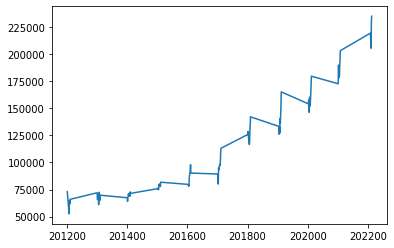

A13522004_60


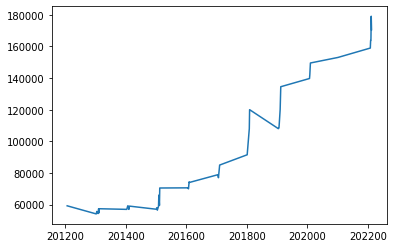

A13293505_60


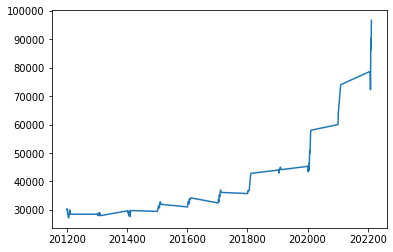

A13293505_80


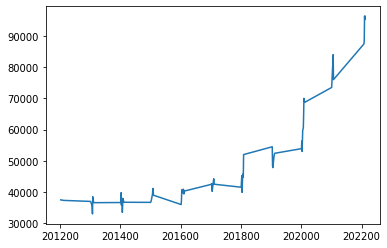

A13293505_110


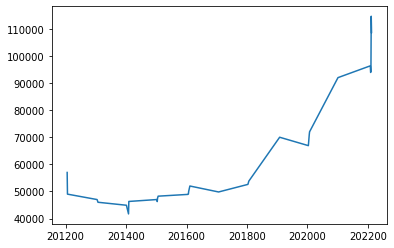

A15722001_60


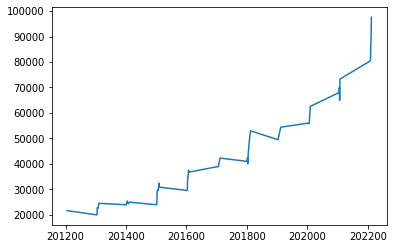

A15722001_80


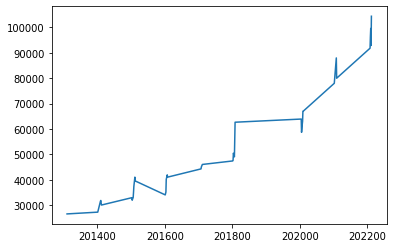

A12170601_60


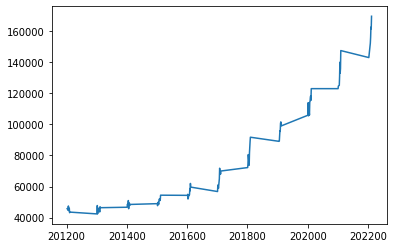

A12170601_80


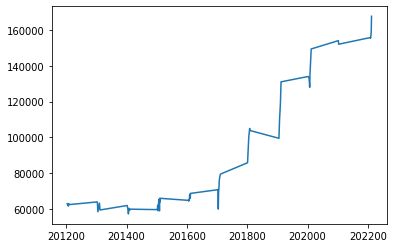

A12170601_110


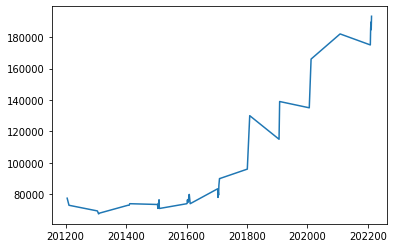

A13587603_40


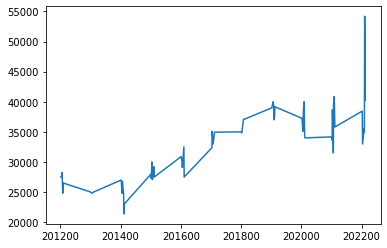

A13587603_60


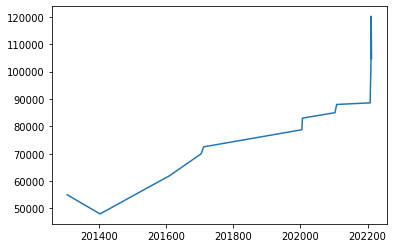

A13587603_50


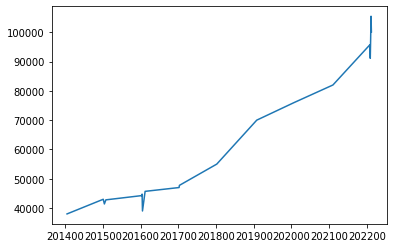

A10024581_80


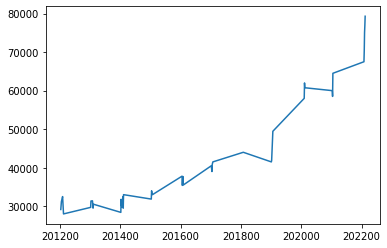

A15785709_50


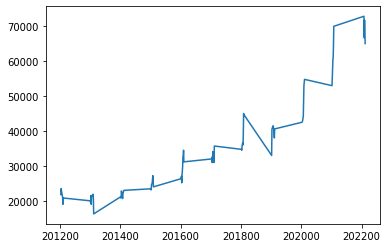

A15785709_40


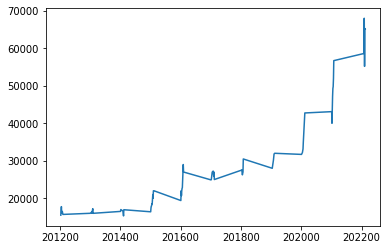

A15785709_60


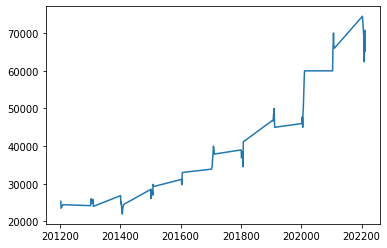

A14206301_60


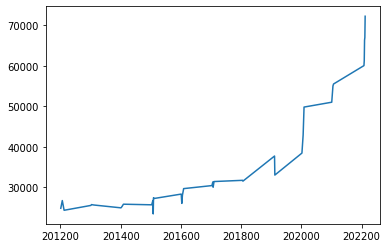

A14206301_80


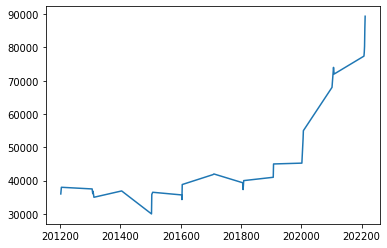

A14206301_130


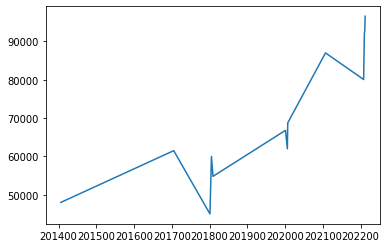

A15703301_40


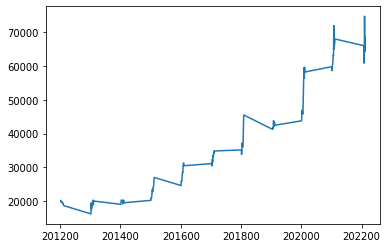

A13381701_70


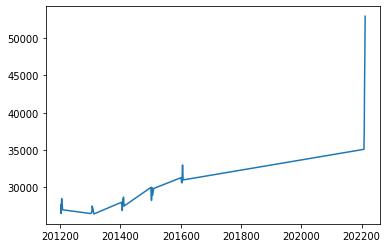

In [ ]:
for k in pred_list:
    gizuns = df_a[df_a['apart_code_area'].str.contains(k)]['apart_code_area'].unique()    
    for i in gizuns:
        x = df_a['YYYYMM'][df_a['apart_code_area']==i]
        y = df_a['prices'][df_a['apart_code_area']==i]
        plt.plot(x,y)
        print(i)
        plt.show()

In [ ]:
df_a

,apart_code,YYYYMM,apart__name,sigungu,town_name,address,sale_type,area_m3,floor,const_year,...,house_CCSI,unsold,prices,near_element,near_middle,near_high,generation,const,const_rank,apart_code_area
0,A10024240,201201,무지개,서울특별시 서초구 서초동,서초동,서울특별시 서초구 효령로 391,1,100.0,1,1978,...,106.0,1890.0,79666.666667,0.241347,0.551754,0.886371,1446.0,지에스건설(주),4,A10024240_100
1,A10024240,201201,무지개,서울특별시 서초구 서초동,서초동,서울특별시 서초구 효령로 391,1,100.0,11,1978,...,106.0,1890.0,79666.666667,0.241347,0.551754,0.886371,1446.0,지에스건설(주),4,A10024240_100
2,A10024240,201201,무지개,서울특별시 서초구 서초동,서초동,서울특별시 서초구 효령로 391,1,80.0,6,1978,...,106.0,1890.0,64000.000000,0.241347,0.551754,0.886371,1446.0,지에스건설(주),4,A10024240_80
3,A10024240,201201,무지개,서울특별시 서초구 서초동,서초동,서울특별시 서초구 효령로 391,1,100.0,3,1978,...,106.0,1890.0,79666.666667,0.241347,0.551754,0.886371,1446.0,지에스건설(주),4,A10024240_100
4,A10024240,201202,무지개,서울특별시 서초구 서초동,서초동,서울특별시 서초구 효령로 391,1,100.0,7,1978,...,111.3,1703.0,80170.000000,0.241347,0.551754,0.886371,1446.0,지에스건설(주),4,A10024240_100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725040,A10023991,202212,태릉해링턴플레이스,서울특별시 노원구 공릉동,공릉동,서울특별시 노원구 공릉로34길 86,1,60.0,12,2022,...,NaN,NaN,0.000000,0.478162,0.465578,0.792782,1308.0,효성중공업,4,A10023991_60
725041,A10023991,202212,태릉해링턴플레이스,서울특별시 노원구 공릉동,공릉동,서울특별시 노원구 공릉로34길 86,1,70.0,19,2022,...,NaN,NaN,0.000000,0.478162,0.465578,0.792782,1308.0,효성중공업,4,A10023991_70
725044,A10024359,202212,삼정아트테라스정동,서울특별시 중구 정동,정동,서울특별시 중구 서소문로 89-20,0,30.0,2,2020,...,NaN,NaN,0.000000,0.177679,0.349024,0.260624,168.0,삼정기업,4,A10024359_30
725045,A10024359,202212,삼정아트테라스정동,서울특별시 중구 정동,정동,서울특별시 중구 서소문로 89-20,0,10.0,8,2020,...,NaN,NaN,0.000000,0.177679,0.349024,0.260624,168.0,삼정기업,4,A10024359_10


In [ ]:
for k in test_codes:
    gizuns = df_a[df_a['apart_code_area'].str.contains(k)]['apart_code_area'].unique()    
    for i in gizuns:
        print(df_a[['YYYYMM','prices']][df_a['apart_code_area']==i])

        YYYYMM        prices
507522  201202   73000.00000
507524  201208   52500.00000
507525  201209   65000.00000
507526  201210   63500.00000
507527  201210   63500.00000
...        ...           ...
507522  202208  219196.12500
507522  202209  210026.59375
507522  202210  205255.50000
507522  202211  228287.15625
507522  202212  234747.43750

[328 rows x 2 columns]
        YYYYMM         prices
507523  201206   59250.000000
507533  201302   54125.000000
507536  201302   54125.000000
507542  201304   55700.000000
507548  201305   55000.000000
...        ...            ...
507523  202208  158940.531250
507523  202209  163730.453125
507523  202210  163766.562500
507523  202211  179038.687500
507523  202212  170557.062500

[67 rows x 2 columns]
        YYYYMM        prices
104932  201201  30000.000000
104933  201202  30400.000000
104934  201202  30400.000000
104935  201202  30400.000000
104937  201203  28500.000000
...        ...           ...
104932  202208  78691.070312
104932  20220